In [ ]:
!pip install ogb
!pip install torch_geometric
!pip install tqdm
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=458a1e7f0b27578058525171c717d42a542f14cec976b94947f03e16331268d2
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool, GlobalAttention, Set2Set
from torch_geometric.nn import GCNConv, GATv2Conv, TransformerConv
from ogb.graphproppred.mol_encoder import AtomEncoder,BondEncoder
from torch_geometric.utils import degree
from tqdm import tqdm
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.data import DataLoader
import torch.optim as optim
import numpy as np
import json
from google.colab import files

import math
from google.colab import runtime

In [ ]:
# Model Pipeline adapted from Stanford SNAP Group: https://github.com/snap-stanford/ogb/tree/master/examples/graphproppred/mol
class GINConv(MessagePassing):
    def __init__(self, emb_dim):
        '''
            emb_dim (int): node embedding dimensionality
        '''

        super(GINConv, self).__init__(aggr = "add")

        self.mlp = torch.nn.Sequential(torch.nn.Linear(emb_dim, emb_dim), torch.nn.BatchNorm1d(emb_dim), torch.nn.ReLU(), torch.nn.Linear(emb_dim, emb_dim))
        self.eps = torch.nn.Parameter(torch.Tensor([0]))

        self.bond_encoder = BondEncoder(emb_dim = emb_dim)

    def forward(self, x, edge_index, edge_attr):
        # edge_embedding = self.bond_encoder(edge_attr)
        out = self.mlp((1 + self.eps) *x + self.propagate(edge_index, x=x, edge_attr=edge_attr))

        return out

    def message(self, x_j, edge_attr):
        return F.relu(x_j + edge_attr)

    def update(self, aggr_out):
        return aggr_out

class GNN_node(torch.nn.Module):
    """
    Output:
        node representations
    """
    def __init__(self, num_layer, input_dim, emb_dim, drop_ratio = 0.5, JK = "last", residual = False, gnn_type = 'gcn'):
        '''
            emb_dim (int): node embedding dimensionality
            num_layer (int): number of GNN message passing layers

        '''

        super(GNN_node, self).__init__()
        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK
        ### add residual connection or not
        self.residual = residual

        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        self.atom_encoder = AtomEncoder(emb_dim)
        self.bond_encoder = BondEncoder(emb_dim)
        self.gnn_type = gnn_type

        ###List of GNNs
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        for layer in range(num_layer):
            if layer == 0:
                input_dim = emb_dim
            else:
                input_dim = emb_dim

            if gnn_type == 'gcn':
                self.convs.append(GCNConv(in_channels=input_dim, out_channels=emb_dim))
            elif gnn_type == 'gatv2':
                self.convs.append(GATv2Conv(in_channels=input_dim, out_channels=emb_dim, edge_dim=emb_dim))
            elif gnn_type == 'transformer':
                self.convs.append(TransformerConv(in_channels=input_dim, out_channels=emb_dim, edge_dim=emb_dim))
            elif gnn_type == 'gin':
                self.convs.append(GINConv(emb_dim))
            else:
                raise ValueError('Undefined GNN type called {}'.format(gnn_type))

            self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))

    def forward(self, batched_data, get_attn=False):
        x, edge_index, edge_attr, batch = batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.batch
        atom_emb = self.atom_encoder(x) # x is input atom feature
        edge_attr = self.bond_encoder(edge_attr) # edge_attr is input edge feature

        ### computing input node embedding
        h_list = [atom_emb]
        for layer in range(self.num_layer):
            if get_attn and (self.gnn_type == 'gatv2' or self.gnn_type == 'transformer'):
                h, others= self.convs[layer](x=h_list[layer], edge_index=edge_index, edge_attr=edge_attr, return_attention_weights=get_attn)
                # print(others)
                print("------Start------")
                print(others[0])
                print("*******************")
                print(others[1])
                print("------End------")
            else:
                h = self.convs[layer](x=h_list[layer], edge_index=edge_index, edge_attr=edge_attr)
            h = self.batch_norms[layer](h)

            if layer == self.num_layer - 1:
                #remove relu for the last layer
                h = F.dropout(h, self.drop_ratio, training = self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)

            if self.residual:
                h += h_list[layer]

            h_list.append(h)

        ### Different implementations of Jk-concat
        if self.JK == "last":
            node_representation = h_list[-1]
        elif self.JK == "sum":
            node_representation = 0
            for layer in range(self.num_layer + 1):
                node_representation += h_list[layer]

        return node_representation

class GNN_node_Virtualnode(torch.nn.Module):
    """
    Output:
        node representations
    """
    def __init__(self, num_layer, input_dim, emb_dim, drop_ratio = 0.5, JK = "last", residual = False, gnn_type = 'gin'):
        '''
            emb_dim (int): node embedding dimensionality
        '''

        super(GNN_node_Virtualnode, self).__init__()
        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK
        ### add residual connection or not
        self.residual = residual

        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        self.atom_encoder = AtomEncoder(emb_dim)
        self.bond_encoder = BondEncoder(emb_dim)
        self.gnn_type = gnn_type

        ### set the initial virtual node embedding to 0.
        self.virtualnode_embedding = torch.nn.Embedding(1, emb_dim)
        torch.nn.init.constant_(self.virtualnode_embedding.weight.data, 0)

        ### List of GNNs
        self.convs = torch.nn.ModuleList()
        ### batch norms applied to node embeddings
        self.batch_norms = torch.nn.ModuleList()

        ### List of MLPs to transform virtual node at every layer
        self.mlp_virtualnode_list = torch.nn.ModuleList()

        for layer in range(num_layer):
            if layer == 0:
                input_dim = emb_dim
            else:
                input_dim = emb_dim

            if gnn_type == 'gcn':
                self.convs.append(GCNConv(in_channels=input_dim, out_channels=emb_dim))
            elif gnn_type == 'gatv2':
                self.convs.append(GATv2Conv(in_channels=input_dim, out_channels=emb_dim, edge_dim=emb_dim))
            elif gnn_type == 'transformer':
                self.convs.append(TransformerConv(in_channels=input_dim, out_channels=emb_dim, edge_dim=emb_dim))
            elif gnn_type == 'gin':
                self.convs.append(GINConv(emb_dim))
            else:
                raise ValueError('Undefined GNN type called {}'.format(gnn_type))

            self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))

        for layer in range(num_layer - 1):
            self.mlp_virtualnode_list.append(torch.nn.Sequential(torch.nn.Linear(emb_dim, emb_dim), torch.nn.BatchNorm1d(emb_dim), torch.nn.ReLU(), \
                                                    torch.nn.Linear(emb_dim, emb_dim), torch.nn.BatchNorm1d(emb_dim), torch.nn.ReLU()))


    def forward(self, batched_data, get_attn=False):

        x, edge_index, edge_attr, batch = batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.batch
        atom_emb = self.atom_encoder(x) # x is input atom feature
        edge_attr = self.bond_encoder(edge_attr) # edge_attr is input edge feature

        ### virtual node embeddings for graphs
        virtualnode_embedding = self.virtualnode_embedding(torch.zeros(batch[-1].item() + 1).to(edge_index.dtype).to(edge_index.device))

        h_list = [atom_emb]
        for layer in range(self.num_layer):
            ### add message from virtual nodes to graph nodes
            h_list[layer] = h_list[layer] + virtualnode_embedding[batch]

            ### Message passing among graph nodes
            h = self.convs[layer](x=h_list[layer], edge_index=edge_index, edge_attr=edge_attr)
            h = self.batch_norms[layer](h)

            if layer == self.num_layer - 1:
                #remove relu for the last layer
                h = F.dropout(h, self.drop_ratio, training = self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)

            if self.residual:
                h = h + h_list[layer]

            h_list.append(h)

            ### update the virtual nodes
            if layer < self.num_layer - 1:
                ### add message from graph nodes to virtual nodes
                virtualnode_embedding_temp = global_add_pool(h_list[layer], batch) + virtualnode_embedding
                ### transform virtual nodes using MLP

                if self.residual:
                    virtualnode_embedding = virtualnode_embedding + F.dropout(self.mlp_virtualnode_list[layer](virtualnode_embedding_temp), self.drop_ratio, training = self.training)
                else:
                    virtualnode_embedding = F.dropout(self.mlp_virtualnode_list[layer](virtualnode_embedding_temp), self.drop_ratio, training = self.training)

        ### Different implementations of Jk-concat
        if self.JK == "last":
            node_representation = h_list[-1]
        elif self.JK == "sum":
            node_representation = 0
            for layer in range(self.num_layer + 1):
                node_representation += h_list[layer]

        return node_representation

In [ ]:
# Model Pipeline adapted from Stanford SNAP Group: https://github.com/snap-stanford/ogb/tree/master/examples/graphproppred/mol
class GNN(torch.nn.Module):

    def __init__(self, num_tasks, num_layer = 5, input_dim=9, emb_dim = 300,
                    gnn_type = 'gin', residual = False, drop_ratio = 0.5, JK = "last", graph_pooling = "mean", virtual_node = False, get_attn=False):
        '''
            num_tasks (int): number of labels to be predicted
            virtual_node (bool): whether to add virtual node or not
        '''

        super(GNN, self).__init__()

        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK
        self.emb_dim = emb_dim
        self.input_dim = input_dim
        self.num_tasks = num_tasks
        self.graph_pooling = graph_pooling
        self.get_attn = get_attn

        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        ### GNN to generate node embeddings
        if virtual_node:
            self.gnn_node = GNN_node_Virtualnode(num_layer, input_dim, emb_dim, JK = JK, drop_ratio = drop_ratio, residual = residual, gnn_type = gnn_type)
        else:
            self.gnn_node = GNN_node(num_layer, input_dim, emb_dim, JK = JK, drop_ratio = drop_ratio, residual = residual, gnn_type = gnn_type)


        ### Pooling function to generate whole-graph embeddings
        if self.graph_pooling == "sum":
            self.pool = global_add_pool
        elif self.graph_pooling == "mean":
            self.pool = global_mean_pool
        elif self.graph_pooling == "max":
            self.pool = global_max_pool
        else:
            raise ValueError("Invalid graph pooling type.")

        if graph_pooling == "set2set":
            self.graph_pred_linear = torch.nn.Linear(2*self.emb_dim, self.num_tasks)
        else:
            self.graph_pred_linear = torch.nn.Linear(self.emb_dim, self.num_tasks)

    def forward(self, batched_data, get_attn=False):
        # print(f"Within GNN, get_attn is {get_attn}")
        h_node = self.gnn_node(batched_data, get_attn)

        h_graph = self.pool(h_node, batched_data.batch)

        return self.graph_pred_linear(h_graph)


In [ ]:
cls_criterion = torch.nn.BCEWithLogitsLoss()
def train(model, device, loader, optimizer):
    model.train()

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
            pass
        else:
            pred = model(batch, False)
            optimizer.zero_grad()
            ## ignore nan targets (unlabeled) when computing training loss.
            is_labeled = batch.y == batch.y
            loss = cls_criterion(pred.to(torch.float32)[is_labeled], batch.y.to(torch.float32)[is_labeled])
            loss.backward()
            optimizer.step()

def eval(model, device, loader, evaluator, get_attn=False):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch, get_attn)

            y_true.append(batch.y.view(pred.shape).detach().cpu())
            y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()

    input_dict = {"y_true": y_true, "y_pred": y_pred}

    return evaluator.eval(input_dict)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
name = "ogbg-molpcba"
origin_dataset = PygGraphPropPredDataset(name = name, root = 'dataset/')
evaluator = Evaluator(name=name)

split_idx = origin_dataset.get_idx_split()
train_loader = DataLoader(origin_dataset[split_idx["train"]], batch_size=128, shuffle=True)
valid_loader = DataLoader(origin_dataset[split_idx["valid"]], batch_size=128, shuffle=False)
test_loader = DataLoader(origin_dataset[split_idx["test"]], batch_size=128, shuffle=False)

Downloaded 0.04 GB: 100%|██████████| 39/39 [00:04<00:00,  7.91it/s]
Processing...


Extracting dataset/pcba.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 437929/437929 [00:04<00:00, 92541.27it/s]


Converting graphs into PyG objects...


100%|██████████| 437929/437929 [00:16<00:00, 26369.51it/s]


Saving...


Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
def run_experiment(num_epochs=100, b_size=128, num_runs=3, seeds=[42, 2226, 174], model_type='gatv2', num_layers=2, input_d=300, emb_d=300, dropout_ratio=0.5, l_rate=1e-4, w_decay=1e-6, use_virtual_node=False, get_attn=False):
    train_loader = DataLoader(origin_dataset[split_idx["train"]], batch_size=b_size, shuffle=True)
    valid_loader = DataLoader(origin_dataset[split_idx["valid"]], batch_size=b_size, shuffle=False)
    test_loader = DataLoader(origin_dataset[split_idx["test"]], batch_size=b_size, shuffle=False)

    record = {'train': [], 'valid': [], 'test': []}

    for i in range(num_runs):
        valid_curve = []
        test_curve = []
        train_curve = []

        torch.manual_seed(seeds[i])
        np.random.seed(seeds[i])
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seeds[i])
            torch.cuda.manual_seed_all(seeds[i])

        model = GNN(gnn_type=model_type, num_tasks=128, num_layer=num_layers, input_dim=input_d, emb_dim=emb_d, drop_ratio=dropout_ratio, virtual_node=use_virtual_node).to(device)

        # Print out the number of trainable parameters
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total number of trainable parameters: {trainable_params}")

        # Define the optimizer
        optimizer = optim.Adam(model.parameters(), lr=l_rate, weight_decay=w_decay)

        epochs = num_epochs

        for epoch in range(1, epochs + 1):
            print("=====Epoch {}".format(epoch))
            print('Training...')
            train(model, device, train_loader, optimizer)

            print('Evaluating...')
            train_perf = eval(model, device, train_loader, evaluator, get_attn)
            valid_perf = eval(model, device, valid_loader, evaluator, get_attn)
            test_perf = eval(model, device, test_loader, evaluator, get_attn)

            print({'Train': train_perf, 'Validation': valid_perf, 'Test': test_perf})

            train_curve.append(train_perf['ap'])
            valid_curve.append(valid_perf['ap'])
            test_curve.append(test_perf['ap'])

            best_val_epoch = np.argmax(np.array(valid_curve))
            best_train = max(train_curve)

            print('Finished training!')
            print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
            print('Test score: {}'.format(test_curve[best_val_epoch]))

        print(f"----------------Finished run {i+1}!----------------")

        record['train'].append(train_curve)
        record['valid'].append(valid_curve)
        record['test'].append(test_curve)

    with open(f'{model_type}_record_{l_rate}_{b_size}_virtual_{use_virtual_node}_epochs_{num_runs}.json', 'w') as f:
        json.dump(record, f)

    files.download(f'{model_type}_record_{l_rate}_{b_size}_virtual_{use_virtual_node}_epochs_{num_runs}.json')

    return record


In [ ]:
run_experiment(num_epochs=2, b_size=128, num_runs=1, seeds=[42, 2226, 174], model_type='gatv2', num_layers=2, input_d=10, emb_d=300, dropout_ratio=0.5, l_rate=1e-3, w_decay=1e-6, get_attn=False)

Total number of trainable parameters: 638228
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:45<00:00, 25.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:09<00:00, 37.69it/s]


{'Train': {'ap': 0.08132788781485296}, 'Validation': {'ap': 0.08622605620266385}, 'Test': {'ap': 0.08621086309616345}}
Finished training!
Best validation score: 0.08622605620266385
Test score: 0.08621086309616345
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.17it/s]


{'Train': {'ap': 0.09084829763246394}, 'Validation': {'ap': 0.09484146947981172}, 'Test': {'ap': 0.09587092876640796}}
Finished training!
Best validation score: 0.09484146947981172
Test score: 0.09587092876640796
----------------Finished run 1!----------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'train': [[0.08132788781485296, 0.09084829763246394]],
 'valid': [[0.08622605620266385, 0.09484146947981172]],
 'test': [[0.08621086309616345, 0.09587092876640796]]}

### Experiment - GIN (baseline)

In [ ]:
run_experiment(num_epochs=100, b_size=128, num_runs=1, seeds=[42, 2226, 174], model_type='gin', num_layers=2, input_d=300, emb_d=300, dropout_ratio=0.5, l_rate=1e-3, w_decay=1e-6)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Total number of trainable parameters: 466030
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:46<00:00, 25.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:09<00:00, 35.58it/s]


{'Train': {'ap': 0.09909402203356435}, 'Validation': {'ap': 0.10353983974793338}, 'Test': {'ap': 0.10191173192074218}}
Finished training!
Best validation score: 0.10353983974793338
Test score: 0.10191173192074218
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 92.06it/s]


{'Train': {'ap': 0.1163782852565783}, 'Validation': {'ap': 0.11852389453134397}, 'Test': {'ap': 0.11535035433735744}}
Finished training!
Best validation score: 0.11852389453134397
Test score: 0.11535035433735744
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.75it/s]


{'Train': {'ap': 0.12297752497646215}, 'Validation': {'ap': 0.12085036773364367}, 'Test': {'ap': 0.1176871471854392}}
Finished training!
Best validation score: 0.12085036773364367
Test score: 0.1176871471854392
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.25it/s]


{'Train': {'ap': 0.13420783945358616}, 'Validation': {'ap': 0.13077404109540616}, 'Test': {'ap': 0.13062333674632073}}
Finished training!
Best validation score: 0.13077404109540616
Test score: 0.13062333674632073
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 52.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.88it/s]


{'Train': {'ap': 0.135607201781056}, 'Validation': {'ap': 0.13292207920863028}, 'Test': {'ap': 0.12821520948633996}}
Finished training!
Best validation score: 0.13292207920863028
Test score: 0.12821520948633996
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 92.49it/s]


{'Train': {'ap': 0.1488611267313233}, 'Validation': {'ap': 0.14148141763789363}, 'Test': {'ap': 0.13690913411879596}}
Finished training!
Best validation score: 0.14148141763789363
Test score: 0.13690913411879596
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.47it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 94.42it/s]


{'Train': {'ap': 0.15638715052482802}, 'Validation': {'ap': 0.14361624547744273}, 'Test': {'ap': 0.14343666179882605}}
Finished training!
Best validation score: 0.14361624547744273
Test score: 0.14343666179882605
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.37it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 93.99it/s]


{'Train': {'ap': 0.15579372635830774}, 'Validation': {'ap': 0.14507942263589652}, 'Test': {'ap': 0.14407272170640573}}
Finished training!
Best validation score: 0.14507942263589652
Test score: 0.14407272170640573
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 94.37it/s] 


{'Train': {'ap': 0.16415510843244813}, 'Validation': {'ap': 0.15212282374388592}, 'Test': {'ap': 0.14865397959400373}}
Finished training!
Best validation score: 0.15212282374388592
Test score: 0.14865397959400373
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 52.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.99it/s]


{'Train': {'ap': 0.16808988260986563}, 'Validation': {'ap': 0.15873717553109368}, 'Test': {'ap': 0.1520270683765554}}
Finished training!
Best validation score: 0.15873717553109368
Test score: 0.1520270683765554
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 52.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.85it/s]


{'Train': {'ap': 0.1701688846783687}, 'Validation': {'ap': 0.1602401583628547}, 'Test': {'ap': 0.15322847164706124}}
Finished training!
Best validation score: 0.1602401583628547
Test score: 0.15322847164706124
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.99it/s]


{'Train': {'ap': 0.17844341093925328}, 'Validation': {'ap': 0.1580714565543308}, 'Test': {'ap': 0.15603914757289883}}
Finished training!
Best validation score: 0.1602401583628547
Test score: 0.15322847164706124
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.68it/s]


{'Train': {'ap': 0.1800645833833778}, 'Validation': {'ap': 0.16419358387525654}, 'Test': {'ap': 0.1588131252354677}}
Finished training!
Best validation score: 0.16419358387525654
Test score: 0.1588131252354677
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 92.66it/s]


{'Train': {'ap': 0.179108485771637}, 'Validation': {'ap': 0.16251733902979051}, 'Test': {'ap': 0.15531648240876128}}
Finished training!
Best validation score: 0.16419358387525654
Test score: 0.1588131252354677
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 53.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 95.14it/s]


{'Train': {'ap': 0.1846213354770494}, 'Validation': {'ap': 0.16447787790660634}, 'Test': {'ap': 0.1622301259365364}}
Finished training!
Best validation score: 0.16447787790660634
Test score: 0.1622301259365364
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 53.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 94.62it/s]


{'Train': {'ap': 0.18552488100624717}, 'Validation': {'ap': 0.16363436459964728}, 'Test': {'ap': 0.15854942044752093}}
Finished training!
Best validation score: 0.16447787790660634
Test score: 0.1622301259365364
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 53.29it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 94.43it/s]


{'Train': {'ap': 0.18496749338994967}, 'Validation': {'ap': 0.166227058687152}, 'Test': {'ap': 0.1624599535454203}}
Finished training!
Best validation score: 0.166227058687152
Test score: 0.1624599535454203
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 53.26it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 93.09it/s]


{'Train': {'ap': 0.19115409372265096}, 'Validation': {'ap': 0.16405037434013783}, 'Test': {'ap': 0.16173687665679004}}
Finished training!
Best validation score: 0.166227058687152
Test score: 0.1624599535454203
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 53.19it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.84it/s]


{'Train': {'ap': 0.18740018970946318}, 'Validation': {'ap': 0.17108059506576703}, 'Test': {'ap': 0.1621070891479335}}
Finished training!
Best validation score: 0.17108059506576703
Test score: 0.1621070891479335
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 53.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.56it/s]


{'Train': {'ap': 0.19578908322960722}, 'Validation': {'ap': 0.17194910390682827}, 'Test': {'ap': 0.16169861595281335}}
Finished training!
Best validation score: 0.17194910390682827
Test score: 0.16169861595281335
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 95.03it/s]


{'Train': {'ap': 0.19430223357673948}, 'Validation': {'ap': 0.16731116162908008}, 'Test': {'ap': 0.1638963476454715}}
Finished training!
Best validation score: 0.17194910390682827
Test score: 0.16169861595281335
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 52.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 96.61it/s]


{'Train': {'ap': 0.19506949810993796}, 'Validation': {'ap': 0.17477330567633548}, 'Test': {'ap': 0.16476540406013504}}
Finished training!
Best validation score: 0.17477330567633548
Test score: 0.16476540406013504
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 51.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.31it/s]


{'Train': {'ap': 0.18780748255126345}, 'Validation': {'ap': 0.16484584073976633}, 'Test': {'ap': 0.16141834813214648}}
Finished training!
Best validation score: 0.17477330567633548
Test score: 0.16476540406013504
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 52.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.02it/s]


{'Train': {'ap': 0.20066356315672634}, 'Validation': {'ap': 0.17031149245473523}, 'Test': {'ap': 0.16763481072682793}}
Finished training!
Best validation score: 0.17477330567633548
Test score: 0.16476540406013504
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 92.11it/s]


{'Train': {'ap': 0.20285316109981077}, 'Validation': {'ap': 0.17077120070580337}, 'Test': {'ap': 0.16365782098914594}}
Finished training!
Best validation score: 0.17477330567633548
Test score: 0.16476540406013504
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.84it/s]


{'Train': {'ap': 0.20559491063158378}, 'Validation': {'ap': 0.1803085212536077}, 'Test': {'ap': 0.16743865269392386}}
Finished training!
Best validation score: 0.1803085212536077
Test score: 0.16743865269392386
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.79it/s]


{'Train': {'ap': 0.2022692070257136}, 'Validation': {'ap': 0.16903351278194087}, 'Test': {'ap': 0.16336692525604193}}
Finished training!
Best validation score: 0.1803085212536077
Test score: 0.16743865269392386
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.25it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 93.14it/s]


{'Train': {'ap': 0.2037396369282531}, 'Validation': {'ap': 0.1727795245278231}, 'Test': {'ap': 0.16399755455983434}}
Finished training!
Best validation score: 0.1803085212536077
Test score: 0.16743865269392386
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.56it/s]


{'Train': {'ap': 0.20419499758933057}, 'Validation': {'ap': 0.17366119874162317}, 'Test': {'ap': 0.1681423781632325}}
Finished training!
Best validation score: 0.1803085212536077
Test score: 0.16743865269392386
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 53.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 94.42it/s]


{'Train': {'ap': 0.2015638997277122}, 'Validation': {'ap': 0.169977166375402}, 'Test': {'ap': 0.16588799709691687}}
Finished training!
Best validation score: 0.1803085212536077
Test score: 0.16743865269392386
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 53.17it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.91it/s]


{'Train': {'ap': 0.20644048229987258}, 'Validation': {'ap': 0.1777424712356426}, 'Test': {'ap': 0.17081946589808064}}
Finished training!
Best validation score: 0.1803085212536077
Test score: 0.16743865269392386
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 53.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.32it/s]


{'Train': {'ap': 0.20975113985007282}, 'Validation': {'ap': 0.181493492351775}, 'Test': {'ap': 0.17129817490699623}}
Finished training!
Best validation score: 0.181493492351775
Test score: 0.17129817490699623
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 52.94it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 94.19it/s]


{'Train': {'ap': 0.2066175324548339}, 'Validation': {'ap': 0.1797281521712922}, 'Test': {'ap': 0.1693818964755851}}
Finished training!
Best validation score: 0.181493492351775
Test score: 0.17129817490699623
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 51.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.79it/s]


{'Train': {'ap': 0.21026439523485005}, 'Validation': {'ap': 0.17959108751152497}, 'Test': {'ap': 0.16946429029384227}}
Finished training!
Best validation score: 0.181493492351775
Test score: 0.17129817490699623
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 53.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 93.39it/s]


{'Train': {'ap': 0.2142254487176913}, 'Validation': {'ap': 0.18078568852629628}, 'Test': {'ap': 0.17564569907129396}}
Finished training!
Best validation score: 0.181493492351775
Test score: 0.17129817490699623
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [00:51<00:00, 52.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 95.35it/s]


{'Train': {'ap': 0.21103991622625742}, 'Validation': {'ap': 0.17190878532516005}, 'Test': {'ap': 0.17073834589326595}}
Finished training!
Best validation score: 0.181493492351775
Test score: 0.17129817490699623
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.05it/s]


{'Train': {'ap': 0.21067475347333336}, 'Validation': {'ap': 0.17188700571607363}, 'Test': {'ap': 0.17078018164113606}}
Finished training!
Best validation score: 0.181493492351775
Test score: 0.17129817490699623
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 52.53it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 92.51it/s]


{'Train': {'ap': 0.21001440490992515}, 'Validation': {'ap': 0.17577381686037793}, 'Test': {'ap': 0.1720252680906119}}
Finished training!
Best validation score: 0.181493492351775
Test score: 0.17129817490699623
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 51.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.50it/s]


{'Train': {'ap': 0.21348391565276895}, 'Validation': {'ap': 0.1803812069674391}, 'Test': {'ap': 0.17084222371174063}}
Finished training!
Best validation score: 0.181493492351775
Test score: 0.17129817490699623
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 51.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.09it/s]


{'Train': {'ap': 0.20821973015991666}, 'Validation': {'ap': 0.17155720376526373}, 'Test': {'ap': 0.16921454090422808}}
Finished training!
Best validation score: 0.181493492351775
Test score: 0.17129817490699623
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 51.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.82it/s]


{'Train': {'ap': 0.2179636203879572}, 'Validation': {'ap': 0.17926274503345788}, 'Test': {'ap': 0.17634321211966197}}
Finished training!
Best validation score: 0.181493492351775
Test score: 0.17129817490699623
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [00:52<00:00, 51.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 99.49it/s] 


{'Train': {'ap': 0.2133193426943898}, 'Validation': {'ap': 0.18188538304896287}, 'Test': {'ap': 0.17177350431395272}}
Finished training!
Best validation score: 0.18188538304896287
Test score: 0.17177350431395272
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [00:49<00:00, 55.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 94.37it/s] 


{'Train': {'ap': 0.21383056135164083}, 'Validation': {'ap': 0.17568340477426453}, 'Test': {'ap': 0.1707915663638932}}
Finished training!
Best validation score: 0.18188538304896287
Test score: 0.17177350431395272
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 55.97it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 97.87it/s] 


{'Train': {'ap': 0.21945995032852297}, 'Validation': {'ap': 0.18184319637627616}, 'Test': {'ap': 0.17307272331809995}}
Finished training!
Best validation score: 0.18188538304896287
Test score: 0.17177350431395272
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 99.72it/s] 


{'Train': {'ap': 0.21386315336258768}, 'Validation': {'ap': 0.17271333585194382}, 'Test': {'ap': 0.17086845615184815}}
Finished training!
Best validation score: 0.18188538304896287
Test score: 0.17177350431395272
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.26it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 100.00it/s]


{'Train': {'ap': 0.2137126982099703}, 'Validation': {'ap': 0.17323135720056604}, 'Test': {'ap': 0.17008479698196902}}
Finished training!
Best validation score: 0.18188538304896287
Test score: 0.17177350431395272
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 99.57it/s]


{'Train': {'ap': 0.21278086089813777}, 'Validation': {'ap': 0.17955890828804913}, 'Test': {'ap': 0.1773924121063446}}
Finished training!
Best validation score: 0.18188538304896287
Test score: 0.17177350431395272
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [00:50<00:00, 54.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 99.77it/s] 


{'Train': {'ap': 0.21950878998898798}, 'Validation': {'ap': 0.18281238544345846}, 'Test': {'ap': 0.17898679480270951}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 98.14it/s]


{'Train': {'ap': 0.21711354279682438}, 'Validation': {'ap': 0.17139259314673455}, 'Test': {'ap': 0.16923207697595655}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 102.58it/s]


{'Train': {'ap': 0.2216219918670292}, 'Validation': {'ap': 0.17594195914468927}, 'Test': {'ap': 0.1704930698781512}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [00:50<00:00, 54.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 104.04it/s]


{'Train': {'ap': 0.21689191066808708}, 'Validation': {'ap': 0.17591739860937533}, 'Test': {'ap': 0.16971485736571076}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 102.34it/s]


{'Train': {'ap': 0.21873293900938665}, 'Validation': {'ap': 0.18156540504329752}, 'Test': {'ap': 0.1700605983164139}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.26it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 101.10it/s]


{'Train': {'ap': 0.2191845691595553}, 'Validation': {'ap': 0.18206231497625844}, 'Test': {'ap': 0.1737874759694239}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 102.52it/s]


{'Train': {'ap': 0.21873179094478676}, 'Validation': {'ap': 0.17705819050933314}, 'Test': {'ap': 0.1729185318803078}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 101.80it/s]


{'Train': {'ap': 0.22236865501464878}, 'Validation': {'ap': 0.18258297997399522}, 'Test': {'ap': 0.17673351761045134}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.23it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 96.62it/s]


{'Train': {'ap': 0.22359064175023888}, 'Validation': {'ap': 0.17865925353492654}, 'Test': {'ap': 0.178218736221569}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 99.21it/s] 


{'Train': {'ap': 0.217291630143199}, 'Validation': {'ap': 0.17878781155808662}, 'Test': {'ap': 0.17580214621125811}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 102.93it/s]


{'Train': {'ap': 0.21124725354219914}, 'Validation': {'ap': 0.17302405069303492}, 'Test': {'ap': 0.1703761456101738}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [00:49<00:00, 55.25it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 103.71it/s]


{'Train': {'ap': 0.21922468366019277}, 'Validation': {'ap': 0.17702290526961922}, 'Test': {'ap': 0.17501901357094873}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 100.29it/s]


{'Train': {'ap': 0.2250965264726519}, 'Validation': {'ap': 0.1812280770295836}, 'Test': {'ap': 0.17787255160283086}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 103.17it/s]


{'Train': {'ap': 0.22414739456755717}, 'Validation': {'ap': 0.17279943808212078}, 'Test': {'ap': 0.1723879077826998}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [00:49<00:00, 55.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 103.89it/s]


{'Train': {'ap': 0.2239642962298429}, 'Validation': {'ap': 0.17998826614040286}, 'Test': {'ap': 0.17437327231915736}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.72it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 100.62it/s]


{'Train': {'ap': 0.2180868487037345}, 'Validation': {'ap': 0.1804378049126362}, 'Test': {'ap': 0.17673024075446903}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.72it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 102.88it/s]


{'Train': {'ap': 0.22032218518518884}, 'Validation': {'ap': 0.17896480174882687}, 'Test': {'ap': 0.17849852300304692}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 57.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 102.61it/s]


{'Train': {'ap': 0.22507054323054476}, 'Validation': {'ap': 0.1777045050694997}, 'Test': {'ap': 0.1746423032282458}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 97.16it/s] 


{'Train': {'ap': 0.22451398142809967}, 'Validation': {'ap': 0.1805331109524243}, 'Test': {'ap': 0.18302612721486555}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.92it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 100.11it/s]


{'Train': {'ap': 0.22044714032400672}, 'Validation': {'ap': 0.1772181337484189}, 'Test': {'ap': 0.17488141474047508}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 103.94it/s]


{'Train': {'ap': 0.22462310787226203}, 'Validation': {'ap': 0.17911090631675025}, 'Test': {'ap': 0.1741852245959107}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 103.84it/s]


{'Train': {'ap': 0.22230760703980826}, 'Validation': {'ap': 0.17736945191526776}, 'Test': {'ap': 0.17911357372863562}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 104.06it/s]


{'Train': {'ap': 0.22070384227439552}, 'Validation': {'ap': 0.17661099141713044}, 'Test': {'ap': 0.17413559319726546}}
Finished training!
Best validation score: 0.18281238544345846
Test score: 0.17898679480270951
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 57.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 102.93it/s]


{'Train': {'ap': 0.22555440747118496}, 'Validation': {'ap': 0.18416835740989937}, 'Test': {'ap': 0.18000012191266504}}
Finished training!
Best validation score: 0.18416835740989937
Test score: 0.18000012191266504
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 100.66it/s]


{'Train': {'ap': 0.22198015043487213}, 'Validation': {'ap': 0.18130751619327592}, 'Test': {'ap': 0.17547531166288355}}
Finished training!
Best validation score: 0.18416835740989937
Test score: 0.18000012191266504
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [00:49<00:00, 55.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 103.02it/s]


{'Train': {'ap': 0.22404231973227734}, 'Validation': {'ap': 0.17908311320091583}, 'Test': {'ap': 0.17492123337881826}}
Finished training!
Best validation score: 0.18416835740989937
Test score: 0.18000012191266504
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 103.70it/s]


{'Train': {'ap': 0.2255061470096644}, 'Validation': {'ap': 0.1797107435297377}, 'Test': {'ap': 0.17541225988075884}}
Finished training!
Best validation score: 0.18416835740989937
Test score: 0.18000012191266504
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 103.53it/s]


{'Train': {'ap': 0.22848138566504078}, 'Validation': {'ap': 0.17947779703530697}, 'Test': {'ap': 0.18003604986522584}}
Finished training!
Best validation score: 0.18416835740989937
Test score: 0.18000012191266504
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [00:49<00:00, 55.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 95.95it/s] 


{'Train': {'ap': 0.228655692782672}, 'Validation': {'ap': 0.18784145407325156}, 'Test': {'ap': 0.17802744901957931}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 102.41it/s]


{'Train': {'ap': 0.2250162908108379}, 'Validation': {'ap': 0.18052194914731565}, 'Test': {'ap': 0.18029342396310757}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 104.20it/s]


{'Train': {'ap': 0.22724210052839308}, 'Validation': {'ap': 0.17911582542099586}, 'Test': {'ap': 0.1777575757610859}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 105.06it/s]


{'Train': {'ap': 0.2252690482362394}, 'Validation': {'ap': 0.18155200428336948}, 'Test': {'ap': 0.1770243510271498}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 100.40it/s]


{'Train': {'ap': 0.22473287274113377}, 'Validation': {'ap': 0.18295708758049542}, 'Test': {'ap': 0.17676047426155742}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.95it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 104.42it/s]


{'Train': {'ap': 0.23197554699025208}, 'Validation': {'ap': 0.18262072659282863}, 'Test': {'ap': 0.1827124135416408}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 103.10it/s]


{'Train': {'ap': 0.22384126764562412}, 'Validation': {'ap': 0.1816256149939617}, 'Test': {'ap': 0.175081568339658}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.93it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 104.36it/s]


{'Train': {'ap': 0.2247427556082217}, 'Validation': {'ap': 0.18661067701143438}, 'Test': {'ap': 0.1737056715041681}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [00:49<00:00, 55.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 103.32it/s]


{'Train': {'ap': 0.2272002511034764}, 'Validation': {'ap': 0.17937738905373268}, 'Test': {'ap': 0.17699409355890955}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 102.39it/s]


{'Train': {'ap': 0.227851715357376}, 'Validation': {'ap': 0.1841096953091383}, 'Test': {'ap': 0.17869893342662582}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.93it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 100.44it/s]


{'Train': {'ap': 0.22392152905619958}, 'Validation': {'ap': 0.17672778184586557}, 'Test': {'ap': 0.17332277045902178}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [00:49<00:00, 55.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 99.49it/s] 


{'Train': {'ap': 0.22753553746295554}, 'Validation': {'ap': 0.18133143639421578}, 'Test': {'ap': 0.17942539716207984}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.21it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 101.32it/s]


{'Train': {'ap': 0.2269046309464076}, 'Validation': {'ap': 0.18470668634369425}, 'Test': {'ap': 0.17763964787552858}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 103.72it/s]


{'Train': {'ap': 0.22555914041665548}, 'Validation': {'ap': 0.1809982080749904}, 'Test': {'ap': 0.1781901356245444}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 106.36it/s]


{'Train': {'ap': 0.22513271818654979}, 'Validation': {'ap': 0.1826819390025563}, 'Test': {'ap': 0.1787940863699915}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 102.97it/s]


{'Train': {'ap': 0.22104792157099173}, 'Validation': {'ap': 0.18104931286060208}, 'Test': {'ap': 0.17490184689696311}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 99.44it/s] 


{'Train': {'ap': 0.22621205564423225}, 'Validation': {'ap': 0.1828267298131553}, 'Test': {'ap': 0.1781619999093274}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 57.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 104.13it/s]


{'Train': {'ap': 0.22412420780997389}, 'Validation': {'ap': 0.17807772997438495}, 'Test': {'ap': 0.17538673255774612}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 104.39it/s]


{'Train': {'ap': 0.22385746094742945}, 'Validation': {'ap': 0.17828770963863422}, 'Test': {'ap': 0.18001160392954552}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [00:47<00:00, 57.31it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 102.43it/s]


{'Train': {'ap': 0.22515750350098204}, 'Validation': {'ap': 0.17937806248779434}, 'Test': {'ap': 0.17982984464361987}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [00:49<00:00, 55.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 102.84it/s]


{'Train': {'ap': 0.22601299155794696}, 'Validation': {'ap': 0.1780970309898084}, 'Test': {'ap': 0.1758832619209941}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 103.23it/s]


{'Train': {'ap': 0.22506148726779193}, 'Validation': {'ap': 0.17837492025318127}, 'Test': {'ap': 0.1806571674525589}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [00:49<00:00, 55.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 101.90it/s]


{'Train': {'ap': 0.22535946549514738}, 'Validation': {'ap': 0.18392135725156533}, 'Test': {'ap': 0.17444688425837448}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 101.05it/s]


{'Train': {'ap': 0.2266838300653939}, 'Validation': {'ap': 0.18283329484709293}, 'Test': {'ap': 0.18113685454572645}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [00:48<00:00, 56.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 101.28it/s]


{'Train': {'ap': 0.22438402284956233}, 'Validation': {'ap': 0.16938339431053492}, 'Test': {'ap': 0.17109459774805547}}
Finished training!
Best validation score: 0.18784145407325156
Test score: 0.17802744901957931
----------------Finished run 1!----------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'train': [[0.09909402203356435,
   0.1163782852565783,
   0.12297752497646215,
   0.13420783945358616,
   0.135607201781056,
   0.1488611267313233,
   0.15638715052482802,
   0.15579372635830774,
   0.16415510843244813,
   0.16808988260986563,
   0.1701688846783687,
   0.17844341093925328,
   0.1800645833833778,
   0.179108485771637,
   0.1846213354770494,
   0.18552488100624717,
   0.18496749338994967,
   0.19115409372265096,
   0.18740018970946318,
   0.19578908322960722,
   0.19430223357673948,
   0.19506949810993796,
   0.18780748255126345,
   0.20066356315672634,
   0.20285316109981077,
   0.20559491063158378,
   0.2022692070257136,
   0.2037396369282531,
   0.20419499758933057,
   0.2015638997277122,
   0.20644048229987258,
   0.20975113985007282,
   0.2066175324548339,
   0.21026439523485005,
   0.2142254487176913,
   0.21103991622625742,
   0.21067475347333336,
   0.21001440490992515,
   0.21348391565276895,
   0.20821973015991666,
   0.2179636203879572,
   0.2133193426943898,

## Experiments - GATv2 & TransformerConv (without Virtual Node)

###1e-3

#### Transformer

In [ ]:
trans_record = {'train': [], 'valid': [], 'test': []}

runs = 3

seeds = [42, 2226, 174]

for i in range(runs):
    torch.manual_seed(seeds[i])
    np.random.seed(seeds[i])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seeds[i])
        torch.cuda.manual_seed_all(seeds[i])


    model = GNN(gnn_type = 'transformer', num_tasks = 128, num_layer = 2, input_dim = 300, emb_dim = 300, drop_ratio = 0.5).to(device)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of trainable parameters: {trainable_params}")

    # optimizer = optim.Adam(model.parameters(), lr=1e-3)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)


    valid_curve = []
    test_curve = []
    train_curve = []

    epochs = 100

    for epoch in range(1, epochs + 1):
        print("=====Epoch {}".format(epoch))
        print('Training...')
        train(model, device, train_loader, optimizer)

        print('Evaluating...')
        train_perf = eval(model, device, train_loader, evaluator)
        valid_perf = eval(model, device, valid_loader, evaluator)
        test_perf = eval(model, device, test_loader, evaluator)

        print({'Train': train_perf, 'Validation': valid_perf, 'Test': test_perf})

        train_curve.append(train_perf['ap'])
        valid_curve.append(valid_perf['ap'])
        test_curve.append(test_perf['ap'])

        best_val_epoch = np.argmax(np.array(valid_curve))
        best_train = max(train_curve)

        print('Finished training!')
        print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
        print('Test score: {}'.format(test_curve[best_val_epoch]))

    print(f"----------------Finished run {i+1}!----------------")

    trans_record['train'].append(train_curve)
    trans_record['valid'].append(valid_curve)
    trans_record['test'].append(test_curve)

Total number of trainable parameters: 998228
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:43<00:00, 26.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:10<00:00, 33.23it/s]


{'Train': {'ap': 0.0827902557111826}, 'Validation': {'ap': 0.08436388867503207}, 'Test': {'ap': 0.08621843568534064}}
Finished training!
Best validation score: 0.08436388867503207
Test score: 0.08621843568534064
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.07it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.46it/s]


{'Train': {'ap': 0.09428159082035549}, 'Validation': {'ap': 0.09711373709942511}, 'Test': {'ap': 0.09851876371897005}}
Finished training!
Best validation score: 0.09711373709942511
Test score: 0.09851876371897005
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.19it/s]


{'Train': {'ap': 0.0995983110000509}, 'Validation': {'ap': 0.10076578873510174}, 'Test': {'ap': 0.10119170614626494}}
Finished training!
Best validation score: 0.10076578873510174
Test score: 0.10119170614626494
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.42it/s]


{'Train': {'ap': 0.10376533240677167}, 'Validation': {'ap': 0.10492919988144431}, 'Test': {'ap': 0.10662482884927027}}
Finished training!
Best validation score: 0.10492919988144431
Test score: 0.10662482884927027
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.00it/s]


{'Train': {'ap': 0.1080716321048049}, 'Validation': {'ap': 0.10743085823053496}, 'Test': {'ap': 0.10811526557269385}}
Finished training!
Best validation score: 0.10743085823053496
Test score: 0.10811526557269385
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.66it/s]


{'Train': {'ap': 0.10979616433612772}, 'Validation': {'ap': 0.11325201306085264}, 'Test': {'ap': 0.11316492210800629}}
Finished training!
Best validation score: 0.11325201306085264
Test score: 0.11316492210800629
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.33it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.50it/s]


{'Train': {'ap': 0.11557698833082274}, 'Validation': {'ap': 0.11776981122461226}, 'Test': {'ap': 0.11956729131687198}}
Finished training!
Best validation score: 0.11776981122461226
Test score: 0.11956729131687198
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.25it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 65.78it/s]


{'Train': {'ap': 0.11772180234479733}, 'Validation': {'ap': 0.1156256601123189}, 'Test': {'ap': 0.1187998865376104}}
Finished training!
Best validation score: 0.11776981122461226
Test score: 0.11956729131687198
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.23it/s]


{'Train': {'ap': 0.11912918615919443}, 'Validation': {'ap': 0.11542558469994801}, 'Test': {'ap': 0.11939950935606823}}
Finished training!
Best validation score: 0.11776981122461226
Test score: 0.11956729131687198
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.60it/s]


{'Train': {'ap': 0.12369839727597211}, 'Validation': {'ap': 0.12046285412369151}, 'Test': {'ap': 0.11909347511841004}}
Finished training!
Best validation score: 0.12046285412369151
Test score: 0.11909347511841004
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.19it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.36it/s]


{'Train': {'ap': 0.1256179811313822}, 'Validation': {'ap': 0.12197876071399055}, 'Test': {'ap': 0.11793903436847192}}
Finished training!
Best validation score: 0.12197876071399055
Test score: 0.11793903436847192
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.72it/s]


{'Train': {'ap': 0.12333484563252056}, 'Validation': {'ap': 0.12043519648038237}, 'Test': {'ap': 0.12038503382440197}}
Finished training!
Best validation score: 0.12197876071399055
Test score: 0.11793903436847192
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.33it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.84it/s]


{'Train': {'ap': 0.12858459831002073}, 'Validation': {'ap': 0.12038682462954442}, 'Test': {'ap': 0.1205136885786782}}
Finished training!
Best validation score: 0.12197876071399055
Test score: 0.11793903436847192
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.45it/s]


{'Train': {'ap': 0.12679013712083353}, 'Validation': {'ap': 0.12207506441905505}, 'Test': {'ap': 0.1247075299388211}}
Finished training!
Best validation score: 0.12207506441905505
Test score: 0.1247075299388211
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.11it/s]


{'Train': {'ap': 0.12434827304102761}, 'Validation': {'ap': 0.12060153424866323}, 'Test': {'ap': 0.11991578524415422}}
Finished training!
Best validation score: 0.12207506441905505
Test score: 0.1247075299388211
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.99it/s]


{'Train': {'ap': 0.12908576238795605}, 'Validation': {'ap': 0.12221087798215868}, 'Test': {'ap': 0.1240188125187853}}
Finished training!
Best validation score: 0.12221087798215868
Test score: 0.1240188125187853
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.00it/s]


{'Train': {'ap': 0.1277499126123019}, 'Validation': {'ap': 0.1197876034774834}, 'Test': {'ap': 0.1213917009454994}}
Finished training!
Best validation score: 0.12221087798215868
Test score: 0.1240188125187853
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.37it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.72it/s]


{'Train': {'ap': 0.13457123536733198}, 'Validation': {'ap': 0.12632788053911165}, 'Test': {'ap': 0.1297810343539786}}
Finished training!
Best validation score: 0.12632788053911165
Test score: 0.1297810343539786
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.44it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.89it/s]


{'Train': {'ap': 0.12845589583777836}, 'Validation': {'ap': 0.12195930698534538}, 'Test': {'ap': 0.1205081887538094}}
Finished training!
Best validation score: 0.12632788053911165
Test score: 0.1297810343539786
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.89it/s]


{'Train': {'ap': 0.13425575453278552}, 'Validation': {'ap': 0.12765630871057296}, 'Test': {'ap': 0.12405064496722408}}
Finished training!
Best validation score: 0.12765630871057296
Test score: 0.12405064496722408
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.76it/s]


{'Train': {'ap': 0.13374154497756754}, 'Validation': {'ap': 0.12810399457824073}, 'Test': {'ap': 0.12636757691112524}}
Finished training!
Best validation score: 0.12810399457824073
Test score: 0.12636757691112524
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.98it/s]


{'Train': {'ap': 0.13527666439257463}, 'Validation': {'ap': 0.1282705752122927}, 'Test': {'ap': 0.12566565115916767}}
Finished training!
Best validation score: 0.1282705752122927
Test score: 0.12566565115916767
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.47it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.00it/s]


{'Train': {'ap': 0.13415292266155535}, 'Validation': {'ap': 0.13063280990954101}, 'Test': {'ap': 0.1251880916239808}}
Finished training!
Best validation score: 0.13063280990954101
Test score: 0.1251880916239808
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.79it/s]


{'Train': {'ap': 0.1364349115780142}, 'Validation': {'ap': 0.13353140918027626}, 'Test': {'ap': 0.127504990224185}}
Finished training!
Best validation score: 0.13353140918027626
Test score: 0.127504990224185
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.02it/s]


{'Train': {'ap': 0.13547929807321332}, 'Validation': {'ap': 0.1281633123702768}, 'Test': {'ap': 0.1285772697482183}}
Finished training!
Best validation score: 0.13353140918027626
Test score: 0.127504990224185
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.54it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.38it/s]


{'Train': {'ap': 0.13524014924897787}, 'Validation': {'ap': 0.12946201323027268}, 'Test': {'ap': 0.12521105914071276}}
Finished training!
Best validation score: 0.13353140918027626
Test score: 0.127504990224185
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.92it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.65it/s]


{'Train': {'ap': 0.13958205419353412}, 'Validation': {'ap': 0.1309037940406983}, 'Test': {'ap': 0.1299988344605368}}
Finished training!
Best validation score: 0.13353140918027626
Test score: 0.127504990224185
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.36it/s]


{'Train': {'ap': 0.13748713556975534}, 'Validation': {'ap': 0.13158138750638584}, 'Test': {'ap': 0.13062355162086914}}
Finished training!
Best validation score: 0.13353140918027626
Test score: 0.127504990224185
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.33it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.23it/s]


{'Train': {'ap': 0.1380234509142998}, 'Validation': {'ap': 0.12949078736241354}, 'Test': {'ap': 0.1288070212473536}}
Finished training!
Best validation score: 0.13353140918027626
Test score: 0.127504990224185
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.18it/s]


{'Train': {'ap': 0.1365553034834407}, 'Validation': {'ap': 0.1302978077532307}, 'Test': {'ap': 0.12413776902839493}}
Finished training!
Best validation score: 0.13353140918027626
Test score: 0.127504990224185
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.83it/s]


{'Train': {'ap': 0.1350731543551058}, 'Validation': {'ap': 0.12555610724029345}, 'Test': {'ap': 0.12300964507131686}}
Finished training!
Best validation score: 0.13353140918027626
Test score: 0.127504990224185
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.20it/s]


{'Train': {'ap': 0.13752485734368292}, 'Validation': {'ap': 0.12823852071755037}, 'Test': {'ap': 0.1278190494393267}}
Finished training!
Best validation score: 0.13353140918027626
Test score: 0.127504990224185
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.67it/s]


{'Train': {'ap': 0.13935467082101335}, 'Validation': {'ap': 0.12861745503232533}, 'Test': {'ap': 0.13007251989957064}}
Finished training!
Best validation score: 0.13353140918027626
Test score: 0.127504990224185
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.53it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.31it/s]


{'Train': {'ap': 0.14006804672458606}, 'Validation': {'ap': 0.12957157045337425}, 'Test': {'ap': 0.12977559728002047}}
Finished training!
Best validation score: 0.13353140918027626
Test score: 0.127504990224185
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.57it/s]


{'Train': {'ap': 0.14251026710813916}, 'Validation': {'ap': 0.13469036595777917}, 'Test': {'ap': 0.13363453018427918}}
Finished training!
Best validation score: 0.13469036595777917
Test score: 0.13363453018427918
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.25it/s]


{'Train': {'ap': 0.13819155896716026}, 'Validation': {'ap': 0.13145586324217823}, 'Test': {'ap': 0.13139288786960548}}
Finished training!
Best validation score: 0.13469036595777917
Test score: 0.13363453018427918
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.76it/s]


{'Train': {'ap': 0.13922063314389235}, 'Validation': {'ap': 0.13081986023496822}, 'Test': {'ap': 0.12935181691810857}}
Finished training!
Best validation score: 0.13469036595777917
Test score: 0.13363453018427918
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.47it/s]


{'Train': {'ap': 0.14141762804068217}, 'Validation': {'ap': 0.12947565181038245}, 'Test': {'ap': 0.128252225369592}}
Finished training!
Best validation score: 0.13469036595777917
Test score: 0.13363453018427918
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.10it/s]


{'Train': {'ap': 0.1408470361451098}, 'Validation': {'ap': 0.13157668773418382}, 'Test': {'ap': 0.12869098093367504}}
Finished training!
Best validation score: 0.13469036595777917
Test score: 0.13363453018427918
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.34it/s]


{'Train': {'ap': 0.14401888696070558}, 'Validation': {'ap': 0.13345077309553013}, 'Test': {'ap': 0.13348493538347364}}
Finished training!
Best validation score: 0.13469036595777917
Test score: 0.13363453018427918
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.67it/s]


{'Train': {'ap': 0.13904988594740836}, 'Validation': {'ap': 0.13107016864287516}, 'Test': {'ap': 0.130560371444362}}
Finished training!
Best validation score: 0.13469036595777917
Test score: 0.13363453018427918
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.73it/s]


{'Train': {'ap': 0.14191242628601314}, 'Validation': {'ap': 0.133585728527318}, 'Test': {'ap': 0.13077009030669245}}
Finished training!
Best validation score: 0.13469036595777917
Test score: 0.13363453018427918
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.15it/s]


{'Train': {'ap': 0.14011643902495702}, 'Validation': {'ap': 0.12942281352861307}, 'Test': {'ap': 0.13047777220070833}}
Finished training!
Best validation score: 0.13469036595777917
Test score: 0.13363453018427918
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.40it/s]


{'Train': {'ap': 0.14185691625628583}, 'Validation': {'ap': 0.13192236797262105}, 'Test': {'ap': 0.125857032481975}}
Finished training!
Best validation score: 0.13469036595777917
Test score: 0.13363453018427918
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.69it/s]


{'Train': {'ap': 0.14247519977338471}, 'Validation': {'ap': 0.1364343770168365}, 'Test': {'ap': 0.1306309879224527}}
Finished training!
Best validation score: 0.1364343770168365
Test score: 0.1306309879224527
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.68it/s]


{'Train': {'ap': 0.14618928326042155}, 'Validation': {'ap': 0.13460217558629117}, 'Test': {'ap': 0.13523764581471062}}
Finished training!
Best validation score: 0.1364343770168365
Test score: 0.1306309879224527
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.72it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.15it/s]


{'Train': {'ap': 0.1437018892755104}, 'Validation': {'ap': 0.1326166940915218}, 'Test': {'ap': 0.13138054555669726}}
Finished training!
Best validation score: 0.1364343770168365
Test score: 0.1306309879224527
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.09it/s]


{'Train': {'ap': 0.14445297048686115}, 'Validation': {'ap': 0.13601234387518393}, 'Test': {'ap': 0.13502584518592892}}
Finished training!
Best validation score: 0.1364343770168365
Test score: 0.1306309879224527
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.95it/s]


{'Train': {'ap': 0.14707386451946014}, 'Validation': {'ap': 0.13369454663314947}, 'Test': {'ap': 0.13222179294729383}}
Finished training!
Best validation score: 0.1364343770168365
Test score: 0.1306309879224527
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.28it/s]


{'Train': {'ap': 0.1444039300582664}, 'Validation': {'ap': 0.12982074962754106}, 'Test': {'ap': 0.12877933119391324}}
Finished training!
Best validation score: 0.1364343770168365
Test score: 0.1306309879224527
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.80it/s]


{'Train': {'ap': 0.14615715055319797}, 'Validation': {'ap': 0.13613227442628367}, 'Test': {'ap': 0.13373049721740324}}
Finished training!
Best validation score: 0.1364343770168365
Test score: 0.1306309879224527
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.88it/s]


{'Train': {'ap': 0.1432570826271479}, 'Validation': {'ap': 0.132730056497742}, 'Test': {'ap': 0.1333158953750152}}
Finished training!
Best validation score: 0.1364343770168365
Test score: 0.1306309879224527
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.33it/s]


{'Train': {'ap': 0.14456278623805655}, 'Validation': {'ap': 0.13499158789475968}, 'Test': {'ap': 0.13149218551513994}}
Finished training!
Best validation score: 0.1364343770168365
Test score: 0.1306309879224527
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.34it/s]


{'Train': {'ap': 0.14669509114008547}, 'Validation': {'ap': 0.14040354784704653}, 'Test': {'ap': 0.1351903622389425}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.36it/s]


{'Train': {'ap': 0.14310233987541227}, 'Validation': {'ap': 0.13533917158728495}, 'Test': {'ap': 0.13141077155011857}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.25it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.28it/s]


{'Train': {'ap': 0.14483825423602775}, 'Validation': {'ap': 0.1310290736904134}, 'Test': {'ap': 0.13340088953825568}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.09it/s]


{'Train': {'ap': 0.1454471440316507}, 'Validation': {'ap': 0.1354557660972528}, 'Test': {'ap': 0.13408100616878}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.55it/s]


{'Train': {'ap': 0.14353101283343128}, 'Validation': {'ap': 0.13340642037583705}, 'Test': {'ap': 0.13200683224877027}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.23it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.78it/s]


{'Train': {'ap': 0.1456330765999987}, 'Validation': {'ap': 0.13570241867029842}, 'Test': {'ap': 0.13340411715045894}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.52it/s]


{'Train': {'ap': 0.14494864628587972}, 'Validation': {'ap': 0.13244582235006377}, 'Test': {'ap': 0.13402848515224255}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.93it/s]


{'Train': {'ap': 0.1479919590423376}, 'Validation': {'ap': 0.13375554807153572}, 'Test': {'ap': 0.13219800360448597}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.23it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.97it/s]


{'Train': {'ap': 0.14672544659476475}, 'Validation': {'ap': 0.1345679791652653}, 'Test': {'ap': 0.13282298862391562}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.57it/s]


{'Train': {'ap': 0.1482542279249608}, 'Validation': {'ap': 0.13826265225555204}, 'Test': {'ap': 0.1321071217253531}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.99it/s]


{'Train': {'ap': 0.14813020142534614}, 'Validation': {'ap': 0.13802050343493416}, 'Test': {'ap': 0.1348898885750889}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.01it/s]


{'Train': {'ap': 0.14723239261017282}, 'Validation': {'ap': 0.1389240015104098}, 'Test': {'ap': 0.13383766534928732}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.12it/s]


{'Train': {'ap': 0.14594535166850034}, 'Validation': {'ap': 0.1342752119434832}, 'Test': {'ap': 0.13434296939285892}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.56it/s]


{'Train': {'ap': 0.14811152948431788}, 'Validation': {'ap': 0.13727150613409267}, 'Test': {'ap': 0.13573964084912343}}
Finished training!
Best validation score: 0.14040354784704653
Test score: 0.1351903622389425
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.77it/s]


{'Train': {'ap': 0.147471667065877}, 'Validation': {'ap': 0.14120957650917415}, 'Test': {'ap': 0.13588644933574845}}
Finished training!
Best validation score: 0.14120957650917415
Test score: 0.13588644933574845
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 66.58it/s]


{'Train': {'ap': 0.14780267117792048}, 'Validation': {'ap': 0.13755968747972896}, 'Test': {'ap': 0.13426417008997424}}
Finished training!
Best validation score: 0.14120957650917415
Test score: 0.13588644933574845
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.42it/s]


{'Train': {'ap': 0.1462006211927165}, 'Validation': {'ap': 0.13007076371213963}, 'Test': {'ap': 0.13058384708434054}}
Finished training!
Best validation score: 0.14120957650917415
Test score: 0.13588644933574845
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.29it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.53it/s]


{'Train': {'ap': 0.14447058328667337}, 'Validation': {'ap': 0.13218130173298148}, 'Test': {'ap': 0.13254243183682968}}
Finished training!
Best validation score: 0.14120957650917415
Test score: 0.13588644933574845
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.13it/s]


{'Train': {'ap': 0.14611435178226514}, 'Validation': {'ap': 0.13415337213540418}, 'Test': {'ap': 0.13189797192412553}}
Finished training!
Best validation score: 0.14120957650917415
Test score: 0.13588644933574845
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.27it/s]


{'Train': {'ap': 0.14717813430089186}, 'Validation': {'ap': 0.13437771933996734}, 'Test': {'ap': 0.13376899037219972}}
Finished training!
Best validation score: 0.14120957650917415
Test score: 0.13588644933574845
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.91it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.96it/s]


{'Train': {'ap': 0.148579104399921}, 'Validation': {'ap': 0.14285457179928265}, 'Test': {'ap': 0.13493938667806316}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.48it/s]


{'Train': {'ap': 0.15088221395978182}, 'Validation': {'ap': 0.13952634091296745}, 'Test': {'ap': 0.13740399067947287}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.29it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.41it/s]


{'Train': {'ap': 0.1489390851142251}, 'Validation': {'ap': 0.1391249039442759}, 'Test': {'ap': 0.13601256729672878}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.17it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.75it/s]


{'Train': {'ap': 0.15183953582839674}, 'Validation': {'ap': 0.14148581771965324}, 'Test': {'ap': 0.1353977269496079}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.16it/s]


{'Train': {'ap': 0.14782452206918617}, 'Validation': {'ap': 0.136534140432472}, 'Test': {'ap': 0.13327485651225773}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.61it/s]


{'Train': {'ap': 0.1470688312948382}, 'Validation': {'ap': 0.13955756449275197}, 'Test': {'ap': 0.13341983158398404}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.49it/s]


{'Train': {'ap': 0.1478159607770465}, 'Validation': {'ap': 0.1341900139255564}, 'Test': {'ap': 0.13537966765051399}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.06it/s]


{'Train': {'ap': 0.15028932163176276}, 'Validation': {'ap': 0.13865061486217192}, 'Test': {'ap': 0.137111370080135}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.03it/s]


{'Train': {'ap': 0.14880049340740648}, 'Validation': {'ap': 0.1423914275998462}, 'Test': {'ap': 0.13423423250610592}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.83it/s]


{'Train': {'ap': 0.14714389297075917}, 'Validation': {'ap': 0.13516205235127185}, 'Test': {'ap': 0.13180421872543427}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.22it/s]


{'Train': {'ap': 0.14990654417496857}, 'Validation': {'ap': 0.1394085576957224}, 'Test': {'ap': 0.13592181290556604}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.90it/s]


{'Train': {'ap': 0.15098442564960524}, 'Validation': {'ap': 0.14102669009398258}, 'Test': {'ap': 0.13501135686270574}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.15it/s]


{'Train': {'ap': 0.15137239650345463}, 'Validation': {'ap': 0.14040814073413876}, 'Test': {'ap': 0.13647605329651888}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.17it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.93it/s]


{'Train': {'ap': 0.1512194885779343}, 'Validation': {'ap': 0.14149640316699885}, 'Test': {'ap': 0.13306311415725083}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.77it/s]


{'Train': {'ap': 0.14954018175919132}, 'Validation': {'ap': 0.1409496621189096}, 'Test': {'ap': 0.13381307096989067}}
Finished training!
Best validation score: 0.14285457179928265
Test score: 0.13493938667806316
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.69it/s]


{'Train': {'ap': 0.15261490955527052}, 'Validation': {'ap': 0.1441039763077477}, 'Test': {'ap': 0.13686967069649603}}
Finished training!
Best validation score: 0.1441039763077477
Test score: 0.13686967069649603
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.17it/s]


{'Train': {'ap': 0.1481988731426584}, 'Validation': {'ap': 0.13562830916170202}, 'Test': {'ap': 0.13214681930766636}}
Finished training!
Best validation score: 0.1441039763077477
Test score: 0.13686967069649603
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.87it/s]


{'Train': {'ap': 0.15143790328953188}, 'Validation': {'ap': 0.14118637014055674}, 'Test': {'ap': 0.1373987355808692}}
Finished training!
Best validation score: 0.1441039763077477
Test score: 0.13686967069649603
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.78it/s]


{'Train': {'ap': 0.1525874709663408}, 'Validation': {'ap': 0.13822375782880095}, 'Test': {'ap': 0.1372689732696814}}
Finished training!
Best validation score: 0.1441039763077477
Test score: 0.13686967069649603
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.49it/s]


{'Train': {'ap': 0.14722115079173193}, 'Validation': {'ap': 0.1341163579793927}, 'Test': {'ap': 0.13521627632739008}}
Finished training!
Best validation score: 0.1441039763077477
Test score: 0.13686967069649603
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.63it/s]


{'Train': {'ap': 0.14753929704938762}, 'Validation': {'ap': 0.1355859871097026}, 'Test': {'ap': 0.13380380751081927}}
Finished training!
Best validation score: 0.1441039763077477
Test score: 0.13686967069649603
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.64it/s]


{'Train': {'ap': 0.15242173402729167}, 'Validation': {'ap': 0.13910090321331703}, 'Test': {'ap': 0.13641810710589558}}
Finished training!
Best validation score: 0.1441039763077477
Test score: 0.13686967069649603
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.14it/s]


{'Train': {'ap': 0.1517239865751635}, 'Validation': {'ap': 0.1361340871865672}, 'Test': {'ap': 0.13420731970206673}}
Finished training!
Best validation score: 0.1441039763077477
Test score: 0.13686967069649603
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.29it/s]


{'Train': {'ap': 0.15014824715026637}, 'Validation': {'ap': 0.13331989300373986}, 'Test': {'ap': 0.13480534887142798}}
Finished training!
Best validation score: 0.1441039763077477
Test score: 0.13686967069649603
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.89it/s]


{'Train': {'ap': 0.15237900313903563}, 'Validation': {'ap': 0.14652269616876792}, 'Test': {'ap': 0.13711537181878442}}
Finished training!
Best validation score: 0.14652269616876792
Test score: 0.13711537181878442
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.84it/s]


{'Train': {'ap': 0.14983118973308918}, 'Validation': {'ap': 0.13500091392917876}, 'Test': {'ap': 0.13456725130387198}}
Finished training!
Best validation score: 0.14652269616876792
Test score: 0.13711537181878442
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.27it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.31it/s]


{'Train': {'ap': 0.14948415048884578}, 'Validation': {'ap': 0.136143020665843}, 'Test': {'ap': 0.13610548539411066}}
Finished training!
Best validation score: 0.14652269616876792
Test score: 0.13711537181878442
----------------Finished run 1!----------------
Total number of trainable parameters: 998228
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.55it/s]


{'Train': {'ap': 0.08328035097687739}, 'Validation': {'ap': 0.08529589566883293}, 'Test': {'ap': 0.08793411029106925}}
Finished training!
Best validation score: 0.08529589566883293
Test score: 0.08793411029106925
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.39it/s]


{'Train': {'ap': 0.08887076059670854}, 'Validation': {'ap': 0.09401816912401832}, 'Test': {'ap': 0.0935861266178219}}
Finished training!
Best validation score: 0.09401816912401832
Test score: 0.0935861266178219
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.59it/s]


{'Train': {'ap': 0.10114628313969481}, 'Validation': {'ap': 0.1033567218131466}, 'Test': {'ap': 0.10622361637654938}}
Finished training!
Best validation score: 0.1033567218131466
Test score: 0.10622361637654938
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.50it/s]


{'Train': {'ap': 0.10704597059302251}, 'Validation': {'ap': 0.10856307812038272}, 'Test': {'ap': 0.11001807147330882}}
Finished training!
Best validation score: 0.10856307812038272
Test score: 0.11001807147330882
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.84it/s]


{'Train': {'ap': 0.10832193778047358}, 'Validation': {'ap': 0.11127953000382967}, 'Test': {'ap': 0.1137751950445052}}
Finished training!
Best validation score: 0.11127953000382967
Test score: 0.1137751950445052
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.92it/s]


{'Train': {'ap': 0.11496990165791011}, 'Validation': {'ap': 0.11504298199841273}, 'Test': {'ap': 0.11845682536933475}}
Finished training!
Best validation score: 0.11504298199841273
Test score: 0.11845682536933475
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.91it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.98it/s]


{'Train': {'ap': 0.11592770613061193}, 'Validation': {'ap': 0.11285186628766793}, 'Test': {'ap': 0.11559769082497288}}
Finished training!
Best validation score: 0.11504298199841273
Test score: 0.11845682536933475
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.37it/s]


{'Train': {'ap': 0.11814963940602816}, 'Validation': {'ap': 0.11383249171210892}, 'Test': {'ap': 0.11727491428942508}}
Finished training!
Best validation score: 0.11504298199841273
Test score: 0.11845682536933475
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.07it/s]


{'Train': {'ap': 0.1176959028775777}, 'Validation': {'ap': 0.11478163480643525}, 'Test': {'ap': 0.11774952462744587}}
Finished training!
Best validation score: 0.11504298199841273
Test score: 0.11845682536933475
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.21it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.66it/s]


{'Train': {'ap': 0.12124188331195142}, 'Validation': {'ap': 0.11819921597507842}, 'Test': {'ap': 0.11892958609655184}}
Finished training!
Best validation score: 0.11819921597507842
Test score: 0.11892958609655184
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.03it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.83it/s]


{'Train': {'ap': 0.12245516353824962}, 'Validation': {'ap': 0.12130874478185465}, 'Test': {'ap': 0.12322442818773015}}
Finished training!
Best validation score: 0.12130874478185465
Test score: 0.12322442818773015
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.73it/s]


{'Train': {'ap': 0.12354017783399719}, 'Validation': {'ap': 0.12067034373714645}, 'Test': {'ap': 0.1218335429809573}}
Finished training!
Best validation score: 0.12130874478185465
Test score: 0.12322442818773015
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.00it/s]


{'Train': {'ap': 0.12319479231716647}, 'Validation': {'ap': 0.12114957808725131}, 'Test': {'ap': 0.12248059275516279}}
Finished training!
Best validation score: 0.12130874478185465
Test score: 0.12322442818773015
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.92it/s]


{'Train': {'ap': 0.12636364813657794}, 'Validation': {'ap': 0.12239145057632124}, 'Test': {'ap': 0.12450448505493016}}
Finished training!
Best validation score: 0.12239145057632124
Test score: 0.12450448505493016
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.29it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.64it/s]


{'Train': {'ap': 0.1274877726890949}, 'Validation': {'ap': 0.12014238792224363}, 'Test': {'ap': 0.12258476564519165}}
Finished training!
Best validation score: 0.12239145057632124
Test score: 0.12450448505493016
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 85.47it/s]


{'Train': {'ap': 0.12796937724899746}, 'Validation': {'ap': 0.12231731848579297}, 'Test': {'ap': 0.12128227217165025}}
Finished training!
Best validation score: 0.12239145057632124
Test score: 0.12450448505493016
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.13it/s]


{'Train': {'ap': 0.12986567797036414}, 'Validation': {'ap': 0.12480118948741793}, 'Test': {'ap': 0.1250444752187862}}
Finished training!
Best validation score: 0.12480118948741793
Test score: 0.1250444752187862
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.93it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.94it/s]


{'Train': {'ap': 0.1326486257306809}, 'Validation': {'ap': 0.12530680140662953}, 'Test': {'ap': 0.12508398308388863}}
Finished training!
Best validation score: 0.12530680140662953
Test score: 0.12508398308388863
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.19it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.06it/s]


{'Train': {'ap': 0.1300788719365286}, 'Validation': {'ap': 0.12165869645069127}, 'Test': {'ap': 0.12393230752757821}}
Finished training!
Best validation score: 0.12530680140662953
Test score: 0.12508398308388863
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.23it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.19it/s]


{'Train': {'ap': 0.1295518993914628}, 'Validation': {'ap': 0.12065046732747454}, 'Test': {'ap': 0.12171155265121675}}
Finished training!
Best validation score: 0.12530680140662953
Test score: 0.12508398308388863
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.47it/s]


{'Train': {'ap': 0.13024170758394013}, 'Validation': {'ap': 0.12200438899438108}, 'Test': {'ap': 0.12274357678222632}}
Finished training!
Best validation score: 0.12530680140662953
Test score: 0.12508398308388863
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.87it/s]


{'Train': {'ap': 0.1332328310322338}, 'Validation': {'ap': 0.12381064192284184}, 'Test': {'ap': 0.12573837651129452}}
Finished training!
Best validation score: 0.12530680140662953
Test score: 0.12508398308388863
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.97it/s]


{'Train': {'ap': 0.13017057844576477}, 'Validation': {'ap': 0.12463226841373884}, 'Test': {'ap': 0.12577068452189524}}
Finished training!
Best validation score: 0.12530680140662953
Test score: 0.12508398308388863
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.31it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.28it/s]


{'Train': {'ap': 0.13327619696981474}, 'Validation': {'ap': 0.12685420254710675}, 'Test': {'ap': 0.1269917191201159}}
Finished training!
Best validation score: 0.12685420254710675
Test score: 0.1269917191201159
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.19it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.21it/s]


{'Train': {'ap': 0.1343732182583503}, 'Validation': {'ap': 0.12728069546474982}, 'Test': {'ap': 0.12756153770745932}}
Finished training!
Best validation score: 0.12728069546474982
Test score: 0.12756153770745932
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.91it/s]


{'Train': {'ap': 0.13447233889217022}, 'Validation': {'ap': 0.12555890200360176}, 'Test': {'ap': 0.12674503685649577}}
Finished training!
Best validation score: 0.12728069546474982
Test score: 0.12756153770745932
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.70it/s]


{'Train': {'ap': 0.13765927719819726}, 'Validation': {'ap': 0.1277261016000634}, 'Test': {'ap': 0.1277203615491667}}
Finished training!
Best validation score: 0.1277261016000634
Test score: 0.1277203615491667
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.26it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.23it/s]


{'Train': {'ap': 0.13630721726796244}, 'Validation': {'ap': 0.12876843595730847}, 'Test': {'ap': 0.13149073050961121}}
Finished training!
Best validation score: 0.12876843595730847
Test score: 0.13149073050961121
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.29it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.97it/s]


{'Train': {'ap': 0.13279789812387377}, 'Validation': {'ap': 0.12380651368458831}, 'Test': {'ap': 0.12486698382194039}}
Finished training!
Best validation score: 0.12876843595730847
Test score: 0.13149073050961121
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 66.07it/s]


{'Train': {'ap': 0.135485554753298}, 'Validation': {'ap': 0.12648944007034146}, 'Test': {'ap': 0.12692175100818076}}
Finished training!
Best validation score: 0.12876843595730847
Test score: 0.13149073050961121
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.72it/s]


{'Train': {'ap': 0.1371324205719924}, 'Validation': {'ap': 0.1277450412659187}, 'Test': {'ap': 0.1265600816643738}}
Finished training!
Best validation score: 0.12876843595730847
Test score: 0.13149073050961121
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.43it/s]


{'Train': {'ap': 0.13929714573626367}, 'Validation': {'ap': 0.13005593200613474}, 'Test': {'ap': 0.13247962722060985}}
Finished training!
Best validation score: 0.13005593200613474
Test score: 0.13247962722060985
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.12it/s]


{'Train': {'ap': 0.13882069152731813}, 'Validation': {'ap': 0.12995645306015566}, 'Test': {'ap': 0.1318664067623691}}
Finished training!
Best validation score: 0.13005593200613474
Test score: 0.13247962722060985
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.25it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.93it/s]


{'Train': {'ap': 0.1383970898915123}, 'Validation': {'ap': 0.1277582364616369}, 'Test': {'ap': 0.1298561424441597}}
Finished training!
Best validation score: 0.13005593200613474
Test score: 0.13247962722060985
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.49it/s]


{'Train': {'ap': 0.13686962761186178}, 'Validation': {'ap': 0.1254697461825925}, 'Test': {'ap': 0.12467846379276976}}
Finished training!
Best validation score: 0.13005593200613474
Test score: 0.13247962722060985
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.48it/s]


{'Train': {'ap': 0.13967751468921438}, 'Validation': {'ap': 0.12769305945879675}, 'Test': {'ap': 0.12819390759313665}}
Finished training!
Best validation score: 0.13005593200613474
Test score: 0.13247962722060985
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.19it/s]


{'Train': {'ap': 0.14366598872407163}, 'Validation': {'ap': 0.1312047461893369}, 'Test': {'ap': 0.13020011597283682}}
Finished training!
Best validation score: 0.1312047461893369
Test score: 0.13020011597283682
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.21it/s]


{'Train': {'ap': 0.1401765888034016}, 'Validation': {'ap': 0.12967066997901108}, 'Test': {'ap': 0.13148735791855845}}
Finished training!
Best validation score: 0.1312047461893369
Test score: 0.13020011597283682
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.22it/s]


{'Train': {'ap': 0.1398235545555197}, 'Validation': {'ap': 0.13060742594570007}, 'Test': {'ap': 0.13212411606799782}}
Finished training!
Best validation score: 0.1312047461893369
Test score: 0.13020011597283682
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.14it/s]


{'Train': {'ap': 0.13965257678213974}, 'Validation': {'ap': 0.12921545415483077}, 'Test': {'ap': 0.12947549860781632}}
Finished training!
Best validation score: 0.1312047461893369
Test score: 0.13020011597283682
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.59it/s]


{'Train': {'ap': 0.14200213068443054}, 'Validation': {'ap': 0.13229550386369435}, 'Test': {'ap': 0.13354159659713866}}
Finished training!
Best validation score: 0.13229550386369435
Test score: 0.13354159659713866
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.76it/s]


{'Train': {'ap': 0.14089704622946528}, 'Validation': {'ap': 0.1318818350845845}, 'Test': {'ap': 0.13326377093932887}}
Finished training!
Best validation score: 0.13229550386369435
Test score: 0.13354159659713866
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.37it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.92it/s]


{'Train': {'ap': 0.14169340879245543}, 'Validation': {'ap': 0.129059005920932}, 'Test': {'ap': 0.13209001420667899}}
Finished training!
Best validation score: 0.13229550386369435
Test score: 0.13354159659713866
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.27it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.71it/s]


{'Train': {'ap': 0.14291648923725034}, 'Validation': {'ap': 0.12941319137612414}, 'Test': {'ap': 0.1315456721867238}}
Finished training!
Best validation score: 0.13229550386369435
Test score: 0.13354159659713866
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.59it/s]


{'Train': {'ap': 0.1439924611510128}, 'Validation': {'ap': 0.13169101314608522}, 'Test': {'ap': 0.13544865180128307}}
Finished training!
Best validation score: 0.13229550386369435
Test score: 0.13354159659713866
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.73it/s]


{'Train': {'ap': 0.14210990534829518}, 'Validation': {'ap': 0.1286672427554251}, 'Test': {'ap': 0.1315200201781015}}
Finished training!
Best validation score: 0.13229550386369435
Test score: 0.13354159659713866
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.26it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.94it/s]


{'Train': {'ap': 0.1451343475346335}, 'Validation': {'ap': 0.13190792289354836}, 'Test': {'ap': 0.13270080404816165}}
Finished training!
Best validation score: 0.13229550386369435
Test score: 0.13354159659713866
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.99it/s]


{'Train': {'ap': 0.14335285099442677}, 'Validation': {'ap': 0.13152162224882075}, 'Test': {'ap': 0.13314261955145554}}
Finished training!
Best validation score: 0.13229550386369435
Test score: 0.13354159659713866
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.05it/s]


{'Train': {'ap': 0.1445335334948185}, 'Validation': {'ap': 0.13250491193437222}, 'Test': {'ap': 0.13243752156286032}}
Finished training!
Best validation score: 0.13250491193437222
Test score: 0.13243752156286032
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.06it/s]


{'Train': {'ap': 0.14425300644131422}, 'Validation': {'ap': 0.13265727960584348}, 'Test': {'ap': 0.1322822529922812}}
Finished training!
Best validation score: 0.13265727960584348
Test score: 0.1322822529922812
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.97it/s]


{'Train': {'ap': 0.14562884743237137}, 'Validation': {'ap': 0.13354267802280934}, 'Test': {'ap': 0.1352778294423903}}
Finished training!
Best validation score: 0.13354267802280934
Test score: 0.1352778294423903
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.75it/s]


{'Train': {'ap': 0.14673846131095503}, 'Validation': {'ap': 0.13377835150078923}, 'Test': {'ap': 0.13277502555836934}}
Finished training!
Best validation score: 0.13377835150078923
Test score: 0.13277502555836934
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.75it/s]


{'Train': {'ap': 0.1455640195463141}, 'Validation': {'ap': 0.13446586106709377}, 'Test': {'ap': 0.13615765274721098}}
Finished training!
Best validation score: 0.13446586106709377
Test score: 0.13615765274721098
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.47it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.27it/s]


{'Train': {'ap': 0.14313663134156562}, 'Validation': {'ap': 0.13253432201326443}, 'Test': {'ap': 0.13562423607895502}}
Finished training!
Best validation score: 0.13446586106709377
Test score: 0.13615765274721098
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 66.00it/s]


{'Train': {'ap': 0.1478163016670947}, 'Validation': {'ap': 0.13523941058072075}, 'Test': {'ap': 0.13537571790072742}}
Finished training!
Best validation score: 0.13523941058072075
Test score: 0.13537571790072742
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.18it/s]


{'Train': {'ap': 0.14395362457001282}, 'Validation': {'ap': 0.13376281238992854}, 'Test': {'ap': 0.13455398785970105}}
Finished training!
Best validation score: 0.13523941058072075
Test score: 0.13537571790072742
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:02<00:00, 43.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.87it/s]


{'Train': {'ap': 0.146782178392867}, 'Validation': {'ap': 0.13718911598709205}, 'Test': {'ap': 0.13439958814090983}}
Finished training!
Best validation score: 0.13718911598709205
Test score: 0.13439958814090983
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.50it/s]


{'Train': {'ap': 0.1445642626026973}, 'Validation': {'ap': 0.13317388395427618}, 'Test': {'ap': 0.13612016427120116}}
Finished training!
Best validation score: 0.13718911598709205
Test score: 0.13439958814090983
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.05it/s]


{'Train': {'ap': 0.14243447881365842}, 'Validation': {'ap': 0.13112504192006363}, 'Test': {'ap': 0.13250946461490548}}
Finished training!
Best validation score: 0.13718911598709205
Test score: 0.13439958814090983
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.42it/s]


{'Train': {'ap': 0.14332360992411874}, 'Validation': {'ap': 0.12902919710914804}, 'Test': {'ap': 0.1316358020697435}}
Finished training!
Best validation score: 0.13718911598709205
Test score: 0.13439958814090983
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.84it/s]


{'Train': {'ap': 0.14528765688468645}, 'Validation': {'ap': 0.13158880020678565}, 'Test': {'ap': 0.13382387986504482}}
Finished training!
Best validation score: 0.13718911598709205
Test score: 0.13439958814090983
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.20it/s]


{'Train': {'ap': 0.14727641015365778}, 'Validation': {'ap': 0.13206229236583827}, 'Test': {'ap': 0.1334539528545804}}
Finished training!
Best validation score: 0.13718911598709205
Test score: 0.13439958814090983
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.46it/s]


{'Train': {'ap': 0.1471752156495208}, 'Validation': {'ap': 0.1357648408393988}, 'Test': {'ap': 0.13724590949519602}}
Finished training!
Best validation score: 0.13718911598709205
Test score: 0.13439958814090983
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.18it/s]


{'Train': {'ap': 0.1466190687398304}, 'Validation': {'ap': 0.13540531727328517}, 'Test': {'ap': 0.13339276648209628}}
Finished training!
Best validation score: 0.13718911598709205
Test score: 0.13439958814090983
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.29it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.67it/s]


{'Train': {'ap': 0.14770939988167578}, 'Validation': {'ap': 0.13369810865765558}, 'Test': {'ap': 0.1337313219354467}}
Finished training!
Best validation score: 0.13718911598709205
Test score: 0.13439958814090983
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.33it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.69it/s]


{'Train': {'ap': 0.1477722690035814}, 'Validation': {'ap': 0.1361473053193698}, 'Test': {'ap': 0.13634586942332977}}
Finished training!
Best validation score: 0.13718911598709205
Test score: 0.13439958814090983
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.38it/s]


{'Train': {'ap': 0.14871973654761245}, 'Validation': {'ap': 0.1401384746385782}, 'Test': {'ap': 0.13612318560086925}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.93it/s]


{'Train': {'ap': 0.14728388063018583}, 'Validation': {'ap': 0.13546697113175335}, 'Test': {'ap': 0.1356545084478364}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.19it/s]


{'Train': {'ap': 0.15047317054920534}, 'Validation': {'ap': 0.1359852505561902}, 'Test': {'ap': 0.13597538976544918}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.49it/s]


{'Train': {'ap': 0.14859704854821423}, 'Validation': {'ap': 0.13368016940802854}, 'Test': {'ap': 0.13646472804509668}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.86it/s]


{'Train': {'ap': 0.15055646824974772}, 'Validation': {'ap': 0.13823733726065868}, 'Test': {'ap': 0.13797728468282328}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.29it/s]


{'Train': {'ap': 0.14693975375524387}, 'Validation': {'ap': 0.13476276255082553}, 'Test': {'ap': 0.13268632800925412}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.83it/s]


{'Train': {'ap': 0.14757719352732923}, 'Validation': {'ap': 0.13236239094212573}, 'Test': {'ap': 0.1307824452085467}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.00it/s]


{'Train': {'ap': 0.14761034106234897}, 'Validation': {'ap': 0.1342941699695443}, 'Test': {'ap': 0.13291605272242202}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.91it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.15it/s]


{'Train': {'ap': 0.15101206698657782}, 'Validation': {'ap': 0.13544410963465758}, 'Test': {'ap': 0.13632465084334583}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.92it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.88it/s]


{'Train': {'ap': 0.1471129207481702}, 'Validation': {'ap': 0.13086409544400474}, 'Test': {'ap': 0.13346031679180836}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.55it/s]


{'Train': {'ap': 0.1509568839305114}, 'Validation': {'ap': 0.13823981652034187}, 'Test': {'ap': 0.14106805941576578}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.89it/s]


{'Train': {'ap': 0.14929224399780522}, 'Validation': {'ap': 0.13535430102738058}, 'Test': {'ap': 0.13491846137513464}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.20it/s]


{'Train': {'ap': 0.1498685084903871}, 'Validation': {'ap': 0.13485526968719097}, 'Test': {'ap': 0.1361286787478187}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.31it/s]


{'Train': {'ap': 0.15120733899446692}, 'Validation': {'ap': 0.13496592012939718}, 'Test': {'ap': 0.13842311266906707}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.89it/s]


{'Train': {'ap': 0.14869037174187363}, 'Validation': {'ap': 0.1349168296301711}, 'Test': {'ap': 0.13338425920208452}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.33it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.30it/s]


{'Train': {'ap': 0.15304126216930353}, 'Validation': {'ap': 0.13634873501050274}, 'Test': {'ap': 0.13812050581464524}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.19it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.70it/s]


{'Train': {'ap': 0.14796821815424036}, 'Validation': {'ap': 0.1357275168358506}, 'Test': {'ap': 0.13649966501970742}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.51it/s]


{'Train': {'ap': 0.15088638648654543}, 'Validation': {'ap': 0.13317193845338213}, 'Test': {'ap': 0.13464729857739852}}
Finished training!
Best validation score: 0.1401384746385782
Test score: 0.13612318560086925
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.33it/s]


{'Train': {'ap': 0.14972025940600306}, 'Validation': {'ap': 0.14384695815374915}, 'Test': {'ap': 0.13966197795592944}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.83it/s]


{'Train': {'ap': 0.14963769402037108}, 'Validation': {'ap': 0.13640618460279078}, 'Test': {'ap': 0.13459477138683285}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.31it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.71it/s]


{'Train': {'ap': 0.14762559441597592}, 'Validation': {'ap': 0.13181197082921445}, 'Test': {'ap': 0.1339841844057092}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.50it/s]


{'Train': {'ap': 0.14879146544362218}, 'Validation': {'ap': 0.1353309596831441}, 'Test': {'ap': 0.13302283336556212}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.09it/s]


{'Train': {'ap': 0.15214314750261965}, 'Validation': {'ap': 0.13795849259234144}, 'Test': {'ap': 0.13905155969871716}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.35it/s]


{'Train': {'ap': 0.14988153942285617}, 'Validation': {'ap': 0.1350350175344688}, 'Test': {'ap': 0.13690110660345187}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.91it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.32it/s]


{'Train': {'ap': 0.1492775605542319}, 'Validation': {'ap': 0.1343148160756738}, 'Test': {'ap': 0.13752531865018838}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:06<00:00, 41.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.57it/s]


{'Train': {'ap': 0.15036040638435597}, 'Validation': {'ap': 0.13452290136183626}, 'Test': {'ap': 0.13572414492577897}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.91it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.06it/s]


{'Train': {'ap': 0.14907319154107684}, 'Validation': {'ap': 0.134620216004858}, 'Test': {'ap': 0.13825024742372968}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.64it/s]


{'Train': {'ap': 0.14573423053321857}, 'Validation': {'ap': 0.13376944703679552}, 'Test': {'ap': 0.13483340961382007}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.64it/s]


{'Train': {'ap': 0.1450193277237707}, 'Validation': {'ap': 0.13535205267718975}, 'Test': {'ap': 0.13362958984834272}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.57it/s]


{'Train': {'ap': 0.15132084596047288}, 'Validation': {'ap': 0.13802075904035033}, 'Test': {'ap': 0.13685319814680164}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.68it/s]


{'Train': {'ap': 0.15127473501940839}, 'Validation': {'ap': 0.13641494296954668}, 'Test': {'ap': 0.137627840429002}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.53it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.85it/s]


{'Train': {'ap': 0.1517316437065899}, 'Validation': {'ap': 0.13255039525091494}, 'Test': {'ap': 0.13660213483327757}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.86it/s]


{'Train': {'ap': 0.1510403062857916}, 'Validation': {'ap': 0.13406346499355917}, 'Test': {'ap': 0.13510900829305478}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:06<00:00, 41.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.33it/s]


{'Train': {'ap': 0.15348184000724327}, 'Validation': {'ap': 0.13507828662390442}, 'Test': {'ap': 0.13734776759319237}}
Finished training!
Best validation score: 0.14384695815374915
Test score: 0.13966197795592944
----------------Finished run 2!----------------
Total number of trainable parameters: 998228
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.30it/s]


{'Train': {'ap': 0.08047804190765058}, 'Validation': {'ap': 0.08304724234565335}, 'Test': {'ap': 0.08652071816844024}}
Finished training!
Best validation score: 0.08304724234565335
Test score: 0.08652071816844024
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.90it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.80it/s]


{'Train': {'ap': 0.0879453617010577}, 'Validation': {'ap': 0.09019610117855346}, 'Test': {'ap': 0.09101734508056776}}
Finished training!
Best validation score: 0.09019610117855346
Test score: 0.09101734508056776
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.28it/s]


{'Train': {'ap': 0.09820661498083093}, 'Validation': {'ap': 0.09916160690991309}, 'Test': {'ap': 0.10044189287347764}}
Finished training!
Best validation score: 0.09916160690991309
Test score: 0.10044189287347764
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 86.71it/s]


{'Train': {'ap': 0.10336183147551932}, 'Validation': {'ap': 0.10745451015114031}, 'Test': {'ap': 0.10833913381879481}}
Finished training!
Best validation score: 0.10745451015114031
Test score: 0.10833913381879481
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.28it/s]


{'Train': {'ap': 0.10829189909417333}, 'Validation': {'ap': 0.11134694313464351}, 'Test': {'ap': 0.11160081974396001}}
Finished training!
Best validation score: 0.11134694313464351
Test score: 0.11160081974396001
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.68it/s]


{'Train': {'ap': 0.10937777094514806}, 'Validation': {'ap': 0.10895246110951883}, 'Test': {'ap': 0.1120105446401391}}
Finished training!
Best validation score: 0.11134694313464351
Test score: 0.11160081974396001
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.20it/s]


{'Train': {'ap': 0.11287653477227447}, 'Validation': {'ap': 0.11517130611379878}, 'Test': {'ap': 0.11927663928582181}}
Finished training!
Best validation score: 0.11517130611379878
Test score: 0.11927663928582181
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.50it/s]


{'Train': {'ap': 0.1154689221738081}, 'Validation': {'ap': 0.11406884690674163}, 'Test': {'ap': 0.11651613676394633}}
Finished training!
Best validation score: 0.11517130611379878
Test score: 0.11927663928582181
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.93it/s]


{'Train': {'ap': 0.11863105622961048}, 'Validation': {'ap': 0.11364673969720511}, 'Test': {'ap': 0.11940668416836701}}
Finished training!
Best validation score: 0.11517130611379878
Test score: 0.11927663928582181
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.35it/s]


{'Train': {'ap': 0.11827685074281372}, 'Validation': {'ap': 0.11440801567420346}, 'Test': {'ap': 0.11695381992476145}}
Finished training!
Best validation score: 0.11517130611379878
Test score: 0.11927663928582181
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.92it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.73it/s]


{'Train': {'ap': 0.11738805252058236}, 'Validation': {'ap': 0.1156953554143697}, 'Test': {'ap': 0.11813964583164387}}
Finished training!
Best validation score: 0.1156953554143697
Test score: 0.11813964583164387
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.94it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.23it/s]


{'Train': {'ap': 0.1226216686284223}, 'Validation': {'ap': 0.12119151343690085}, 'Test': {'ap': 0.12364358085092028}}
Finished training!
Best validation score: 0.12119151343690085
Test score: 0.12364358085092028
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.56it/s]


{'Train': {'ap': 0.12470759750155615}, 'Validation': {'ap': 0.12063906886050524}, 'Test': {'ap': 0.12206655367516393}}
Finished training!
Best validation score: 0.12119151343690085
Test score: 0.12364358085092028
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.15it/s]


{'Train': {'ap': 0.127161469877779}, 'Validation': {'ap': 0.12160699443326888}, 'Test': {'ap': 0.12283256756796315}}
Finished training!
Best validation score: 0.12160699443326888
Test score: 0.12283256756796315
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.97it/s]


{'Train': {'ap': 0.12601131272498808}, 'Validation': {'ap': 0.11981947466775429}, 'Test': {'ap': 0.12407114160031672}}
Finished training!
Best validation score: 0.12160699443326888
Test score: 0.12283256756796315
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 66.91it/s]


{'Train': {'ap': 0.12264202904457834}, 'Validation': {'ap': 0.11581965952399552}, 'Test': {'ap': 0.1146336932941714}}
Finished training!
Best validation score: 0.12160699443326888
Test score: 0.12283256756796315
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.27it/s]


{'Train': {'ap': 0.12942507468368672}, 'Validation': {'ap': 0.12379444103436742}, 'Test': {'ap': 0.12424579382243035}}
Finished training!
Best validation score: 0.12379444103436742
Test score: 0.12424579382243035
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.77it/s]


{'Train': {'ap': 0.13012605982947167}, 'Validation': {'ap': 0.12325339565062861}, 'Test': {'ap': 0.1264266052668322}}
Finished training!
Best validation score: 0.12379444103436742
Test score: 0.12424579382243035
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.28it/s]


{'Train': {'ap': 0.12952800139218065}, 'Validation': {'ap': 0.12542697677944575}, 'Test': {'ap': 0.12865653824437104}}
Finished training!
Best validation score: 0.12542697677944575
Test score: 0.12865653824437104
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.38it/s]


{'Train': {'ap': 0.1302153982888181}, 'Validation': {'ap': 0.12363314221041456}, 'Test': {'ap': 0.12571492548102414}}
Finished training!
Best validation score: 0.12542697677944575
Test score: 0.12865653824437104
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.41it/s]


{'Train': {'ap': 0.1297281445020958}, 'Validation': {'ap': 0.12120648171142177}, 'Test': {'ap': 0.12591770365432872}}
Finished training!
Best validation score: 0.12542697677944575
Test score: 0.12865653824437104
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.32it/s]


{'Train': {'ap': 0.13326332536841998}, 'Validation': {'ap': 0.1251547243861124}, 'Test': {'ap': 0.12874809606679163}}
Finished training!
Best validation score: 0.12542697677944575
Test score: 0.12865653824437104
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.15it/s]


{'Train': {'ap': 0.13310214423710012}, 'Validation': {'ap': 0.12498840192486435}, 'Test': {'ap': 0.12613727845267916}}
Finished training!
Best validation score: 0.12542697677944575
Test score: 0.12865653824437104
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.82it/s]


{'Train': {'ap': 0.13395386168657042}, 'Validation': {'ap': 0.12557795457258364}, 'Test': {'ap': 0.1270302308409615}}
Finished training!
Best validation score: 0.12557795457258364
Test score: 0.1270302308409615
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.56it/s]


{'Train': {'ap': 0.13069872907509456}, 'Validation': {'ap': 0.12261625849181551}, 'Test': {'ap': 0.12481876954362292}}
Finished training!
Best validation score: 0.12557795457258364
Test score: 0.1270302308409615
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.03it/s]


{'Train': {'ap': 0.13499506750439183}, 'Validation': {'ap': 0.12463341334539899}, 'Test': {'ap': 0.12648138958956318}}
Finished training!
Best validation score: 0.12557795457258364
Test score: 0.1270302308409615
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.94it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.18it/s]


{'Train': {'ap': 0.13555008421807985}, 'Validation': {'ap': 0.12858475432679303}, 'Test': {'ap': 0.13140266396084785}}
Finished training!
Best validation score: 0.12858475432679303
Test score: 0.13140266396084785
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:06<00:00, 41.25it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.77it/s]


{'Train': {'ap': 0.13658323862639118}, 'Validation': {'ap': 0.12635115467269808}, 'Test': {'ap': 0.1286638312179121}}
Finished training!
Best validation score: 0.12858475432679303
Test score: 0.13140266396084785
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.71it/s]


{'Train': {'ap': 0.1367171647374514}, 'Validation': {'ap': 0.1293705873164397}, 'Test': {'ap': 0.12987218948317908}}
Finished training!
Best validation score: 0.1293705873164397
Test score: 0.12987218948317908
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.99it/s]


{'Train': {'ap': 0.13766771563521232}, 'Validation': {'ap': 0.12852658148453078}, 'Test': {'ap': 0.13185182728505782}}
Finished training!
Best validation score: 0.1293705873164397
Test score: 0.12987218948317908
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.52it/s]


{'Train': {'ap': 0.13401976117002737}, 'Validation': {'ap': 0.12777002353695746}, 'Test': {'ap': 0.12681074846715779}}
Finished training!
Best validation score: 0.1293705873164397
Test score: 0.12987218948317908
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.35it/s]


{'Train': {'ap': 0.13478071269764308}, 'Validation': {'ap': 0.12480316789924524}, 'Test': {'ap': 0.12586895947305868}}
Finished training!
Best validation score: 0.1293705873164397
Test score: 0.12987218948317908
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.82it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.09it/s]


{'Train': {'ap': 0.1356445992773541}, 'Validation': {'ap': 0.12531188555560882}, 'Test': {'ap': 0.12768762746203383}}
Finished training!
Best validation score: 0.1293705873164397
Test score: 0.12987218948317908
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.54it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.60it/s]


{'Train': {'ap': 0.13904613108689842}, 'Validation': {'ap': 0.13101079295753393}, 'Test': {'ap': 0.1353408417029301}}
Finished training!
Best validation score: 0.13101079295753393
Test score: 0.1353408417029301
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.35it/s]


{'Train': {'ap': 0.14053914182105395}, 'Validation': {'ap': 0.13256491992933342}, 'Test': {'ap': 0.13215679675211073}}
Finished training!
Best validation score: 0.13256491992933342
Test score: 0.13215679675211073
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:06<00:00, 41.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.27it/s]


{'Train': {'ap': 0.13858368940905452}, 'Validation': {'ap': 0.1273546465500838}, 'Test': {'ap': 0.13148367085689774}}
Finished training!
Best validation score: 0.13256491992933342
Test score: 0.13215679675211073
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.47it/s]


{'Train': {'ap': 0.13902312076792472}, 'Validation': {'ap': 0.13049398933687967}, 'Test': {'ap': 0.13395674795365473}}
Finished training!
Best validation score: 0.13256491992933342
Test score: 0.13215679675211073
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.79it/s]


{'Train': {'ap': 0.13569305961571396}, 'Validation': {'ap': 0.1290595233214101}, 'Test': {'ap': 0.130095389715788}}
Finished training!
Best validation score: 0.13256491992933342
Test score: 0.13215679675211073
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.78it/s]


{'Train': {'ap': 0.1415903032628769}, 'Validation': {'ap': 0.12969997474754907}, 'Test': {'ap': 0.13244284102192483}}
Finished training!
Best validation score: 0.13256491992933342
Test score: 0.13215679675211073
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.90it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.09it/s]


{'Train': {'ap': 0.13955796301445691}, 'Validation': {'ap': 0.131914206728803}, 'Test': {'ap': 0.13467828279847455}}
Finished training!
Best validation score: 0.13256491992933342
Test score: 0.13215679675211073
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 64.77it/s]


{'Train': {'ap': 0.1403189198640468}, 'Validation': {'ap': 0.13398144083779892}, 'Test': {'ap': 0.1341395757237945}}
Finished training!
Best validation score: 0.13398144083779892
Test score: 0.1341395757237945
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.41it/s]


{'Train': {'ap': 0.1406323981359598}, 'Validation': {'ap': 0.12960370697219442}, 'Test': {'ap': 0.13464958073438327}}
Finished training!
Best validation score: 0.13398144083779892
Test score: 0.1341395757237945
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.93it/s]


{'Train': {'ap': 0.14012100158418359}, 'Validation': {'ap': 0.1293872902534716}, 'Test': {'ap': 0.13430617422173005}}
Finished training!
Best validation score: 0.13398144083779892
Test score: 0.1341395757237945
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.59it/s]


{'Train': {'ap': 0.13845066558519656}, 'Validation': {'ap': 0.1308186723836569}, 'Test': {'ap': 0.13444669384440988}}
Finished training!
Best validation score: 0.13398144083779892
Test score: 0.1341395757237945
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.87it/s]


{'Train': {'ap': 0.1433062531029847}, 'Validation': {'ap': 0.13328609518594775}, 'Test': {'ap': 0.13561651601435032}}
Finished training!
Best validation score: 0.13398144083779892
Test score: 0.1341395757237945
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.97it/s]


{'Train': {'ap': 0.14054264815034914}, 'Validation': {'ap': 0.1304647457754411}, 'Test': {'ap': 0.13373439396270384}}
Finished training!
Best validation score: 0.13398144083779892
Test score: 0.1341395757237945
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.23it/s]


{'Train': {'ap': 0.13905208418042683}, 'Validation': {'ap': 0.12890594125512364}, 'Test': {'ap': 0.12962678685105472}}
Finished training!
Best validation score: 0.13398144083779892
Test score: 0.1341395757237945
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.40it/s]


{'Train': {'ap': 0.14323538660859159}, 'Validation': {'ap': 0.13328027763092376}, 'Test': {'ap': 0.13450313295152003}}
Finished training!
Best validation score: 0.13398144083779892
Test score: 0.1341395757237945
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.90it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.69it/s]


{'Train': {'ap': 0.1393548269492699}, 'Validation': {'ap': 0.13147364584415275}, 'Test': {'ap': 0.13438616741330175}}
Finished training!
Best validation score: 0.13398144083779892
Test score: 0.1341395757237945
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:06<00:00, 41.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.76it/s]


{'Train': {'ap': 0.14285847102998223}, 'Validation': {'ap': 0.1312689082928828}, 'Test': {'ap': 0.1341819563679088}}
Finished training!
Best validation score: 0.13398144083779892
Test score: 0.1341395757237945
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.60it/s]


{'Train': {'ap': 0.1430279079075008}, 'Validation': {'ap': 0.13173411940690227}, 'Test': {'ap': 0.13460493562034506}}
Finished training!
Best validation score: 0.13398144083779892
Test score: 0.1341395757237945
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.38it/s]


{'Train': {'ap': 0.14369036236997218}, 'Validation': {'ap': 0.13287311484192657}, 'Test': {'ap': 0.13509947928073668}}
Finished training!
Best validation score: 0.13398144083779892
Test score: 0.1341395757237945
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:06<00:00, 40.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.68it/s]


{'Train': {'ap': 0.14515740725129786}, 'Validation': {'ap': 0.130846709584422}, 'Test': {'ap': 0.13242410591116782}}
Finished training!
Best validation score: 0.13398144083779892
Test score: 0.1341395757237945
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.61it/s]


{'Train': {'ap': 0.14589183149328988}, 'Validation': {'ap': 0.13449589751298027}, 'Test': {'ap': 0.1340259887226481}}
Finished training!
Best validation score: 0.13449589751298027
Test score: 0.1340259887226481
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.20it/s]


{'Train': {'ap': 0.14472405246243}, 'Validation': {'ap': 0.13136447312558436}, 'Test': {'ap': 0.13541861551728207}}
Finished training!
Best validation score: 0.13449589751298027
Test score: 0.1340259887226481
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.51it/s]


{'Train': {'ap': 0.1429083496083827}, 'Validation': {'ap': 0.13337203254673985}, 'Test': {'ap': 0.13761601692303818}}
Finished training!
Best validation score: 0.13449589751298027
Test score: 0.1340259887226481
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.60it/s]


{'Train': {'ap': 0.14667913326039994}, 'Validation': {'ap': 0.13411665115714022}, 'Test': {'ap': 0.13734802616660086}}
Finished training!
Best validation score: 0.13449589751298027
Test score: 0.1340259887226481
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.30it/s]


{'Train': {'ap': 0.1460102241964683}, 'Validation': {'ap': 0.13624335564271664}, 'Test': {'ap': 0.13664608418676677}}
Finished training!
Best validation score: 0.13624335564271664
Test score: 0.13664608418676677
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.97it/s]


{'Train': {'ap': 0.14711683737098238}, 'Validation': {'ap': 0.13455521192933073}, 'Test': {'ap': 0.13625658281284786}}
Finished training!
Best validation score: 0.13624335564271664
Test score: 0.13664608418676677
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.88it/s]


{'Train': {'ap': 0.14540094261617498}, 'Validation': {'ap': 0.1334276563796292}, 'Test': {'ap': 0.1319111429610115}}
Finished training!
Best validation score: 0.13624335564271664
Test score: 0.13664608418676677
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 86.24it/s]


{'Train': {'ap': 0.1435803056377056}, 'Validation': {'ap': 0.1348986197866423}, 'Test': {'ap': 0.1356057277141888}}
Finished training!
Best validation score: 0.13624335564271664
Test score: 0.13664608418676677
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.92it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.11it/s]


{'Train': {'ap': 0.14344813753833618}, 'Validation': {'ap': 0.13474304416956923}, 'Test': {'ap': 0.133615772271086}}
Finished training!
Best validation score: 0.13624335564271664
Test score: 0.13664608418676677
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.86it/s]


{'Train': {'ap': 0.14566158087835984}, 'Validation': {'ap': 0.13458337222106037}, 'Test': {'ap': 0.13375476789038965}}
Finished training!
Best validation score: 0.13624335564271664
Test score: 0.13664608418676677
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.47it/s]


{'Train': {'ap': 0.1445894833441047}, 'Validation': {'ap': 0.1359308516975526}, 'Test': {'ap': 0.1365475632651015}}
Finished training!
Best validation score: 0.13624335564271664
Test score: 0.13664608418676677
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.58it/s]


{'Train': {'ap': 0.14390825819879627}, 'Validation': {'ap': 0.13333592411428885}, 'Test': {'ap': 0.1344893380251645}}
Finished training!
Best validation score: 0.13624335564271664
Test score: 0.13664608418676677
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.29it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.38it/s]


{'Train': {'ap': 0.14857878235210661}, 'Validation': {'ap': 0.13466874693098532}, 'Test': {'ap': 0.13670276548132293}}
Finished training!
Best validation score: 0.13624335564271664
Test score: 0.13664608418676677
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.45it/s]


{'Train': {'ap': 0.14860034220462848}, 'Validation': {'ap': 0.13489547962218948}, 'Test': {'ap': 0.13827781069261164}}
Finished training!
Best validation score: 0.13624335564271664
Test score: 0.13664608418676677
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.04it/s]


{'Train': {'ap': 0.1467882415047004}, 'Validation': {'ap': 0.13477378161731055}, 'Test': {'ap': 0.13614058473484}}
Finished training!
Best validation score: 0.13624335564271664
Test score: 0.13664608418676677
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.28it/s]


{'Train': {'ap': 0.14810537406868995}, 'Validation': {'ap': 0.134938830629609}, 'Test': {'ap': 0.13608320700045712}}
Finished training!
Best validation score: 0.13624335564271664
Test score: 0.13664608418676677
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.98it/s]


{'Train': {'ap': 0.1485135912229955}, 'Validation': {'ap': 0.1341110970021621}, 'Test': {'ap': 0.13676996064486288}}
Finished training!
Best validation score: 0.13624335564271664
Test score: 0.13664608418676677
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.12it/s]


{'Train': {'ap': 0.1461359968782608}, 'Validation': {'ap': 0.1365073340934442}, 'Test': {'ap': 0.14097646003583092}}
Finished training!
Best validation score: 0.1365073340934442
Test score: 0.14097646003583092
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.86it/s]


{'Train': {'ap': 0.14708526135392339}, 'Validation': {'ap': 0.13373534285968958}, 'Test': {'ap': 0.13461830709423528}}
Finished training!
Best validation score: 0.1365073340934442
Test score: 0.14097646003583092
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.20it/s]


{'Train': {'ap': 0.14918561536113065}, 'Validation': {'ap': 0.13621536477838547}, 'Test': {'ap': 0.13885836674032634}}
Finished training!
Best validation score: 0.1365073340934442
Test score: 0.14097646003583092
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.43it/s]


{'Train': {'ap': 0.14881306580094264}, 'Validation': {'ap': 0.134827736620038}, 'Test': {'ap': 0.1339834338946154}}
Finished training!
Best validation score: 0.1365073340934442
Test score: 0.14097646003583092
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.50it/s]


{'Train': {'ap': 0.146114211806608}, 'Validation': {'ap': 0.1352820669908472}, 'Test': {'ap': 0.13434264371492735}}
Finished training!
Best validation score: 0.1365073340934442
Test score: 0.14097646003583092
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.92it/s]


{'Train': {'ap': 0.14759660989924608}, 'Validation': {'ap': 0.13734662668719685}, 'Test': {'ap': 0.1383854452558007}}
Finished training!
Best validation score: 0.13734662668719685
Test score: 0.1383854452558007
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 65.39it/s]


{'Train': {'ap': 0.1480713219362151}, 'Validation': {'ap': 0.13448541723817978}, 'Test': {'ap': 0.13679995582193555}}
Finished training!
Best validation score: 0.13734662668719685
Test score: 0.1383854452558007
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.41it/s]


{'Train': {'ap': 0.14488794417104375}, 'Validation': {'ap': 0.13167754240227816}, 'Test': {'ap': 0.1362160090446587}}
Finished training!
Best validation score: 0.13734662668719685
Test score: 0.1383854452558007
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.45it/s]


{'Train': {'ap': 0.148169122105602}, 'Validation': {'ap': 0.13666749036762527}, 'Test': {'ap': 0.14007006091752366}}
Finished training!
Best validation score: 0.13734662668719685
Test score: 0.1383854452558007
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.53it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.87it/s]


{'Train': {'ap': 0.14829990403422497}, 'Validation': {'ap': 0.13618587172552735}, 'Test': {'ap': 0.13727301887550192}}
Finished training!
Best validation score: 0.13734662668719685
Test score: 0.1383854452558007
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.36it/s]


{'Train': {'ap': 0.14992539338351815}, 'Validation': {'ap': 0.13589341867703297}, 'Test': {'ap': 0.1350210172501076}}
Finished training!
Best validation score: 0.13734662668719685
Test score: 0.1383854452558007
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.60it/s]


{'Train': {'ap': 0.14622330830523889}, 'Validation': {'ap': 0.1339565873002529}, 'Test': {'ap': 0.13593848378347428}}
Finished training!
Best validation score: 0.13734662668719685
Test score: 0.1383854452558007
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.54it/s]


{'Train': {'ap': 0.14654757270845153}, 'Validation': {'ap': 0.13149138045986813}, 'Test': {'ap': 0.13443335847485596}}
Finished training!
Best validation score: 0.13734662668719685
Test score: 0.1383854452558007
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.43it/s]


{'Train': {'ap': 0.14748392732868015}, 'Validation': {'ap': 0.1334901978968488}, 'Test': {'ap': 0.1336689741866294}}
Finished training!
Best validation score: 0.13734662668719685
Test score: 0.1383854452558007
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.35it/s]


{'Train': {'ap': 0.14256588658405234}, 'Validation': {'ap': 0.13333885005173285}, 'Test': {'ap': 0.13368654651954798}}
Finished training!
Best validation score: 0.13734662668719685
Test score: 0.1383854452558007
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:06<00:00, 41.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.61it/s]


{'Train': {'ap': 0.14938347975310318}, 'Validation': {'ap': 0.13652379640218498}, 'Test': {'ap': 0.13795295407985128}}
Finished training!
Best validation score: 0.13734662668719685
Test score: 0.1383854452558007
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.60it/s]


{'Train': {'ap': 0.14725532721911677}, 'Validation': {'ap': 0.13819759022130979}, 'Test': {'ap': 0.14190955422765122}}
Finished training!
Best validation score: 0.13819759022130979
Test score: 0.14190955422765122
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.60it/s]


{'Train': {'ap': 0.14698883551008796}, 'Validation': {'ap': 0.1374526494317832}, 'Test': {'ap': 0.13799877265176239}}
Finished training!
Best validation score: 0.13819759022130979
Test score: 0.14190955422765122
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:06<00:00, 41.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.11it/s]


{'Train': {'ap': 0.14819996479877248}, 'Validation': {'ap': 0.13397279043437318}, 'Test': {'ap': 0.13610739051765366}}
Finished training!
Best validation score: 0.13819759022130979
Test score: 0.14190955422765122
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.87it/s]


{'Train': {'ap': 0.14786795898322289}, 'Validation': {'ap': 0.1356105384073615}, 'Test': {'ap': 0.13743257607698828}}
Finished training!
Best validation score: 0.13819759022130979
Test score: 0.14190955422765122
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.23it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.03it/s]


{'Train': {'ap': 0.14993687304219536}, 'Validation': {'ap': 0.13610500403260214}, 'Test': {'ap': 0.13793269185013643}}
Finished training!
Best validation score: 0.13819759022130979
Test score: 0.14190955422765122
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.14it/s]


{'Train': {'ap': 0.15055083539970124}, 'Validation': {'ap': 0.13847460699029054}, 'Test': {'ap': 0.1396738492815006}}
Finished training!
Best validation score: 0.13847460699029054
Test score: 0.1396738492815006
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.91it/s]


{'Train': {'ap': 0.14910985286816544}, 'Validation': {'ap': 0.1366865399245213}, 'Test': {'ap': 0.1350212684737646}}
Finished training!
Best validation score: 0.13847460699029054
Test score: 0.1396738492815006
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.78it/s]


{'Train': {'ap': 0.149366086975954}, 'Validation': {'ap': 0.13418360516750585}, 'Test': {'ap': 0.13466368916506724}}
Finished training!
Best validation score: 0.13847460699029054
Test score: 0.1396738492815006
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.76it/s]


{'Train': {'ap': 0.1519491338490239}, 'Validation': {'ap': 0.1377020219341835}, 'Test': {'ap': 0.13848098498390002}}
Finished training!
Best validation score: 0.13847460699029054
Test score: 0.1396738492815006
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.96it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.83it/s]


{'Train': {'ap': 0.14789494307983747}, 'Validation': {'ap': 0.13664958462265564}, 'Test': {'ap': 0.1397293759882185}}
Finished training!
Best validation score: 0.13847460699029054
Test score: 0.1396738492815006
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:06<00:00, 41.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.32it/s]


{'Train': {'ap': 0.1499532666738874}, 'Validation': {'ap': 0.13752874786479738}, 'Test': {'ap': 0.14041301913125628}}
Finished training!
Best validation score: 0.13847460699029054
Test score: 0.1396738492815006
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.31it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.59it/s]


{'Train': {'ap': 0.15081803735498972}, 'Validation': {'ap': 0.13815048086960646}, 'Test': {'ap': 0.13647664096522275}}
Finished training!
Best validation score: 0.13847460699029054
Test score: 0.1396738492815006
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.62it/s]


{'Train': {'ap': 0.15252009296974858}, 'Validation': {'ap': 0.1412525436455351}, 'Test': {'ap': 0.14000732862004767}}
Finished training!
Best validation score: 0.1412525436455351
Test score: 0.14000732862004767
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.98it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.86it/s]


{'Train': {'ap': 0.1510851824162337}, 'Validation': {'ap': 0.13844613140442152}, 'Test': {'ap': 0.13884912316099235}}
Finished training!
Best validation score: 0.1412525436455351
Test score: 0.14000732862004767
----------------Finished run 3!----------------


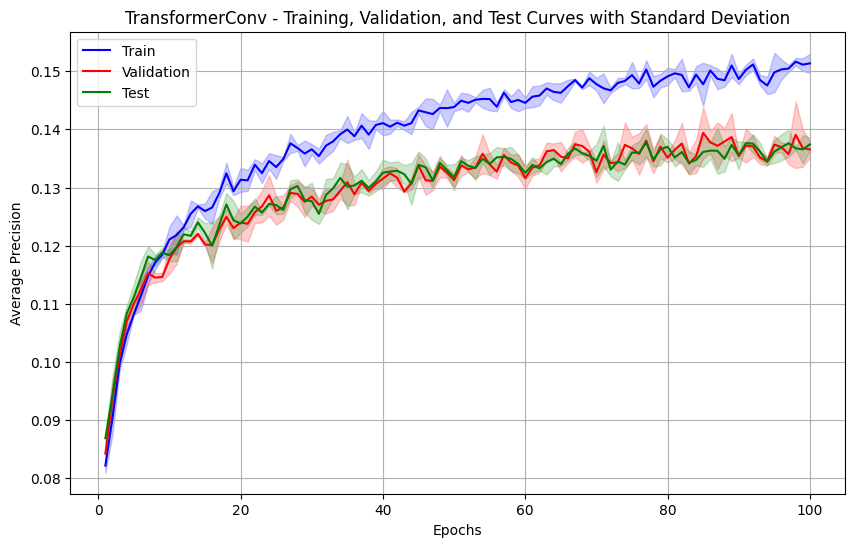

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation for each epoch
train_mean = np.mean(trans_record['train'], axis=0)
valid_mean = np.mean(trans_record['valid'], axis=0)
test_mean = np.mean(trans_record['test'], axis=0)

train_std = np.std(trans_record['train'], axis=0)
valid_std = np.std(trans_record['valid'], axis=0)
test_std = np.std(trans_record['test'], axis=0)

# Plotting
epochs = range(1, len(train_mean) + 1)
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_mean, label='Train', color='blue')
plt.fill_between(epochs, train_mean-train_std, train_mean+train_std, color='blue', alpha=0.2)

plt.plot(epochs, valid_mean, label='Validation', color='red')
plt.fill_between(epochs, valid_mean-valid_std, valid_mean+valid_std, color='red', alpha=0.2)

plt.plot(epochs, test_mean, label='Test', color='green')
plt.fill_between(epochs, test_mean-test_std, test_mean+test_std, color='green', alpha=0.2)

plt.title('TransformerConv - Training, Validation, and Test Curves with Standard Deviation')
plt.xlabel('Epochs')
plt.ylabel('Average Precision')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(trans_record)

{'train': [[0.0827902557111826, 0.09428159082035549, 0.0995983110000509, 0.10376533240677167, 0.1080716321048049, 0.10979616433612772, 0.11557698833082274, 0.11772180234479733, 0.11912918615919443, 0.12369839727597211, 0.1256179811313822, 0.12333484563252056, 0.12858459831002073, 0.12679013712083353, 0.12434827304102761, 0.12908576238795605, 0.1277499126123019, 0.13457123536733198, 0.12845589583777836, 0.13425575453278552, 0.13374154497756754, 0.13527666439257463, 0.13415292266155535, 0.1364349115780142, 0.13547929807321332, 0.13524014924897787, 0.13958205419353412, 0.13748713556975534, 0.1380234509142998, 0.1365553034834407, 0.1350731543551058, 0.13752485734368292, 0.13935467082101335, 0.14006804672458606, 0.14251026710813916, 0.13819155896716026, 0.13922063314389235, 0.14141762804068217, 0.1408470361451098, 0.14401888696070558, 0.13904988594740836, 0.14191242628601314, 0.14011643902495702, 0.14185691625628583, 0.14247519977338471, 0.14618928326042155, 0.1437018892755104, 0.1444529704

In [ ]:
import json
with open('trans_record_new_1e-3_128.json', 'w') as f:
    json.dump(trans_record, f)
from google.colab import files

files.download('trans_record_new.json')

In [ ]:
import time
time.sleep(30)
runtime.unassign()

#### GATv2

In [ ]:
gatv2_record = {'train': [], 'valid': [], 'test': []}

runs = 3

seeds = [42, 2226, 174]

for i in range(runs):
    torch.manual_seed(seeds[i])
    np.random.seed(seeds[i])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seeds[i])
        torch.cuda.manual_seed_all(seeds[i])


    model = GNN(gnn_type = 'gatv2', num_tasks = 128, num_layer = 2, input_dim = 300, emb_dim = 300, drop_ratio = 0.5).to(device)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of trainable parameters: {trainable_params}")

    # optimizer = optim.Adam(model.parameters(), lr=1e-3)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)


    valid_curve = []
    test_curve = []
    train_curve = []

    epochs = 100

    for epoch in range(1, epochs + 1):
        print("=====Epoch {}".format(epoch))
        print('Training...')
        train(model, device, train_loader, optimizer)

        print('Evaluating...')
        train_perf = eval(model, device, train_loader, evaluator)
        valid_perf = eval(model, device, valid_loader, evaluator)
        test_perf = eval(model, device, test_loader, evaluator)

        print({'Train': train_perf, 'Validation': valid_perf, 'Test': test_perf})

        train_curve.append(train_perf['ap'])
        valid_curve.append(valid_perf['ap'])
        test_curve.append(test_perf['ap'])

        best_val_epoch = np.argmax(np.array(valid_curve))
        best_train = max(train_curve)

        print('Finished training!')
        print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
        print('Test score: {}'.format(test_curve[best_val_epoch]))

    print(f"----------------Finished run {i+1}!----------------")

    gatv2_record['train'].append(train_curve)
    gatv2_record['valid'].append(valid_curve)
    gatv2_record['test'].append(test_curve)

Total number of trainable parameters: 638228
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:59<00:00, 23.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:12<00:00, 28.01it/s]


{'Train': {'ap': 0.08237359450368127}, 'Validation': {'ap': 0.08804604355987593}, 'Test': {'ap': 0.08840878935378302}}
Finished training!
Best validation score: 0.08804604355987593
Test score: 0.08840878935378302
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.96it/s]


{'Train': {'ap': 0.09155252437996163}, 'Validation': {'ap': 0.09596785742072603}, 'Test': {'ap': 0.09601153246187083}}
Finished training!
Best validation score: 0.09596785742072603
Test score: 0.09601153246187083
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.04it/s]


{'Train': {'ap': 0.09424572466165798}, 'Validation': {'ap': 0.09739413967711902}, 'Test': {'ap': 0.10086597812363443}}
Finished training!
Best validation score: 0.09739413967711902
Test score: 0.10086597812363443
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.64it/s]


{'Train': {'ap': 0.09759849739368193}, 'Validation': {'ap': 0.10219011558213989}, 'Test': {'ap': 0.09940285684610445}}
Finished training!
Best validation score: 0.10219011558213989
Test score: 0.09940285684610445
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.07it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.90it/s]


{'Train': {'ap': 0.10659073530841401}, 'Validation': {'ap': 0.10339423527023896}, 'Test': {'ap': 0.10543750311242837}}
Finished training!
Best validation score: 0.10339423527023896
Test score: 0.10543750311242837
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.21it/s]


{'Train': {'ap': 0.10587796482061404}, 'Validation': {'ap': 0.10653500468220743}, 'Test': {'ap': 0.10744536764567889}}
Finished training!
Best validation score: 0.10653500468220743
Test score: 0.10744536764567889
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.72it/s]


{'Train': {'ap': 0.10774217070231051}, 'Validation': {'ap': 0.10991184153998626}, 'Test': {'ap': 0.1095974748018042}}
Finished training!
Best validation score: 0.10991184153998626
Test score: 0.1095974748018042
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.00it/s]


{'Train': {'ap': 0.11155127593166039}, 'Validation': {'ap': 0.1107408502406342}, 'Test': {'ap': 0.11155652629910316}}
Finished training!
Best validation score: 0.1107408502406342
Test score: 0.11155652629910316
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.04it/s]


{'Train': {'ap': 0.1118397029590583}, 'Validation': {'ap': 0.11256844810504264}, 'Test': {'ap': 0.11556031950214181}}
Finished training!
Best validation score: 0.11256844810504264
Test score: 0.11556031950214181
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.37it/s]


{'Train': {'ap': 0.11263507167819449}, 'Validation': {'ap': 0.1104991190377593}, 'Test': {'ap': 0.11310942035936382}}
Finished training!
Best validation score: 0.11256844810504264
Test score: 0.11556031950214181
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.47it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.25it/s]


{'Train': {'ap': 0.1153201360698864}, 'Validation': {'ap': 0.11436239963608863}, 'Test': {'ap': 0.11616945440321663}}
Finished training!
Best validation score: 0.11436239963608863
Test score: 0.11616945440321663
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.83it/s]


{'Train': {'ap': 0.11794658719687988}, 'Validation': {'ap': 0.11673114354039538}, 'Test': {'ap': 0.11812278618575792}}
Finished training!
Best validation score: 0.11673114354039538
Test score: 0.11812278618575792
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.27it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.71it/s]


{'Train': {'ap': 0.1218865153202622}, 'Validation': {'ap': 0.11873656329613096}, 'Test': {'ap': 0.11765789112661648}}
Finished training!
Best validation score: 0.11873656329613096
Test score: 0.11765789112661648
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.38it/s]


{'Train': {'ap': 0.12126786037897917}, 'Validation': {'ap': 0.11584363476393468}, 'Test': {'ap': 0.11814655408970814}}
Finished training!
Best validation score: 0.11873656329613096
Test score: 0.11765789112661648
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.29it/s]


{'Train': {'ap': 0.12048155555247954}, 'Validation': {'ap': 0.1168568238379689}, 'Test': {'ap': 0.11644358660458783}}
Finished training!
Best validation score: 0.11873656329613096
Test score: 0.11765789112661648
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.89it/s]


{'Train': {'ap': 0.12414874398818063}, 'Validation': {'ap': 0.11952319872982806}, 'Test': {'ap': 0.12080982589745515}}
Finished training!
Best validation score: 0.11952319872982806
Test score: 0.12080982589745515
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.53it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.15it/s]


{'Train': {'ap': 0.12547306548658158}, 'Validation': {'ap': 0.11945737610017852}, 'Test': {'ap': 0.1230013485024356}}
Finished training!
Best validation score: 0.11952319872982806
Test score: 0.12080982589745515
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.04it/s]


{'Train': {'ap': 0.12220240743431728}, 'Validation': {'ap': 0.12052389817831524}, 'Test': {'ap': 0.1196095708590669}}
Finished training!
Best validation score: 0.12052389817831524
Test score: 0.1196095708590669
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.91it/s]


{'Train': {'ap': 0.12382578508308073}, 'Validation': {'ap': 0.1173079129216349}, 'Test': {'ap': 0.11943787193034867}}
Finished training!
Best validation score: 0.12052389817831524
Test score: 0.1196095708590669
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.29it/s]


{'Train': {'ap': 0.1266612748615557}, 'Validation': {'ap': 0.12153515236104181}, 'Test': {'ap': 0.1250012305503547}}
Finished training!
Best validation score: 0.12153515236104181
Test score: 0.1250012305503547
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.44it/s]


{'Train': {'ap': 0.11999312880719114}, 'Validation': {'ap': 0.11448723437616289}, 'Test': {'ap': 0.11498351163459984}}
Finished training!
Best validation score: 0.12153515236104181
Test score: 0.1250012305503547
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.87it/s]


{'Train': {'ap': 0.12766889129424353}, 'Validation': {'ap': 0.1203854886629117}, 'Test': {'ap': 0.12072390587445343}}
Finished training!
Best validation score: 0.12153515236104181
Test score: 0.1250012305503547
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.72it/s]


{'Train': {'ap': 0.12572516010779503}, 'Validation': {'ap': 0.12479702041883788}, 'Test': {'ap': 0.12554703131518424}}
Finished training!
Best validation score: 0.12479702041883788
Test score: 0.12554703131518424
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.52it/s]


{'Train': {'ap': 0.12836237346979928}, 'Validation': {'ap': 0.12188327048421324}, 'Test': {'ap': 0.12194699453032438}}
Finished training!
Best validation score: 0.12479702041883788
Test score: 0.12554703131518424
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.37it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.57it/s]


{'Train': {'ap': 0.12892877678748815}, 'Validation': {'ap': 0.11932499452645746}, 'Test': {'ap': 0.12226191389344715}}
Finished training!
Best validation score: 0.12479702041883788
Test score: 0.12554703131518424
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.46it/s]


{'Train': {'ap': 0.12803034456900342}, 'Validation': {'ap': 0.11957406604530914}, 'Test': {'ap': 0.12084300237434965}}
Finished training!
Best validation score: 0.12479702041883788
Test score: 0.12554703131518424
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.24it/s]


{'Train': {'ap': 0.1282988100323941}, 'Validation': {'ap': 0.12363460323959875}, 'Test': {'ap': 0.12400761699234354}}
Finished training!
Best validation score: 0.12479702041883788
Test score: 0.12554703131518424
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.23it/s]


{'Train': {'ap': 0.12549125647903953}, 'Validation': {'ap': 0.12193041495688822}, 'Test': {'ap': 0.12549449999412282}}
Finished training!
Best validation score: 0.12479702041883788
Test score: 0.12554703131518424
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.19it/s]


{'Train': {'ap': 0.13054471780529509}, 'Validation': {'ap': 0.12336844575254304}, 'Test': {'ap': 0.12571486854285902}}
Finished training!
Best validation score: 0.12479702041883788
Test score: 0.12554703131518424
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.26it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.18it/s]


{'Train': {'ap': 0.12950062183245545}, 'Validation': {'ap': 0.12268154546235284}, 'Test': {'ap': 0.12463534582996214}}
Finished training!
Best validation score: 0.12479702041883788
Test score: 0.12554703131518424
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.41it/s]


{'Train': {'ap': 0.13042955649385476}, 'Validation': {'ap': 0.12402272119235278}, 'Test': {'ap': 0.12336852505506522}}
Finished training!
Best validation score: 0.12479702041883788
Test score: 0.12554703131518424
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 38.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.38it/s]


{'Train': {'ap': 0.12784411466759177}, 'Validation': {'ap': 0.12443256555241053}, 'Test': {'ap': 0.12504820295013988}}
Finished training!
Best validation score: 0.12479702041883788
Test score: 0.12554703131518424
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.29it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.25it/s]


{'Train': {'ap': 0.13223253185888129}, 'Validation': {'ap': 0.12408876049211345}, 'Test': {'ap': 0.12620527972195875}}
Finished training!
Best validation score: 0.12479702041883788
Test score: 0.12554703131518424
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.07it/s]


{'Train': {'ap': 0.12630684707014608}, 'Validation': {'ap': 0.12192419239133818}, 'Test': {'ap': 0.12264662225474393}}
Finished training!
Best validation score: 0.12479702041883788
Test score: 0.12554703131518424
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.70it/s]


{'Train': {'ap': 0.13245397242831575}, 'Validation': {'ap': 0.12366837853895689}, 'Test': {'ap': 0.12386439002678043}}
Finished training!
Best validation score: 0.12479702041883788
Test score: 0.12554703131518424
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 58.64it/s]


{'Train': {'ap': 0.13043692536281118}, 'Validation': {'ap': 0.1259933268456212}, 'Test': {'ap': 0.1267446319003819}}
Finished training!
Best validation score: 0.1259933268456212
Test score: 0.1267446319003819
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.03it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.77it/s]


{'Train': {'ap': 0.13405224336615196}, 'Validation': {'ap': 0.1263813406799779}, 'Test': {'ap': 0.1258281424030375}}
Finished training!
Best validation score: 0.1263813406799779
Test score: 0.1258281424030375
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.06it/s]


{'Train': {'ap': 0.13121749319915751}, 'Validation': {'ap': 0.1248227023554937}, 'Test': {'ap': 0.12639689761265432}}
Finished training!
Best validation score: 0.1263813406799779
Test score: 0.1258281424030375
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.24it/s]


{'Train': {'ap': 0.12999112669853402}, 'Validation': {'ap': 0.12131144203544846}, 'Test': {'ap': 0.12281791613027025}}
Finished training!
Best validation score: 0.1263813406799779
Test score: 0.1258281424030375
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.85it/s]


{'Train': {'ap': 0.12999018029748777}, 'Validation': {'ap': 0.12483838212973844}, 'Test': {'ap': 0.12491382277822612}}
Finished training!
Best validation score: 0.1263813406799779
Test score: 0.1258281424030375
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.43it/s]


{'Train': {'ap': 0.13166674925302604}, 'Validation': {'ap': 0.12504494786931314}, 'Test': {'ap': 0.12421357832367838}}
Finished training!
Best validation score: 0.1263813406799779
Test score: 0.1258281424030375
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.02it/s]


{'Train': {'ap': 0.133234090300262}, 'Validation': {'ap': 0.12849497936833018}, 'Test': {'ap': 0.12744620522361874}}
Finished training!
Best validation score: 0.12849497936833018
Test score: 0.12744620522361874
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.08it/s]


{'Train': {'ap': 0.13106320793086676}, 'Validation': {'ap': 0.1262106552027658}, 'Test': {'ap': 0.12790233165375223}}
Finished training!
Best validation score: 0.12849497936833018
Test score: 0.12744620522361874
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.33it/s]


{'Train': {'ap': 0.1337836759428278}, 'Validation': {'ap': 0.127837205057385}, 'Test': {'ap': 0.12707509457424657}}
Finished training!
Best validation score: 0.12849497936833018
Test score: 0.12744620522361874
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.57it/s]


{'Train': {'ap': 0.13486953780888167}, 'Validation': {'ap': 0.1275245365798526}, 'Test': {'ap': 0.12760936245384663}}
Finished training!
Best validation score: 0.12849497936833018
Test score: 0.12744620522361874
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.35it/s]


{'Train': {'ap': 0.13263354526234158}, 'Validation': {'ap': 0.12637269728971323}, 'Test': {'ap': 0.12252450319735579}}
Finished training!
Best validation score: 0.12849497936833018
Test score: 0.12744620522361874
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.94it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.54it/s]


{'Train': {'ap': 0.13425984391832732}, 'Validation': {'ap': 0.1271321705142629}, 'Test': {'ap': 0.1252080452559}}
Finished training!
Best validation score: 0.12849497936833018
Test score: 0.12744620522361874
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.44it/s]


{'Train': {'ap': 0.1365420129830423}, 'Validation': {'ap': 0.1254927930049412}, 'Test': {'ap': 0.1278922659083291}}
Finished training!
Best validation score: 0.12849497936833018
Test score: 0.12744620522361874
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.27it/s]


{'Train': {'ap': 0.13321668535424747}, 'Validation': {'ap': 0.12427663488960898}, 'Test': {'ap': 0.1265522793650579}}
Finished training!
Best validation score: 0.12849497936833018
Test score: 0.12744620522361874
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.94it/s]


{'Train': {'ap': 0.13288262462546116}, 'Validation': {'ap': 0.1272830486918167}, 'Test': {'ap': 0.12655330365167752}}
Finished training!
Best validation score: 0.12849497936833018
Test score: 0.12744620522361874
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.46it/s]


{'Train': {'ap': 0.1363534373641078}, 'Validation': {'ap': 0.1289577682799601}, 'Test': {'ap': 0.12897637739068524}}
Finished training!
Best validation score: 0.1289577682799601
Test score: 0.12897637739068524
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.37it/s]


{'Train': {'ap': 0.1340839082729498}, 'Validation': {'ap': 0.1225950745473864}, 'Test': {'ap': 0.12477445052820557}}
Finished training!
Best validation score: 0.1289577682799601
Test score: 0.12897637739068524
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.03it/s]


{'Train': {'ap': 0.13605459038388468}, 'Validation': {'ap': 0.12738408352786745}, 'Test': {'ap': 0.12764225886762856}}
Finished training!
Best validation score: 0.1289577682799601
Test score: 0.12897637739068524
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.96it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.64it/s]


{'Train': {'ap': 0.13590578547596596}, 'Validation': {'ap': 0.12630307430443485}, 'Test': {'ap': 0.12908876206833514}}
Finished training!
Best validation score: 0.1289577682799601
Test score: 0.12897637739068524
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.68it/s]


{'Train': {'ap': 0.13468284664198024}, 'Validation': {'ap': 0.12565854799324677}, 'Test': {'ap': 0.12669981885472772}}
Finished training!
Best validation score: 0.1289577682799601
Test score: 0.12897637739068524
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.27it/s]


{'Train': {'ap': 0.13248456037569778}, 'Validation': {'ap': 0.12670408971621142}, 'Test': {'ap': 0.1259423148805629}}
Finished training!
Best validation score: 0.1289577682799601
Test score: 0.12897637739068524
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.20it/s]


{'Train': {'ap': 0.13379028792536082}, 'Validation': {'ap': 0.12767681294342237}, 'Test': {'ap': 0.12868589997165333}}
Finished training!
Best validation score: 0.1289577682799601
Test score: 0.12897637739068524
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.95it/s]


{'Train': {'ap': 0.13611019097094518}, 'Validation': {'ap': 0.1267197440663059}, 'Test': {'ap': 0.12522383957044436}}
Finished training!
Best validation score: 0.1289577682799601
Test score: 0.12897637739068524
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.72it/s]


{'Train': {'ap': 0.13502217376108175}, 'Validation': {'ap': 0.12610946339601595}, 'Test': {'ap': 0.1273783620084204}}
Finished training!
Best validation score: 0.1289577682799601
Test score: 0.12897637739068524
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.62it/s]


{'Train': {'ap': 0.13694819443698975}, 'Validation': {'ap': 0.12484149120644553}, 'Test': {'ap': 0.12608422121803267}}
Finished training!
Best validation score: 0.1289577682799601
Test score: 0.12897637739068524
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.44it/s]


{'Train': {'ap': 0.1342209563246364}, 'Validation': {'ap': 0.12937198364632743}, 'Test': {'ap': 0.1266795233012}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.70it/s]


{'Train': {'ap': 0.1365815933539723}, 'Validation': {'ap': 0.12492471342937521}, 'Test': {'ap': 0.12595163114138225}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.88it/s]


{'Train': {'ap': 0.1385968805339623}, 'Validation': {'ap': 0.12392142432268513}, 'Test': {'ap': 0.12725631565797443}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.66it/s]


{'Train': {'ap': 0.1351097334293019}, 'Validation': {'ap': 0.12601813497934136}, 'Test': {'ap': 0.1272644177800195}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.42it/s]


{'Train': {'ap': 0.13816637346522412}, 'Validation': {'ap': 0.12818898710835183}, 'Test': {'ap': 0.12875023934729263}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.59it/s]


{'Train': {'ap': 0.13670194325338111}, 'Validation': {'ap': 0.12828239921745888}, 'Test': {'ap': 0.13083296408050413}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.51it/s]


{'Train': {'ap': 0.13567720061089408}, 'Validation': {'ap': 0.1260291369340254}, 'Test': {'ap': 0.12611040754300412}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.90it/s]


{'Train': {'ap': 0.13824419603024776}, 'Validation': {'ap': 0.12761622987296092}, 'Test': {'ap': 0.13042303726957497}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.56it/s]


{'Train': {'ap': 0.134424559058361}, 'Validation': {'ap': 0.12639213232176957}, 'Test': {'ap': 0.12934149993487642}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.03it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.41it/s]


{'Train': {'ap': 0.13808812167776935}, 'Validation': {'ap': 0.1288517671157933}, 'Test': {'ap': 0.1302485410107741}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.47it/s]


{'Train': {'ap': 0.13480990486838693}, 'Validation': {'ap': 0.1279105197507678}, 'Test': {'ap': 0.13070669545873623}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.37it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.76it/s]


{'Train': {'ap': 0.13585445470012203}, 'Validation': {'ap': 0.1257081858477603}, 'Test': {'ap': 0.13000062200711926}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.27it/s]


{'Train': {'ap': 0.13602089458366448}, 'Validation': {'ap': 0.1278789870177522}, 'Test': {'ap': 0.1266723829322766}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.21it/s]


{'Train': {'ap': 0.13775237420104855}, 'Validation': {'ap': 0.1260455478252202}, 'Test': {'ap': 0.12431712450063932}}
Finished training!
Best validation score: 0.12937198364632743
Test score: 0.1266795233012
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.22it/s]


{'Train': {'ap': 0.13632415547331472}, 'Validation': {'ap': 0.13239480549988708}, 'Test': {'ap': 0.13060862821500557}}
Finished training!
Best validation score: 0.13239480549988708
Test score: 0.13060862821500557
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.01it/s]


{'Train': {'ap': 0.13833085558562067}, 'Validation': {'ap': 0.12798470757508723}, 'Test': {'ap': 0.12874421864925514}}
Finished training!
Best validation score: 0.13239480549988708
Test score: 0.13060862821500557
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.93it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.96it/s]


{'Train': {'ap': 0.13773539352723826}, 'Validation': {'ap': 0.12754224441178597}, 'Test': {'ap': 0.12887111068807977}}
Finished training!
Best validation score: 0.13239480549988708
Test score: 0.13060862821500557
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.87it/s]


{'Train': {'ap': 0.13787532053981577}, 'Validation': {'ap': 0.1272125131937453}, 'Test': {'ap': 0.13093605475162817}}
Finished training!
Best validation score: 0.13239480549988708
Test score: 0.13060862821500557
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.49it/s]


{'Train': {'ap': 0.1372824510491022}, 'Validation': {'ap': 0.13024221545809306}, 'Test': {'ap': 0.12886966276181186}}
Finished training!
Best validation score: 0.13239480549988708
Test score: 0.13060862821500557
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.51it/s]


{'Train': {'ap': 0.1394473523993021}, 'Validation': {'ap': 0.1288548523567569}, 'Test': {'ap': 0.1325237936118221}}
Finished training!
Best validation score: 0.13239480549988708
Test score: 0.13060862821500557
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.54it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.23it/s]


{'Train': {'ap': 0.14144731748423392}, 'Validation': {'ap': 0.12966623699102375}, 'Test': {'ap': 0.13007653330534702}}
Finished training!
Best validation score: 0.13239480549988708
Test score: 0.13060862821500557
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.70it/s]


{'Train': {'ap': 0.1395062027931605}, 'Validation': {'ap': 0.13076463315898135}, 'Test': {'ap': 0.1317478894043918}}
Finished training!
Best validation score: 0.13239480549988708
Test score: 0.13060862821500557
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 58.31it/s]


{'Train': {'ap': 0.13883723357173713}, 'Validation': {'ap': 0.12876415915549316}, 'Test': {'ap': 0.13157464169045807}}
Finished training!
Best validation score: 0.13239480549988708
Test score: 0.13060862821500557
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.44it/s]


{'Train': {'ap': 0.1368028745687173}, 'Validation': {'ap': 0.1256211671657714}, 'Test': {'ap': 0.12675444927419469}}
Finished training!
Best validation score: 0.13239480549988708
Test score: 0.13060862821500557
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.33it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.33it/s]


{'Train': {'ap': 0.1396728892751079}, 'Validation': {'ap': 0.12939249075559664}, 'Test': {'ap': 0.13070149923891616}}
Finished training!
Best validation score: 0.13239480549988708
Test score: 0.13060862821500557
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.07it/s]


{'Train': {'ap': 0.13807785264349967}, 'Validation': {'ap': 0.1283683734869182}, 'Test': {'ap': 0.12859648828688175}}
Finished training!
Best validation score: 0.13239480549988708
Test score: 0.13060862821500557
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.31it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.11it/s]


{'Train': {'ap': 0.14089341226739938}, 'Validation': {'ap': 0.12573853752418523}, 'Test': {'ap': 0.1312541740002164}}
Finished training!
Best validation score: 0.13239480549988708
Test score: 0.13060862821500557
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.27it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.40it/s]


{'Train': {'ap': 0.13970709434478545}, 'Validation': {'ap': 0.13397537320442093}, 'Test': {'ap': 0.13008089531024705}}
Finished training!
Best validation score: 0.13397537320442093
Test score: 0.13008089531024705
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.63it/s]


{'Train': {'ap': 0.14011883149203613}, 'Validation': {'ap': 0.12830551166356716}, 'Test': {'ap': 0.1310798327727001}}
Finished training!
Best validation score: 0.13397537320442093
Test score: 0.13008089531024705
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.92it/s]


{'Train': {'ap': 0.14123941933112794}, 'Validation': {'ap': 0.1292228312872878}, 'Test': {'ap': 0.12998433051220068}}
Finished training!
Best validation score: 0.13397537320442093
Test score: 0.13008089531024705
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.09it/s]


{'Train': {'ap': 0.13942911628191995}, 'Validation': {'ap': 0.1277853177550262}, 'Test': {'ap': 0.13071358494210222}}
Finished training!
Best validation score: 0.13397537320442093
Test score: 0.13008089531024705
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.89it/s]


{'Train': {'ap': 0.1360882165104919}, 'Validation': {'ap': 0.12739653840725768}, 'Test': {'ap': 0.12931090070839552}}
Finished training!
Best validation score: 0.13397537320442093
Test score: 0.13008089531024705
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.76it/s]


{'Train': {'ap': 0.14037620122841998}, 'Validation': {'ap': 0.13370896203596078}, 'Test': {'ap': 0.12912401521221292}}
Finished training!
Best validation score: 0.13397537320442093
Test score: 0.13008089531024705
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.32it/s]


{'Train': {'ap': 0.1390643367867427}, 'Validation': {'ap': 0.12849957534938583}, 'Test': {'ap': 0.131776682532046}}
Finished training!
Best validation score: 0.13397537320442093
Test score: 0.13008089531024705
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.16it/s]


{'Train': {'ap': 0.13679371641410729}, 'Validation': {'ap': 0.12618481646068652}, 'Test': {'ap': 0.12987649891526232}}
Finished training!
Best validation score: 0.13397537320442093
Test score: 0.13008089531024705
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.33it/s]


{'Train': {'ap': 0.13926618518740663}, 'Validation': {'ap': 0.1276262532927956}, 'Test': {'ap': 0.12920241457038645}}
Finished training!
Best validation score: 0.13397537320442093
Test score: 0.13008089531024705
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.29it/s]


{'Train': {'ap': 0.13804723717514014}, 'Validation': {'ap': 0.12860335488291622}, 'Test': {'ap': 0.1299406344264605}}
Finished training!
Best validation score: 0.13397537320442093
Test score: 0.13008089531024705
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.69it/s]


{'Train': {'ap': 0.13544223976131758}, 'Validation': {'ap': 0.12520560409346052}, 'Test': {'ap': 0.12571112720874353}}
Finished training!
Best validation score: 0.13397537320442093
Test score: 0.13008089531024705
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.11it/s]


{'Train': {'ap': 0.13352688776539762}, 'Validation': {'ap': 0.12363824621054724}, 'Test': {'ap': 0.12483014411732543}}
Finished training!
Best validation score: 0.13397537320442093
Test score: 0.13008089531024705
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.47it/s]


{'Train': {'ap': 0.1422825379094395}, 'Validation': {'ap': 0.13197483457364403}, 'Test': {'ap': 0.13124402828357487}}
Finished training!
Best validation score: 0.13397537320442093
Test score: 0.13008089531024705
----------------Finished run 1!----------------
Total number of trainable parameters: 638228
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.31it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.34it/s]


{'Train': {'ap': 0.07358518212101653}, 'Validation': {'ap': 0.07974789231381615}, 'Test': {'ap': 0.08256196300293868}}
Finished training!
Best validation score: 0.07974789231381615
Test score: 0.08256196300293868
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.34it/s]


{'Train': {'ap': 0.08430586885575227}, 'Validation': {'ap': 0.09320365117862525}, 'Test': {'ap': 0.09279199060050959}}
Finished training!
Best validation score: 0.09320365117862525
Test score: 0.09279199060050959
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.16it/s]


{'Train': {'ap': 0.09432877667671394}, 'Validation': {'ap': 0.09422532684173217}, 'Test': {'ap': 0.09722230084690563}}
Finished training!
Best validation score: 0.09422532684173217
Test score: 0.09722230084690563
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.47it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.15it/s]


{'Train': {'ap': 0.09891902385619711}, 'Validation': {'ap': 0.10247664410674233}, 'Test': {'ap': 0.10471046025359908}}
Finished training!
Best validation score: 0.10247664410674233
Test score: 0.10471046025359908
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.56it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.73it/s]


{'Train': {'ap': 0.10195145062675784}, 'Validation': {'ap': 0.10396384102523243}, 'Test': {'ap': 0.10690079409717303}}
Finished training!
Best validation score: 0.10396384102523243
Test score: 0.10690079409717303
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.33it/s]


{'Train': {'ap': 0.10864631613366779}, 'Validation': {'ap': 0.11109765674859653}, 'Test': {'ap': 0.11252036997534595}}
Finished training!
Best validation score: 0.11109765674859653
Test score: 0.11252036997534595
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.29it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.06it/s]


{'Train': {'ap': 0.10962150725097351}, 'Validation': {'ap': 0.10965223069380654}, 'Test': {'ap': 0.11122134775409032}}
Finished training!
Best validation score: 0.11109765674859653
Test score: 0.11252036997534595
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.43it/s]


{'Train': {'ap': 0.10983952180822856}, 'Validation': {'ap': 0.11198723328150603}, 'Test': {'ap': 0.11606114702653966}}
Finished training!
Best validation score: 0.11198723328150603
Test score: 0.11606114702653966
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.48it/s]


{'Train': {'ap': 0.11193232024757323}, 'Validation': {'ap': 0.11051313330206}, 'Test': {'ap': 0.11441747386347889}}
Finished training!
Best validation score: 0.11198723328150603
Test score: 0.11606114702653966
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.50it/s]


{'Train': {'ap': 0.11697637475492015}, 'Validation': {'ap': 0.11439125207406385}, 'Test': {'ap': 0.11705453081454117}}
Finished training!
Best validation score: 0.11439125207406385
Test score: 0.11705453081454117
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.26it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.58it/s]


{'Train': {'ap': 0.11504249948117104}, 'Validation': {'ap': 0.11647902443038805}, 'Test': {'ap': 0.11813248541000039}}
Finished training!
Best validation score: 0.11647902443038805
Test score: 0.11813248541000039
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.51it/s]


{'Train': {'ap': 0.11560503455203493}, 'Validation': {'ap': 0.11406376026429918}, 'Test': {'ap': 0.11475487700459752}}
Finished training!
Best validation score: 0.11647902443038805
Test score: 0.11813248541000039
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.61it/s]


{'Train': {'ap': 0.11830709709764456}, 'Validation': {'ap': 0.11702961842259646}, 'Test': {'ap': 0.1193618940124159}}
Finished training!
Best validation score: 0.11702961842259646
Test score: 0.1193618940124159
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.68it/s]


{'Train': {'ap': 0.12287892777989681}, 'Validation': {'ap': 0.12083464944275905}, 'Test': {'ap': 0.12219521917787837}}
Finished training!
Best validation score: 0.12083464944275905
Test score: 0.12219521917787837
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.90it/s]


{'Train': {'ap': 0.12421222095206297}, 'Validation': {'ap': 0.12056792012140638}, 'Test': {'ap': 0.12355118225891361}}
Finished training!
Best validation score: 0.12083464944275905
Test score: 0.12219521917787837
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.99it/s]


{'Train': {'ap': 0.1228726494150748}, 'Validation': {'ap': 0.11790637252146599}, 'Test': {'ap': 0.11777064275607155}}
Finished training!
Best validation score: 0.12083464944275905
Test score: 0.12219521917787837
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.78it/s]


{'Train': {'ap': 0.12406924961022646}, 'Validation': {'ap': 0.12013958030097383}, 'Test': {'ap': 0.1228475900265633}}
Finished training!
Best validation score: 0.12083464944275905
Test score: 0.12219521917787837
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.29it/s]


{'Train': {'ap': 0.1233316489617993}, 'Validation': {'ap': 0.11896545030690248}, 'Test': {'ap': 0.11970041756533774}}
Finished training!
Best validation score: 0.12083464944275905
Test score: 0.12219521917787837
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 59.20it/s]


{'Train': {'ap': 0.12546744807527818}, 'Validation': {'ap': 0.1202972691191868}, 'Test': {'ap': 0.12252189570018703}}
Finished training!
Best validation score: 0.12083464944275905
Test score: 0.12219521917787837
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.54it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.50it/s]


{'Train': {'ap': 0.1231593278751742}, 'Validation': {'ap': 0.1196725837497051}, 'Test': {'ap': 0.12050402724340693}}
Finished training!
Best validation score: 0.12083464944275905
Test score: 0.12219521917787837
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.01it/s]


{'Train': {'ap': 0.12405414374733878}, 'Validation': {'ap': 0.1206191692521696}, 'Test': {'ap': 0.12276770841879668}}
Finished training!
Best validation score: 0.12083464944275905
Test score: 0.12219521917787837
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.29it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.62it/s]


{'Train': {'ap': 0.12285390534641925}, 'Validation': {'ap': 0.11703501940302695}, 'Test': {'ap': 0.12176255264884402}}
Finished training!
Best validation score: 0.12083464944275905
Test score: 0.12219521917787837
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.98it/s]


{'Train': {'ap': 0.12616220265792868}, 'Validation': {'ap': 0.11919276171970465}, 'Test': {'ap': 0.12168914677459994}}
Finished training!
Best validation score: 0.12083464944275905
Test score: 0.12219521917787837
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.01it/s]


{'Train': {'ap': 0.12719029950343044}, 'Validation': {'ap': 0.12068928613528969}, 'Test': {'ap': 0.1222622562470583}}
Finished training!
Best validation score: 0.12083464944275905
Test score: 0.12219521917787837
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.79it/s]


{'Train': {'ap': 0.12612581015995347}, 'Validation': {'ap': 0.12053772794228952}, 'Test': {'ap': 0.1221927800690559}}
Finished training!
Best validation score: 0.12083464944275905
Test score: 0.12219521917787837
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.76it/s]


{'Train': {'ap': 0.12547750277085087}, 'Validation': {'ap': 0.1221622013900498}, 'Test': {'ap': 0.12469043012722132}}
Finished training!
Best validation score: 0.1221622013900498
Test score: 0.12469043012722132
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.43it/s]


{'Train': {'ap': 0.13105053754802476}, 'Validation': {'ap': 0.12144320938317264}, 'Test': {'ap': 0.12289609288247738}}
Finished training!
Best validation score: 0.1221622013900498
Test score: 0.12469043012722132
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.65it/s]


{'Train': {'ap': 0.1270921766748766}, 'Validation': {'ap': 0.12380572563213377}, 'Test': {'ap': 0.12577088784379614}}
Finished training!
Best validation score: 0.12380572563213377
Test score: 0.12577088784379614
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.78it/s]


{'Train': {'ap': 0.1311747011493638}, 'Validation': {'ap': 0.12460360036524265}, 'Test': {'ap': 0.12831791589863015}}
Finished training!
Best validation score: 0.12460360036524265
Test score: 0.12831791589863015
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.59it/s]


{'Train': {'ap': 0.13007786241325442}, 'Validation': {'ap': 0.1253653448682175}, 'Test': {'ap': 0.12694780849452117}}
Finished training!
Best validation score: 0.1253653448682175
Test score: 0.12694780849452117
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.97it/s]


{'Train': {'ap': 0.13078843637587712}, 'Validation': {'ap': 0.12194764994649165}, 'Test': {'ap': 0.1245583774501114}}
Finished training!
Best validation score: 0.1253653448682175
Test score: 0.12694780849452117
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.03it/s]


{'Train': {'ap': 0.12655953664901126}, 'Validation': {'ap': 0.12140773510363025}, 'Test': {'ap': 0.12364519767100715}}
Finished training!
Best validation score: 0.1253653448682175
Test score: 0.12694780849452117
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.54it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.28it/s]


{'Train': {'ap': 0.13420531087011858}, 'Validation': {'ap': 0.12529076408190906}, 'Test': {'ap': 0.12607960996585396}}
Finished training!
Best validation score: 0.1253653448682175
Test score: 0.12694780849452117
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.99it/s]


{'Train': {'ap': 0.1310387378945146}, 'Validation': {'ap': 0.12310087554164956}, 'Test': {'ap': 0.1261516868913031}}
Finished training!
Best validation score: 0.1253653448682175
Test score: 0.12694780849452117
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.37it/s]


{'Train': {'ap': 0.13116750953378992}, 'Validation': {'ap': 0.12491858693002825}, 'Test': {'ap': 0.12506876442902004}}
Finished training!
Best validation score: 0.1253653448682175
Test score: 0.12694780849452117
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.09it/s]


{'Train': {'ap': 0.13046541066513326}, 'Validation': {'ap': 0.12480364533839904}, 'Test': {'ap': 0.1269860185825116}}
Finished training!
Best validation score: 0.1253653448682175
Test score: 0.12694780849452117
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.80it/s]


{'Train': {'ap': 0.13115968412468942}, 'Validation': {'ap': 0.1233671559613732}, 'Test': {'ap': 0.12540601425901124}}
Finished training!
Best validation score: 0.1253653448682175
Test score: 0.12694780849452117
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.99it/s]


{'Train': {'ap': 0.13328801232955895}, 'Validation': {'ap': 0.12754724286777244}, 'Test': {'ap': 0.1269478263183103}}
Finished training!
Best validation score: 0.12754724286777244
Test score: 0.1269478263183103
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.01it/s]


{'Train': {'ap': 0.13277686201506642}, 'Validation': {'ap': 0.12743375348418834}, 'Test': {'ap': 0.12793431716909717}}
Finished training!
Best validation score: 0.12754724286777244
Test score: 0.1269478263183103
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.56it/s]


{'Train': {'ap': 0.13489035897524498}, 'Validation': {'ap': 0.12690068729692225}, 'Test': {'ap': 0.1278885611301576}}
Finished training!
Best validation score: 0.12754724286777244
Test score: 0.1269478263183103
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.29it/s]


{'Train': {'ap': 0.1320892016667824}, 'Validation': {'ap': 0.12504008446019266}, 'Test': {'ap': 0.1247774579197061}}
Finished training!
Best validation score: 0.12754724286777244
Test score: 0.1269478263183103
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.91it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.59it/s]


{'Train': {'ap': 0.13282593857419778}, 'Validation': {'ap': 0.12301224488304528}, 'Test': {'ap': 0.12543291639888873}}
Finished training!
Best validation score: 0.12754724286777244
Test score: 0.1269478263183103
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.97it/s]


{'Train': {'ap': 0.13284569438477464}, 'Validation': {'ap': 0.12410724557622983}, 'Test': {'ap': 0.12409897995164088}}
Finished training!
Best validation score: 0.12754724286777244
Test score: 0.1269478263183103
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.07it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.74it/s]


{'Train': {'ap': 0.1340355198961231}, 'Validation': {'ap': 0.12742475345023555}, 'Test': {'ap': 0.12641051931544137}}
Finished training!
Best validation score: 0.12754724286777244
Test score: 0.1269478263183103
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.90it/s]


{'Train': {'ap': 0.13089018944179165}, 'Validation': {'ap': 0.12150362452644335}, 'Test': {'ap': 0.1234242321531113}}
Finished training!
Best validation score: 0.12754724286777244
Test score: 0.1269478263183103
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.31it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.52it/s]


{'Train': {'ap': 0.1335545867969535}, 'Validation': {'ap': 0.12524300043621697}, 'Test': {'ap': 0.12492790043698089}}
Finished training!
Best validation score: 0.12754724286777244
Test score: 0.1269478263183103
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.03it/s]


{'Train': {'ap': 0.13677937137705193}, 'Validation': {'ap': 0.12677968698974518}, 'Test': {'ap': 0.12764981819963672}}
Finished training!
Best validation score: 0.12754724286777244
Test score: 0.1269478263183103
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.97it/s]


{'Train': {'ap': 0.13681912722462108}, 'Validation': {'ap': 0.12831767165968583}, 'Test': {'ap': 0.12921363901869914}}
Finished training!
Best validation score: 0.12831767165968583
Test score: 0.12921363901869914
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.84it/s]


{'Train': {'ap': 0.13491512113369494}, 'Validation': {'ap': 0.12356413084668925}, 'Test': {'ap': 0.12473744561284095}}
Finished training!
Best validation score: 0.12831767165968583
Test score: 0.12921363901869914
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.92it/s]


{'Train': {'ap': 0.13622755590684238}, 'Validation': {'ap': 0.12492042076434134}, 'Test': {'ap': 0.12611480838779424}}
Finished training!
Best validation score: 0.12831767165968583
Test score: 0.12921363901869914
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.59it/s]


{'Train': {'ap': 0.13523970357616397}, 'Validation': {'ap': 0.1259887399205024}, 'Test': {'ap': 0.1262488211017616}}
Finished training!
Best validation score: 0.12831767165968583
Test score: 0.12921363901869914
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.16it/s]


{'Train': {'ap': 0.13730309812149935}, 'Validation': {'ap': 0.12721145677088322}, 'Test': {'ap': 0.12791066576524354}}
Finished training!
Best validation score: 0.12831767165968583
Test score: 0.12921363901869914
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.96it/s]


{'Train': {'ap': 0.13492051423258763}, 'Validation': {'ap': 0.1244250151757286}, 'Test': {'ap': 0.12570504827711482}}
Finished training!
Best validation score: 0.12831767165968583
Test score: 0.12921363901869914
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.47it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.81it/s]


{'Train': {'ap': 0.1338017995191167}, 'Validation': {'ap': 0.1233311250664618}, 'Test': {'ap': 0.12764609208212696}}
Finished training!
Best validation score: 0.12831767165968583
Test score: 0.12921363901869914
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.92it/s]


{'Train': {'ap': 0.13820082014248197}, 'Validation': {'ap': 0.12862858211277237}, 'Test': {'ap': 0.12961468564262912}}
Finished training!
Best validation score: 0.12862858211277237
Test score: 0.12961468564262912
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.83it/s]


{'Train': {'ap': 0.13617360591617655}, 'Validation': {'ap': 0.12472131131706829}, 'Test': {'ap': 0.12638925917658686}}
Finished training!
Best validation score: 0.12862858211277237
Test score: 0.12961468564262912
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.08it/s]


{'Train': {'ap': 0.1359325163091885}, 'Validation': {'ap': 0.1284145927234909}, 'Test': {'ap': 0.12931266887060933}}
Finished training!
Best validation score: 0.12862858211277237
Test score: 0.12961468564262912
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.33it/s]


{'Train': {'ap': 0.13354933246846137}, 'Validation': {'ap': 0.12599712860717757}, 'Test': {'ap': 0.12707345160077121}}
Finished training!
Best validation score: 0.12862858211277237
Test score: 0.12961468564262912
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.97it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.72it/s]


{'Train': {'ap': 0.13706091758908737}, 'Validation': {'ap': 0.12535680542909824}, 'Test': {'ap': 0.12692367243310398}}
Finished training!
Best validation score: 0.12862858211277237
Test score: 0.12961468564262912
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.57it/s]


{'Train': {'ap': 0.13618118979252683}, 'Validation': {'ap': 0.12684508683394233}, 'Test': {'ap': 0.13070725023390758}}
Finished training!
Best validation score: 0.12862858211277237
Test score: 0.12961468564262912
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.03it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.95it/s]


{'Train': {'ap': 0.13668118339195293}, 'Validation': {'ap': 0.12632456227603758}, 'Test': {'ap': 0.12729618487964187}}
Finished training!
Best validation score: 0.12862858211277237
Test score: 0.12961468564262912
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.82it/s]


{'Train': {'ap': 0.13602803893484403}, 'Validation': {'ap': 0.12579412212184185}, 'Test': {'ap': 0.12738409460125066}}
Finished training!
Best validation score: 0.12862858211277237
Test score: 0.12961468564262912
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.83it/s]


{'Train': {'ap': 0.1389413209092625}, 'Validation': {'ap': 0.1273421674014871}, 'Test': {'ap': 0.12880241619153926}}
Finished training!
Best validation score: 0.12862858211277237
Test score: 0.12961468564262912
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.23it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.36it/s]


{'Train': {'ap': 0.13733365543208667}, 'Validation': {'ap': 0.12754223439140536}, 'Test': {'ap': 0.13039152803977386}}
Finished training!
Best validation score: 0.12862858211277237
Test score: 0.12961468564262912
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.94it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.48it/s]


{'Train': {'ap': 0.13676393362201125}, 'Validation': {'ap': 0.12481414711609415}, 'Test': {'ap': 0.1285810151840268}}
Finished training!
Best validation score: 0.12862858211277237
Test score: 0.12961468564262912
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.82it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.12it/s]


{'Train': {'ap': 0.1358670709107616}, 'Validation': {'ap': 0.1279841456881946}, 'Test': {'ap': 0.1296256882613299}}
Finished training!
Best validation score: 0.12862858211277237
Test score: 0.12961468564262912
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.03it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.04it/s]


{'Train': {'ap': 0.1350728634976055}, 'Validation': {'ap': 0.1306347139045632}, 'Test': {'ap': 0.1303721624244703}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.07it/s]


{'Train': {'ap': 0.13946662498376433}, 'Validation': {'ap': 0.12627236573089434}, 'Test': {'ap': 0.12842649279074636}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.96it/s]


{'Train': {'ap': 0.13791732145627392}, 'Validation': {'ap': 0.12963694691849642}, 'Test': {'ap': 0.13072037667188652}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.56it/s]


{'Train': {'ap': 0.13591046183557715}, 'Validation': {'ap': 0.12731505406055013}, 'Test': {'ap': 0.12888206941442135}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.38it/s]


{'Train': {'ap': 0.13736021569171097}, 'Validation': {'ap': 0.12633901116174232}, 'Test': {'ap': 0.12746479006668582}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.73it/s]


{'Train': {'ap': 0.1364757470632119}, 'Validation': {'ap': 0.12873059470550252}, 'Test': {'ap': 0.13078649914785834}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.54it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.72it/s]


{'Train': {'ap': 0.1343801114276028}, 'Validation': {'ap': 0.1286277512383488}, 'Test': {'ap': 0.12521786623012773}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.26it/s]


{'Train': {'ap': 0.13975959739043184}, 'Validation': {'ap': 0.13002072046190463}, 'Test': {'ap': 0.13112851415997442}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.93it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.05it/s]


{'Train': {'ap': 0.14103645571509119}, 'Validation': {'ap': 0.12957379859700627}, 'Test': {'ap': 0.13280152692295968}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.16it/s]


{'Train': {'ap': 0.14015268557505814}, 'Validation': {'ap': 0.12832808839979332}, 'Test': {'ap': 0.13053616135825252}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.99it/s]


{'Train': {'ap': 0.14071913489868687}, 'Validation': {'ap': 0.129492440847443}, 'Test': {'ap': 0.13057494541181738}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.60it/s]


{'Train': {'ap': 0.140092757087164}, 'Validation': {'ap': 0.12934113443497783}, 'Test': {'ap': 0.12972703577427203}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.31it/s]


{'Train': {'ap': 0.13782266475985125}, 'Validation': {'ap': 0.12830740112305197}, 'Test': {'ap': 0.13019164837920588}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.10it/s]


{'Train': {'ap': 0.14112415193597272}, 'Validation': {'ap': 0.1301064725739141}, 'Test': {'ap': 0.13085286394463494}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.48it/s]


{'Train': {'ap': 0.13323763677826908}, 'Validation': {'ap': 0.12386493121961026}, 'Test': {'ap': 0.12701106060961884}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.93it/s]


{'Train': {'ap': 0.14016506056602476}, 'Validation': {'ap': 0.12790577638043613}, 'Test': {'ap': 0.1287634721424413}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.28it/s]


{'Train': {'ap': 0.13795969644446116}, 'Validation': {'ap': 0.12225845871757933}, 'Test': {'ap': 0.12620034259222002}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.65it/s]


{'Train': {'ap': 0.1390760736152226}, 'Validation': {'ap': 0.12345134554523725}, 'Test': {'ap': 0.127771547650561}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.12it/s]


{'Train': {'ap': 0.13890220741505732}, 'Validation': {'ap': 0.12905498917530953}, 'Test': {'ap': 0.128992968993528}}
Finished training!
Best validation score: 0.1306347139045632
Test score: 0.1303721624244703
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.74it/s]


{'Train': {'ap': 0.1435802384671275}, 'Validation': {'ap': 0.130639141962248}, 'Test': {'ap': 0.1302165189098139}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.53it/s]


{'Train': {'ap': 0.1389742860100696}, 'Validation': {'ap': 0.13032534297481957}, 'Test': {'ap': 0.13163202568207472}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.37it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.42it/s]


{'Train': {'ap': 0.1418802961856872}, 'Validation': {'ap': 0.1280095762103198}, 'Test': {'ap': 0.13096823308426767}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.99it/s]


{'Train': {'ap': 0.1381933196438195}, 'Validation': {'ap': 0.12828785882793864}, 'Test': {'ap': 0.12831366005416325}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.07it/s]


{'Train': {'ap': 0.13362965078206293}, 'Validation': {'ap': 0.12512258539826718}, 'Test': {'ap': 0.1282851458061}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.95it/s]


{'Train': {'ap': 0.1388892531873004}, 'Validation': {'ap': 0.12828123366195693}, 'Test': {'ap': 0.13081187139011832}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.95it/s]


{'Train': {'ap': 0.13794316448880256}, 'Validation': {'ap': 0.12732122488499872}, 'Test': {'ap': 0.12975335256544043}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.48it/s]


{'Train': {'ap': 0.1396208787627429}, 'Validation': {'ap': 0.12869829080976797}, 'Test': {'ap': 0.13027365050950823}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.54it/s]


{'Train': {'ap': 0.13788221961337999}, 'Validation': {'ap': 0.12423652157828491}, 'Test': {'ap': 0.12688540328437534}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.74it/s]


{'Train': {'ap': 0.14163361803844118}, 'Validation': {'ap': 0.12724034806853712}, 'Test': {'ap': 0.12868350023797842}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.13it/s]


{'Train': {'ap': 0.1400203434757757}, 'Validation': {'ap': 0.12842192144495218}, 'Test': {'ap': 0.128590848765151}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.05it/s]


{'Train': {'ap': 0.13932583350047406}, 'Validation': {'ap': 0.12689518195708516}, 'Test': {'ap': 0.12856565030927403}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.55it/s]


{'Train': {'ap': 0.14107032407757258}, 'Validation': {'ap': 0.12859473714913933}, 'Test': {'ap': 0.12995700270893132}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 38.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.01it/s]


{'Train': {'ap': 0.1406298301844436}, 'Validation': {'ap': 0.13035589666576886}, 'Test': {'ap': 0.13056458104901222}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.26it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.17it/s]


{'Train': {'ap': 0.13979755475182287}, 'Validation': {'ap': 0.12984781688765226}, 'Test': {'ap': 0.13131089490012776}}
Finished training!
Best validation score: 0.130639141962248
Test score: 0.1302165189098139
----------------Finished run 2!----------------
Total number of trainable parameters: 638228
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 38.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.17it/s]


{'Train': {'ap': 0.07912152401135693}, 'Validation': {'ap': 0.085190186523787}, 'Test': {'ap': 0.08763898159908577}}
Finished training!
Best validation score: 0.085190186523787
Test score: 0.08763898159908577
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.44it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 57.51it/s]


{'Train': {'ap': 0.08922396827280994}, 'Validation': {'ap': 0.08778006406044872}, 'Test': {'ap': 0.09140554710746764}}
Finished training!
Best validation score: 0.08778006406044872
Test score: 0.09140554710746764
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.78it/s]


{'Train': {'ap': 0.09224936522004464}, 'Validation': {'ap': 0.09529296588428389}, 'Test': {'ap': 0.09620950172038135}}
Finished training!
Best validation score: 0.09529296588428389
Test score: 0.09620950172038135
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.56it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.69it/s]


{'Train': {'ap': 0.09814992373668373}, 'Validation': {'ap': 0.10231616365673105}, 'Test': {'ap': 0.10266458222124537}}
Finished training!
Best validation score: 0.10231616365673105
Test score: 0.10266458222124537
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.60it/s]


{'Train': {'ap': 0.10199936035606601}, 'Validation': {'ap': 0.1062891026686203}, 'Test': {'ap': 0.10725359676581492}}
Finished training!
Best validation score: 0.1062891026686203
Test score: 0.10725359676581492
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.92it/s]


{'Train': {'ap': 0.10564069640266154}, 'Validation': {'ap': 0.1089173893101538}, 'Test': {'ap': 0.11103080474809984}}
Finished training!
Best validation score: 0.1089173893101538
Test score: 0.11103080474809984
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.61it/s]


{'Train': {'ap': 0.10771850524498706}, 'Validation': {'ap': 0.10763169356978097}, 'Test': {'ap': 0.10833728763451417}}
Finished training!
Best validation score: 0.1089173893101538
Test score: 0.11103080474809984
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.71it/s]


{'Train': {'ap': 0.1122980186767952}, 'Validation': {'ap': 0.11041802554174775}, 'Test': {'ap': 0.11307018898649676}}
Finished training!
Best validation score: 0.11041802554174775
Test score: 0.11307018898649676
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.60it/s]


{'Train': {'ap': 0.11183592427435846}, 'Validation': {'ap': 0.1115046192484917}, 'Test': {'ap': 0.11352569499761288}}
Finished training!
Best validation score: 0.1115046192484917
Test score: 0.11352569499761288
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.64it/s]


{'Train': {'ap': 0.11438520858111013}, 'Validation': {'ap': 0.11215275353855546}, 'Test': {'ap': 0.11363027159579953}}
Finished training!
Best validation score: 0.11215275353855546
Test score: 0.11363027159579953
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 37.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.85it/s]


{'Train': {'ap': 0.11582216604992898}, 'Validation': {'ap': 0.11540432529816645}, 'Test': {'ap': 0.11649105630644825}}
Finished training!
Best validation score: 0.11540432529816645
Test score: 0.11649105630644825
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.97it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.83it/s]


{'Train': {'ap': 0.11405778146343706}, 'Validation': {'ap': 0.11409539937297095}, 'Test': {'ap': 0.11663018552827394}}
Finished training!
Best validation score: 0.11540432529816645
Test score: 0.11649105630644825
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.22it/s]


{'Train': {'ap': 0.11561370049496679}, 'Validation': {'ap': 0.11769833355876083}, 'Test': {'ap': 0.11843499100496117}}
Finished training!
Best validation score: 0.11769833355876083
Test score: 0.11843499100496117
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.77it/s]


{'Train': {'ap': 0.12015202690707404}, 'Validation': {'ap': 0.11786716153887011}, 'Test': {'ap': 0.11900530144335167}}
Finished training!
Best validation score: 0.11786716153887011
Test score: 0.11900530144335167
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.10it/s]


{'Train': {'ap': 0.11964839504165176}, 'Validation': {'ap': 0.11805022843326986}, 'Test': {'ap': 0.12039146767449273}}
Finished training!
Best validation score: 0.11805022843326986
Test score: 0.12039146767449273
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.05it/s]


{'Train': {'ap': 0.12115314506302664}, 'Validation': {'ap': 0.11912258525725801}, 'Test': {'ap': 0.11987161657200422}}
Finished training!
Best validation score: 0.11912258525725801
Test score: 0.11987161657200422
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.98it/s]


{'Train': {'ap': 0.12225296682719472}, 'Validation': {'ap': 0.11640292848327784}, 'Test': {'ap': 0.1195358702767123}}
Finished training!
Best validation score: 0.11912258525725801
Test score: 0.11987161657200422
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.03it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.75it/s]


{'Train': {'ap': 0.11463338932478595}, 'Validation': {'ap': 0.1118334776883772}, 'Test': {'ap': 0.11248089221900082}}
Finished training!
Best validation score: 0.11912258525725801
Test score: 0.11987161657200422
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.85it/s]


{'Train': {'ap': 0.12338352450442343}, 'Validation': {'ap': 0.11911387512721038}, 'Test': {'ap': 0.1217483016804663}}
Finished training!
Best validation score: 0.11912258525725801
Test score: 0.11987161657200422
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.23it/s]


{'Train': {'ap': 0.12539182906767662}, 'Validation': {'ap': 0.12157964437968838}, 'Test': {'ap': 0.1225798591004188}}
Finished training!
Best validation score: 0.12157964437968838
Test score: 0.1225798591004188
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.46it/s]


{'Train': {'ap': 0.1274765758993392}, 'Validation': {'ap': 0.121865349913054}, 'Test': {'ap': 0.12390029431954759}}
Finished training!
Best validation score: 0.121865349913054
Test score: 0.12390029431954759
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.27it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.79it/s]


{'Train': {'ap': 0.12705884705790738}, 'Validation': {'ap': 0.12075000746987447}, 'Test': {'ap': 0.12394414287715338}}
Finished training!
Best validation score: 0.121865349913054
Test score: 0.12390029431954759
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.06it/s]


{'Train': {'ap': 0.12416043895395101}, 'Validation': {'ap': 0.11884411017234808}, 'Test': {'ap': 0.12093667900465893}}
Finished training!
Best validation score: 0.121865349913054
Test score: 0.12390029431954759
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.28it/s]


{'Train': {'ap': 0.12282953895226434}, 'Validation': {'ap': 0.11895523733431121}, 'Test': {'ap': 0.1200424266227698}}
Finished training!
Best validation score: 0.121865349913054
Test score: 0.12390029431954759
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.36it/s]


{'Train': {'ap': 0.12617489810664412}, 'Validation': {'ap': 0.12541509212695945}, 'Test': {'ap': 0.12500723106433115}}
Finished training!
Best validation score: 0.12541509212695945
Test score: 0.12500723106433115
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.49it/s]


{'Train': {'ap': 0.12373935322820087}, 'Validation': {'ap': 0.1192335587281508}, 'Test': {'ap': 0.11892333785564967}}
Finished training!
Best validation score: 0.12541509212695945
Test score: 0.12500723106433115
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.07it/s]


{'Train': {'ap': 0.1265637613536388}, 'Validation': {'ap': 0.12287356295932474}, 'Test': {'ap': 0.12352749914133418}}
Finished training!
Best validation score: 0.12541509212695945
Test score: 0.12500723106433115
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.25it/s]


{'Train': {'ap': 0.12508177604771625}, 'Validation': {'ap': 0.1199370049705032}, 'Test': {'ap': 0.12290939661291275}}
Finished training!
Best validation score: 0.12541509212695945
Test score: 0.12500723106433115
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.52it/s]


{'Train': {'ap': 0.13031626343523425}, 'Validation': {'ap': 0.12427146312488269}, 'Test': {'ap': 0.12503597936546335}}
Finished training!
Best validation score: 0.12541509212695945
Test score: 0.12500723106433115
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.46it/s]


{'Train': {'ap': 0.12380653729442073}, 'Validation': {'ap': 0.12040139041050242}, 'Test': {'ap': 0.12231824439887021}}
Finished training!
Best validation score: 0.12541509212695945
Test score: 0.12500723106433115
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.91it/s]


{'Train': {'ap': 0.13173855165687165}, 'Validation': {'ap': 0.12222602871238203}, 'Test': {'ap': 0.1237072849601212}}
Finished training!
Best validation score: 0.12541509212695945
Test score: 0.12500723106433115
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.39it/s]


{'Train': {'ap': 0.12837457552737877}, 'Validation': {'ap': 0.1246556798735719}, 'Test': {'ap': 0.12731576300828312}}
Finished training!
Best validation score: 0.12541509212695945
Test score: 0.12500723106433115
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.30it/s]


{'Train': {'ap': 0.1313356722388106}, 'Validation': {'ap': 0.1264697140225125}, 'Test': {'ap': 0.12853645168080036}}
Finished training!
Best validation score: 0.1264697140225125
Test score: 0.12853645168080036
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.77it/s]


{'Train': {'ap': 0.13027339664078724}, 'Validation': {'ap': 0.12165618067755536}, 'Test': {'ap': 0.12380072449687955}}
Finished training!
Best validation score: 0.1264697140225125
Test score: 0.12853645168080036
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.06it/s]


{'Train': {'ap': 0.12800334563481977}, 'Validation': {'ap': 0.12394723011140446}, 'Test': {'ap': 0.12770777596276667}}
Finished training!
Best validation score: 0.1264697140225125
Test score: 0.12853645168080036
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.19it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.57it/s]


{'Train': {'ap': 0.12929743917629385}, 'Validation': {'ap': 0.11920339504586039}, 'Test': {'ap': 0.12300918304683571}}
Finished training!
Best validation score: 0.1264697140225125
Test score: 0.12853645168080036
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.71it/s]


{'Train': {'ap': 0.12913390060946944}, 'Validation': {'ap': 0.12248582103806094}, 'Test': {'ap': 0.12356433951395783}}
Finished training!
Best validation score: 0.1264697140225125
Test score: 0.12853645168080036
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.05it/s]


{'Train': {'ap': 0.13110527780818168}, 'Validation': {'ap': 0.1262243671466747}, 'Test': {'ap': 0.12870682263213712}}
Finished training!
Best validation score: 0.1264697140225125
Test score: 0.12853645168080036
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.76it/s]


{'Train': {'ap': 0.1317267948661625}, 'Validation': {'ap': 0.12274452518363635}, 'Test': {'ap': 0.12385515277222343}}
Finished training!
Best validation score: 0.1264697140225125
Test score: 0.12853645168080036
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.21it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.39it/s]


{'Train': {'ap': 0.1316051076990231}, 'Validation': {'ap': 0.1214567413660404}, 'Test': {'ap': 0.12423805230639058}}
Finished training!
Best validation score: 0.1264697140225125
Test score: 0.12853645168080036
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.94it/s]


{'Train': {'ap': 0.13445868406664988}, 'Validation': {'ap': 0.12485726004309766}, 'Test': {'ap': 0.1259883321523121}}
Finished training!
Best validation score: 0.1264697140225125
Test score: 0.12853645168080036
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.17it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.03it/s]


{'Train': {'ap': 0.13203283940118576}, 'Validation': {'ap': 0.12272387188511667}, 'Test': {'ap': 0.12477417384706009}}
Finished training!
Best validation score: 0.1264697140225125
Test score: 0.12853645168080036
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.17it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.25it/s]


{'Train': {'ap': 0.13351359242975383}, 'Validation': {'ap': 0.12804921399346833}, 'Test': {'ap': 0.12852794758322356}}
Finished training!
Best validation score: 0.12804921399346833
Test score: 0.12852794758322356
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.44it/s]


{'Train': {'ap': 0.1320869559321505}, 'Validation': {'ap': 0.12463727129829935}, 'Test': {'ap': 0.12694757061447468}}
Finished training!
Best validation score: 0.12804921399346833
Test score: 0.12852794758322356
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.26it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.85it/s]


{'Train': {'ap': 0.12694626380593702}, 'Validation': {'ap': 0.11828046227934659}, 'Test': {'ap': 0.11918110303907958}}
Finished training!
Best validation score: 0.12804921399346833
Test score: 0.12852794758322356
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.25it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.49it/s]


{'Train': {'ap': 0.13126567577969123}, 'Validation': {'ap': 0.12273581431726416}, 'Test': {'ap': 0.12465778199389897}}
Finished training!
Best validation score: 0.12804921399346833
Test score: 0.12852794758322356
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.75it/s]


{'Train': {'ap': 0.13052272843366233}, 'Validation': {'ap': 0.12665184365042412}, 'Test': {'ap': 0.1273671410426872}}
Finished training!
Best validation score: 0.12804921399346833
Test score: 0.12852794758322356
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.54it/s]


{'Train': {'ap': 0.13667368113113068}, 'Validation': {'ap': 0.12547366293558115}, 'Test': {'ap': 0.1279798277624651}}
Finished training!
Best validation score: 0.12804921399346833
Test score: 0.12852794758322356
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.80it/s]


{'Train': {'ap': 0.12804694038684342}, 'Validation': {'ap': 0.12145919026413625}, 'Test': {'ap': 0.12244047752318471}}
Finished training!
Best validation score: 0.12804921399346833
Test score: 0.12852794758322356
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.31it/s]


{'Train': {'ap': 0.13329718682817712}, 'Validation': {'ap': 0.12556208046941159}, 'Test': {'ap': 0.1262518577972031}}
Finished training!
Best validation score: 0.12804921399346833
Test score: 0.12852794758322356
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.02it/s]


{'Train': {'ap': 0.13299677919730546}, 'Validation': {'ap': 0.12681245622498866}, 'Test': {'ap': 0.12774717895192714}}
Finished training!
Best validation score: 0.12804921399346833
Test score: 0.12852794758322356
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.01it/s]


{'Train': {'ap': 0.13278976151494049}, 'Validation': {'ap': 0.12394591278085075}, 'Test': {'ap': 0.12596217429482406}}
Finished training!
Best validation score: 0.12804921399346833
Test score: 0.12852794758322356
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.96it/s]


{'Train': {'ap': 0.13385889830906728}, 'Validation': {'ap': 0.1267335927123185}, 'Test': {'ap': 0.12852267153652552}}
Finished training!
Best validation score: 0.12804921399346833
Test score: 0.12852794758322356
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.57it/s]


{'Train': {'ap': 0.1346238372703578}, 'Validation': {'ap': 0.12833302935625257}, 'Test': {'ap': 0.13004450782630236}}
Finished training!
Best validation score: 0.12833302935625257
Test score: 0.13004450782630236
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.90it/s]


{'Train': {'ap': 0.13405060527958557}, 'Validation': {'ap': 0.1253004647637477}, 'Test': {'ap': 0.12583481919458692}}
Finished training!
Best validation score: 0.12833302935625257
Test score: 0.13004450782630236
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.03it/s]


{'Train': {'ap': 0.13352741230967602}, 'Validation': {'ap': 0.12752262237615586}, 'Test': {'ap': 0.1300467521076901}}
Finished training!
Best validation score: 0.12833302935625257
Test score: 0.13004450782630236
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.34it/s]


{'Train': {'ap': 0.12988569307886996}, 'Validation': {'ap': 0.12405607317538271}, 'Test': {'ap': 0.1260111057185162}}
Finished training!
Best validation score: 0.12833302935625257
Test score: 0.13004450782630236
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.04it/s]


{'Train': {'ap': 0.13834667680465562}, 'Validation': {'ap': 0.12774106708366234}, 'Test': {'ap': 0.1292981060023569}}
Finished training!
Best validation score: 0.12833302935625257
Test score: 0.13004450782630236
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.77it/s]


{'Train': {'ap': 0.13665475872108332}, 'Validation': {'ap': 0.12569059042189407}, 'Test': {'ap': 0.12721206280515687}}
Finished training!
Best validation score: 0.12833302935625257
Test score: 0.13004450782630236
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.24it/s]


{'Train': {'ap': 0.133622172435283}, 'Validation': {'ap': 0.12546217863101752}, 'Test': {'ap': 0.12548854682915841}}
Finished training!
Best validation score: 0.12833302935625257
Test score: 0.13004450782630236
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.23it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.29it/s]


{'Train': {'ap': 0.13587411334120494}, 'Validation': {'ap': 0.12783444905339178}, 'Test': {'ap': 0.13049714697621612}}
Finished training!
Best validation score: 0.12833302935625257
Test score: 0.13004450782630236
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.96it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.07it/s]


{'Train': {'ap': 0.1352416733930545}, 'Validation': {'ap': 0.12387611029401527}, 'Test': {'ap': 0.1281082083556566}}
Finished training!
Best validation score: 0.12833302935625257
Test score: 0.13004450782630236
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.80it/s]


{'Train': {'ap': 0.13347186621385734}, 'Validation': {'ap': 0.12851609970896705}, 'Test': {'ap': 0.13107459709053493}}
Finished training!
Best validation score: 0.12851609970896705
Test score: 0.13107459709053493
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.47it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.26it/s]


{'Train': {'ap': 0.13423069241838925}, 'Validation': {'ap': 0.12767033831517205}, 'Test': {'ap': 0.13061698903583716}}
Finished training!
Best validation score: 0.12851609970896705
Test score: 0.13107459709053493
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.82it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.37it/s]


{'Train': {'ap': 0.13535285076189635}, 'Validation': {'ap': 0.12591623217909756}, 'Test': {'ap': 0.128357539898037}}
Finished training!
Best validation score: 0.12851609970896705
Test score: 0.13107459709053493
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.76it/s]


{'Train': {'ap': 0.1354163752209433}, 'Validation': {'ap': 0.12713518499315193}, 'Test': {'ap': 0.13010213452250216}}
Finished training!
Best validation score: 0.12851609970896705
Test score: 0.13107459709053493
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.25it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.04it/s]


{'Train': {'ap': 0.1363631706930049}, 'Validation': {'ap': 0.12758618762266266}, 'Test': {'ap': 0.13247763836411672}}
Finished training!
Best validation score: 0.12851609970896705
Test score: 0.13107459709053493
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.29it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.18it/s]


{'Train': {'ap': 0.1359265197379624}, 'Validation': {'ap': 0.1297480411544442}, 'Test': {'ap': 0.13179163599211613}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.32it/s]


{'Train': {'ap': 0.13601851912762827}, 'Validation': {'ap': 0.12699818290882925}, 'Test': {'ap': 0.12963312889036932}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.35it/s]


{'Train': {'ap': 0.13547983338676914}, 'Validation': {'ap': 0.1277548023768562}, 'Test': {'ap': 0.12877877820477482}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.63it/s]


{'Train': {'ap': 0.13624548654451185}, 'Validation': {'ap': 0.1288826701192465}, 'Test': {'ap': 0.1309532671576247}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.64it/s]


{'Train': {'ap': 0.13561700520979086}, 'Validation': {'ap': 0.1291760842979859}, 'Test': {'ap': 0.13057595011892315}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.85it/s]


{'Train': {'ap': 0.1378530824108003}, 'Validation': {'ap': 0.12912874359513535}, 'Test': {'ap': 0.12677275780478078}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.25it/s]


{'Train': {'ap': 0.1361851635741089}, 'Validation': {'ap': 0.12678653535495496}, 'Test': {'ap': 0.13020954491757053}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.89it/s]


{'Train': {'ap': 0.1386971936862366}, 'Validation': {'ap': 0.1288405660614501}, 'Test': {'ap': 0.12900689129116694}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.60it/s]


{'Train': {'ap': 0.1342599040523716}, 'Validation': {'ap': 0.1280848209735287}, 'Test': {'ap': 0.1294835493308835}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.80it/s]


{'Train': {'ap': 0.13861652991995727}, 'Validation': {'ap': 0.12777190315003445}, 'Test': {'ap': 0.13209914948155566}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.52it/s]


{'Train': {'ap': 0.13645593537404088}, 'Validation': {'ap': 0.12850426635869872}, 'Test': {'ap': 0.12951642849301565}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.37it/s]


{'Train': {'ap': 0.1362003742934341}, 'Validation': {'ap': 0.12834449520854907}, 'Test': {'ap': 0.13005687534020835}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.94it/s]


{'Train': {'ap': 0.13754515610112733}, 'Validation': {'ap': 0.1268629943846815}, 'Test': {'ap': 0.1287816202275582}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.75it/s]


{'Train': {'ap': 0.13912421408881184}, 'Validation': {'ap': 0.12825753578001403}, 'Test': {'ap': 0.13006190405757437}}
Finished training!
Best validation score: 0.1297480411544442
Test score: 0.13179163599211613
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.61it/s]


{'Train': {'ap': 0.14142181284040858}, 'Validation': {'ap': 0.13091719013887346}, 'Test': {'ap': 0.13140466809990264}}
Finished training!
Best validation score: 0.13091719013887346
Test score: 0.13140466809990264
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.71it/s]


{'Train': {'ap': 0.13773733626793588}, 'Validation': {'ap': 0.1277982933291684}, 'Test': {'ap': 0.13001084780895947}}
Finished training!
Best validation score: 0.13091719013887346
Test score: 0.13140466809990264
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.31it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.77it/s]


{'Train': {'ap': 0.1386863139280603}, 'Validation': {'ap': 0.12701409479299217}, 'Test': {'ap': 0.1283349507904725}}
Finished training!
Best validation score: 0.13091719013887346
Test score: 0.13140466809990264
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.60it/s]


{'Train': {'ap': 0.13918905801518225}, 'Validation': {'ap': 0.13049590606169273}, 'Test': {'ap': 0.12965601423154313}}
Finished training!
Best validation score: 0.13091719013887346
Test score: 0.13140466809990264
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.36it/s]


{'Train': {'ap': 0.13937019363842662}, 'Validation': {'ap': 0.12914995224073347}, 'Test': {'ap': 0.12945101159615283}}
Finished training!
Best validation score: 0.13091719013887346
Test score: 0.13140466809990264
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.25it/s]


{'Train': {'ap': 0.13878296819709793}, 'Validation': {'ap': 0.13159451017107895}, 'Test': {'ap': 0.12860564839971583}}
Finished training!
Best validation score: 0.13159451017107895
Test score: 0.12860564839971583
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.16it/s]


{'Train': {'ap': 0.1371029868426178}, 'Validation': {'ap': 0.12777274061395155}, 'Test': {'ap': 0.12855989313273003}}
Finished training!
Best validation score: 0.13159451017107895
Test score: 0.12860564839971583
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.81it/s]


{'Train': {'ap': 0.14099447055210512}, 'Validation': {'ap': 0.1298267118303871}, 'Test': {'ap': 0.13287501578959104}}
Finished training!
Best validation score: 0.13159451017107895
Test score: 0.12860564839971583
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.48it/s]


{'Train': {'ap': 0.14190427481066908}, 'Validation': {'ap': 0.13158357675327265}, 'Test': {'ap': 0.13201411856294648}}
Finished training!
Best validation score: 0.13159451017107895
Test score: 0.12860564839971583
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.49it/s]


{'Train': {'ap': 0.1372318125049062}, 'Validation': {'ap': 0.1248417081857932}, 'Test': {'ap': 0.12597015090785815}}
Finished training!
Best validation score: 0.13159451017107895
Test score: 0.12860564839971583
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.35it/s]


{'Train': {'ap': 0.1389021498484308}, 'Validation': {'ap': 0.1327169245888542}, 'Test': {'ap': 0.13159057355058323}}
Finished training!
Best validation score: 0.1327169245888542
Test score: 0.13159057355058323
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.18it/s]


{'Train': {'ap': 0.13663843254284866}, 'Validation': {'ap': 0.12891113352716294}, 'Test': {'ap': 0.12829268193838567}}
Finished training!
Best validation score: 0.1327169245888542
Test score: 0.13159057355058323
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.17it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.94it/s]


{'Train': {'ap': 0.13800675572573917}, 'Validation': {'ap': 0.12658628053494128}, 'Test': {'ap': 0.12894694438044846}}
Finished training!
Best validation score: 0.1327169245888542
Test score: 0.13159057355058323
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.33it/s]


{'Train': {'ap': 0.1381871979433931}, 'Validation': {'ap': 0.1274813858804538}, 'Test': {'ap': 0.12882975657492832}}
Finished training!
Best validation score: 0.1327169245888542
Test score: 0.13159057355058323
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.37it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.98it/s]


{'Train': {'ap': 0.13782868701262393}, 'Validation': {'ap': 0.12761555593820564}, 'Test': {'ap': 0.129425591673297}}
Finished training!
Best validation score: 0.1327169245888542
Test score: 0.13159057355058323
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.36it/s]


{'Train': {'ap': 0.139422407864252}, 'Validation': {'ap': 0.1280025880108826}, 'Test': {'ap': 0.12913335554037664}}
Finished training!
Best validation score: 0.1327169245888542
Test score: 0.13159057355058323
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.03it/s]


{'Train': {'ap': 0.13598171016760752}, 'Validation': {'ap': 0.12489680088529549}, 'Test': {'ap': 0.12659112331444877}}
Finished training!
Best validation score: 0.1327169245888542
Test score: 0.13159057355058323
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.98it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.43it/s]


{'Train': {'ap': 0.13979740153088002}, 'Validation': {'ap': 0.1300099870869924}, 'Test': {'ap': 0.13025500520593433}}
Finished training!
Best validation score: 0.1327169245888542
Test score: 0.13159057355058323
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.58it/s]


{'Train': {'ap': 0.13828108075980702}, 'Validation': {'ap': 0.12785350121523742}, 'Test': {'ap': 0.12548464974775242}}
Finished training!
Best validation score: 0.1327169245888542
Test score: 0.13159057355058323
----------------Finished run 3!----------------


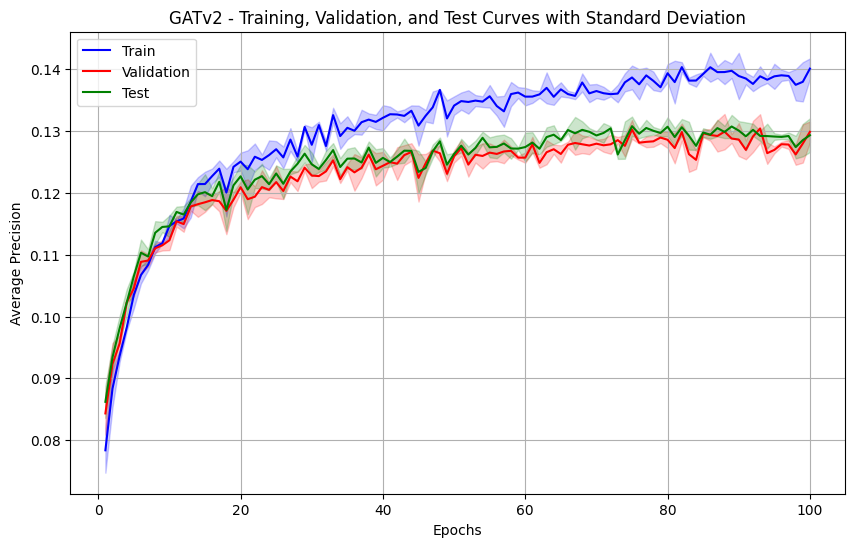

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation for each epoch
train_mean = np.mean(gatv2_record['train'], axis=0)
valid_mean = np.mean(gatv2_record['valid'], axis=0)
test_mean = np.mean(gatv2_record['test'], axis=0)

train_std = np.std(gatv2_record['train'], axis=0)
valid_std = np.std(gatv2_record['valid'], axis=0)
test_std = np.std(gatv2_record['test'], axis=0)

# Plotting
epochs = range(1, len(train_mean) + 1)
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_mean, label='Train', color='blue')
plt.fill_between(epochs, train_mean-train_std, train_mean+train_std, color='blue', alpha=0.2)

plt.plot(epochs, valid_mean, label='Validation', color='red')
plt.fill_between(epochs, valid_mean-valid_std, valid_mean+valid_std, color='red', alpha=0.2)

plt.plot(epochs, test_mean, label='Test', color='green')
plt.fill_between(epochs, test_mean-test_std, test_mean+test_std, color='green', alpha=0.2)

plt.title('GATv2 - Training, Validation, and Test Curves with Standard Deviation')
plt.xlabel('Epochs')
plt.ylabel('Average Precision')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(gatv2_record)

{'train': [[0.08237359450368127, 0.09155252437996163, 0.09424572466165798, 0.09759849739368193, 0.10659073530841401, 0.10587796482061404, 0.10774217070231051, 0.11155127593166039, 0.1118397029590583, 0.11263507167819449, 0.1153201360698864, 0.11794658719687988, 0.1218865153202622, 0.12126786037897917, 0.12048155555247954, 0.12414874398818063, 0.12547306548658158, 0.12220240743431728, 0.12382578508308073, 0.1266612748615557, 0.11999312880719114, 0.12766889129424353, 0.12572516010779503, 0.12836237346979928, 0.12892877678748815, 0.12803034456900342, 0.1282988100323941, 0.12549125647903953, 0.13054471780529509, 0.12950062183245545, 0.13042955649385476, 0.12784411466759177, 0.13223253185888129, 0.12630684707014608, 0.13245397242831575, 0.13043692536281118, 0.13405224336615196, 0.13121749319915751, 0.12999112669853402, 0.12999018029748777, 0.13166674925302604, 0.133234090300262, 0.13106320793086676, 0.1337836759428278, 0.13486953780888167, 0.13263354526234158, 0.13425984391832732, 0.1365420

In [ ]:
import json
with open('gatv2_record_new_1e-3_128.json', 'w') as f:
    json.dump(gatv2_record, f)
from google.colab import files

files.download('gatv2_record_new_1e-3_128.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###1e-4

#### Transformer

In [ ]:
trans_record = {'train': [], 'valid': [], 'test': []}

runs = 3

seeds = [42, 2226, 174]

for i in range(runs):
    torch.manual_seed(seeds[i])
    np.random.seed(seeds[i])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seeds[i])
        torch.cuda.manual_seed_all(seeds[i])


    model = GNN(gnn_type = 'transformer', num_tasks = 128, num_layer = 2, input_dim = 300, emb_dim = 300, drop_ratio = 0.5).to(device)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of trainable parameters: {trainable_params}")

    # optimizer = optim.Adam(model.parameters(), lr=1e-4)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)


    valid_curve = []
    test_curve = []
    train_curve = []

    epochs = 100

    for epoch in range(1, epochs + 1):
        print("=====Epoch {}".format(epoch))
        print('Training...')
        train(model, device, train_loader, optimizer)

        print('Evaluating...')
        train_perf = eval(model, device, train_loader, evaluator)
        valid_perf = eval(model, device, valid_loader, evaluator)
        test_perf = eval(model, device, test_loader, evaluator)

        print({'Train': train_perf, 'Validation': valid_perf, 'Test': test_perf})

        train_curve.append(train_perf['ap'])
        valid_curve.append(valid_perf['ap'])
        test_curve.append(test_perf['ap'])

        best_val_epoch = np.argmax(np.array(valid_curve))
        best_train = max(train_curve)

        print('Finished training!')
        print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
        print('Test score: {}'.format(test_curve[best_val_epoch]))

    print(f"----------------Finished run {i+1}!----------------")

    trans_record['train'].append(train_curve)
    trans_record['valid'].append(valid_curve)
    trans_record['test'].append(test_curve)

Total number of trainable parameters: 998228
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:54<00:00, 23.95it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:09<00:00, 37.60it/s]


{'Train': {'ap': 0.06334542604194578}, 'Validation': {'ap': 0.06742290875021775}, 'Test': {'ap': 0.06877016150211969}}
Finished training!
Best validation score: 0.06742290875021775
Test score: 0.06877016150211969
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.23it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.66it/s]


{'Train': {'ap': 0.08031639604317178}, 'Validation': {'ap': 0.08711266970662779}, 'Test': {'ap': 0.08547336447844978}}
Finished training!
Best validation score: 0.08711266970662779
Test score: 0.08547336447844978
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 86.84it/s]


{'Train': {'ap': 0.09304086740803064}, 'Validation': {'ap': 0.09566351914322904}, 'Test': {'ap': 0.09514970810907576}}
Finished training!
Best validation score: 0.09566351914322904
Test score: 0.09514970810907576
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.68it/s]


{'Train': {'ap': 0.09803887441036241}, 'Validation': {'ap': 0.09900636738475468}, 'Test': {'ap': 0.10033292592955785}}
Finished training!
Best validation score: 0.09900636738475468
Test score: 0.10033292592955785
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 86.87it/s]


{'Train': {'ap': 0.10304753732801004}, 'Validation': {'ap': 0.10397753590917173}, 'Test': {'ap': 0.10551027770879655}}
Finished training!
Best validation score: 0.10397753590917173
Test score: 0.10551027770879655
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.69it/s]


{'Train': {'ap': 0.10743774187488686}, 'Validation': {'ap': 0.10944126177852673}, 'Test': {'ap': 0.11124393868728982}}
Finished training!
Best validation score: 0.10944126177852673
Test score: 0.11124393868728982
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 85.62it/s]


{'Train': {'ap': 0.11383195842248209}, 'Validation': {'ap': 0.11081129946825702}, 'Test': {'ap': 0.11423491274831453}}
Finished training!
Best validation score: 0.11081129946825702
Test score: 0.11423491274831453
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.85it/s]


{'Train': {'ap': 0.11378163758385232}, 'Validation': {'ap': 0.11323252056548101}, 'Test': {'ap': 0.11486596799385933}}
Finished training!
Best validation score: 0.11323252056548101
Test score: 0.11486596799385933
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.10it/s]


{'Train': {'ap': 0.11722062540043798}, 'Validation': {'ap': 0.11527702640773775}, 'Test': {'ap': 0.11682939660530008}}
Finished training!
Best validation score: 0.11527702640773775
Test score: 0.11682939660530008
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.96it/s]


{'Train': {'ap': 0.11919005509846993}, 'Validation': {'ap': 0.11530060698933979}, 'Test': {'ap': 0.11826153177393614}}
Finished training!
Best validation score: 0.11530060698933979
Test score: 0.11826153177393614
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.28it/s]


{'Train': {'ap': 0.12222301761204288}, 'Validation': {'ap': 0.11994903873369701}, 'Test': {'ap': 0.12045240169967282}}
Finished training!
Best validation score: 0.11994903873369701
Test score: 0.12045240169967282
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.07it/s]


{'Train': {'ap': 0.1212378553248071}, 'Validation': {'ap': 0.11684231813698855}, 'Test': {'ap': 0.11961569742574674}}
Finished training!
Best validation score: 0.11994903873369701
Test score: 0.12045240169967282
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.11it/s]


{'Train': {'ap': 0.12654902988714317}, 'Validation': {'ap': 0.12228245682235425}, 'Test': {'ap': 0.12263781037880579}}
Finished training!
Best validation score: 0.12228245682235425
Test score: 0.12263781037880579
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.27it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.14it/s]


{'Train': {'ap': 0.12845724913280596}, 'Validation': {'ap': 0.12239902857208401}, 'Test': {'ap': 0.12168000494937994}}
Finished training!
Best validation score: 0.12239902857208401
Test score: 0.12168000494937994
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.27it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.01it/s]


{'Train': {'ap': 0.12565085782147778}, 'Validation': {'ap': 0.12070507683654358}, 'Test': {'ap': 0.12117805450421355}}
Finished training!
Best validation score: 0.12239902857208401
Test score: 0.12168000494937994
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.15it/s]


{'Train': {'ap': 0.12941248946283465}, 'Validation': {'ap': 0.12409644981240955}, 'Test': {'ap': 0.1244461108381039}}
Finished training!
Best validation score: 0.12409644981240955
Test score: 0.1244461108381039
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.44it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.88it/s]


{'Train': {'ap': 0.12914535232851948}, 'Validation': {'ap': 0.12096203321206798}, 'Test': {'ap': 0.12122029236113539}}
Finished training!
Best validation score: 0.12409644981240955
Test score: 0.1244461108381039
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.73it/s]


{'Train': {'ap': 0.13336137766439904}, 'Validation': {'ap': 0.12575312574513486}, 'Test': {'ap': 0.12638740680483598}}
Finished training!
Best validation score: 0.12575312574513486
Test score: 0.12638740680483598
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.08it/s]


{'Train': {'ap': 0.1297355685693872}, 'Validation': {'ap': 0.12171185495867325}, 'Test': {'ap': 0.12321039739081409}}
Finished training!
Best validation score: 0.12575312574513486
Test score: 0.12638740680483598
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.65it/s]


{'Train': {'ap': 0.13494762261100834}, 'Validation': {'ap': 0.1279651030586015}, 'Test': {'ap': 0.12716177315416397}}
Finished training!
Best validation score: 0.1279651030586015
Test score: 0.12716177315416397
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.52it/s]


{'Train': {'ap': 0.13581564923187753}, 'Validation': {'ap': 0.1284868017106986}, 'Test': {'ap': 0.126552122763094}}
Finished training!
Best validation score: 0.1284868017106986
Test score: 0.126552122763094
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.60it/s]


{'Train': {'ap': 0.13760466917135064}, 'Validation': {'ap': 0.1293414216102337}, 'Test': {'ap': 0.12990812251439693}}
Finished training!
Best validation score: 0.1293414216102337
Test score: 0.12990812251439693
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.84it/s]


{'Train': {'ap': 0.1404295280718379}, 'Validation': {'ap': 0.13081949625040834}, 'Test': {'ap': 0.1310593446911677}}
Finished training!
Best validation score: 0.13081949625040834
Test score: 0.1310593446911677
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.40it/s]


{'Train': {'ap': 0.13910450462504156}, 'Validation': {'ap': 0.12981401161523418}, 'Test': {'ap': 0.1298833377159726}}
Finished training!
Best validation score: 0.13081949625040834
Test score: 0.1310593446911677
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.31it/s]


{'Train': {'ap': 0.14085629643809755}, 'Validation': {'ap': 0.13064422401935505}, 'Test': {'ap': 0.13044980212340807}}
Finished training!
Best validation score: 0.13081949625040834
Test score: 0.1310593446911677
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.96it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.38it/s]


{'Train': {'ap': 0.14131020038260522}, 'Validation': {'ap': 0.13172991346553464}, 'Test': {'ap': 0.13176374166927193}}
Finished training!
Best validation score: 0.13172991346553464
Test score: 0.13176374166927193
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.48it/s]


{'Train': {'ap': 0.14359925008137525}, 'Validation': {'ap': 0.13387669030480362}, 'Test': {'ap': 0.13219769133330034}}
Finished training!
Best validation score: 0.13387669030480362
Test score: 0.13219769133330034
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.78it/s]


{'Train': {'ap': 0.14196918075390588}, 'Validation': {'ap': 0.13324312316909911}, 'Test': {'ap': 0.1318619378302496}}
Finished training!
Best validation score: 0.13387669030480362
Test score: 0.13219769133330034
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.71it/s]


{'Train': {'ap': 0.14228730276386736}, 'Validation': {'ap': 0.13260542188165875}, 'Test': {'ap': 0.13335025036918674}}
Finished training!
Best validation score: 0.13387669030480362
Test score: 0.13219769133330034
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.19it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.51it/s]


{'Train': {'ap': 0.14506654343017986}, 'Validation': {'ap': 0.1325436888610345}, 'Test': {'ap': 0.13030701880983347}}
Finished training!
Best validation score: 0.13387669030480362
Test score: 0.13219769133330034
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.03it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.87it/s]


{'Train': {'ap': 0.14502884520105594}, 'Validation': {'ap': 0.13213310733658706}, 'Test': {'ap': 0.13146314862680455}}
Finished training!
Best validation score: 0.13387669030480362
Test score: 0.13219769133330034
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.92it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.74it/s]


{'Train': {'ap': 0.14479789986703334}, 'Validation': {'ap': 0.13348695489565196}, 'Test': {'ap': 0.1337301205066685}}
Finished training!
Best validation score: 0.13387669030480362
Test score: 0.13219769133330034
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.08it/s]


{'Train': {'ap': 0.1475932094648498}, 'Validation': {'ap': 0.1378878028559641}, 'Test': {'ap': 0.13512092929766104}}
Finished training!
Best validation score: 0.1378878028559641
Test score: 0.13512092929766104
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.68it/s]


{'Train': {'ap': 0.14734275718167006}, 'Validation': {'ap': 0.1337544645914292}, 'Test': {'ap': 0.13379437837365185}}
Finished training!
Best validation score: 0.1378878028559641
Test score: 0.13512092929766104
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.95it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.74it/s]


{'Train': {'ap': 0.15052564985832162}, 'Validation': {'ap': 0.13495411902153304}, 'Test': {'ap': 0.13535504773323276}}
Finished training!
Best validation score: 0.1378878028559641
Test score: 0.13512092929766104
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.70it/s]


{'Train': {'ap': 0.1493003896970125}, 'Validation': {'ap': 0.1367252416634618}, 'Test': {'ap': 0.13597882697852415}}
Finished training!
Best validation score: 0.1378878028559641
Test score: 0.13512092929766104
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.28it/s]


{'Train': {'ap': 0.14940465939083866}, 'Validation': {'ap': 0.13763455092455526}, 'Test': {'ap': 0.13584532149836792}}
Finished training!
Best validation score: 0.1378878028559641
Test score: 0.13512092929766104
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.10it/s]


{'Train': {'ap': 0.15248743299065848}, 'Validation': {'ap': 0.1377315534086676}, 'Test': {'ap': 0.13599465021870058}}
Finished training!
Best validation score: 0.1378878028559641
Test score: 0.13512092929766104
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.30it/s]


{'Train': {'ap': 0.15185954004378338}, 'Validation': {'ap': 0.1380513663969344}, 'Test': {'ap': 0.13675225014173178}}
Finished training!
Best validation score: 0.1380513663969344
Test score: 0.13675225014173178
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.93it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.30it/s]


{'Train': {'ap': 0.1522231888824166}, 'Validation': {'ap': 0.13680933082031715}, 'Test': {'ap': 0.1366391869675142}}
Finished training!
Best validation score: 0.1380513663969344
Test score: 0.13675225014173178
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.83it/s]


{'Train': {'ap': 0.1516747900480932}, 'Validation': {'ap': 0.13665837958625354}, 'Test': {'ap': 0.13751534809335245}}
Finished training!
Best validation score: 0.1380513663969344
Test score: 0.13675225014173178
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.94it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.97it/s]


{'Train': {'ap': 0.1538127397185915}, 'Validation': {'ap': 0.1403911077468261}, 'Test': {'ap': 0.13768691972201957}}
Finished training!
Best validation score: 0.1403911077468261
Test score: 0.13768691972201957
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.45it/s]


{'Train': {'ap': 0.15576811088872572}, 'Validation': {'ap': 0.14005096700750802}, 'Test': {'ap': 0.13858350280868398}}
Finished training!
Best validation score: 0.1403911077468261
Test score: 0.13768691972201957
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.70it/s]


{'Train': {'ap': 0.15469018231484613}, 'Validation': {'ap': 0.13829550229001944}, 'Test': {'ap': 0.13695953469650843}}
Finished training!
Best validation score: 0.1403911077468261
Test score: 0.13768691972201957
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.25it/s]


{'Train': {'ap': 0.15631889122337891}, 'Validation': {'ap': 0.13868623203667887}, 'Test': {'ap': 0.13775059656647703}}
Finished training!
Best validation score: 0.1403911077468261
Test score: 0.13768691972201957
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.03it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.58it/s]


{'Train': {'ap': 0.1587982502422696}, 'Validation': {'ap': 0.14016927730367332}, 'Test': {'ap': 0.13922348803138018}}
Finished training!
Best validation score: 0.1403911077468261
Test score: 0.13768691972201957
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.21it/s]


{'Train': {'ap': 0.16024115972121156}, 'Validation': {'ap': 0.13930181601660196}, 'Test': {'ap': 0.13908285887731137}}
Finished training!
Best validation score: 0.1403911077468261
Test score: 0.13768691972201957
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.00it/s]


{'Train': {'ap': 0.15871023254722297}, 'Validation': {'ap': 0.14063239631652874}, 'Test': {'ap': 0.13932954264037964}}
Finished training!
Best validation score: 0.14063239631652874
Test score: 0.13932954264037964
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.84it/s]


{'Train': {'ap': 0.15988171772785323}, 'Validation': {'ap': 0.14066867613720477}, 'Test': {'ap': 0.13725403815518464}}
Finished training!
Best validation score: 0.14066867613720477
Test score: 0.13725403815518464
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.24it/s]


{'Train': {'ap': 0.15924281637024582}, 'Validation': {'ap': 0.14174341617754088}, 'Test': {'ap': 0.14048340235497717}}
Finished training!
Best validation score: 0.14174341617754088
Test score: 0.14048340235497717
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.69it/s]


{'Train': {'ap': 0.16051021424889708}, 'Validation': {'ap': 0.14247307466009002}, 'Test': {'ap': 0.14203397566336962}}
Finished training!
Best validation score: 0.14247307466009002
Test score: 0.14203397566336962
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.10it/s]


{'Train': {'ap': 0.1579851956355726}, 'Validation': {'ap': 0.14045128965208392}, 'Test': {'ap': 0.14057732587493763}}
Finished training!
Best validation score: 0.14247307466009002
Test score: 0.14203397566336962
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.67it/s]


{'Train': {'ap': 0.16049595324572896}, 'Validation': {'ap': 0.14438136733898882}, 'Test': {'ap': 0.1416183340900547}}
Finished training!
Best validation score: 0.14438136733898882
Test score: 0.1416183340900547
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.96it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.52it/s]


{'Train': {'ap': 0.1630196065624277}, 'Validation': {'ap': 0.14202128729525376}, 'Test': {'ap': 0.14070552887145074}}
Finished training!
Best validation score: 0.14438136733898882
Test score: 0.1416183340900547
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.29it/s]


{'Train': {'ap': 0.1615449236419161}, 'Validation': {'ap': 0.1426616044609506}, 'Test': {'ap': 0.14192824284280064}}
Finished training!
Best validation score: 0.14438136733898882
Test score: 0.1416183340900547
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:09<00:00, 37.71it/s]


{'Train': {'ap': 0.16278410850590772}, 'Validation': {'ap': 0.14338213349811554}, 'Test': {'ap': 0.14307052370178008}}
Finished training!
Best validation score: 0.14438136733898882
Test score: 0.1416183340900547
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.79it/s]


{'Train': {'ap': 0.16311314816113168}, 'Validation': {'ap': 0.14183573115999615}, 'Test': {'ap': 0.1433813637318972}}
Finished training!
Best validation score: 0.14438136733898882
Test score: 0.1416183340900547
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.44it/s]


{'Train': {'ap': 0.16437803702475204}, 'Validation': {'ap': 0.1442257130868217}, 'Test': {'ap': 0.1432721071987327}}
Finished training!
Best validation score: 0.14438136733898882
Test score: 0.1416183340900547
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.98it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.87it/s]


{'Train': {'ap': 0.163651546845331}, 'Validation': {'ap': 0.14248755893409254}, 'Test': {'ap': 0.14248070488379}}
Finished training!
Best validation score: 0.14438136733898882
Test score: 0.1416183340900547
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.97it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.65it/s]


{'Train': {'ap': 0.16407754027240007}, 'Validation': {'ap': 0.1433054775016136}, 'Test': {'ap': 0.14275987828685735}}
Finished training!
Best validation score: 0.14438136733898882
Test score: 0.1416183340900547
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.07it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.14it/s]


{'Train': {'ap': 0.1641462240637666}, 'Validation': {'ap': 0.14306802015005127}, 'Test': {'ap': 0.1417678653723356}}
Finished training!
Best validation score: 0.14438136733898882
Test score: 0.1416183340900547
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.39it/s]


{'Train': {'ap': 0.16492338034174084}, 'Validation': {'ap': 0.1443038920161012}, 'Test': {'ap': 0.14159548055463697}}
Finished training!
Best validation score: 0.14438136733898882
Test score: 0.1416183340900547
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.79it/s]


{'Train': {'ap': 0.16812404446952287}, 'Validation': {'ap': 0.14508457855039875}, 'Test': {'ap': 0.14268227239006456}}
Finished training!
Best validation score: 0.14508457855039875
Test score: 0.14268227239006456
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.97it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.24it/s]


{'Train': {'ap': 0.16531089421689038}, 'Validation': {'ap': 0.14195038535236068}, 'Test': {'ap': 0.14362535658252637}}
Finished training!
Best validation score: 0.14508457855039875
Test score: 0.14268227239006456
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.13it/s]


{'Train': {'ap': 0.16540555621270886}, 'Validation': {'ap': 0.14422145432738354}, 'Test': {'ap': 0.1432327542255456}}
Finished training!
Best validation score: 0.14508457855039875
Test score: 0.14268227239006456
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.94it/s]


{'Train': {'ap': 0.16581502861853742}, 'Validation': {'ap': 0.14474047494249617}, 'Test': {'ap': 0.1438836315439037}}
Finished training!
Best validation score: 0.14508457855039875
Test score: 0.14268227239006456
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.31it/s]


{'Train': {'ap': 0.16947488204321934}, 'Validation': {'ap': 0.14369782833716496}, 'Test': {'ap': 0.1454389205387349}}
Finished training!
Best validation score: 0.14508457855039875
Test score: 0.14268227239006456
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.43it/s]


{'Train': {'ap': 0.16846457231345482}, 'Validation': {'ap': 0.14667970695555527}, 'Test': {'ap': 0.14430505373818547}}
Finished training!
Best validation score: 0.14667970695555527
Test score: 0.14430505373818547
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.83it/s]


{'Train': {'ap': 0.16933407189480318}, 'Validation': {'ap': 0.1456033637989131}, 'Test': {'ap': 0.14574866768882824}}
Finished training!
Best validation score: 0.14667970695555527
Test score: 0.14430505373818547
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.97it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.69it/s]


{'Train': {'ap': 0.16876093242274365}, 'Validation': {'ap': 0.14686206630561682}, 'Test': {'ap': 0.14378156197962944}}
Finished training!
Best validation score: 0.14686206630561682
Test score: 0.14378156197962944
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.90it/s]


{'Train': {'ap': 0.16657680578180376}, 'Validation': {'ap': 0.14343700178580224}, 'Test': {'ap': 0.14312422398505886}}
Finished training!
Best validation score: 0.14686206630561682
Test score: 0.14378156197962944
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.13it/s]


{'Train': {'ap': 0.17197340226399205}, 'Validation': {'ap': 0.14661866251134936}, 'Test': {'ap': 0.14467063214486348}}
Finished training!
Best validation score: 0.14686206630561682
Test score: 0.14378156197962944
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.87it/s]


{'Train': {'ap': 0.1699634702841648}, 'Validation': {'ap': 0.14526801284423466}, 'Test': {'ap': 0.14397347255529072}}
Finished training!
Best validation score: 0.14686206630561682
Test score: 0.14378156197962944
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.97it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.12it/s]


{'Train': {'ap': 0.17026864705913164}, 'Validation': {'ap': 0.1437964515509721}, 'Test': {'ap': 0.14528938281874562}}
Finished training!
Best validation score: 0.14686206630561682
Test score: 0.14378156197962944
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.36it/s]


{'Train': {'ap': 0.17246832126864012}, 'Validation': {'ap': 0.14721046424332737}, 'Test': {'ap': 0.14618272213071754}}
Finished training!
Best validation score: 0.14721046424332737
Test score: 0.14618272213071754
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.20it/s]


{'Train': {'ap': 0.17143971048506468}, 'Validation': {'ap': 0.1477647643076215}, 'Test': {'ap': 0.14460464863348815}}
Finished training!
Best validation score: 0.1477647643076215
Test score: 0.14460464863348815
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.07it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.22it/s]


{'Train': {'ap': 0.17517932328461228}, 'Validation': {'ap': 0.14775736570011505}, 'Test': {'ap': 0.1460060691076332}}
Finished training!
Best validation score: 0.1477647643076215
Test score: 0.14460464863348815
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.67it/s]


{'Train': {'ap': 0.17300989668260558}, 'Validation': {'ap': 0.14764328773473168}, 'Test': {'ap': 0.14744649149149175}}
Finished training!
Best validation score: 0.1477647643076215
Test score: 0.14460464863348815
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.98it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.13it/s]


{'Train': {'ap': 0.17130350680499412}, 'Validation': {'ap': 0.14499084035179757}, 'Test': {'ap': 0.1450120306487727}}
Finished training!
Best validation score: 0.1477647643076215
Test score: 0.14460464863348815
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.16it/s]


{'Train': {'ap': 0.17085193554951297}, 'Validation': {'ap': 0.14863181725170074}, 'Test': {'ap': 0.14454906273598736}}
Finished training!
Best validation score: 0.14863181725170074
Test score: 0.14454906273598736
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.03it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.23it/s]


{'Train': {'ap': 0.1755566906292529}, 'Validation': {'ap': 0.1486635744570537}, 'Test': {'ap': 0.14644501620835487}}
Finished training!
Best validation score: 0.1486635744570537
Test score: 0.14644501620835487
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.57it/s]


{'Train': {'ap': 0.17558037119402842}, 'Validation': {'ap': 0.14801447318163316}, 'Test': {'ap': 0.1470283576162441}}
Finished training!
Best validation score: 0.1486635744570537
Test score: 0.14644501620835487
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.97it/s]


{'Train': {'ap': 0.1755090256290164}, 'Validation': {'ap': 0.14952972157557348}, 'Test': {'ap': 0.14491776016810806}}
Finished training!
Best validation score: 0.14952972157557348
Test score: 0.14491776016810806
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.98it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.41it/s]


{'Train': {'ap': 0.17682781780948933}, 'Validation': {'ap': 0.15017969669565429}, 'Test': {'ap': 0.14690058016561242}}
Finished training!
Best validation score: 0.15017969669565429
Test score: 0.14690058016561242
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.23it/s]


{'Train': {'ap': 0.17682805921071165}, 'Validation': {'ap': 0.14865261476311342}, 'Test': {'ap': 0.14636500070471656}}
Finished training!
Best validation score: 0.15017969669565429
Test score: 0.14690058016561242
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.11it/s]


{'Train': {'ap': 0.17719475933521753}, 'Validation': {'ap': 0.1479203433634631}, 'Test': {'ap': 0.14695401141916428}}
Finished training!
Best validation score: 0.15017969669565429
Test score: 0.14690058016561242
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.06it/s]


{'Train': {'ap': 0.18004774534447596}, 'Validation': {'ap': 0.14763349146781912}, 'Test': {'ap': 0.14464378611542228}}
Finished training!
Best validation score: 0.15017969669565429
Test score: 0.14690058016561242
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.22it/s]


{'Train': {'ap': 0.17756533461067434}, 'Validation': {'ap': 0.15197288924103056}, 'Test': {'ap': 0.14783803497314665}}
Finished training!
Best validation score: 0.15197288924103056
Test score: 0.14783803497314665
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.39it/s]


{'Train': {'ap': 0.1804139575270768}, 'Validation': {'ap': 0.14810182476766715}, 'Test': {'ap': 0.1450241831640611}}
Finished training!
Best validation score: 0.15197288924103056
Test score: 0.14783803497314665
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.97it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.72it/s]


{'Train': {'ap': 0.17950186625385436}, 'Validation': {'ap': 0.1486274542360146}, 'Test': {'ap': 0.14623966782775757}}
Finished training!
Best validation score: 0.15197288924103056
Test score: 0.14783803497314665
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.63it/s]


{'Train': {'ap': 0.1808948780315583}, 'Validation': {'ap': 0.15257425927467794}, 'Test': {'ap': 0.1465724031472252}}
Finished training!
Best validation score: 0.15257425927467794
Test score: 0.1465724031472252
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.28it/s]


{'Train': {'ap': 0.17997825637864737}, 'Validation': {'ap': 0.14964311912626288}, 'Test': {'ap': 0.14749692810884524}}
Finished training!
Best validation score: 0.15257425927467794
Test score: 0.1465724031472252
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.03it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.44it/s]


{'Train': {'ap': 0.18061232999189553}, 'Validation': {'ap': 0.14880593971208061}, 'Test': {'ap': 0.1488886511932502}}
Finished training!
Best validation score: 0.15257425927467794
Test score: 0.1465724031472252
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.02it/s]


{'Train': {'ap': 0.1802922413955971}, 'Validation': {'ap': 0.1512883437757165}, 'Test': {'ap': 0.14910805168199934}}
Finished training!
Best validation score: 0.15257425927467794
Test score: 0.1465724031472252
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.91it/s]


{'Train': {'ap': 0.18054153247740654}, 'Validation': {'ap': 0.15128048191681057}, 'Test': {'ap': 0.14928844614620929}}
Finished training!
Best validation score: 0.15257425927467794
Test score: 0.1465724031472252
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.41it/s]


{'Train': {'ap': 0.18124873707483397}, 'Validation': {'ap': 0.1500540227744075}, 'Test': {'ap': 0.14793038742095524}}
Finished training!
Best validation score: 0.15257425927467794
Test score: 0.1465724031472252
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.56it/s]


{'Train': {'ap': 0.18167816502230844}, 'Validation': {'ap': 0.15004668976951663}, 'Test': {'ap': 0.14777249167916578}}
Finished training!
Best validation score: 0.15257425927467794
Test score: 0.1465724031472252
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.61it/s]


{'Train': {'ap': 0.18345567491561918}, 'Validation': {'ap': 0.1501019914554758}, 'Test': {'ap': 0.15034283159838951}}
Finished training!
Best validation score: 0.15257425927467794
Test score: 0.1465724031472252
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.45it/s]


{'Train': {'ap': 0.1818631070230624}, 'Validation': {'ap': 0.15042221420951538}, 'Test': {'ap': 0.150708447128576}}
Finished training!
Best validation score: 0.15257425927467794
Test score: 0.1465724031472252
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.63it/s]


{'Train': {'ap': 0.18126320739262824}, 'Validation': {'ap': 0.1493727215766749}, 'Test': {'ap': 0.14915416602333934}}
Finished training!
Best validation score: 0.15257425927467794
Test score: 0.1465724031472252
----------------Finished run 1!----------------
Total number of trainable parameters: 998228
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.09it/s]


{'Train': {'ap': 0.06195299687575688}, 'Validation': {'ap': 0.06521671367881747}, 'Test': {'ap': 0.0661216112694202}}
Finished training!
Best validation score: 0.06521671367881747
Test score: 0.0661216112694202
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.69it/s]


{'Train': {'ap': 0.07900746059546264}, 'Validation': {'ap': 0.08407386785795558}, 'Test': {'ap': 0.0847742315565061}}
Finished training!
Best validation score: 0.08407386785795558
Test score: 0.0847742315565061
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.34it/s]


{'Train': {'ap': 0.09011895241929385}, 'Validation': {'ap': 0.09476247389328209}, 'Test': {'ap': 0.09522654858299368}}
Finished training!
Best validation score: 0.09476247389328209
Test score: 0.09522654858299368
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.79it/s]


{'Train': {'ap': 0.09628626128413131}, 'Validation': {'ap': 0.09866528381664609}, 'Test': {'ap': 0.09790175280769395}}
Finished training!
Best validation score: 0.09866528381664609
Test score: 0.09790175280769395
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.51it/s]


{'Train': {'ap': 0.09802116863432499}, 'Validation': {'ap': 0.10233755187541803}, 'Test': {'ap': 0.10371611134226418}}
Finished training!
Best validation score: 0.10233755187541803
Test score: 0.10371611134226418
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.03it/s]


{'Train': {'ap': 0.10636816585950437}, 'Validation': {'ap': 0.10842995735171361}, 'Test': {'ap': 0.1086233753856047}}
Finished training!
Best validation score: 0.10842995735171361
Test score: 0.1086233753856047
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 43.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.30it/s]


{'Train': {'ap': 0.10785032960096023}, 'Validation': {'ap': 0.10897164478390613}, 'Test': {'ap': 0.10959102039308018}}
Finished training!
Best validation score: 0.10897164478390613
Test score: 0.10959102039308018
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.90it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.32it/s]


{'Train': {'ap': 0.112004895345647}, 'Validation': {'ap': 0.11459911188351253}, 'Test': {'ap': 0.11430874227829176}}
Finished training!
Best validation score: 0.11459911188351253
Test score: 0.11430874227829176
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.12it/s]


{'Train': {'ap': 0.11397193759024539}, 'Validation': {'ap': 0.11281161873166497}, 'Test': {'ap': 0.11108803879054213}}
Finished training!
Best validation score: 0.11459911188351253
Test score: 0.11430874227829176
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.21it/s]


{'Train': {'ap': 0.11622164710524123}, 'Validation': {'ap': 0.11502495960976702}, 'Test': {'ap': 0.11517979862562602}}
Finished training!
Best validation score: 0.11502495960976702
Test score: 0.11517979862562602
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.58it/s]


{'Train': {'ap': 0.11995020332861864}, 'Validation': {'ap': 0.11789836994824648}, 'Test': {'ap': 0.11965233175512327}}
Finished training!
Best validation score: 0.11789836994824648
Test score: 0.11965233175512327
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.82it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.99it/s]


{'Train': {'ap': 0.12100386787169914}, 'Validation': {'ap': 0.11838000731662812}, 'Test': {'ap': 0.12050984360573555}}
Finished training!
Best validation score: 0.11838000731662812
Test score: 0.12050984360573555
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.77it/s]


{'Train': {'ap': 0.1216378569817192}, 'Validation': {'ap': 0.1201409090953594}, 'Test': {'ap': 0.11976933377465486}}
Finished training!
Best validation score: 0.1201409090953594
Test score: 0.11976933377465486
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.95it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.15it/s]


{'Train': {'ap': 0.12455079292366984}, 'Validation': {'ap': 0.1224578138785063}, 'Test': {'ap': 0.12153066697186365}}
Finished training!
Best validation score: 0.1224578138785063
Test score: 0.12153066697186365
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.93it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.51it/s]


{'Train': {'ap': 0.1265442142911956}, 'Validation': {'ap': 0.12202359505635119}, 'Test': {'ap': 0.12291111590658284}}
Finished training!
Best validation score: 0.1224578138785063
Test score: 0.12153066697186365
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.43it/s]


{'Train': {'ap': 0.12738229535127277}, 'Validation': {'ap': 0.11903857479485618}, 'Test': {'ap': 0.12147337113376724}}
Finished training!
Best validation score: 0.1224578138785063
Test score: 0.12153066697186365
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.21it/s]


{'Train': {'ap': 0.13081324072234538}, 'Validation': {'ap': 0.12696584702255342}, 'Test': {'ap': 0.12703847672024432}}
Finished training!
Best validation score: 0.12696584702255342
Test score: 0.12703847672024432
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.94it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.50it/s]


{'Train': {'ap': 0.13165462445187054}, 'Validation': {'ap': 0.1276425146739623}, 'Test': {'ap': 0.12736378162075176}}
Finished training!
Best validation score: 0.1276425146739623
Test score: 0.12736378162075176
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.44it/s]


{'Train': {'ap': 0.1310436900660223}, 'Validation': {'ap': 0.12445798666062598}, 'Test': {'ap': 0.12675947879731403}}
Finished training!
Best validation score: 0.1276425146739623
Test score: 0.12736378162075176
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.97it/s]


{'Train': {'ap': 0.13455194448142616}, 'Validation': {'ap': 0.12445742368679237}, 'Test': {'ap': 0.12666984805110867}}
Finished training!
Best validation score: 0.1276425146739623
Test score: 0.12736378162075176
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.92it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.97it/s]


{'Train': {'ap': 0.13435303678726115}, 'Validation': {'ap': 0.12710477706852694}, 'Test': {'ap': 0.12846557199244435}}
Finished training!
Best validation score: 0.1276425146739623
Test score: 0.12736378162075176
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.52it/s]


{'Train': {'ap': 0.1356075377677551}, 'Validation': {'ap': 0.12518426153470708}, 'Test': {'ap': 0.12814795069126192}}
Finished training!
Best validation score: 0.1276425146739623
Test score: 0.12736378162075176
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.88it/s]


{'Train': {'ap': 0.13580955199545452}, 'Validation': {'ap': 0.12942670104989804}, 'Test': {'ap': 0.13008871495120156}}
Finished training!
Best validation score: 0.12942670104989804
Test score: 0.13008871495120156
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.16it/s]


{'Train': {'ap': 0.13580337658375793}, 'Validation': {'ap': 0.12967097750115214}, 'Test': {'ap': 0.12961390068143586}}
Finished training!
Best validation score: 0.12967097750115214
Test score: 0.12961390068143586
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.78it/s]


{'Train': {'ap': 0.13810685579356874}, 'Validation': {'ap': 0.1305201391893229}, 'Test': {'ap': 0.13087323404886578}}
Finished training!
Best validation score: 0.1305201391893229
Test score: 0.13087323404886578
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.33it/s]


{'Train': {'ap': 0.1375744861766549}, 'Validation': {'ap': 0.1286994862462548}, 'Test': {'ap': 0.13026686411636618}}
Finished training!
Best validation score: 0.1305201391893229
Test score: 0.13087323404886578
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.99it/s]


{'Train': {'ap': 0.13991348315545002}, 'Validation': {'ap': 0.12981822105321147}, 'Test': {'ap': 0.13301871660949205}}
Finished training!
Best validation score: 0.1305201391893229
Test score: 0.13087323404886578
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.72it/s]


{'Train': {'ap': 0.14164334610520246}, 'Validation': {'ap': 0.13225520316051317}, 'Test': {'ap': 0.1341002833593464}}
Finished training!
Best validation score: 0.13225520316051317
Test score: 0.1341002833593464
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.73it/s]


{'Train': {'ap': 0.14073825147061406}, 'Validation': {'ap': 0.12956767816620568}, 'Test': {'ap': 0.13068514302770115}}
Finished training!
Best validation score: 0.13225520316051317
Test score: 0.1341002833593464
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.47it/s]


{'Train': {'ap': 0.14223927070228617}, 'Validation': {'ap': 0.1317870312600041}, 'Test': {'ap': 0.13370216379131214}}
Finished training!
Best validation score: 0.13225520316051317
Test score: 0.1341002833593464
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.07it/s]


{'Train': {'ap': 0.1442888836994205}, 'Validation': {'ap': 0.13233006585333057}, 'Test': {'ap': 0.1343482583405169}}
Finished training!
Best validation score: 0.13233006585333057
Test score: 0.1343482583405169
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.84it/s]


{'Train': {'ap': 0.14585938728832035}, 'Validation': {'ap': 0.13264591968220968}, 'Test': {'ap': 0.13572274632419934}}
Finished training!
Best validation score: 0.13264591968220968
Test score: 0.13572274632419934
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.08it/s]


{'Train': {'ap': 0.14605422420590863}, 'Validation': {'ap': 0.13276085601935514}, 'Test': {'ap': 0.1346359908205878}}
Finished training!
Best validation score: 0.13276085601935514
Test score: 0.1346359908205878
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.82it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.42it/s]


{'Train': {'ap': 0.1466008445957195}, 'Validation': {'ap': 0.13240708755025554}, 'Test': {'ap': 0.13546353809772504}}
Finished training!
Best validation score: 0.13276085601935514
Test score: 0.1346359908205878
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.90it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.06it/s]


{'Train': {'ap': 0.14675344630812312}, 'Validation': {'ap': 0.13074704371234702}, 'Test': {'ap': 0.1346655054061043}}
Finished training!
Best validation score: 0.13276085601935514
Test score: 0.1346359908205878
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.92it/s]


{'Train': {'ap': 0.1473398251354905}, 'Validation': {'ap': 0.1304641391731648}, 'Test': {'ap': 0.13349348043814308}}
Finished training!
Best validation score: 0.13276085601935514
Test score: 0.1346359908205878
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.58it/s]


{'Train': {'ap': 0.15019740934483886}, 'Validation': {'ap': 0.13295429328304006}, 'Test': {'ap': 0.13632654902929897}}
Finished training!
Best validation score: 0.13295429328304006
Test score: 0.13632654902929897
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.36it/s]


{'Train': {'ap': 0.14974721056014262}, 'Validation': {'ap': 0.13372410209513944}, 'Test': {'ap': 0.13804949768275945}}
Finished training!
Best validation score: 0.13372410209513944
Test score: 0.13804949768275945
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.97it/s]


{'Train': {'ap': 0.15033448000817945}, 'Validation': {'ap': 0.13480686057384453}, 'Test': {'ap': 0.13825126605727084}}
Finished training!
Best validation score: 0.13480686057384453
Test score: 0.13825126605727084
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.20it/s]


{'Train': {'ap': 0.1502571602829611}, 'Validation': {'ap': 0.13650131628209977}, 'Test': {'ap': 0.14025889357929028}}
Finished training!
Best validation score: 0.13650131628209977
Test score: 0.14025889357929028
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.07it/s]


{'Train': {'ap': 0.15114578681133747}, 'Validation': {'ap': 0.13717311216998893}, 'Test': {'ap': 0.1372154328354071}}
Finished training!
Best validation score: 0.13717311216998893
Test score: 0.1372154328354071
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.36it/s]


{'Train': {'ap': 0.15209481888898757}, 'Validation': {'ap': 0.13499561343246474}, 'Test': {'ap': 0.13985767521532885}}
Finished training!
Best validation score: 0.13717311216998893
Test score: 0.1372154328354071
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.44it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.95it/s]


{'Train': {'ap': 0.15201072516636424}, 'Validation': {'ap': 0.13334520291001165}, 'Test': {'ap': 0.1391179776677446}}
Finished training!
Best validation score: 0.13717311216998893
Test score: 0.1372154328354071
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.98it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.37it/s]


{'Train': {'ap': 0.1522335080677794}, 'Validation': {'ap': 0.13405192463172955}, 'Test': {'ap': 0.13872655011221569}}
Finished training!
Best validation score: 0.13717311216998893
Test score: 0.1372154328354071
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.69it/s]


{'Train': {'ap': 0.1529526602848008}, 'Validation': {'ap': 0.1364417775006382}, 'Test': {'ap': 0.1389780165125924}}
Finished training!
Best validation score: 0.13717311216998893
Test score: 0.1372154328354071
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 86.16it/s]


{'Train': {'ap': 0.15411974896602268}, 'Validation': {'ap': 0.13469103842292202}, 'Test': {'ap': 0.13850930527276847}}
Finished training!
Best validation score: 0.13717311216998893
Test score: 0.1372154328354071
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 41.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:09<00:00, 36.16it/s]


{'Train': {'ap': 0.1562616745796903}, 'Validation': {'ap': 0.1343987605390275}, 'Test': {'ap': 0.13875655589985622}}
Finished training!
Best validation score: 0.13717311216998893
Test score: 0.1372154328354071
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.87it/s]


{'Train': {'ap': 0.15553376722934728}, 'Validation': {'ap': 0.1364154400305221}, 'Test': {'ap': 0.138749326299465}}
Finished training!
Best validation score: 0.13717311216998893
Test score: 0.1372154328354071
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:05<00:00, 42.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.78it/s]


{'Train': {'ap': 0.1555874352755052}, 'Validation': {'ap': 0.13763086452566198}, 'Test': {'ap': 0.13811338966923012}}
Finished training!
Best validation score: 0.13763086452566198
Test score: 0.13811338966923012
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.08it/s]


{'Train': {'ap': 0.15860661119113062}, 'Validation': {'ap': 0.13641256902056215}, 'Test': {'ap': 0.14193697049783197}}
Finished training!
Best validation score: 0.13763086452566198
Test score: 0.13811338966923012
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.25it/s]


{'Train': {'ap': 0.15927947890358465}, 'Validation': {'ap': 0.13820602090744963}, 'Test': {'ap': 0.14241525686347242}}
Finished training!
Best validation score: 0.13820602090744963
Test score: 0.14241525686347242
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.45it/s]


{'Train': {'ap': 0.16037420376049272}, 'Validation': {'ap': 0.13817990038227826}, 'Test': {'ap': 0.14106407059609058}}
Finished training!
Best validation score: 0.13820602090744963
Test score: 0.14241525686347242
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.34it/s]


{'Train': {'ap': 0.16075849701504877}, 'Validation': {'ap': 0.14013747271912222}, 'Test': {'ap': 0.1426743703383905}}
Finished training!
Best validation score: 0.14013747271912222
Test score: 0.1426743703383905
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.07it/s]


{'Train': {'ap': 0.16059691937454582}, 'Validation': {'ap': 0.13854949988453324}, 'Test': {'ap': 0.14144088889825}}
Finished training!
Best validation score: 0.14013747271912222
Test score: 0.1426743703383905
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.10it/s]


{'Train': {'ap': 0.16030183580048019}, 'Validation': {'ap': 0.13840587179582728}, 'Test': {'ap': 0.14179952978689342}}
Finished training!
Best validation score: 0.14013747271912222
Test score: 0.1426743703383905
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.85it/s]


{'Train': {'ap': 0.15902127121129286}, 'Validation': {'ap': 0.13985566597326488}, 'Test': {'ap': 0.14279086152455414}}
Finished training!
Best validation score: 0.14013747271912222
Test score: 0.1426743703383905
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.93it/s]


{'Train': {'ap': 0.16218424029722847}, 'Validation': {'ap': 0.14071353428859995}, 'Test': {'ap': 0.14098654132584956}}
Finished training!
Best validation score: 0.14071353428859995
Test score: 0.14098654132584956
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.45it/s]


{'Train': {'ap': 0.1620982726932692}, 'Validation': {'ap': 0.13955363708770427}, 'Test': {'ap': 0.14275146710294218}}
Finished training!
Best validation score: 0.14071353428859995
Test score: 0.14098654132584956
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.79it/s]


{'Train': {'ap': 0.16136903372582953}, 'Validation': {'ap': 0.1384481411367911}, 'Test': {'ap': 0.14189006414992283}}
Finished training!
Best validation score: 0.14071353428859995
Test score: 0.14098654132584956
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.47it/s]


{'Train': {'ap': 0.16120797199661008}, 'Validation': {'ap': 0.14132995330148618}, 'Test': {'ap': 0.14320264266416882}}
Finished training!
Best validation score: 0.14132995330148618
Test score: 0.14320264266416882
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 86.72it/s]


{'Train': {'ap': 0.1640986885753529}, 'Validation': {'ap': 0.14158796176272517}, 'Test': {'ap': 0.14317423740567298}}
Finished training!
Best validation score: 0.14158796176272517
Test score: 0.14317423740567298
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.24it/s]


{'Train': {'ap': 0.16513372789749395}, 'Validation': {'ap': 0.1420920780288625}, 'Test': {'ap': 0.1439296216853957}}
Finished training!
Best validation score: 0.1420920780288625
Test score: 0.1439296216853957
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.88it/s]


{'Train': {'ap': 0.16599209838048912}, 'Validation': {'ap': 0.1431006667273129}, 'Test': {'ap': 0.14421581361522628}}
Finished training!
Best validation score: 0.1431006667273129
Test score: 0.14421581361522628
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.80it/s]


{'Train': {'ap': 0.16294428522506754}, 'Validation': {'ap': 0.1409406655336428}, 'Test': {'ap': 0.1427097853375396}}
Finished training!
Best validation score: 0.1431006667273129
Test score: 0.14421581361522628
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.76it/s]


{'Train': {'ap': 0.1658928681410741}, 'Validation': {'ap': 0.14326421672739933}, 'Test': {'ap': 0.14493302458867402}}
Finished training!
Best validation score: 0.14326421672739933
Test score: 0.14493302458867402
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.72it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.20it/s]


{'Train': {'ap': 0.16492158885293115}, 'Validation': {'ap': 0.14296503446809516}, 'Test': {'ap': 0.14386222888605452}}
Finished training!
Best validation score: 0.14326421672739933
Test score: 0.14493302458867402
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.52it/s]


{'Train': {'ap': 0.16745678582676016}, 'Validation': {'ap': 0.14226447281671428}, 'Test': {'ap': 0.14535884427220372}}
Finished training!
Best validation score: 0.14326421672739933
Test score: 0.14493302458867402
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.42it/s]


{'Train': {'ap': 0.16651498772300521}, 'Validation': {'ap': 0.14105444246688245}, 'Test': {'ap': 0.1444290811619003}}
Finished training!
Best validation score: 0.14326421672739933
Test score: 0.14493302458867402
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.53it/s]


{'Train': {'ap': 0.1693541815278175}, 'Validation': {'ap': 0.14491320677623087}, 'Test': {'ap': 0.14370200155288496}}
Finished training!
Best validation score: 0.14491320677623087
Test score: 0.14370200155288496
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.42it/s]


{'Train': {'ap': 0.16718761027274676}, 'Validation': {'ap': 0.14474278451928616}, 'Test': {'ap': 0.14338759124804717}}
Finished training!
Best validation score: 0.14491320677623087
Test score: 0.14370200155288496
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.18it/s]


{'Train': {'ap': 0.16690925557184913}, 'Validation': {'ap': 0.14158157801449836}, 'Test': {'ap': 0.14455854409564106}}
Finished training!
Best validation score: 0.14491320677623087
Test score: 0.14370200155288496
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.48it/s]


{'Train': {'ap': 0.16912775811478367}, 'Validation': {'ap': 0.14566696286896455}, 'Test': {'ap': 0.14585889901090976}}
Finished training!
Best validation score: 0.14566696286896455
Test score: 0.14585889901090976
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.96it/s]


{'Train': {'ap': 0.17047646070172007}, 'Validation': {'ap': 0.1433279235997296}, 'Test': {'ap': 0.1451960263645722}}
Finished training!
Best validation score: 0.14566696286896455
Test score: 0.14585889901090976
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.13it/s]


{'Train': {'ap': 0.17052458895750802}, 'Validation': {'ap': 0.14236015452789652}, 'Test': {'ap': 0.14280202535751682}}
Finished training!
Best validation score: 0.14566696286896455
Test score: 0.14585889901090976
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.07it/s]


{'Train': {'ap': 0.1694973769684944}, 'Validation': {'ap': 0.14364119887283341}, 'Test': {'ap': 0.1435669850977794}}
Finished training!
Best validation score: 0.14566696286896455
Test score: 0.14585889901090976
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.26it/s]


{'Train': {'ap': 0.17025558543704417}, 'Validation': {'ap': 0.14257542775245385}, 'Test': {'ap': 0.14435789964139423}}
Finished training!
Best validation score: 0.14566696286896455
Test score: 0.14585889901090976
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.68it/s]


{'Train': {'ap': 0.17307728807569955}, 'Validation': {'ap': 0.14653699520344918}, 'Test': {'ap': 0.1473524204239343}}
Finished training!
Best validation score: 0.14653699520344918
Test score: 0.1473524204239343
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.59it/s]


{'Train': {'ap': 0.17087604081931904}, 'Validation': {'ap': 0.1471238082334687}, 'Test': {'ap': 0.14605211151520803}}
Finished training!
Best validation score: 0.1471238082334687
Test score: 0.14605211151520803
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.28it/s]


{'Train': {'ap': 0.17253939056334822}, 'Validation': {'ap': 0.147822518610502}, 'Test': {'ap': 0.14644166420523222}}
Finished training!
Best validation score: 0.147822518610502
Test score: 0.14644166420523222
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.78it/s]


{'Train': {'ap': 0.17381945024026144}, 'Validation': {'ap': 0.14536613476098098}, 'Test': {'ap': 0.1449165834075602}}
Finished training!
Best validation score: 0.147822518610502
Test score: 0.14644166420523222
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.52it/s]


{'Train': {'ap': 0.17149611086737934}, 'Validation': {'ap': 0.14650208224675199}, 'Test': {'ap': 0.14692205517228302}}
Finished training!
Best validation score: 0.147822518610502
Test score: 0.14644166420523222
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.31it/s]


{'Train': {'ap': 0.17516362095168023}, 'Validation': {'ap': 0.1447072801531181}, 'Test': {'ap': 0.14631504098654266}}
Finished training!
Best validation score: 0.147822518610502
Test score: 0.14644166420523222
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.82it/s]


{'Train': {'ap': 0.17504011847566925}, 'Validation': {'ap': 0.15006634635239016}, 'Test': {'ap': 0.14806357525257938}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.72it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.10it/s]


{'Train': {'ap': 0.1721299897586962}, 'Validation': {'ap': 0.14539029171663842}, 'Test': {'ap': 0.1466303699411591}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 86.97it/s]


{'Train': {'ap': 0.17422334425833946}, 'Validation': {'ap': 0.14529117771769864}, 'Test': {'ap': 0.14519410040954642}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.70it/s]


{'Train': {'ap': 0.17326750638401828}, 'Validation': {'ap': 0.1441909375154087}, 'Test': {'ap': 0.14477575769922332}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.72it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.26it/s]


{'Train': {'ap': 0.17385878261249468}, 'Validation': {'ap': 0.1472452644781145}, 'Test': {'ap': 0.1474254090234928}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.91it/s]


{'Train': {'ap': 0.1756143817445749}, 'Validation': {'ap': 0.14684043610649883}, 'Test': {'ap': 0.14566184512979732}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.38it/s]


{'Train': {'ap': 0.1780812180063529}, 'Validation': {'ap': 0.14994125574753753}, 'Test': {'ap': 0.1490432605838719}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.26it/s]


{'Train': {'ap': 0.17645431392188465}, 'Validation': {'ap': 0.147284971012123}, 'Test': {'ap': 0.14526997305790565}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.38it/s]


{'Train': {'ap': 0.17806021230666444}, 'Validation': {'ap': 0.14875503122701667}, 'Test': {'ap': 0.14941982159484857}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.14it/s]


{'Train': {'ap': 0.17746764284489033}, 'Validation': {'ap': 0.1488922012740507}, 'Test': {'ap': 0.1469640588753763}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.20it/s]


{'Train': {'ap': 0.17775553260692845}, 'Validation': {'ap': 0.1493573205174977}, 'Test': {'ap': 0.1467225092502071}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.08it/s]


{'Train': {'ap': 0.17753929562710283}, 'Validation': {'ap': 0.14441319434289357}, 'Test': {'ap': 0.14659564208459508}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.38it/s]


{'Train': {'ap': 0.17661352625854504}, 'Validation': {'ap': 0.14974785228779333}, 'Test': {'ap': 0.14828904311598384}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.89it/s]


{'Train': {'ap': 0.17907768854493675}, 'Validation': {'ap': 0.14959275106651895}, 'Test': {'ap': 0.14912436979604232}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.82it/s]


{'Train': {'ap': 0.18054399635278268}, 'Validation': {'ap': 0.14942889120164587}, 'Test': {'ap': 0.1481653738099227}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.44it/s]


{'Train': {'ap': 0.17749915611311712}, 'Validation': {'ap': 0.1465609287999467}, 'Test': {'ap': 0.14793300181860927}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.13it/s]


{'Train': {'ap': 0.17932909801851382}, 'Validation': {'ap': 0.14954538964941216}, 'Test': {'ap': 0.14968418560674798}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.82it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.42it/s]


{'Train': {'ap': 0.17989238543909508}, 'Validation': {'ap': 0.1478249181624494}, 'Test': {'ap': 0.1476599025063006}}
Finished training!
Best validation score: 0.15006634635239016
Test score: 0.14806357525257938
----------------Finished run 2!----------------
Total number of trainable parameters: 998228
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.82it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.60it/s]


{'Train': {'ap': 0.061356486416213635}, 'Validation': {'ap': 0.0646986841582887}, 'Test': {'ap': 0.06436381148751559}}
Finished training!
Best validation score: 0.0646986841582887
Test score: 0.06436381148751559
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.40it/s]


{'Train': {'ap': 0.07863945114843109}, 'Validation': {'ap': 0.08091761318048049}, 'Test': {'ap': 0.08185443554020358}}
Finished training!
Best validation score: 0.08091761318048049
Test score: 0.08185443554020358
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.44it/s]


{'Train': {'ap': 0.09055276815101132}, 'Validation': {'ap': 0.09272320662384521}, 'Test': {'ap': 0.09377817910362339}}
Finished training!
Best validation score: 0.09272320662384521
Test score: 0.09377817910362339
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.72it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.55it/s]


{'Train': {'ap': 0.09648522964379964}, 'Validation': {'ap': 0.10390300413756066}, 'Test': {'ap': 0.1029139802567541}}
Finished training!
Best validation score: 0.10390300413756066
Test score: 0.1029139802567541
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.49it/s]


{'Train': {'ap': 0.10231665362462879}, 'Validation': {'ap': 0.10314988166858154}, 'Test': {'ap': 0.10345861629584127}}
Finished training!
Best validation score: 0.10390300413756066
Test score: 0.1029139802567541
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.54it/s]


{'Train': {'ap': 0.1062681607522259}, 'Validation': {'ap': 0.10686487019331273}, 'Test': {'ap': 0.10684543585903754}}
Finished training!
Best validation score: 0.10686487019331273
Test score: 0.10684543585903754
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.25it/s]


{'Train': {'ap': 0.10951001156834546}, 'Validation': {'ap': 0.11279667155094084}, 'Test': {'ap': 0.11335800271915183}}
Finished training!
Best validation score: 0.11279667155094084
Test score: 0.11335800271915183
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.98it/s]


{'Train': {'ap': 0.11413088402665048}, 'Validation': {'ap': 0.11485516020088762}, 'Test': {'ap': 0.114854599290705}}
Finished training!
Best validation score: 0.11485516020088762
Test score: 0.114854599290705
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.58it/s]


{'Train': {'ap': 0.11506974595863527}, 'Validation': {'ap': 0.11469751177548827}, 'Test': {'ap': 0.11678461857828999}}
Finished training!
Best validation score: 0.11485516020088762
Test score: 0.114854599290705
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.02it/s]


{'Train': {'ap': 0.11656785173000404}, 'Validation': {'ap': 0.1163179162562172}, 'Test': {'ap': 0.11833609847790094}}
Finished training!
Best validation score: 0.1163179162562172
Test score: 0.11833609847790094
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.60it/s]


{'Train': {'ap': 0.11978459469976066}, 'Validation': {'ap': 0.11785624904871872}, 'Test': {'ap': 0.11972331634317468}}
Finished training!
Best validation score: 0.11785624904871872
Test score: 0.11972331634317468
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.73it/s]


{'Train': {'ap': 0.12094479581248617}, 'Validation': {'ap': 0.12017393495819825}, 'Test': {'ap': 0.12025407336434267}}
Finished training!
Best validation score: 0.12017393495819825
Test score: 0.12025407336434267
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.40it/s]


{'Train': {'ap': 0.12322184924435306}, 'Validation': {'ap': 0.11853989064678407}, 'Test': {'ap': 0.12067994956082778}}
Finished training!
Best validation score: 0.12017393495819825
Test score: 0.12025407336434267
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:09<00:00, 37.75it/s]


{'Train': {'ap': 0.12676231173157257}, 'Validation': {'ap': 0.12201442818121201}, 'Test': {'ap': 0.12563530829125782}}
Finished training!
Best validation score: 0.12201442818121201
Test score: 0.12563530829125782
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.56it/s]


{'Train': {'ap': 0.12610326141352107}, 'Validation': {'ap': 0.11965601922045842}, 'Test': {'ap': 0.12333778677649126}}
Finished training!
Best validation score: 0.12201442818121201
Test score: 0.12563530829125782
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.47it/s]


{'Train': {'ap': 0.12742255465354047}, 'Validation': {'ap': 0.12164480577474777}, 'Test': {'ap': 0.12472857168812548}}
Finished training!
Best validation score: 0.12201442818121201
Test score: 0.12563530829125782
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.29it/s]


{'Train': {'ap': 0.12990091987504246}, 'Validation': {'ap': 0.12500957069160853}, 'Test': {'ap': 0.1254406990442481}}
Finished training!
Best validation score: 0.12500957069160853
Test score: 0.1254406990442481
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.42it/s]


{'Train': {'ap': 0.1316970119756698}, 'Validation': {'ap': 0.12475194352585836}, 'Test': {'ap': 0.12656970063675768}}
Finished training!
Best validation score: 0.12500957069160853
Test score: 0.1254406990442481
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.58it/s]


{'Train': {'ap': 0.1338516383855416}, 'Validation': {'ap': 0.12710550810562088}, 'Test': {'ap': 0.1282285215859646}}
Finished training!
Best validation score: 0.12710550810562088
Test score: 0.1282285215859646
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.20it/s]


{'Train': {'ap': 0.13418695214704862}, 'Validation': {'ap': 0.12625838727766187}, 'Test': {'ap': 0.1294700779943931}}
Finished training!
Best validation score: 0.12710550810562088
Test score: 0.1282285215859646
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.23it/s]


{'Train': {'ap': 0.13443922803971328}, 'Validation': {'ap': 0.1264130008446778}, 'Test': {'ap': 0.12900459141876133}}
Finished training!
Best validation score: 0.12710550810562088
Test score: 0.1282285215859646
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.51it/s]


{'Train': {'ap': 0.13631839181950434}, 'Validation': {'ap': 0.1309371348498284}, 'Test': {'ap': 0.13190443297653245}}
Finished training!
Best validation score: 0.1309371348498284
Test score: 0.13190443297653245
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.99it/s]


{'Train': {'ap': 0.13666661436541114}, 'Validation': {'ap': 0.12728204504944737}, 'Test': {'ap': 0.13012684092390336}}
Finished training!
Best validation score: 0.1309371348498284
Test score: 0.13190443297653245
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.44it/s]


{'Train': {'ap': 0.13872879959393775}, 'Validation': {'ap': 0.13037315344244224}, 'Test': {'ap': 0.13183214991178172}}
Finished training!
Best validation score: 0.1309371348498284
Test score: 0.13190443297653245
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.33it/s]


{'Train': {'ap': 0.13736180813711946}, 'Validation': {'ap': 0.13012995206365408}, 'Test': {'ap': 0.13301506296023397}}
Finished training!
Best validation score: 0.1309371348498284
Test score: 0.13190443297653245
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.92it/s]


{'Train': {'ap': 0.1403969868835301}, 'Validation': {'ap': 0.13146922495441213}, 'Test': {'ap': 0.1329651080393898}}
Finished training!
Best validation score: 0.13146922495441213
Test score: 0.1329651080393898
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.33it/s]


{'Train': {'ap': 0.1394643023478414}, 'Validation': {'ap': 0.13218169847154257}, 'Test': {'ap': 0.1332547402059214}}
Finished training!
Best validation score: 0.13218169847154257
Test score: 0.1332547402059214
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.63it/s]


{'Train': {'ap': 0.1412878407493329}, 'Validation': {'ap': 0.13181654980290394}, 'Test': {'ap': 0.13351643316927497}}
Finished training!
Best validation score: 0.13218169847154257
Test score: 0.1332547402059214
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.81it/s]


{'Train': {'ap': 0.14236736346151463}, 'Validation': {'ap': 0.133519652090103}, 'Test': {'ap': 0.13529085905552005}}
Finished training!
Best validation score: 0.133519652090103
Test score: 0.13529085905552005
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.99it/s]


{'Train': {'ap': 0.14368086392812696}, 'Validation': {'ap': 0.13459384564220586}, 'Test': {'ap': 0.1354061025283086}}
Finished training!
Best validation score: 0.13459384564220586
Test score: 0.1354061025283086
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.18it/s]


{'Train': {'ap': 0.14153956600139828}, 'Validation': {'ap': 0.13306973072700237}, 'Test': {'ap': 0.13462330629569683}}
Finished training!
Best validation score: 0.13459384564220586
Test score: 0.1354061025283086
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.56it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.30it/s]


{'Train': {'ap': 0.14379466975643565}, 'Validation': {'ap': 0.13148141463476182}, 'Test': {'ap': 0.1342012246697915}}
Finished training!
Best validation score: 0.13459384564220586
Test score: 0.1354061025283086
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.33it/s]


{'Train': {'ap': 0.14358564076556657}, 'Validation': {'ap': 0.13270277692591712}, 'Test': {'ap': 0.13541667505989363}}
Finished training!
Best validation score: 0.13459384564220586
Test score: 0.1354061025283086
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.31it/s]


{'Train': {'ap': 0.14678508200189025}, 'Validation': {'ap': 0.1351058491416522}, 'Test': {'ap': 0.13813984992202988}}
Finished training!
Best validation score: 0.1351058491416522
Test score: 0.13813984992202988
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.00it/s]


{'Train': {'ap': 0.14959803098515365}, 'Validation': {'ap': 0.1370005381096978}, 'Test': {'ap': 0.13782862790597647}}
Finished training!
Best validation score: 0.1370005381096978
Test score: 0.13782862790597647
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.72it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.59it/s]


{'Train': {'ap': 0.15011483452039157}, 'Validation': {'ap': 0.13730810790895354}, 'Test': {'ap': 0.13886473832064453}}
Finished training!
Best validation score: 0.13730810790895354
Test score: 0.13886473832064453
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.41it/s]


{'Train': {'ap': 0.1484870950813367}, 'Validation': {'ap': 0.1362305414291823}, 'Test': {'ap': 0.13807110839655806}}
Finished training!
Best validation score: 0.13730810790895354
Test score: 0.13886473832064453
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 84.91it/s]


{'Train': {'ap': 0.14879421413766933}, 'Validation': {'ap': 0.13645004268244948}, 'Test': {'ap': 0.13809140267710604}}
Finished training!
Best validation score: 0.13730810790895354
Test score: 0.13886473832064453
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.09it/s]


{'Train': {'ap': 0.15114281825040485}, 'Validation': {'ap': 0.13618431929201705}, 'Test': {'ap': 0.13759606761649407}}
Finished training!
Best validation score: 0.13730810790895354
Test score: 0.13886473832064453
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.97it/s]


{'Train': {'ap': 0.15067328417591172}, 'Validation': {'ap': 0.13663433250969845}, 'Test': {'ap': 0.13926978084886546}}
Finished training!
Best validation score: 0.13730810790895354
Test score: 0.13886473832064453
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.84it/s]


{'Train': {'ap': 0.1517860352214294}, 'Validation': {'ap': 0.13838871351628787}, 'Test': {'ap': 0.14127460424789304}}
Finished training!
Best validation score: 0.13838871351628787
Test score: 0.14127460424789304
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.41it/s]


{'Train': {'ap': 0.15063729812717136}, 'Validation': {'ap': 0.13754240049920796}, 'Test': {'ap': 0.14056954756574427}}
Finished training!
Best validation score: 0.13838871351628787
Test score: 0.14127460424789304
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.08it/s]


{'Train': {'ap': 0.15319631822282548}, 'Validation': {'ap': 0.13700406872971163}, 'Test': {'ap': 0.14004440184517744}}
Finished training!
Best validation score: 0.13838871351628787
Test score: 0.14127460424789304
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.42it/s]


{'Train': {'ap': 0.15463341032970876}, 'Validation': {'ap': 0.13975339682259377}, 'Test': {'ap': 0.1424058536427611}}
Finished training!
Best validation score: 0.13975339682259377
Test score: 0.1424058536427611
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.37it/s]


{'Train': {'ap': 0.15444978251171068}, 'Validation': {'ap': 0.14110169175595674}, 'Test': {'ap': 0.1420484178799477}}
Finished training!
Best validation score: 0.14110169175595674
Test score: 0.1420484178799477
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.37it/s]


{'Train': {'ap': 0.1540346226122069}, 'Validation': {'ap': 0.1403827364392169}, 'Test': {'ap': 0.14241440884656603}}
Finished training!
Best validation score: 0.14110169175595674
Test score: 0.1420484178799477
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.86it/s]


{'Train': {'ap': 0.1540301250027613}, 'Validation': {'ap': 0.1382612772578308}, 'Test': {'ap': 0.14015128375578986}}
Finished training!
Best validation score: 0.14110169175595674
Test score: 0.1420484178799477
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.87it/s]


{'Train': {'ap': 0.15550501733574573}, 'Validation': {'ap': 0.13997307631356695}, 'Test': {'ap': 0.1423887267584513}}
Finished training!
Best validation score: 0.14110169175595674
Test score: 0.1420484178799477
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.49it/s]


{'Train': {'ap': 0.153834255279062}, 'Validation': {'ap': 0.1415523901788728}, 'Test': {'ap': 0.1418723742667523}}
Finished training!
Best validation score: 0.1415523901788728
Test score: 0.1418723742667523
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.62it/s]


{'Train': {'ap': 0.159041936834522}, 'Validation': {'ap': 0.13775410848448064}, 'Test': {'ap': 0.141582977715463}}
Finished training!
Best validation score: 0.1415523901788728
Test score: 0.1418723742667523
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.56it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.18it/s]


{'Train': {'ap': 0.15926858243467845}, 'Validation': {'ap': 0.1418398791830058}, 'Test': {'ap': 0.14438340798764973}}
Finished training!
Best validation score: 0.1418398791830058
Test score: 0.14438340798764973
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.53it/s]


{'Train': {'ap': 0.15824297364801196}, 'Validation': {'ap': 0.14163520561734788}, 'Test': {'ap': 0.14263983659174276}}
Finished training!
Best validation score: 0.1418398791830058
Test score: 0.14438340798764973
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.07it/s]


{'Train': {'ap': 0.1599098341001154}, 'Validation': {'ap': 0.14042234034211162}, 'Test': {'ap': 0.14193094713556378}}
Finished training!
Best validation score: 0.1418398791830058
Test score: 0.14438340798764973
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.72it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.07it/s]


{'Train': {'ap': 0.15997092334372787}, 'Validation': {'ap': 0.13970591692615508}, 'Test': {'ap': 0.14215870989092763}}
Finished training!
Best validation score: 0.1418398791830058
Test score: 0.14438340798764973
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.62it/s]


{'Train': {'ap': 0.16087369720861663}, 'Validation': {'ap': 0.14268668663556347}, 'Test': {'ap': 0.1440748218376085}}
Finished training!
Best validation score: 0.14268668663556347
Test score: 0.1440748218376085
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.64it/s]


{'Train': {'ap': 0.16012771958716404}, 'Validation': {'ap': 0.14212750462688298}, 'Test': {'ap': 0.142735399878935}}
Finished training!
Best validation score: 0.14268668663556347
Test score: 0.1440748218376085
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.46it/s]


{'Train': {'ap': 0.1604688762893147}, 'Validation': {'ap': 0.14152838994528422}, 'Test': {'ap': 0.1441999283330309}}
Finished training!
Best validation score: 0.14268668663556347
Test score: 0.1440748218376085
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.37it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.37it/s]


{'Train': {'ap': 0.16355826577909188}, 'Validation': {'ap': 0.14348524242048005}, 'Test': {'ap': 0.14297393009319068}}
Finished training!
Best validation score: 0.14348524242048005
Test score: 0.14297393009319068
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.63it/s]


{'Train': {'ap': 0.16271026825582077}, 'Validation': {'ap': 0.14251760566764599}, 'Test': {'ap': 0.14476117383915568}}
Finished training!
Best validation score: 0.14348524242048005
Test score: 0.14297393009319068
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.90it/s]


{'Train': {'ap': 0.1640068165437273}, 'Validation': {'ap': 0.144026121918099}, 'Test': {'ap': 0.14409774721634946}}
Finished training!
Best validation score: 0.144026121918099
Test score: 0.14409774721634946
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.26it/s]


{'Train': {'ap': 0.16291937996187666}, 'Validation': {'ap': 0.14404172068409427}, 'Test': {'ap': 0.14553812076032221}}
Finished training!
Best validation score: 0.14404172068409427
Test score: 0.14553812076032221
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.04it/s]


{'Train': {'ap': 0.16227067515482746}, 'Validation': {'ap': 0.1440444668618415}, 'Test': {'ap': 0.14384429273988655}}
Finished training!
Best validation score: 0.1440444668618415
Test score: 0.14384429273988655
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.59it/s]


{'Train': {'ap': 0.1642566838452576}, 'Validation': {'ap': 0.14364939480208172}, 'Test': {'ap': 0.1445567296541385}}
Finished training!
Best validation score: 0.1440444668618415
Test score: 0.14384429273988655
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.45it/s]


{'Train': {'ap': 0.16669283052523853}, 'Validation': {'ap': 0.14329092959205603}, 'Test': {'ap': 0.1474393757606297}}
Finished training!
Best validation score: 0.1440444668618415
Test score: 0.14384429273988655
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.63it/s]


{'Train': {'ap': 0.16203963255796844}, 'Validation': {'ap': 0.1425827602206267}, 'Test': {'ap': 0.14219996369460408}}
Finished training!
Best validation score: 0.1440444668618415
Test score: 0.14384429273988655
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.54it/s]


{'Train': {'ap': 0.16847272365553173}, 'Validation': {'ap': 0.14630909432128314}, 'Test': {'ap': 0.1472997553342775}}
Finished training!
Best validation score: 0.14630909432128314
Test score: 0.1472997553342775
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.68it/s]


{'Train': {'ap': 0.16989166914321654}, 'Validation': {'ap': 0.14677897638406423}, 'Test': {'ap': 0.14722199459204913}}
Finished training!
Best validation score: 0.14677897638406423
Test score: 0.14722199459204913
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.13it/s]


{'Train': {'ap': 0.16755109451433678}, 'Validation': {'ap': 0.14684685617630178}, 'Test': {'ap': 0.1462308062935454}}
Finished training!
Best validation score: 0.14684685617630178
Test score: 0.1462308062935454
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.07it/s]


{'Train': {'ap': 0.17090452194254446}, 'Validation': {'ap': 0.14973746806296}, 'Test': {'ap': 0.14695280892245777}}
Finished training!
Best validation score: 0.14973746806296
Test score: 0.14695280892245777
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.72it/s]


{'Train': {'ap': 0.16902130795480544}, 'Validation': {'ap': 0.1463088685548818}, 'Test': {'ap': 0.14713336770130947}}
Finished training!
Best validation score: 0.14973746806296
Test score: 0.14695280892245777
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.56it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.26it/s]


{'Train': {'ap': 0.1684914508194362}, 'Validation': {'ap': 0.1470351626625517}, 'Test': {'ap': 0.14734142668809222}}
Finished training!
Best validation score: 0.14973746806296
Test score: 0.14695280892245777
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.05it/s]


{'Train': {'ap': 0.17068156718760852}, 'Validation': {'ap': 0.1464288872299919}, 'Test': {'ap': 0.1469136977778225}}
Finished training!
Best validation score: 0.14973746806296
Test score: 0.14695280892245777
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.53it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.68it/s]


{'Train': {'ap': 0.1706422224639924}, 'Validation': {'ap': 0.14634427520325244}, 'Test': {'ap': 0.14722888472267923}}
Finished training!
Best validation score: 0.14973746806296
Test score: 0.14695280892245777
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.01it/s]


{'Train': {'ap': 0.17057734549296547}, 'Validation': {'ap': 0.1466166068534591}, 'Test': {'ap': 0.14498593108224372}}
Finished training!
Best validation score: 0.14973746806296
Test score: 0.14695280892245777
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.19it/s]


{'Train': {'ap': 0.1701751603772429}, 'Validation': {'ap': 0.14672204275374057}, 'Test': {'ap': 0.14785897113494975}}
Finished training!
Best validation score: 0.14973746806296
Test score: 0.14695280892245777
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.44it/s]


{'Train': {'ap': 0.17037858582226326}, 'Validation': {'ap': 0.15056557577649654}, 'Test': {'ap': 0.1494061465414872}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.61it/s]


{'Train': {'ap': 0.17288303968934007}, 'Validation': {'ap': 0.14777385368921628}, 'Test': {'ap': 0.14928047570931094}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.41it/s]


{'Train': {'ap': 0.17211882013172974}, 'Validation': {'ap': 0.14574729323127136}, 'Test': {'ap': 0.14740993848784623}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.62it/s]


{'Train': {'ap': 0.172802338117852}, 'Validation': {'ap': 0.14871955707174012}, 'Test': {'ap': 0.14821201718755236}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.49it/s]


{'Train': {'ap': 0.17260297365492627}, 'Validation': {'ap': 0.14993803378632486}, 'Test': {'ap': 0.14888250181676294}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.15it/s]


{'Train': {'ap': 0.174768462686709}, 'Validation': {'ap': 0.1481057011247233}, 'Test': {'ap': 0.14831655437332858}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.30it/s]


{'Train': {'ap': 0.174359639722887}, 'Validation': {'ap': 0.14819938855408965}, 'Test': {'ap': 0.14773291241465694}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.34it/s]


{'Train': {'ap': 0.1737364469324224}, 'Validation': {'ap': 0.14758846510232967}, 'Test': {'ap': 0.14739021783259185}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.51it/s]


{'Train': {'ap': 0.17373486418315376}, 'Validation': {'ap': 0.146277438375257}, 'Test': {'ap': 0.1449970843247807}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.73it/s]


{'Train': {'ap': 0.17622124852829377}, 'Validation': {'ap': 0.1482436159843503}, 'Test': {'ap': 0.14821142128005282}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.36it/s]


{'Train': {'ap': 0.17588084537727972}, 'Validation': {'ap': 0.15020870829454003}, 'Test': {'ap': 0.1487360208115129}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.58it/s]


{'Train': {'ap': 0.17423138265407892}, 'Validation': {'ap': 0.14917958247327645}, 'Test': {'ap': 0.15005239898315395}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.44it/s]


{'Train': {'ap': 0.17416170832442704}, 'Validation': {'ap': 0.14837189628324404}, 'Test': {'ap': 0.14906643581851461}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.55it/s]


{'Train': {'ap': 0.17715345761380283}, 'Validation': {'ap': 0.1494769650889324}, 'Test': {'ap': 0.15082259518676944}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:03<00:00, 42.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.27it/s]


{'Train': {'ap': 0.17505300696702972}, 'Validation': {'ap': 0.14572542439471325}, 'Test': {'ap': 0.1482648427360614}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.56it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.36it/s]


{'Train': {'ap': 0.17800132901427287}, 'Validation': {'ap': 0.14982203796544308}, 'Test': {'ap': 0.14986768061900196}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.72it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.42it/s]


{'Train': {'ap': 0.17717072769734507}, 'Validation': {'ap': 0.14943577568971161}, 'Test': {'ap': 0.14916447813016118}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.73it/s]


{'Train': {'ap': 0.1790776219529864}, 'Validation': {'ap': 0.14941453726797732}, 'Test': {'ap': 0.14905227491644038}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.48it/s]


{'Train': {'ap': 0.17820489534618936}, 'Validation': {'ap': 0.14907481681587154}, 'Test': {'ap': 0.14911040215865679}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.54it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.29it/s]


{'Train': {'ap': 0.17900143671482863}, 'Validation': {'ap': 0.14955838414099606}, 'Test': {'ap': 0.14990484930806583}}
Finished training!
Best validation score: 0.15056557577649654
Test score: 0.1494061465414872
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.31it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.77it/s]


{'Train': {'ap': 0.18142570938313238}, 'Validation': {'ap': 0.15119564706190505}, 'Test': {'ap': 0.15018470265353384}}
Finished training!
Best validation score: 0.15119564706190505
Test score: 0.15018470265353384
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.45it/s]


{'Train': {'ap': 0.181031484407809}, 'Validation': {'ap': 0.15209584383300562}, 'Test': {'ap': 0.150661796799297}}
Finished training!
Best validation score: 0.15209584383300562
Test score: 0.150661796799297
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.17it/s]


{'Train': {'ap': 0.18258532298891622}, 'Validation': {'ap': 0.149727751303017}, 'Test': {'ap': 0.14938844630128864}}
Finished training!
Best validation score: 0.15209584383300562
Test score: 0.150661796799297
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.47it/s]


{'Train': {'ap': 0.1813642772709161}, 'Validation': {'ap': 0.1521509804643908}, 'Test': {'ap': 0.15044981903639315}}
Finished training!
Best validation score: 0.1521509804643908
Test score: 0.15044981903639315
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:04<00:00, 42.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.16it/s]


{'Train': {'ap': 0.17891394774824354}, 'Validation': {'ap': 0.15062052199365697}, 'Test': {'ap': 0.15024101226837575}}
Finished training!
Best validation score: 0.1521509804643908
Test score: 0.15044981903639315
----------------Finished run 3!----------------


In [ ]:
# trans_record['train'].append(train_curve)
# trans_record['valid'].append(valid_curve)
# trans_record['test'].append(test_curve)

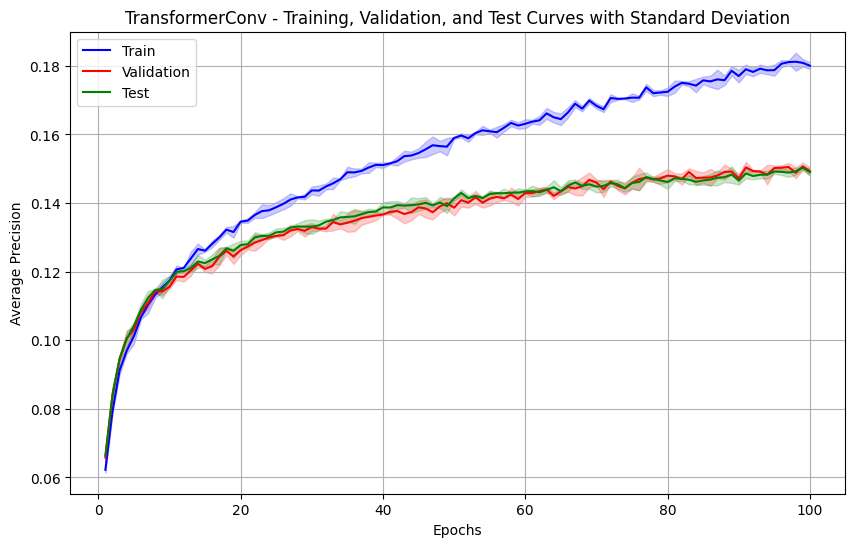

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation for each epoch
train_mean = np.mean(trans_record['train'], axis=0)
valid_mean = np.mean(trans_record['valid'], axis=0)
test_mean = np.mean(trans_record['test'], axis=0)

train_std = np.std(trans_record['train'], axis=0)
valid_std = np.std(trans_record['valid'], axis=0)
test_std = np.std(trans_record['test'], axis=0)

# Plotting
epochs = range(1, len(train_mean) + 1)
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_mean, label='Train', color='blue')
plt.fill_between(epochs, train_mean-train_std, train_mean+train_std, color='blue', alpha=0.2)

plt.plot(epochs, valid_mean, label='Validation', color='red')
plt.fill_between(epochs, valid_mean-valid_std, valid_mean+valid_std, color='red', alpha=0.2)

plt.plot(epochs, test_mean, label='Test', color='green')
plt.fill_between(epochs, test_mean-test_std, test_mean+test_std, color='green', alpha=0.2)

plt.title('TransformerConv - Training, Validation, and Test Curves with Standard Deviation')
plt.xlabel('Epochs')
plt.ylabel('Average Precision')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(trans_record)

{'train': [[0.06334542604194578, 0.08031639604317178, 0.09304086740803064, 0.09803887441036241, 0.10304753732801004, 0.10743774187488686, 0.11383195842248209, 0.11378163758385232, 0.11722062540043798, 0.11919005509846993, 0.12222301761204288, 0.1212378553248071, 0.12654902988714317, 0.12845724913280596, 0.12565085782147778, 0.12941248946283465, 0.12914535232851948, 0.13336137766439904, 0.1297355685693872, 0.13494762261100834, 0.13581564923187753, 0.13760466917135064, 0.1404295280718379, 0.13910450462504156, 0.14085629643809755, 0.14131020038260522, 0.14359925008137525, 0.14196918075390588, 0.14228730276386736, 0.14506654343017986, 0.14502884520105594, 0.14479789986703334, 0.1475932094648498, 0.14734275718167006, 0.15052564985832162, 0.1493003896970125, 0.14940465939083866, 0.15248743299065848, 0.15185954004378338, 0.1522231888824166, 0.1516747900480932, 0.1538127397185915, 0.15576811088872572, 0.15469018231484613, 0.15631889122337891, 0.1587982502422696, 0.16024115972121156, 0.15871023

In [ ]:
import json
with open('trans_record_new.json', 'w') as f:
    json.dump(trans_record, f)
from google.colab import files

files.download('trans_record_new.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
runtime.unassign()

#### GATv2

In [ ]:
gatv2_record = {'train': [], 'valid': [], 'test': []}

runs = 3

seeds = [42, 2226, 174]

for i in range(runs):
    torch.manual_seed(seeds[i])
    np.random.seed(seeds[i])
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seeds[i])
        torch.cuda.manual_seed_all(seeds[i])


    model = GNN(gnn_type = 'gatv2', num_tasks = 128, num_layer = 2, input_dim = 300, emb_dim = 300, drop_ratio = 0.5).to(device)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of trainable parameters: {trainable_params}")

    # optimizer = optim.Adam(model.parameters(), lr=1e-4)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)


    valid_curve = []
    test_curve = []
    train_curve = []

    epochs = 100

    for epoch in range(1, epochs + 1):
        print("=====Epoch {}".format(epoch))
        print('Training...')
        train(model, device, train_loader, optimizer)

        print('Evaluating...')
        train_perf = eval(model, device, train_loader, evaluator)
        valid_perf = eval(model, device, valid_loader, evaluator)
        test_perf = eval(model, device, test_loader, evaluator)

        print({'Train': train_perf, 'Validation': valid_perf, 'Test': test_perf})

        train_curve.append(train_perf['ap'])
        valid_curve.append(valid_perf['ap'])
        test_curve.append(test_perf['ap'])

        best_val_epoch = np.argmax(np.array(valid_curve))
        best_train = max(train_curve)

        print('Finished training!')
        print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
        print('Test score: {}'.format(test_curve[best_val_epoch]))

    print(f"----------------Finished run {i+1}!----------------")

    gatv2_record['train'].append(train_curve)
    gatv2_record['valid'].append(valid_curve)
    gatv2_record['test'].append(test_curve)

Total number of trainable parameters: 638228
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:46<00:00, 25.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:11<00:00, 30.96it/s]


{'Train': {'ap': 0.06250418425765773}, 'Validation': {'ap': 0.06484685019590737}, 'Test': {'ap': 0.067274692408198}}
Finished training!
Best validation score: 0.06484685019590737
Test score: 0.067274692408198
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.25it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.34it/s]


{'Train': {'ap': 0.07771299099746645}, 'Validation': {'ap': 0.0806889758554453}, 'Test': {'ap': 0.08246997635537019}}
Finished training!
Best validation score: 0.0806889758554453
Test score: 0.08246997635537019
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.98it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.74it/s]


{'Train': {'ap': 0.0859652784271179}, 'Validation': {'ap': 0.09252852361715412}, 'Test': {'ap': 0.09334320293323901}}
Finished training!
Best validation score: 0.09252852361715412
Test score: 0.09334320293323901
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.27it/s]


{'Train': {'ap': 0.0925727325130004}, 'Validation': {'ap': 0.09510357883340796}, 'Test': {'ap': 0.09772464377531419}}
Finished training!
Best validation score: 0.09510357883340796
Test score: 0.09772464377531419
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.23it/s]


{'Train': {'ap': 0.09727972561256036}, 'Validation': {'ap': 0.09893916575109524}, 'Test': {'ap': 0.10123493334317632}}
Finished training!
Best validation score: 0.09893916575109524
Test score: 0.10123493334317632
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.22it/s]


{'Train': {'ap': 0.09969536915560633}, 'Validation': {'ap': 0.10078687721650856}, 'Test': {'ap': 0.103294761641404}}
Finished training!
Best validation score: 0.10078687721650856
Test score: 0.103294761641404
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.11it/s]


{'Train': {'ap': 0.1030134471427854}, 'Validation': {'ap': 0.10447071584587972}, 'Test': {'ap': 0.10741879878688654}}
Finished training!
Best validation score: 0.10447071584587972
Test score: 0.10741879878688654
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 59.16it/s]


{'Train': {'ap': 0.10720471141601909}, 'Validation': {'ap': 0.10845373290172883}, 'Test': {'ap': 0.11227960126970736}}
Finished training!
Best validation score: 0.10845373290172883
Test score: 0.11227960126970736
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.30it/s]


{'Train': {'ap': 0.10846598008801414}, 'Validation': {'ap': 0.10868444130671474}, 'Test': {'ap': 0.11110916245926851}}
Finished training!
Best validation score: 0.10868444130671474
Test score: 0.11110916245926851
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.56it/s]


{'Train': {'ap': 0.1092482724090755}, 'Validation': {'ap': 0.10682807474432723}, 'Test': {'ap': 0.1137728989890662}}
Finished training!
Best validation score: 0.10868444130671474
Test score: 0.11110916245926851
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.28it/s]


{'Train': {'ap': 0.11294310604319034}, 'Validation': {'ap': 0.11293044635014217}, 'Test': {'ap': 0.11583506842536856}}
Finished training!
Best validation score: 0.11293044635014217
Test score: 0.11583506842536856
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.35it/s]


{'Train': {'ap': 0.11247671880919013}, 'Validation': {'ap': 0.11061695728013318}, 'Test': {'ap': 0.11488426146281666}}
Finished training!
Best validation score: 0.11293044635014217
Test score: 0.11583506842536856
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.22it/s]


{'Train': {'ap': 0.11679217690218183}, 'Validation': {'ap': 0.11358029846957006}, 'Test': {'ap': 0.11848849812092517}}
Finished training!
Best validation score: 0.11358029846957006
Test score: 0.11848849812092517
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.96it/s]


{'Train': {'ap': 0.1185196304225077}, 'Validation': {'ap': 0.11503802977840728}, 'Test': {'ap': 0.11862406374351689}}
Finished training!
Best validation score: 0.11503802977840728
Test score: 0.11862406374351689
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.89it/s]


{'Train': {'ap': 0.11915896144846128}, 'Validation': {'ap': 0.11667493605478191}, 'Test': {'ap': 0.12042989963371563}}
Finished training!
Best validation score: 0.11667493605478191
Test score: 0.12042989963371563
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.11it/s]


{'Train': {'ap': 0.1194676706439496}, 'Validation': {'ap': 0.1166055399229803}, 'Test': {'ap': 0.11962547106577888}}
Finished training!
Best validation score: 0.11667493605478191
Test score: 0.12042989963371563
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.44it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.60it/s]


{'Train': {'ap': 0.12079980890665838}, 'Validation': {'ap': 0.11883080578449685}, 'Test': {'ap': 0.12084316707608564}}
Finished training!
Best validation score: 0.11883080578449685
Test score: 0.12084316707608564
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.75it/s]


{'Train': {'ap': 0.12117470399143122}, 'Validation': {'ap': 0.11770459517968021}, 'Test': {'ap': 0.12330155207844955}}
Finished training!
Best validation score: 0.11883080578449685
Test score: 0.12084316707608564
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.48it/s]


{'Train': {'ap': 0.12324156575178782}, 'Validation': {'ap': 0.11785083394624372}, 'Test': {'ap': 0.12267869186512084}}
Finished training!
Best validation score: 0.11883080578449685
Test score: 0.12084316707608564
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.62it/s]


{'Train': {'ap': 0.12361519444134154}, 'Validation': {'ap': 0.11976262318830894}, 'Test': {'ap': 0.1240998445586481}}
Finished training!
Best validation score: 0.11976262318830894
Test score: 0.1240998445586481
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.18it/s]


{'Train': {'ap': 0.12421187119465463}, 'Validation': {'ap': 0.11708704855573425}, 'Test': {'ap': 0.12152248588830292}}
Finished training!
Best validation score: 0.11976262318830894
Test score: 0.1240998445586481
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.02it/s]


{'Train': {'ap': 0.1262368954022457}, 'Validation': {'ap': 0.12105728460275474}, 'Test': {'ap': 0.1252093601519825}}
Finished training!
Best validation score: 0.12105728460275474
Test score: 0.1252093601519825
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.39it/s]


{'Train': {'ap': 0.126463828567602}, 'Validation': {'ap': 0.12163040115137508}, 'Test': {'ap': 0.12548848284658218}}
Finished training!
Best validation score: 0.12163040115137508
Test score: 0.12548848284658218
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.37it/s]


{'Train': {'ap': 0.12804450656562713}, 'Validation': {'ap': 0.12230266846786873}, 'Test': {'ap': 0.12510907155418516}}
Finished training!
Best validation score: 0.12230266846786873
Test score: 0.12510907155418516
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.96it/s]


{'Train': {'ap': 0.12811114916860816}, 'Validation': {'ap': 0.12696904328288636}, 'Test': {'ap': 0.12798824095316932}}
Finished training!
Best validation score: 0.12696904328288636
Test score: 0.12798824095316932
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.37it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.32it/s]


{'Train': {'ap': 0.12899445929138942}, 'Validation': {'ap': 0.12220001445658406}, 'Test': {'ap': 0.12549574391167714}}
Finished training!
Best validation score: 0.12696904328288636
Test score: 0.12798824095316932
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.30it/s]


{'Train': {'ap': 0.13035990833971614}, 'Validation': {'ap': 0.1253180871938695}, 'Test': {'ap': 0.1277754555472566}}
Finished training!
Best validation score: 0.12696904328288636
Test score: 0.12798824095316932
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.50it/s]


{'Train': {'ap': 0.1307374427959772}, 'Validation': {'ap': 0.12509213890743}, 'Test': {'ap': 0.12790419071318615}}
Finished training!
Best validation score: 0.12696904328288636
Test score: 0.12798824095316932
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.24it/s]


{'Train': {'ap': 0.13245088021952556}, 'Validation': {'ap': 0.12363308124400789}, 'Test': {'ap': 0.12686453767949943}}
Finished training!
Best validation score: 0.12696904328288636
Test score: 0.12798824095316932
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.19it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.79it/s]


{'Train': {'ap': 0.1321537089621954}, 'Validation': {'ap': 0.12308572493836754}, 'Test': {'ap': 0.12675162955650388}}
Finished training!
Best validation score: 0.12696904328288636
Test score: 0.12798824095316932
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.19it/s]


{'Train': {'ap': 0.13458372386819234}, 'Validation': {'ap': 0.1317548357172523}, 'Test': {'ap': 0.12872422797350286}}
Finished training!
Best validation score: 0.1317548357172523
Test score: 0.12872422797350286
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.31it/s]


{'Train': {'ap': 0.13505870623766444}, 'Validation': {'ap': 0.12749664828879045}, 'Test': {'ap': 0.12917640824896914}}
Finished training!
Best validation score: 0.1317548357172523
Test score: 0.12872422797350286
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.71it/s]


{'Train': {'ap': 0.1367811238889118}, 'Validation': {'ap': 0.12974245060290893}, 'Test': {'ap': 0.129858823977974}}
Finished training!
Best validation score: 0.1317548357172523
Test score: 0.12872422797350286
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.94it/s]


{'Train': {'ap': 0.13520512459982847}, 'Validation': {'ap': 0.1287201431982659}, 'Test': {'ap': 0.12859515263057897}}
Finished training!
Best validation score: 0.1317548357172523
Test score: 0.12872422797350286
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.81it/s]


{'Train': {'ap': 0.13791516431364484}, 'Validation': {'ap': 0.1338611539481547}, 'Test': {'ap': 0.12966977481690747}}
Finished training!
Best validation score: 0.1338611539481547
Test score: 0.12966977481690747
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.90it/s]


{'Train': {'ap': 0.13632037205904105}, 'Validation': {'ap': 0.12807870305794045}, 'Test': {'ap': 0.13048962106387363}}
Finished training!
Best validation score: 0.1338611539481547
Test score: 0.12966977481690747
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.31it/s]


{'Train': {'ap': 0.13860193613849292}, 'Validation': {'ap': 0.1350248572774863}, 'Test': {'ap': 0.13080013820554834}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.21it/s]


{'Train': {'ap': 0.13953228108217683}, 'Validation': {'ap': 0.13378540367996408}, 'Test': {'ap': 0.13095731316689993}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.05it/s]


{'Train': {'ap': 0.13826761600406004}, 'Validation': {'ap': 0.13028310095491075}, 'Test': {'ap': 0.13108451187277756}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.92it/s]


{'Train': {'ap': 0.13892244999308775}, 'Validation': {'ap': 0.12924564686065246}, 'Test': {'ap': 0.13178315973341326}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.80it/s]


{'Train': {'ap': 0.13894486748053053}, 'Validation': {'ap': 0.130516933458279}, 'Test': {'ap': 0.12896491268238747}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.06it/s]


{'Train': {'ap': 0.1420668226329248}, 'Validation': {'ap': 0.13229552535061873}, 'Test': {'ap': 0.1330062134574249}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.22it/s]


{'Train': {'ap': 0.1412350031720259}, 'Validation': {'ap': 0.13030418436929955}, 'Test': {'ap': 0.1333264611917571}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 60.04it/s]


{'Train': {'ap': 0.1437022909279805}, 'Validation': {'ap': 0.13463738900756844}, 'Test': {'ap': 0.13137462959831303}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.33it/s]


{'Train': {'ap': 0.14386128927491196}, 'Validation': {'ap': 0.13197748568344386}, 'Test': {'ap': 0.13135570176009095}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.39it/s]


{'Train': {'ap': 0.14431398034276788}, 'Validation': {'ap': 0.13007694806969822}, 'Test': {'ap': 0.13166552572380796}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.10it/s]


{'Train': {'ap': 0.14292078123727456}, 'Validation': {'ap': 0.13184686325463205}, 'Test': {'ap': 0.1297830707844841}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.21it/s]


{'Train': {'ap': 0.14581371586677827}, 'Validation': {'ap': 0.13078174745888546}, 'Test': {'ap': 0.13499250095868004}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.06it/s]


{'Train': {'ap': 0.14488814416224127}, 'Validation': {'ap': 0.12913037082906048}, 'Test': {'ap': 0.13468370177291716}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.10it/s]


{'Train': {'ap': 0.14263110907484916}, 'Validation': {'ap': 0.1307215029989745}, 'Test': {'ap': 0.13143810213230026}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.11it/s]


{'Train': {'ap': 0.14735170874742307}, 'Validation': {'ap': 0.13303136613076133}, 'Test': {'ap': 0.1336754854105312}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.22it/s]


{'Train': {'ap': 0.14862572146806957}, 'Validation': {'ap': 0.1297100170678263}, 'Test': {'ap': 0.13164407187810392}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.47it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.24it/s]


{'Train': {'ap': 0.14765079640508225}, 'Validation': {'ap': 0.13370565533745196}, 'Test': {'ap': 0.13363847205998491}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.55it/s]


{'Train': {'ap': 0.14811780157493323}, 'Validation': {'ap': 0.1345640003134082}, 'Test': {'ap': 0.13512130785724238}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.37it/s]


{'Train': {'ap': 0.14948703390983006}, 'Validation': {'ap': 0.1305637210531321}, 'Test': {'ap': 0.1332326904790859}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.39it/s]


{'Train': {'ap': 0.1476813888676732}, 'Validation': {'ap': 0.13232968698041866}, 'Test': {'ap': 0.13566930583686954}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.38it/s]


{'Train': {'ap': 0.14806105625744959}, 'Validation': {'ap': 0.1345206149676439}, 'Test': {'ap': 0.13452009155319675}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.23it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.73it/s]


{'Train': {'ap': 0.1493105127884936}, 'Validation': {'ap': 0.13496803302194665}, 'Test': {'ap': 0.13405981035973458}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.42it/s]


{'Train': {'ap': 0.15108439794855957}, 'Validation': {'ap': 0.13483262828839268}, 'Test': {'ap': 0.13656906442489875}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.13it/s]


{'Train': {'ap': 0.1511319783081785}, 'Validation': {'ap': 0.1334862278824217}, 'Test': {'ap': 0.13435779113123375}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.96it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.40it/s]


{'Train': {'ap': 0.14939904443139296}, 'Validation': {'ap': 0.13210054919876796}, 'Test': {'ap': 0.13386229412854672}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.18it/s]


{'Train': {'ap': 0.15047408164134493}, 'Validation': {'ap': 0.1325336692463303}, 'Test': {'ap': 0.13454685602754518}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.35it/s]


{'Train': {'ap': 0.1532952188926439}, 'Validation': {'ap': 0.1342502027670115}, 'Test': {'ap': 0.13615306113460637}}
Finished training!
Best validation score: 0.1350248572774863
Test score: 0.13080013820554834
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.95it/s]


{'Train': {'ap': 0.14923062979519056}, 'Validation': {'ap': 0.13633850731968503}, 'Test': {'ap': 0.1348216797742747}}
Finished training!
Best validation score: 0.13633850731968503
Test score: 0.1348216797742747
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.01it/s]


{'Train': {'ap': 0.1537983514445715}, 'Validation': {'ap': 0.13668127757603724}, 'Test': {'ap': 0.1360818664455493}}
Finished training!
Best validation score: 0.13668127757603724
Test score: 0.1360818664455493
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.58it/s]


{'Train': {'ap': 0.15156119889178302}, 'Validation': {'ap': 0.13628007100233724}, 'Test': {'ap': 0.13554711885001242}}
Finished training!
Best validation score: 0.13668127757603724
Test score: 0.1360818664455493
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.23it/s]


{'Train': {'ap': 0.15310899913097042}, 'Validation': {'ap': 0.13497857485309486}, 'Test': {'ap': 0.13681174631289528}}
Finished training!
Best validation score: 0.13668127757603724
Test score: 0.1360818664455493
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.10it/s]


{'Train': {'ap': 0.15312986600772843}, 'Validation': {'ap': 0.13417509926733623}, 'Test': {'ap': 0.13417633279061691}}
Finished training!
Best validation score: 0.13668127757603724
Test score: 0.1360818664455493
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.74it/s]


{'Train': {'ap': 0.1521432604823983}, 'Validation': {'ap': 0.13217078002188373}, 'Test': {'ap': 0.13385060830571918}}
Finished training!
Best validation score: 0.13668127757603724
Test score: 0.1360818664455493
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.25it/s]


{'Train': {'ap': 0.15481183401738502}, 'Validation': {'ap': 0.13457486698762927}, 'Test': {'ap': 0.13599271150192088}}
Finished training!
Best validation score: 0.13668127757603724
Test score: 0.1360818664455493
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.04it/s]


{'Train': {'ap': 0.1540379067055015}, 'Validation': {'ap': 0.13525483053467627}, 'Test': {'ap': 0.1357156951300327}}
Finished training!
Best validation score: 0.13668127757603724
Test score: 0.1360818664455493
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.57it/s]


{'Train': {'ap': 0.1544103677880255}, 'Validation': {'ap': 0.1341150754620183}, 'Test': {'ap': 0.1348247163779907}}
Finished training!
Best validation score: 0.13668127757603724
Test score: 0.1360818664455493
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.47it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.12it/s]


{'Train': {'ap': 0.1556807356199973}, 'Validation': {'ap': 0.1353384382074258}, 'Test': {'ap': 0.13602819332763688}}
Finished training!
Best validation score: 0.13668127757603724
Test score: 0.1360818664455493
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.89it/s]


{'Train': {'ap': 0.15634227204113266}, 'Validation': {'ap': 0.1321319540673968}, 'Test': {'ap': 0.13463588452247635}}
Finished training!
Best validation score: 0.13668127757603724
Test score: 0.1360818664455493
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.88it/s]


{'Train': {'ap': 0.15361889893220176}, 'Validation': {'ap': 0.13645552787834023}, 'Test': {'ap': 0.13640325262202355}}
Finished training!
Best validation score: 0.13668127757603724
Test score: 0.1360818664455493
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.53it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.40it/s]


{'Train': {'ap': 0.15561994208129232}, 'Validation': {'ap': 0.13549785332817346}, 'Test': {'ap': 0.13714740540672732}}
Finished training!
Best validation score: 0.13668127757603724
Test score: 0.1360818664455493
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.33it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.55it/s]


{'Train': {'ap': 0.15864253511315757}, 'Validation': {'ap': 0.14151101891666157}, 'Test': {'ap': 0.13821204741868012}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.73it/s]


{'Train': {'ap': 0.15605891527007654}, 'Validation': {'ap': 0.1327945858115182}, 'Test': {'ap': 0.13543913630077362}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.07it/s]


{'Train': {'ap': 0.1579275557591001}, 'Validation': {'ap': 0.13735288954614217}, 'Test': {'ap': 0.13791615876476762}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 60.35it/s]


{'Train': {'ap': 0.15756330105510452}, 'Validation': {'ap': 0.13788296104198933}, 'Test': {'ap': 0.13873873353277813}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.54it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.33it/s]


{'Train': {'ap': 0.15925355875411376}, 'Validation': {'ap': 0.13492928401444146}, 'Test': {'ap': 0.13725321973646232}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.26it/s]


{'Train': {'ap': 0.15693801556244083}, 'Validation': {'ap': 0.1381112096480895}, 'Test': {'ap': 0.13740323586972428}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.21it/s]


{'Train': {'ap': 0.1568882770814269}, 'Validation': {'ap': 0.1344008826822472}, 'Test': {'ap': 0.13676466742287002}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.04it/s]


{'Train': {'ap': 0.16018079540289942}, 'Validation': {'ap': 0.13903820068246636}, 'Test': {'ap': 0.13581459560258075}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.27it/s]


{'Train': {'ap': 0.15679574950707648}, 'Validation': {'ap': 0.13655942689834158}, 'Test': {'ap': 0.13528989703584304}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.63it/s]


{'Train': {'ap': 0.15838327695167845}, 'Validation': {'ap': 0.13841777923318277}, 'Test': {'ap': 0.13835356765973802}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.13it/s]


{'Train': {'ap': 0.1615732610635348}, 'Validation': {'ap': 0.13610719623563927}, 'Test': {'ap': 0.1364068136716007}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.25it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.25it/s]


{'Train': {'ap': 0.1595518662201429}, 'Validation': {'ap': 0.13804252604785872}, 'Test': {'ap': 0.13830869411981395}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.64it/s]


{'Train': {'ap': 0.16131175039607504}, 'Validation': {'ap': 0.1396010338550979}, 'Test': {'ap': 0.14018488019381922}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.98it/s]


{'Train': {'ap': 0.16298741633201444}, 'Validation': {'ap': 0.1410271925206763}, 'Test': {'ap': 0.13806644736439863}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.77it/s]


{'Train': {'ap': 0.1596551318556546}, 'Validation': {'ap': 0.13825348902796214}, 'Test': {'ap': 0.13831100222266793}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.56it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.53it/s]


{'Train': {'ap': 0.15999458803698643}, 'Validation': {'ap': 0.13741547137666982}, 'Test': {'ap': 0.1371790603060584}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.61it/s]


{'Train': {'ap': 0.1617261434737321}, 'Validation': {'ap': 0.133493859706613}, 'Test': {'ap': 0.13513514349969244}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.84it/s]


{'Train': {'ap': 0.16163860483030099}, 'Validation': {'ap': 0.1392677137932572}, 'Test': {'ap': 0.13968178583415441}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.65it/s]


{'Train': {'ap': 0.16240454027000986}, 'Validation': {'ap': 0.13695808071546256}, 'Test': {'ap': 0.13969471167230924}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.55it/s]


{'Train': {'ap': 0.16262972236707554}, 'Validation': {'ap': 0.13900020930088416}, 'Test': {'ap': 0.13723083170097874}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.33it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.10it/s]


{'Train': {'ap': 0.1616595893651777}, 'Validation': {'ap': 0.13636813451904892}, 'Test': {'ap': 0.13725440231429123}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.94it/s]


{'Train': {'ap': 0.16158569518124463}, 'Validation': {'ap': 0.13860945541594502}, 'Test': {'ap': 0.13894993761244717}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.56it/s]


{'Train': {'ap': 0.16423967722316898}, 'Validation': {'ap': 0.1372770377000907}, 'Test': {'ap': 0.13984346732325745}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.25it/s]


{'Train': {'ap': 0.16558066804659097}, 'Validation': {'ap': 0.1390091881805474}, 'Test': {'ap': 0.14101392296372917}}
Finished training!
Best validation score: 0.14151101891666157
Test score: 0.13821204741868012
----------------Finished run 1!----------------
Total number of trainable parameters: 638228
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.69it/s]


{'Train': {'ap': 0.05985820060269554}, 'Validation': {'ap': 0.06279181919598442}, 'Test': {'ap': 0.06292512653288636}}
Finished training!
Best validation score: 0.06279181919598442
Test score: 0.06292512653288636
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.54it/s]


{'Train': {'ap': 0.07843873257029581}, 'Validation': {'ap': 0.08590053574168824}, 'Test': {'ap': 0.08512645106570682}}
Finished training!
Best validation score: 0.08590053574168824
Test score: 0.08512645106570682
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.13it/s]


{'Train': {'ap': 0.08647354668096906}, 'Validation': {'ap': 0.08964657815880994}, 'Test': {'ap': 0.09237762549525153}}
Finished training!
Best validation score: 0.08964657815880994
Test score: 0.09237762549525153
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.91it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.31it/s]


{'Train': {'ap': 0.09044712311300038}, 'Validation': {'ap': 0.09488821064851008}, 'Test': {'ap': 0.09559780761807528}}
Finished training!
Best validation score: 0.09488821064851008
Test score: 0.09559780761807528
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.14it/s]


{'Train': {'ap': 0.09598515168643536}, 'Validation': {'ap': 0.09830220560690747}, 'Test': {'ap': 0.10251546097490832}}
Finished training!
Best validation score: 0.09830220560690747
Test score: 0.10251546097490832
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.94it/s]


{'Train': {'ap': 0.10099368102675708}, 'Validation': {'ap': 0.10358846288726974}, 'Test': {'ap': 0.10770406541718636}}
Finished training!
Best validation score: 0.10358846288726974
Test score: 0.10770406541718636
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.89it/s]


{'Train': {'ap': 0.10325672989242968}, 'Validation': {'ap': 0.10660515277034736}, 'Test': {'ap': 0.10878646875544826}}
Finished training!
Best validation score: 0.10660515277034736
Test score: 0.10878646875544826
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.75it/s]


{'Train': {'ap': 0.10633448942686738}, 'Validation': {'ap': 0.10856773853977036}, 'Test': {'ap': 0.11036790195623436}}
Finished training!
Best validation score: 0.10856773853977036
Test score: 0.11036790195623436
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.26it/s]


{'Train': {'ap': 0.10704749478416167}, 'Validation': {'ap': 0.10767185105233641}, 'Test': {'ap': 0.10964009665502318}}
Finished training!
Best validation score: 0.10856773853977036
Test score: 0.11036790195623436
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.79it/s]


{'Train': {'ap': 0.11184604803539984}, 'Validation': {'ap': 0.10987502739858598}, 'Test': {'ap': 0.11378150430775259}}
Finished training!
Best validation score: 0.10987502739858598
Test score: 0.11378150430775259
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.27it/s]


{'Train': {'ap': 0.11130975501607858}, 'Validation': {'ap': 0.11264613017026355}, 'Test': {'ap': 0.11664011741824652}}
Finished training!
Best validation score: 0.11264613017026355
Test score: 0.11664011741824652
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.84it/s]


{'Train': {'ap': 0.11245677226328146}, 'Validation': {'ap': 0.11198388884190974}, 'Test': {'ap': 0.11552911437294677}}
Finished training!
Best validation score: 0.11264613017026355
Test score: 0.11664011741824652
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.58it/s]


{'Train': {'ap': 0.11299957677335681}, 'Validation': {'ap': 0.11419101268903012}, 'Test': {'ap': 0.11644622453195573}}
Finished training!
Best validation score: 0.11419101268903012
Test score: 0.11644622453195573
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.97it/s]


{'Train': {'ap': 0.11775614600708761}, 'Validation': {'ap': 0.11631705729109848}, 'Test': {'ap': 0.11938775119835664}}
Finished training!
Best validation score: 0.11631705729109848
Test score: 0.11938775119835664
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.64it/s]


{'Train': {'ap': 0.11911039584005033}, 'Validation': {'ap': 0.1170171707597701}, 'Test': {'ap': 0.1205913166050239}}
Finished training!
Best validation score: 0.1170171707597701
Test score: 0.1205913166050239
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.96it/s]


{'Train': {'ap': 0.11748139742712377}, 'Validation': {'ap': 0.1160414533740468}, 'Test': {'ap': 0.11995813029197985}}
Finished training!
Best validation score: 0.1170171707597701
Test score: 0.1205913166050239
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.68it/s]


{'Train': {'ap': 0.11891203074810397}, 'Validation': {'ap': 0.11564251812585777}, 'Test': {'ap': 0.1193529187654412}}
Finished training!
Best validation score: 0.1170171707597701
Test score: 0.1205913166050239
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.42it/s]


{'Train': {'ap': 0.12042634548956636}, 'Validation': {'ap': 0.117993946415872}, 'Test': {'ap': 0.12090493587756425}}
Finished training!
Best validation score: 0.117993946415872
Test score: 0.12090493587756425
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:07<00:00, 40.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.19it/s]


{'Train': {'ap': 0.12412840137466882}, 'Validation': {'ap': 0.11944274506574495}, 'Test': {'ap': 0.12265040909068702}}
Finished training!
Best validation score: 0.11944274506574495
Test score: 0.12265040909068702
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.64it/s]


{'Train': {'ap': 0.12154817468807314}, 'Validation': {'ap': 0.1176308926793046}, 'Test': {'ap': 0.12037034060424581}}
Finished training!
Best validation score: 0.11944274506574495
Test score: 0.12265040909068702
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.29it/s]


{'Train': {'ap': 0.12442348061688219}, 'Validation': {'ap': 0.11951785967458946}, 'Test': {'ap': 0.12356382734293764}}
Finished training!
Best validation score: 0.11951785967458946
Test score: 0.12356382734293764
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.93it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.05it/s]


{'Train': {'ap': 0.12467702091111972}, 'Validation': {'ap': 0.11901112889370558}, 'Test': {'ap': 0.12375982380502923}}
Finished training!
Best validation score: 0.11951785967458946
Test score: 0.12356382734293764
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.07it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.15it/s]


{'Train': {'ap': 0.12674534410404426}, 'Validation': {'ap': 0.11824384757791112}, 'Test': {'ap': 0.12227646728681683}}
Finished training!
Best validation score: 0.11951785967458946
Test score: 0.12356382734293764
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.95it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.71it/s]


{'Train': {'ap': 0.12754165392970127}, 'Validation': {'ap': 0.1210858071271002}, 'Test': {'ap': 0.12558009499707024}}
Finished training!
Best validation score: 0.1210858071271002
Test score: 0.12558009499707024
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.28it/s]


{'Train': {'ap': 0.12843720388154095}, 'Validation': {'ap': 0.12211121593725217}, 'Test': {'ap': 0.12455135652425044}}
Finished training!
Best validation score: 0.12211121593725217
Test score: 0.12455135652425044
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.01it/s]


{'Train': {'ap': 0.12837366923512916}, 'Validation': {'ap': 0.1240619036407915}, 'Test': {'ap': 0.126753807771103}}
Finished training!
Best validation score: 0.1240619036407915
Test score: 0.126753807771103
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.63it/s]


{'Train': {'ap': 0.1290441220990978}, 'Validation': {'ap': 0.12215672801562491}, 'Test': {'ap': 0.1235988977982296}}
Finished training!
Best validation score: 0.1240619036407915
Test score: 0.126753807771103
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.93it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.55it/s]


{'Train': {'ap': 0.13098466641200568}, 'Validation': {'ap': 0.12343391422800915}, 'Test': {'ap': 0.12426036532375608}}
Finished training!
Best validation score: 0.1240619036407915
Test score: 0.126753807771103
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.03it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.96it/s]


{'Train': {'ap': 0.13208475930812227}, 'Validation': {'ap': 0.12345282364110896}, 'Test': {'ap': 0.1265819287007302}}
Finished training!
Best validation score: 0.1240619036407915
Test score: 0.126753807771103
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.20it/s]


{'Train': {'ap': 0.13264814314985524}, 'Validation': {'ap': 0.12291076364058286}, 'Test': {'ap': 0.12696585617169462}}
Finished training!
Best validation score: 0.1240619036407915
Test score: 0.126753807771103
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.67it/s]


{'Train': {'ap': 0.13470195783261033}, 'Validation': {'ap': 0.12436386172368998}, 'Test': {'ap': 0.12800768296225573}}
Finished training!
Best validation score: 0.12436386172368998
Test score: 0.12800768296225573
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.73it/s]


{'Train': {'ap': 0.13371104240932752}, 'Validation': {'ap': 0.12389804240528454}, 'Test': {'ap': 0.1278039354383304}}
Finished training!
Best validation score: 0.12436386172368998
Test score: 0.12800768296225573
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.47it/s]


{'Train': {'ap': 0.1355189147282475}, 'Validation': {'ap': 0.12582802490804942}, 'Test': {'ap': 0.12806626768000273}}
Finished training!
Best validation score: 0.12582802490804942
Test score: 0.12806626768000273
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.95it/s]


{'Train': {'ap': 0.13505105215244925}, 'Validation': {'ap': 0.12382572367247577}, 'Test': {'ap': 0.127213064909003}}
Finished training!
Best validation score: 0.12582802490804942
Test score: 0.12806626768000273
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.02it/s]


{'Train': {'ap': 0.135536388120827}, 'Validation': {'ap': 0.12605226091618663}, 'Test': {'ap': 0.12791922340646608}}
Finished training!
Best validation score: 0.12605226091618663
Test score: 0.12791922340646608
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.27it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.09it/s]


{'Train': {'ap': 0.1361212616546972}, 'Validation': {'ap': 0.12808671644341912}, 'Test': {'ap': 0.12788530839969744}}
Finished training!
Best validation score: 0.12808671644341912
Test score: 0.12788530839969744
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.85it/s]


{'Train': {'ap': 0.1374356352468957}, 'Validation': {'ap': 0.1272681879980703}, 'Test': {'ap': 0.127738244089247}}
Finished training!
Best validation score: 0.12808671644341912
Test score: 0.12788530839969744
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.49it/s]


{'Train': {'ap': 0.13936835964862532}, 'Validation': {'ap': 0.13135580040642011}, 'Test': {'ap': 0.12918378092944072}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.33it/s]


{'Train': {'ap': 0.13919854388310296}, 'Validation': {'ap': 0.12845840159698724}, 'Test': {'ap': 0.1322390754054661}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.12it/s]


{'Train': {'ap': 0.14055141352604347}, 'Validation': {'ap': 0.12638016309404965}, 'Test': {'ap': 0.13023767790249693}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.97it/s]


{'Train': {'ap': 0.14100128271742687}, 'Validation': {'ap': 0.1288034208318136}, 'Test': {'ap': 0.13072856726702203}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.98it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.11it/s]


{'Train': {'ap': 0.13776656486406894}, 'Validation': {'ap': 0.12527432526512175}, 'Test': {'ap': 0.13028310446695202}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.84it/s]


{'Train': {'ap': 0.1429532718012288}, 'Validation': {'ap': 0.12613417786694536}, 'Test': {'ap': 0.1297380770103095}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.56it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.62it/s]


{'Train': {'ap': 0.1425249437885724}, 'Validation': {'ap': 0.12712343760471168}, 'Test': {'ap': 0.13136980017927496}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.49it/s]


{'Train': {'ap': 0.14133595714166602}, 'Validation': {'ap': 0.12697354743170372}, 'Test': {'ap': 0.12882484845757503}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.29it/s]


{'Train': {'ap': 0.14408263226175222}, 'Validation': {'ap': 0.12881818851863916}, 'Test': {'ap': 0.13032538887433925}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.56it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.25it/s]


{'Train': {'ap': 0.1465712492243362}, 'Validation': {'ap': 0.13013652143428794}, 'Test': {'ap': 0.13279044663092285}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.03it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.68it/s]


{'Train': {'ap': 0.14323679232976363}, 'Validation': {'ap': 0.12871724249346125}, 'Test': {'ap': 0.1316194526344394}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.31it/s]


{'Train': {'ap': 0.14630131988602801}, 'Validation': {'ap': 0.13048227179623426}, 'Test': {'ap': 0.13080951341747954}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.94it/s]


{'Train': {'ap': 0.14637971624599697}, 'Validation': {'ap': 0.12712382323806026}, 'Test': {'ap': 0.1317633248924352}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.93it/s]


{'Train': {'ap': 0.14580953868555296}, 'Validation': {'ap': 0.13046263202963299}, 'Test': {'ap': 0.13417008255801785}}
Finished training!
Best validation score: 0.13135580040642011
Test score: 0.12918378092944072
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.19it/s]


{'Train': {'ap': 0.14723007346712857}, 'Validation': {'ap': 0.1329376532594977}, 'Test': {'ap': 0.13227682590597895}}
Finished training!
Best validation score: 0.1329376532594977
Test score: 0.13227682590597895
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.60it/s]


{'Train': {'ap': 0.14661036604449978}, 'Validation': {'ap': 0.12814308023686627}, 'Test': {'ap': 0.13042509331507118}}
Finished training!
Best validation score: 0.1329376532594977
Test score: 0.13227682590597895
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.21it/s]


{'Train': {'ap': 0.14707971038865222}, 'Validation': {'ap': 0.12956451811143976}, 'Test': {'ap': 0.13349895161691053}}
Finished training!
Best validation score: 0.1329376532594977
Test score: 0.13227682590597895
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.32it/s]


{'Train': {'ap': 0.14777822937632162}, 'Validation': {'ap': 0.1311174975994671}, 'Test': {'ap': 0.1354548998368197}}
Finished training!
Best validation score: 0.1329376532594977
Test score: 0.13227682590597895
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.96it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.44it/s]


{'Train': {'ap': 0.14852434446788054}, 'Validation': {'ap': 0.1289657718440174}, 'Test': {'ap': 0.13165810428233196}}
Finished training!
Best validation score: 0.1329376532594977
Test score: 0.13227682590597895
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.94it/s]


{'Train': {'ap': 0.14851514294733112}, 'Validation': {'ap': 0.13457823082862866}, 'Test': {'ap': 0.13542805975090502}}
Finished training!
Best validation score: 0.13457823082862866
Test score: 0.13542805975090502
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.34it/s]


{'Train': {'ap': 0.14657820671206281}, 'Validation': {'ap': 0.1314074027301929}, 'Test': {'ap': 0.13142611310607513}}
Finished training!
Best validation score: 0.13457823082862866
Test score: 0.13542805975090502
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.17it/s]


{'Train': {'ap': 0.15077657003735173}, 'Validation': {'ap': 0.1320728929580733}, 'Test': {'ap': 0.133446061232599}}
Finished training!
Best validation score: 0.13457823082862866
Test score: 0.13542805975090502
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.87it/s]


{'Train': {'ap': 0.15004806937998266}, 'Validation': {'ap': 0.13093405369983027}, 'Test': {'ap': 0.13429271552157854}}
Finished training!
Best validation score: 0.13457823082862866
Test score: 0.13542805975090502
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.67it/s]


{'Train': {'ap': 0.15334244147255427}, 'Validation': {'ap': 0.13346157079741755}, 'Test': {'ap': 0.13444081278233516}}
Finished training!
Best validation score: 0.13457823082862866
Test score: 0.13542805975090502
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.82it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.68it/s]


{'Train': {'ap': 0.15188452553451778}, 'Validation': {'ap': 0.13264848600400006}, 'Test': {'ap': 0.13515984630172895}}
Finished training!
Best validation score: 0.13457823082862866
Test score: 0.13542805975090502
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 59.92it/s]


{'Train': {'ap': 0.15102419027229866}, 'Validation': {'ap': 0.13318418476527544}, 'Test': {'ap': 0.13609213831573982}}
Finished training!
Best validation score: 0.13457823082862866
Test score: 0.13542805975090502
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.12it/s]


{'Train': {'ap': 0.15323218971293803}, 'Validation': {'ap': 0.1344550273776094}, 'Test': {'ap': 0.13570049000715007}}
Finished training!
Best validation score: 0.13457823082862866
Test score: 0.13542805975090502
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.08it/s]


{'Train': {'ap': 0.153686974227096}, 'Validation': {'ap': 0.13333228451773796}, 'Test': {'ap': 0.13471196644310268}}
Finished training!
Best validation score: 0.13457823082862866
Test score: 0.13542805975090502
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.12it/s]


{'Train': {'ap': 0.15130533018779513}, 'Validation': {'ap': 0.1316344054914247}, 'Test': {'ap': 0.135225793108769}}
Finished training!
Best validation score: 0.13457823082862866
Test score: 0.13542805975090502
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.77it/s]


{'Train': {'ap': 0.15321413541439838}, 'Validation': {'ap': 0.1355797311669476}, 'Test': {'ap': 0.13738467799387452}}
Finished training!
Best validation score: 0.1355797311669476
Test score: 0.13738467799387452
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.44it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.86it/s]


{'Train': {'ap': 0.15464675186401947}, 'Validation': {'ap': 0.13340006976167673}, 'Test': {'ap': 0.13553624034085754}}
Finished training!
Best validation score: 0.1355797311669476
Test score: 0.13738467799387452
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.87it/s]


{'Train': {'ap': 0.1525177286210572}, 'Validation': {'ap': 0.1329953330453583}, 'Test': {'ap': 0.13586357497419144}}
Finished training!
Best validation score: 0.1355797311669476
Test score: 0.13738467799387452
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.43it/s]


{'Train': {'ap': 0.15361241392837208}, 'Validation': {'ap': 0.13632315641347595}, 'Test': {'ap': 0.138179898271021}}
Finished training!
Best validation score: 0.13632315641347595
Test score: 0.138179898271021
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.99it/s]


{'Train': {'ap': 0.15424840461326667}, 'Validation': {'ap': 0.1346330107237405}, 'Test': {'ap': 0.1358793746310087}}
Finished training!
Best validation score: 0.13632315641347595
Test score: 0.138179898271021
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.25it/s]


{'Train': {'ap': 0.15633649321115894}, 'Validation': {'ap': 0.1370342616316335}, 'Test': {'ap': 0.1370824073344994}}
Finished training!
Best validation score: 0.1370342616316335
Test score: 0.1370824073344994
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.75it/s]


{'Train': {'ap': 0.1564506695221886}, 'Validation': {'ap': 0.13515208109700608}, 'Test': {'ap': 0.13699556961194018}}
Finished training!
Best validation score: 0.1370342616316335
Test score: 0.1370824073344994
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.26it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.56it/s]


{'Train': {'ap': 0.15539132750913784}, 'Validation': {'ap': 0.13823920669744627}, 'Test': {'ap': 0.1370204947084379}}
Finished training!
Best validation score: 0.13823920669744627
Test score: 0.1370204947084379
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.80it/s]


{'Train': {'ap': 0.1566629740052879}, 'Validation': {'ap': 0.1376338773420871}, 'Test': {'ap': 0.1386038754020996}}
Finished training!
Best validation score: 0.13823920669744627
Test score: 0.1370204947084379
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.00it/s]


{'Train': {'ap': 0.15546126571928312}, 'Validation': {'ap': 0.13409734687804006}, 'Test': {'ap': 0.1358153176024499}}
Finished training!
Best validation score: 0.13823920669744627
Test score: 0.1370204947084379
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.24it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.09it/s]


{'Train': {'ap': 0.15664621715981827}, 'Validation': {'ap': 0.13865148204098024}, 'Test': {'ap': 0.1389723105790586}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.82it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.39it/s]


{'Train': {'ap': 0.15426482288504964}, 'Validation': {'ap': 0.1335612182175761}, 'Test': {'ap': 0.1356990872797685}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.34it/s]


{'Train': {'ap': 0.1567687910078206}, 'Validation': {'ap': 0.13641745162383168}, 'Test': {'ap': 0.13719592213525517}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.73it/s]


{'Train': {'ap': 0.15867050415822095}, 'Validation': {'ap': 0.13533407718245713}, 'Test': {'ap': 0.1375370463715006}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.90it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.71it/s]


{'Train': {'ap': 0.1541415629218194}, 'Validation': {'ap': 0.1353634872089306}, 'Test': {'ap': 0.13677526769875362}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.80it/s]


{'Train': {'ap': 0.1596900377416509}, 'Validation': {'ap': 0.1367119732852265}, 'Test': {'ap': 0.13714401742404148}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.10it/s]


{'Train': {'ap': 0.15727825234593884}, 'Validation': {'ap': 0.13689178921652084}, 'Test': {'ap': 0.1378355310174666}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.15it/s]


{'Train': {'ap': 0.1558713581098581}, 'Validation': {'ap': 0.13451226758565762}, 'Test': {'ap': 0.13765189384401696}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.44it/s]


{'Train': {'ap': 0.15525099472469822}, 'Validation': {'ap': 0.13451072516512225}, 'Test': {'ap': 0.1356284446331468}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.96it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.65it/s]


{'Train': {'ap': 0.16080179182447393}, 'Validation': {'ap': 0.13585353128655195}, 'Test': {'ap': 0.13831714661672492}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.58it/s]


{'Train': {'ap': 0.15694692297167642}, 'Validation': {'ap': 0.13609365820806948}, 'Test': {'ap': 0.13794468030262239}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.44it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.55it/s]


{'Train': {'ap': 0.161902642841086}, 'Validation': {'ap': 0.1376034354541775}, 'Test': {'ap': 0.1400942848749389}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.53it/s]


{'Train': {'ap': 0.15866952302082113}, 'Validation': {'ap': 0.13713640369718252}, 'Test': {'ap': 0.13754521902151778}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.41it/s]


{'Train': {'ap': 0.1581065244185572}, 'Validation': {'ap': 0.1349480509902096}, 'Test': {'ap': 0.1368507576305078}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.19it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.34it/s]


{'Train': {'ap': 0.15948599052730142}, 'Validation': {'ap': 0.13849885996659128}, 'Test': {'ap': 0.13930629860510818}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.41it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.62it/s]


{'Train': {'ap': 0.1612217507838048}, 'Validation': {'ap': 0.137725725904946}, 'Test': {'ap': 0.13984168100020558}}
Finished training!
Best validation score: 0.13865148204098024
Test score: 0.1389723105790586
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.54it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.63it/s]


{'Train': {'ap': 0.16209004227370186}, 'Validation': {'ap': 0.13967160208971766}, 'Test': {'ap': 0.13953479129712512}}
Finished training!
Best validation score: 0.13967160208971766
Test score: 0.13953479129712512
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.18it/s]


{'Train': {'ap': 0.15949873804113224}, 'Validation': {'ap': 0.13646836818450347}, 'Test': {'ap': 0.13893191717313844}}
Finished training!
Best validation score: 0.13967160208971766
Test score: 0.13953479129712512
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.67it/s]


{'Train': {'ap': 0.16045732309501118}, 'Validation': {'ap': 0.13610973571859597}, 'Test': {'ap': 0.13757881219655077}}
Finished training!
Best validation score: 0.13967160208971766
Test score: 0.13953479129712512
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.05it/s]


{'Train': {'ap': 0.1597482074729917}, 'Validation': {'ap': 0.13608186242884532}, 'Test': {'ap': 0.1384170061689271}}
Finished training!
Best validation score: 0.13967160208971766
Test score: 0.13953479129712512
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.93it/s]


{'Train': {'ap': 0.16200825713411124}, 'Validation': {'ap': 0.13727143394244393}, 'Test': {'ap': 0.13843373493939704}}
Finished training!
Best validation score: 0.13967160208971766
Test score: 0.13953479129712512
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.72it/s]


{'Train': {'ap': 0.16390444688835462}, 'Validation': {'ap': 0.14011199159185592}, 'Test': {'ap': 0.13944016147569951}}
Finished training!
Best validation score: 0.14011199159185592
Test score: 0.13944016147569951
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.17it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.92it/s]


{'Train': {'ap': 0.16323553640539704}, 'Validation': {'ap': 0.1380699602369397}, 'Test': {'ap': 0.13863127673360115}}
Finished training!
Best validation score: 0.14011199159185592
Test score: 0.13944016147569951
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.18it/s]


{'Train': {'ap': 0.16345222850553826}, 'Validation': {'ap': 0.13906448768632917}, 'Test': {'ap': 0.13889150458199342}}
Finished training!
Best validation score: 0.14011199159185592
Test score: 0.13944016147569951
----------------Finished run 2!----------------
Total number of trainable parameters: 638228
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.51it/s]


{'Train': {'ap': 0.06277623750887747}, 'Validation': {'ap': 0.0648403662189063}, 'Test': {'ap': 0.06622761445277066}}
Finished training!
Best validation score: 0.0648403662189063
Test score: 0.06622761445277066
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.99it/s]


{'Train': {'ap': 0.07682827674432084}, 'Validation': {'ap': 0.07767349195328864}, 'Test': {'ap': 0.07949336515161526}}
Finished training!
Best validation score: 0.07767349195328864
Test score: 0.07949336515161526
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.25it/s]


{'Train': {'ap': 0.08605086271917517}, 'Validation': {'ap': 0.0875792549528292}, 'Test': {'ap': 0.08914776239149323}}
Finished training!
Best validation score: 0.0875792549528292
Test score: 0.08914776239149323
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.80it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.55it/s]


{'Train': {'ap': 0.09113101111899255}, 'Validation': {'ap': 0.09464428823265643}, 'Test': {'ap': 0.09407007265231211}}
Finished training!
Best validation score: 0.09464428823265643
Test score: 0.09407007265231211
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.50it/s]


{'Train': {'ap': 0.09655096023939372}, 'Validation': {'ap': 0.09834250608229658}, 'Test': {'ap': 0.10326253345005587}}
Finished training!
Best validation score: 0.09834250608229658
Test score: 0.10326253345005587
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.05it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.56it/s]


{'Train': {'ap': 0.10094062506700476}, 'Validation': {'ap': 0.10279339974777255}, 'Test': {'ap': 0.10596330048418504}}
Finished training!
Best validation score: 0.10279339974777255
Test score: 0.10596330048418504
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.99it/s]


{'Train': {'ap': 0.10277566947473836}, 'Validation': {'ap': 0.10327188924178012}, 'Test': {'ap': 0.10630844871866298}}
Finished training!
Best validation score: 0.10327188924178012
Test score: 0.10630844871866298
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.28it/s]


{'Train': {'ap': 0.10676435304916744}, 'Validation': {'ap': 0.10755136661339297}, 'Test': {'ap': 0.1106774605914832}}
Finished training!
Best validation score: 0.10755136661339297
Test score: 0.1106774605914832
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.93it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.32it/s]


{'Train': {'ap': 0.10841278312511445}, 'Validation': {'ap': 0.1087768626095135}, 'Test': {'ap': 0.11065804796609621}}
Finished training!
Best validation score: 0.1087768626095135
Test score: 0.11065804796609621
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.11it/s]


{'Train': {'ap': 0.10889224368643674}, 'Validation': {'ap': 0.10903163016806419}, 'Test': {'ap': 0.11219209581971021}}
Finished training!
Best validation score: 0.10903163016806419
Test score: 0.11219209581971021
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.64it/s]


{'Train': {'ap': 0.11174255437038291}, 'Validation': {'ap': 0.11084712518768905}, 'Test': {'ap': 0.11614803681762445}}
Finished training!
Best validation score: 0.11084712518768905
Test score: 0.11614803681762445
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.59it/s]


{'Train': {'ap': 0.11304543146269846}, 'Validation': {'ap': 0.11423412761611978}, 'Test': {'ap': 0.11683787584322688}}
Finished training!
Best validation score: 0.11423412761611978
Test score: 0.11683787584322688
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.98it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.19it/s]


{'Train': {'ap': 0.11504123880340104}, 'Validation': {'ap': 0.11484064314984717}, 'Test': {'ap': 0.11907824096828887}}
Finished training!
Best validation score: 0.11484064314984717
Test score: 0.11907824096828887
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.49it/s]


{'Train': {'ap': 0.11751433921762938}, 'Validation': {'ap': 0.11547431321533307}, 'Test': {'ap': 0.11913509477227253}}
Finished training!
Best validation score: 0.11547431321533307
Test score: 0.11913509477227253
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.97it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.61it/s]


{'Train': {'ap': 0.11854173703733316}, 'Validation': {'ap': 0.11733169107215141}, 'Test': {'ap': 0.12168331809098443}}
Finished training!
Best validation score: 0.11733169107215141
Test score: 0.12168331809098443
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.91it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.07it/s]


{'Train': {'ap': 0.12005035582879287}, 'Validation': {'ap': 0.11623770261295761}, 'Test': {'ap': 0.12173701434760853}}
Finished training!
Best validation score: 0.11733169107215141
Test score: 0.12168331809098443
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.35it/s]


{'Train': {'ap': 0.12161380512740473}, 'Validation': {'ap': 0.1171487325019288}, 'Test': {'ap': 0.12323391549902223}}
Finished training!
Best validation score: 0.11733169107215141
Test score: 0.12168331809098443
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.05it/s]


{'Train': {'ap': 0.12002526762654464}, 'Validation': {'ap': 0.11755361718808874}, 'Test': {'ap': 0.11739382324354856}}
Finished training!
Best validation score: 0.11755361718808874
Test score: 0.11739382324354856
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.49it/s]


{'Train': {'ap': 0.12227366486734838}, 'Validation': {'ap': 0.11912579357949171}, 'Test': {'ap': 0.12284373051180959}}
Finished training!
Best validation score: 0.11912579357949171
Test score: 0.12284373051180959
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.92it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.53it/s]


{'Train': {'ap': 0.12230076189894033}, 'Validation': {'ap': 0.11832479314831516}, 'Test': {'ap': 0.12130517368792675}}
Finished training!
Best validation score: 0.11912579357949171
Test score: 0.12284373051180959
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.34it/s]


{'Train': {'ap': 0.12564393396987808}, 'Validation': {'ap': 0.1205677147201384}, 'Test': {'ap': 0.12367718545102362}}
Finished training!
Best validation score: 0.1205677147201384
Test score: 0.12367718545102362
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.95it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.92it/s]


{'Train': {'ap': 0.12809786095504228}, 'Validation': {'ap': 0.12124669189943747}, 'Test': {'ap': 0.12520673794180126}}
Finished training!
Best validation score: 0.12124669189943747
Test score: 0.12520673794180126
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.38it/s]


{'Train': {'ap': 0.12699965526393697}, 'Validation': {'ap': 0.1232521740062461}, 'Test': {'ap': 0.12682842336475245}}
Finished training!
Best validation score: 0.1232521740062461
Test score: 0.12682842336475245
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.11it/s]


{'Train': {'ap': 0.1250915680069103}, 'Validation': {'ap': 0.12046714049885755}, 'Test': {'ap': 0.12309682476141857}}
Finished training!
Best validation score: 0.1232521740062461
Test score: 0.12682842336475245
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.83it/s]


{'Train': {'ap': 0.12919140197753845}, 'Validation': {'ap': 0.1261197921899352}, 'Test': {'ap': 0.12704837439334427}}
Finished training!
Best validation score: 0.1261197921899352
Test score: 0.12704837439334427
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.52it/s]


{'Train': {'ap': 0.12962913358301872}, 'Validation': {'ap': 0.12397991930775339}, 'Test': {'ap': 0.12505600259463415}}
Finished training!
Best validation score: 0.1261197921899352
Test score: 0.12704837439334427
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.83it/s]


{'Train': {'ap': 0.129533858485285}, 'Validation': {'ap': 0.12483526509191159}, 'Test': {'ap': 0.12576854703932286}}
Finished training!
Best validation score: 0.1261197921899352
Test score: 0.12704837439334427
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.48it/s]


{'Train': {'ap': 0.1254403267713462}, 'Validation': {'ap': 0.12321519621275254}, 'Test': {'ap': 0.12278644095630363}}
Finished training!
Best validation score: 0.1261197921899352
Test score: 0.12704837439334427
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.91it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.79it/s]


{'Train': {'ap': 0.13418599196491066}, 'Validation': {'ap': 0.12435220146263931}, 'Test': {'ap': 0.12657609575814016}}
Finished training!
Best validation score: 0.1261197921899352
Test score: 0.12704837439334427
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.90it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.19it/s]


{'Train': {'ap': 0.1324486893673093}, 'Validation': {'ap': 0.130336326823046}, 'Test': {'ap': 0.128571358340783}}
Finished training!
Best validation score: 0.130336326823046
Test score: 0.128571358340783
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.22it/s]


{'Train': {'ap': 0.13492708410118048}, 'Validation': {'ap': 0.12643839893078548}, 'Test': {'ap': 0.12932352904828648}}
Finished training!
Best validation score: 0.130336326823046
Test score: 0.128571358340783
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.93it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.28it/s]


{'Train': {'ap': 0.1336395192851209}, 'Validation': {'ap': 0.12738804366741388}, 'Test': {'ap': 0.1308521512577431}}
Finished training!
Best validation score: 0.130336326823046
Test score: 0.128571358340783
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.29it/s]


{'Train': {'ap': 0.13525328643859977}, 'Validation': {'ap': 0.12774578187917235}, 'Test': {'ap': 0.1306840707549706}}
Finished training!
Best validation score: 0.130336326823046
Test score: 0.128571358340783
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.98it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.81it/s]


{'Train': {'ap': 0.13643330157642533}, 'Validation': {'ap': 0.12690177769205752}, 'Test': {'ap': 0.13066715547779015}}
Finished training!
Best validation score: 0.130336326823046
Test score: 0.128571358340783
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.67it/s]


{'Train': {'ap': 0.13419680340344234}, 'Validation': {'ap': 0.1272668943564961}, 'Test': {'ap': 0.12905214692803174}}
Finished training!
Best validation score: 0.130336326823046
Test score: 0.128571358340783
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.56it/s]


{'Train': {'ap': 0.13459839723259334}, 'Validation': {'ap': 0.1226258865090606}, 'Test': {'ap': 0.1286847098828281}}
Finished training!
Best validation score: 0.130336326823046
Test score: 0.128571358340783
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.95it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.42it/s]


{'Train': {'ap': 0.1369842249580264}, 'Validation': {'ap': 0.1287193571057778}, 'Test': {'ap': 0.13052640355717973}}
Finished training!
Best validation score: 0.130336326823046
Test score: 0.128571358340783
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.08it/s]


{'Train': {'ap': 0.13889576919832197}, 'Validation': {'ap': 0.1318423207055469}, 'Test': {'ap': 0.13244899811053398}}
Finished training!
Best validation score: 0.1318423207055469
Test score: 0.13244899811053398
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 38.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.85it/s]


{'Train': {'ap': 0.13882628263005978}, 'Validation': {'ap': 0.12461873844258696}, 'Test': {'ap': 0.128511669238794}}
Finished training!
Best validation score: 0.1318423207055469
Test score: 0.13244899811053398
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.89it/s]


{'Train': {'ap': 0.13885262644879937}, 'Validation': {'ap': 0.12900816261466316}, 'Test': {'ap': 0.12953088639977323}}
Finished training!
Best validation score: 0.1318423207055469
Test score: 0.13244899811053398
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.96it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.93it/s]


{'Train': {'ap': 0.1408227453403266}, 'Validation': {'ap': 0.12722851820806402}, 'Test': {'ap': 0.1306407882093518}}
Finished training!
Best validation score: 0.1318423207055469
Test score: 0.13244899811053398
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.42it/s]


{'Train': {'ap': 0.13877235897347048}, 'Validation': {'ap': 0.12538766298678608}, 'Test': {'ap': 0.1292179204595775}}
Finished training!
Best validation score: 0.1318423207055469
Test score: 0.13244899811053398
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.87it/s]


{'Train': {'ap': 0.14046427925938057}, 'Validation': {'ap': 0.13144651310313207}, 'Test': {'ap': 0.1312461261417799}}
Finished training!
Best validation score: 0.1318423207055469
Test score: 0.13244899811053398
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.82it/s]


{'Train': {'ap': 0.14080099995447523}, 'Validation': {'ap': 0.12891354108868558}, 'Test': {'ap': 0.12998614027384078}}
Finished training!
Best validation score: 0.1318423207055469
Test score: 0.13244899811053398
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.46it/s]


{'Train': {'ap': 0.1392731336901313}, 'Validation': {'ap': 0.12734678381631193}, 'Test': {'ap': 0.12961790319251398}}
Finished training!
Best validation score: 0.1318423207055469
Test score: 0.13244899811053398
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.83it/s]


{'Train': {'ap': 0.14264505119406828}, 'Validation': {'ap': 0.12834101364700237}, 'Test': {'ap': 0.13138937603523396}}
Finished training!
Best validation score: 0.1318423207055469
Test score: 0.13244899811053398
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.19it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.43it/s]


{'Train': {'ap': 0.14217758902241584}, 'Validation': {'ap': 0.13363200630439678}, 'Test': {'ap': 0.13416214218720868}}
Finished training!
Best validation score: 0.13363200630439678
Test score: 0.13416214218720868
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.24it/s]


{'Train': {'ap': 0.14344116762847553}, 'Validation': {'ap': 0.12911934580902534}, 'Test': {'ap': 0.13361515579042335}}
Finished training!
Best validation score: 0.13363200630439678
Test score: 0.13416214218720868
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.98it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.68it/s]


{'Train': {'ap': 0.14348914480843317}, 'Validation': {'ap': 0.13257694810146478}, 'Test': {'ap': 0.13296615494409603}}
Finished training!
Best validation score: 0.13363200630439678
Test score: 0.13416214218720868
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.16it/s]


{'Train': {'ap': 0.1435014614266741}, 'Validation': {'ap': 0.13193304247700807}, 'Test': {'ap': 0.13349719201816232}}
Finished training!
Best validation score: 0.13363200630439678
Test score: 0.13416214218720868
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.99it/s]


{'Train': {'ap': 0.14582047174826998}, 'Validation': {'ap': 0.13392092779871015}, 'Test': {'ap': 0.13418679335361633}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.13it/s]


{'Train': {'ap': 0.14569187505027675}, 'Validation': {'ap': 0.13274441786204452}, 'Test': {'ap': 0.13459940352250044}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.23it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.36it/s]


{'Train': {'ap': 0.14695114758966824}, 'Validation': {'ap': 0.13241641163934215}, 'Test': {'ap': 0.1342251204786189}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.06it/s]


{'Train': {'ap': 0.144908867646174}, 'Validation': {'ap': 0.13006644758182004}, 'Test': {'ap': 0.13246661272858523}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.91it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.85it/s]


{'Train': {'ap': 0.14527536694472665}, 'Validation': {'ap': 0.13269478580642247}, 'Test': {'ap': 0.133639061307695}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.69it/s]


{'Train': {'ap': 0.1482217671065417}, 'Validation': {'ap': 0.1329910585330294}, 'Test': {'ap': 0.13281805445309428}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.69it/s]


{'Train': {'ap': 0.1466542164477413}, 'Validation': {'ap': 0.13041049305042968}, 'Test': {'ap': 0.13266911569758308}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.00it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.23it/s]


{'Train': {'ap': 0.14943504939032032}, 'Validation': {'ap': 0.13388720194545345}, 'Test': {'ap': 0.13465433111218542}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.71it/s]


{'Train': {'ap': 0.14926848406904705}, 'Validation': {'ap': 0.13339346099674065}, 'Test': {'ap': 0.13376595281296608}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.06it/s]


{'Train': {'ap': 0.14841224396583735}, 'Validation': {'ap': 0.1337032859419835}, 'Test': {'ap': 0.13391228404041858}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.01it/s]


{'Train': {'ap': 0.1475450767589481}, 'Validation': {'ap': 0.13111337447329627}, 'Test': {'ap': 0.13278433377979945}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.97it/s]


{'Train': {'ap': 0.14885958628894147}, 'Validation': {'ap': 0.1302027722017263}, 'Test': {'ap': 0.13415702651077754}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.83it/s]


{'Train': {'ap': 0.1497840651360784}, 'Validation': {'ap': 0.13262741407170445}, 'Test': {'ap': 0.13537663951643317}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.81it/s]


{'Train': {'ap': 0.14984326788394264}, 'Validation': {'ap': 0.13382391176292113}, 'Test': {'ap': 0.13531505385108167}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.16it/s]


{'Train': {'ap': 0.15108352064614422}, 'Validation': {'ap': 0.13387290324263318}, 'Test': {'ap': 0.13492325578076972}}
Finished training!
Best validation score: 0.13392092779871015
Test score: 0.13418679335361633
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.89it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.90it/s]


{'Train': {'ap': 0.15021717167702064}, 'Validation': {'ap': 0.1339783996947678}, 'Test': {'ap': 0.13525049107521714}}
Finished training!
Best validation score: 0.1339783996947678
Test score: 0.13525049107521714
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.48it/s]


{'Train': {'ap': 0.15203407140617078}, 'Validation': {'ap': 0.132557042119501}, 'Test': {'ap': 0.13764584675084013}}
Finished training!
Best validation score: 0.1339783996947678
Test score: 0.13525049107521714
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.94it/s]


{'Train': {'ap': 0.15242801632827369}, 'Validation': {'ap': 0.13562624655193237}, 'Test': {'ap': 0.13636689469764976}}
Finished training!
Best validation score: 0.13562624655193237
Test score: 0.13636689469764976
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.32it/s]


{'Train': {'ap': 0.15202554826092043}, 'Validation': {'ap': 0.13193045518385316}, 'Test': {'ap': 0.13496845305679656}}
Finished training!
Best validation score: 0.13562624655193237
Test score: 0.13636689469764976
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.21it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.31it/s]


{'Train': {'ap': 0.15188411034767485}, 'Validation': {'ap': 0.13445710590077858}, 'Test': {'ap': 0.13451618871835622}}
Finished training!
Best validation score: 0.13562624655193237
Test score: 0.13636689469764976
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.03it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.59it/s]


{'Train': {'ap': 0.15101797649699727}, 'Validation': {'ap': 0.13563485079086066}, 'Test': {'ap': 0.1356800703578073}}
Finished training!
Best validation score: 0.13563485079086066
Test score: 0.1356800703578073
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.69it/s]


{'Train': {'ap': 0.15371708117373337}, 'Validation': {'ap': 0.13492537166811783}, 'Test': {'ap': 0.13622258218766295}}
Finished training!
Best validation score: 0.13563485079086066
Test score: 0.1356800703578073
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.20it/s]


{'Train': {'ap': 0.15335043602511675}, 'Validation': {'ap': 0.1368366186541014}, 'Test': {'ap': 0.13745879436149372}}
Finished training!
Best validation score: 0.1368366186541014
Test score: 0.13745879436149372
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.94it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.03it/s]


{'Train': {'ap': 0.15344115385284987}, 'Validation': {'ap': 0.13442779375599173}, 'Test': {'ap': 0.13365127279586067}}
Finished training!
Best validation score: 0.1368366186541014
Test score: 0.13745879436149372
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.01it/s]


{'Train': {'ap': 0.15475156071589063}, 'Validation': {'ap': 0.1336266471007535}, 'Test': {'ap': 0.13754021498623215}}
Finished training!
Best validation score: 0.1368366186541014
Test score: 0.13745879436149372
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.84it/s]


{'Train': {'ap': 0.15323303926506465}, 'Validation': {'ap': 0.135897478553014}, 'Test': {'ap': 0.1363113043656654}}
Finished training!
Best validation score: 0.1368366186541014
Test score: 0.13745879436149372
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.45it/s]


{'Train': {'ap': 0.15571388471060396}, 'Validation': {'ap': 0.13294758039076632}, 'Test': {'ap': 0.1355328097888738}}
Finished training!
Best validation score: 0.1368366186541014
Test score: 0.13745879436149372
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.16it/s]


{'Train': {'ap': 0.1542754376874889}, 'Validation': {'ap': 0.13604575227987623}, 'Test': {'ap': 0.13733662316525072}}
Finished training!
Best validation score: 0.1368366186541014
Test score: 0.13745879436149372
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.40it/s]


{'Train': {'ap': 0.15357379635653504}, 'Validation': {'ap': 0.1366095457006966}, 'Test': {'ap': 0.13526415358744312}}
Finished training!
Best validation score: 0.1368366186541014
Test score: 0.13745879436149372
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.78it/s]


{'Train': {'ap': 0.15818054828074127}, 'Validation': {'ap': 0.13660371590666892}, 'Test': {'ap': 0.13705287197682825}}
Finished training!
Best validation score: 0.1368366186541014
Test score: 0.13745879436149372
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.40it/s]


{'Train': {'ap': 0.1577858413701248}, 'Validation': {'ap': 0.13662249676862123}, 'Test': {'ap': 0.13823497474569824}}
Finished training!
Best validation score: 0.1368366186541014
Test score: 0.13745879436149372
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.12it/s]


{'Train': {'ap': 0.15981405890879394}, 'Validation': {'ap': 0.13741509227658355}, 'Test': {'ap': 0.13743454091269036}}
Finished training!
Best validation score: 0.13741509227658355
Test score: 0.13743454091269036
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.88it/s]


{'Train': {'ap': 0.1566815263128254}, 'Validation': {'ap': 0.13704657811964063}, 'Test': {'ap': 0.13799927280533192}}
Finished training!
Best validation score: 0.13741509227658355
Test score: 0.13743454091269036
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.47it/s]


{'Train': {'ap': 0.15749999226229852}, 'Validation': {'ap': 0.13253134884000173}, 'Test': {'ap': 0.13642587675875983}}
Finished training!
Best validation score: 0.13741509227658355
Test score: 0.13743454091269036
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.38it/s]


{'Train': {'ap': 0.15782883471484066}, 'Validation': {'ap': 0.13732288933427053}, 'Test': {'ap': 0.13800797834642695}}
Finished training!
Best validation score: 0.13741509227658355
Test score: 0.13743454091269036
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.80it/s]


{'Train': {'ap': 0.15790575142055463}, 'Validation': {'ap': 0.13784356198155678}, 'Test': {'ap': 0.1378536308917024}}
Finished training!
Best validation score: 0.13784356198155678
Test score: 0.1378536308917024
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.92it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.19it/s]


{'Train': {'ap': 0.15907964437621272}, 'Validation': {'ap': 0.1346883021047574}, 'Test': {'ap': 0.1378963368585114}}
Finished training!
Best validation score: 0.13784356198155678
Test score: 0.1378536308917024
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.87it/s]


{'Train': {'ap': 0.16002543489291285}, 'Validation': {'ap': 0.1364140622412147}, 'Test': {'ap': 0.13665353174974607}}
Finished training!
Best validation score: 0.13784356198155678
Test score: 0.1378536308917024
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.27it/s]


{'Train': {'ap': 0.1582624650677679}, 'Validation': {'ap': 0.13799433275934012}, 'Test': {'ap': 0.13959114944312526}}
Finished training!
Best validation score: 0.13799433275934012
Test score: 0.13959114944312526
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.48it/s]


{'Train': {'ap': 0.16031579743965194}, 'Validation': {'ap': 0.13790200477412226}, 'Test': {'ap': 0.1402968090819455}}
Finished training!
Best validation score: 0.13799433275934012
Test score: 0.13959114944312526
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.30it/s]


{'Train': {'ap': 0.16135972957851602}, 'Validation': {'ap': 0.13421853554985994}, 'Test': {'ap': 0.13770845693372674}}
Finished training!
Best validation score: 0.13799433275934012
Test score: 0.13959114944312526
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.07it/s]


{'Train': {'ap': 0.1613205789264503}, 'Validation': {'ap': 0.13838751970244895}, 'Test': {'ap': 0.14031136344660985}}
Finished training!
Best validation score: 0.13838751970244895
Test score: 0.14031136344660985
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 77.03it/s]


{'Train': {'ap': 0.16009082524473886}, 'Validation': {'ap': 0.13770771613795754}, 'Test': {'ap': 0.13966806271453797}}
Finished training!
Best validation score: 0.13838751970244895
Test score: 0.14031136344660985
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.75it/s]


{'Train': {'ap': 0.15932780529028537}, 'Validation': {'ap': 0.13769104599385948}, 'Test': {'ap': 0.13750543917719177}}
Finished training!
Best validation score: 0.13838751970244895
Test score: 0.14031136344660985
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.69it/s]


{'Train': {'ap': 0.1606246099458513}, 'Validation': {'ap': 0.13845173092819132}, 'Test': {'ap': 0.13822991222041778}}
Finished training!
Best validation score: 0.13845173092819132
Test score: 0.13822991222041778
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.94it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.60it/s]


{'Train': {'ap': 0.1595756150143942}, 'Validation': {'ap': 0.13721414529997022}, 'Test': {'ap': 0.13740417661607812}}
Finished training!
Best validation score: 0.13845173092819132
Test score: 0.13822991222041778
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.40it/s]


{'Train': {'ap': 0.16275857702964433}, 'Validation': {'ap': 0.13813602531114627}, 'Test': {'ap': 0.138217974720117}}
Finished training!
Best validation score: 0.13845173092819132
Test score: 0.13822991222041778
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.48it/s]


{'Train': {'ap': 0.16269810681042374}, 'Validation': {'ap': 0.13775596376531946}, 'Test': {'ap': 0.13920448482956194}}
Finished training!
Best validation score: 0.13845173092819132
Test score: 0.13822991222041778
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 40.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.55it/s]


{'Train': {'ap': 0.1633270461005251}, 'Validation': {'ap': 0.13894102271958447}, 'Test': {'ap': 0.13998142372177264}}
Finished training!
Best validation score: 0.13894102271958447
Test score: 0.13998142372177264
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.59it/s]


{'Train': {'ap': 0.16437400475848818}, 'Validation': {'ap': 0.13950113154307442}, 'Test': {'ap': 0.13946192366829013}}
Finished training!
Best validation score: 0.13950113154307442
Test score: 0.13946192366829013
----------------Finished run 3!----------------


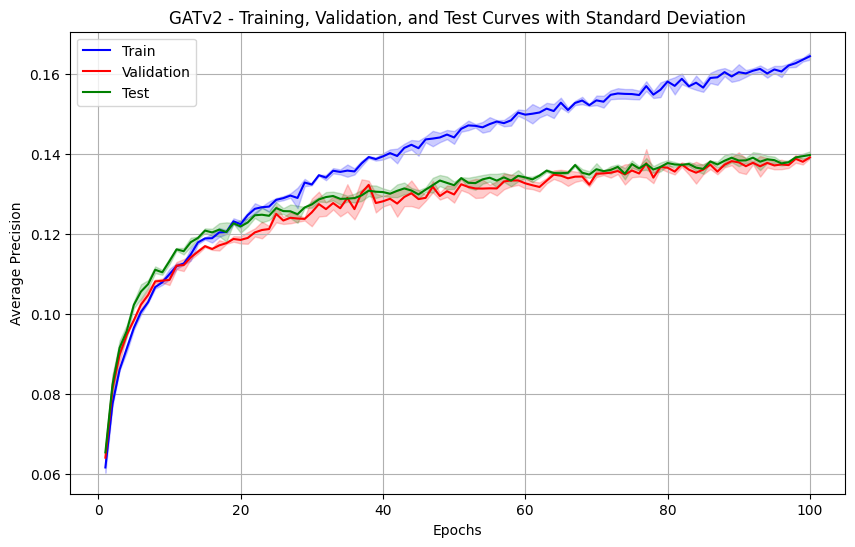

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation for each epoch
train_mean = np.mean(gatv2_record['train'], axis=0)
valid_mean = np.mean(gatv2_record['valid'], axis=0)
test_mean = np.mean(gatv2_record['test'], axis=0)

train_std = np.std(gatv2_record['train'], axis=0)
valid_std = np.std(gatv2_record['valid'], axis=0)
test_std = np.std(gatv2_record['test'], axis=0)

# Plotting
epochs = range(1, len(train_mean) + 1)
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_mean, label='Train', color='blue')
plt.fill_between(epochs, train_mean-train_std, train_mean+train_std, color='blue', alpha=0.2)

plt.plot(epochs, valid_mean, label='Validation', color='red')
plt.fill_between(epochs, valid_mean-valid_std, valid_mean+valid_std, color='red', alpha=0.2)

plt.plot(epochs, test_mean, label='Test', color='green')
plt.fill_between(epochs, test_mean-test_std, test_mean+test_std, color='green', alpha=0.2)

plt.title('GATv2 - Training, Validation, and Test Curves with Standard Deviation')
plt.xlabel('Epochs')
plt.ylabel('Average Precision')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(gatv2_record)

{'train': [[0.06250418425765773, 0.07771299099746645, 0.0859652784271179, 0.0925727325130004, 0.09727972561256036, 0.09969536915560633, 0.1030134471427854, 0.10720471141601909, 0.10846598008801414, 0.1092482724090755, 0.11294310604319034, 0.11247671880919013, 0.11679217690218183, 0.1185196304225077, 0.11915896144846128, 0.1194676706439496, 0.12079980890665838, 0.12117470399143122, 0.12324156575178782, 0.12361519444134154, 0.12421187119465463, 0.1262368954022457, 0.126463828567602, 0.12804450656562713, 0.12811114916860816, 0.12899445929138942, 0.13035990833971614, 0.1307374427959772, 0.13245088021952556, 0.1321537089621954, 0.13458372386819234, 0.13505870623766444, 0.1367811238889118, 0.13520512459982847, 0.13791516431364484, 0.13632037205904105, 0.13860193613849292, 0.13953228108217683, 0.13826761600406004, 0.13892244999308775, 0.13894486748053053, 0.1420668226329248, 0.1412350031720259, 0.1437022909279805, 0.14386128927491196, 0.14431398034276788, 0.14292078123727456, 0.14581371586677

In [ ]:
import json
with open('gatv2_record_new.json', 'w') as f:
    json.dump(gatv2_record, f)
from google.colab import files

files.download('gatv2_record_new.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json
with open('gatv2_record_new.json', 'w') as f:
    json.dump(gatv2_record, f)
from google.colab import files

files.download('gatv2_record_new.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

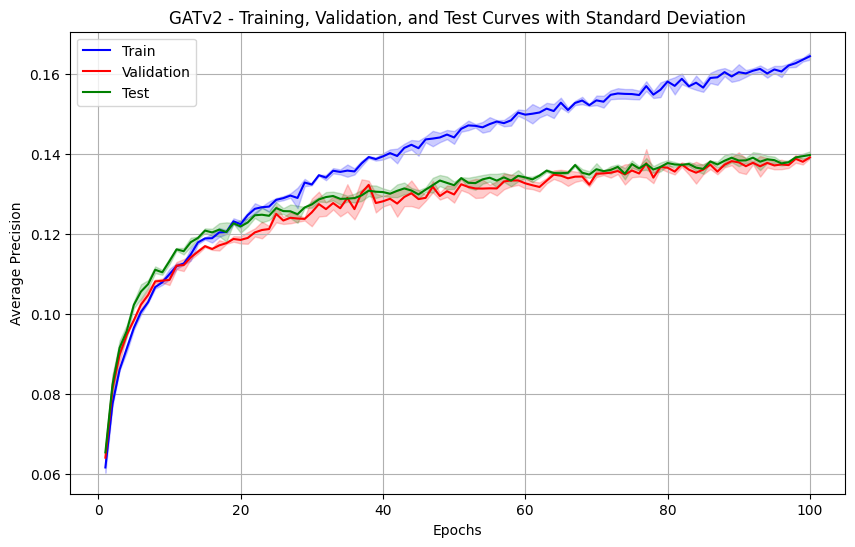

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation for each epoch
train_mean = np.mean(gatv2_record['train'], axis=0)
valid_mean = np.mean(gatv2_record['valid'], axis=0)
test_mean = np.mean(gatv2_record['test'], axis=0)

train_std = np.std(gatv2_record['train'], axis=0)
valid_std = np.std(gatv2_record['valid'], axis=0)
test_std = np.std(gatv2_record['test'], axis=0)

# Plotting
epochs = range(1, len(train_mean) + 1)
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_mean, label='Train', color='blue')
plt.fill_between(epochs, train_mean-train_std, train_mean+train_std, color='blue', alpha=0.2)

plt.plot(epochs, valid_mean, label='Validation', color='red')
plt.fill_between(epochs, valid_mean-valid_std, valid_mean+valid_std, color='red', alpha=0.2)

plt.plot(epochs, test_mean, label='Test', color='green')
plt.fill_between(epochs, test_mean-test_std, test_mean+test_std, color='green', alpha=0.2)

plt.title('GATv2 - Training, Validation, and Test Curves with Standard Deviation')
plt.xlabel('Epochs')
plt.ylabel('Average Precision')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
runtime.unassign()

## Experiments - GATv2 & TransformerConv (with Virtual Node)

In [ ]:
import time

In [ ]:
run_experiment(num_epochs=100, b_size=128, num_runs=1, seeds=[42, 2226, 174], model_type='gatv2', num_layers=2, input_d=300, emb_d=300, dropout_ratio=0.5, l_rate=1e-3, w_decay=1e-6, use_virtual_node=True)

Total number of trainable parameters: 820328
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:51<00:00, 24.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:11<00:00, 29.45it/s]


{'Train': {'ap': 0.08642755643664675}, 'Validation': {'ap': 0.08463436578844243}, 'Test': {'ap': 0.08793982504521321}}
Finished training!
Best validation score: 0.08463436578844243
Test score: 0.08793982504521321
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.94it/s]


{'Train': {'ap': 0.09438182508058712}, 'Validation': {'ap': 0.09796502285365097}, 'Test': {'ap': 0.10012719296684255}}
Finished training!
Best validation score: 0.09796502285365097
Test score: 0.10012719296684255
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.22it/s]


{'Train': {'ap': 0.10526218308301363}, 'Validation': {'ap': 0.10177747902212336}, 'Test': {'ap': 0.104578238125216}}
Finished training!
Best validation score: 0.10177747902212336
Test score: 0.104578238125216
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.28it/s]


{'Train': {'ap': 0.1064760583230696}, 'Validation': {'ap': 0.10437344263924982}, 'Test': {'ap': 0.10927101053166519}}
Finished training!
Best validation score: 0.10437344263924982
Test score: 0.10927101053166519
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.39it/s]


{'Train': {'ap': 0.11975051549113279}, 'Validation': {'ap': 0.11711469183156026}, 'Test': {'ap': 0.11888340263490223}}
Finished training!
Best validation score: 0.11711469183156026
Test score: 0.11888340263490223
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.27it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.05it/s]


{'Train': {'ap': 0.12214224952358796}, 'Validation': {'ap': 0.1138210212079692}, 'Test': {'ap': 0.11679466978410263}}
Finished training!
Best validation score: 0.11711469183156026
Test score: 0.11888340263490223
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.36it/s]


{'Train': {'ap': 0.11984679299008842}, 'Validation': {'ap': 0.11297160956145602}, 'Test': {'ap': 0.1145172874282412}}
Finished training!
Best validation score: 0.11711469183156026
Test score: 0.11888340263490223
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.26it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.23it/s]


{'Train': {'ap': 0.13603616895864917}, 'Validation': {'ap': 0.12472791326415371}, 'Test': {'ap': 0.12778950081463827}}
Finished training!
Best validation score: 0.12472791326415371
Test score: 0.12778950081463827
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.26it/s]


{'Train': {'ap': 0.13082603366947299}, 'Validation': {'ap': 0.12101032897420473}, 'Test': {'ap': 0.12582253560525247}}
Finished training!
Best validation score: 0.12472791326415371
Test score: 0.12778950081463827
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.99it/s]


{'Train': {'ap': 0.11912398154391002}, 'Validation': {'ap': 0.11410689064940088}, 'Test': {'ap': 0.11695988088742053}}
Finished training!
Best validation score: 0.12472791326415371
Test score: 0.12778950081463827
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.96it/s]


{'Train': {'ap': 0.13239539010299192}, 'Validation': {'ap': 0.12358772474217454}, 'Test': {'ap': 0.12480183775346754}}
Finished training!
Best validation score: 0.12472791326415371
Test score: 0.12778950081463827
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.53it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.43it/s]


{'Train': {'ap': 0.13306597130333453}, 'Validation': {'ap': 0.1297070644062905}, 'Test': {'ap': 0.1311028683663916}}
Finished training!
Best validation score: 0.1297070644062905
Test score: 0.1311028683663916
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.64it/s]


{'Train': {'ap': 0.14335359664709557}, 'Validation': {'ap': 0.12893853839638536}, 'Test': {'ap': 0.13355708211070796}}
Finished training!
Best validation score: 0.1297070644062905
Test score: 0.1311028683663916
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.07it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.12it/s]


{'Train': {'ap': 0.15144176497445658}, 'Validation': {'ap': 0.13416805963691567}, 'Test': {'ap': 0.1390186746642918}}
Finished training!
Best validation score: 0.13416805963691567
Test score: 0.1390186746642918
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.19it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.12it/s]


{'Train': {'ap': 0.14949449195647266}, 'Validation': {'ap': 0.13426623160385795}, 'Test': {'ap': 0.1349447934492922}}
Finished training!
Best validation score: 0.13426623160385795
Test score: 0.1349447934492922
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.27it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.38it/s]


{'Train': {'ap': 0.15524596897114498}, 'Validation': {'ap': 0.13734579492918378}, 'Test': {'ap': 0.13956488666281625}}
Finished training!
Best validation score: 0.13734579492918378
Test score: 0.13956488666281625
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.60it/s]


{'Train': {'ap': 0.15752514995500663}, 'Validation': {'ap': 0.14057624716828754}, 'Test': {'ap': 0.14017323216066724}}
Finished training!
Best validation score: 0.14057624716828754
Test score: 0.14017323216066724
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.25it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.96it/s]


{'Train': {'ap': 0.14628650844320268}, 'Validation': {'ap': 0.13023368010894273}, 'Test': {'ap': 0.13565082418096086}}
Finished training!
Best validation score: 0.14057624716828754
Test score: 0.14017323216066724
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.33it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.35it/s]


{'Train': {'ap': 0.15312441404566945}, 'Validation': {'ap': 0.13552206056022253}, 'Test': {'ap': 0.14206732196259714}}
Finished training!
Best validation score: 0.14057624716828754
Test score: 0.14017323216066724
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.64it/s]


{'Train': {'ap': 0.153941615289991}, 'Validation': {'ap': 0.13739796440450927}, 'Test': {'ap': 0.13794574409702742}}
Finished training!
Best validation score: 0.14057624716828754
Test score: 0.14017323216066724
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.44it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.03it/s]


{'Train': {'ap': 0.16204528081178238}, 'Validation': {'ap': 0.14447598687393343}, 'Test': {'ap': 0.1426906633880457}}
Finished training!
Best validation score: 0.14447598687393343
Test score: 0.1426906633880457
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.09it/s]


{'Train': {'ap': 0.1534511724596999}, 'Validation': {'ap': 0.13416983190251366}, 'Test': {'ap': 0.13886168566739449}}
Finished training!
Best validation score: 0.14447598687393343
Test score: 0.1426906633880457
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.05it/s]


{'Train': {'ap': 0.15909361364943073}, 'Validation': {'ap': 0.13560780210114814}, 'Test': {'ap': 0.13728901129111074}}
Finished training!
Best validation score: 0.14447598687393343
Test score: 0.1426906633880457
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.34it/s]


{'Train': {'ap': 0.16932935855832126}, 'Validation': {'ap': 0.14466627346118432}, 'Test': {'ap': 0.14478006028622972}}
Finished training!
Best validation score: 0.14466627346118432
Test score: 0.14478006028622972
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.36it/s]


{'Train': {'ap': 0.16363998004242686}, 'Validation': {'ap': 0.14603745194956255}, 'Test': {'ap': 0.1439305742473993}}
Finished training!
Best validation score: 0.14603745194956255
Test score: 0.1439305742473993
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.44it/s]


{'Train': {'ap': 0.16269422839572362}, 'Validation': {'ap': 0.14166219448711792}, 'Test': {'ap': 0.1439982528399152}}
Finished training!
Best validation score: 0.14603745194956255
Test score: 0.1439305742473993
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.50it/s]


{'Train': {'ap': 0.1655196841721281}, 'Validation': {'ap': 0.14155194496444165}, 'Test': {'ap': 0.142279434704285}}
Finished training!
Best validation score: 0.14603745194956255
Test score: 0.1439305742473993
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.53it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.42it/s]


{'Train': {'ap': 0.1515199890133904}, 'Validation': {'ap': 0.1323641054436688}, 'Test': {'ap': 0.13226188772292308}}
Finished training!
Best validation score: 0.14603745194956255
Test score: 0.1439305742473993
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.02it/s]


{'Train': {'ap': 0.16498361169047274}, 'Validation': {'ap': 0.14345683027166437}, 'Test': {'ap': 0.1436291900450295}}
Finished training!
Best validation score: 0.14603745194956255
Test score: 0.1439305742473993
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.65it/s]


{'Train': {'ap': 0.16703498975388642}, 'Validation': {'ap': 0.1384890848483006}, 'Test': {'ap': 0.13919047011211108}}
Finished training!
Best validation score: 0.14603745194956255
Test score: 0.1439305742473993
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.96it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.06it/s]


{'Train': {'ap': 0.166149477105028}, 'Validation': {'ap': 0.14346097002229163}, 'Test': {'ap': 0.146185276129058}}
Finished training!
Best validation score: 0.14603745194956255
Test score: 0.1439305742473993
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.46it/s]


{'Train': {'ap': 0.1765390510824389}, 'Validation': {'ap': 0.15026820491136678}, 'Test': {'ap': 0.14259822042577722}}
Finished training!
Best validation score: 0.15026820491136678
Test score: 0.14259822042577722
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.68it/s]


{'Train': {'ap': 0.1687428694548243}, 'Validation': {'ap': 0.1498313878070916}, 'Test': {'ap': 0.1455465924973143}}
Finished training!
Best validation score: 0.15026820491136678
Test score: 0.14259822042577722
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.56it/s]


{'Train': {'ap': 0.1682998903516005}, 'Validation': {'ap': 0.14573109614166307}, 'Test': {'ap': 0.14559442261139058}}
Finished training!
Best validation score: 0.15026820491136678
Test score: 0.14259822042577722
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.22it/s]


{'Train': {'ap': 0.17324482312497858}, 'Validation': {'ap': 0.14667660156123244}, 'Test': {'ap': 0.1425320014601618}}
Finished training!
Best validation score: 0.15026820491136678
Test score: 0.14259822042577722
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:06<00:00, 56.20it/s]


{'Train': {'ap': 0.16993990648818108}, 'Validation': {'ap': 0.14974618432214776}, 'Test': {'ap': 0.14213902942422718}}
Finished training!
Best validation score: 0.15026820491136678
Test score: 0.14259822042577722
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.64it/s]


{'Train': {'ap': 0.17385542562962153}, 'Validation': {'ap': 0.14453842118229226}, 'Test': {'ap': 0.14840407567670277}}
Finished training!
Best validation score: 0.15026820491136678
Test score: 0.14259822042577722
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.92it/s]


{'Train': {'ap': 0.16894013993135013}, 'Validation': {'ap': 0.14407178505422502}, 'Test': {'ap': 0.1451022274906363}}
Finished training!
Best validation score: 0.15026820491136678
Test score: 0.14259822042577722
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.70it/s]


{'Train': {'ap': 0.17025649169379214}, 'Validation': {'ap': 0.1461528277874146}, 'Test': {'ap': 0.14441865281101723}}
Finished training!
Best validation score: 0.15026820491136678
Test score: 0.14259822042577722
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.07it/s]


{'Train': {'ap': 0.17182291928675103}, 'Validation': {'ap': 0.14455231768149876}, 'Test': {'ap': 0.14631810858045063}}
Finished training!
Best validation score: 0.15026820491136678
Test score: 0.14259822042577722
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.23it/s]


{'Train': {'ap': 0.17176977277719593}, 'Validation': {'ap': 0.1435182164717178}, 'Test': {'ap': 0.14617822848924503}}
Finished training!
Best validation score: 0.15026820491136678
Test score: 0.14259822042577722
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.49it/s]


{'Train': {'ap': 0.17097238253621144}, 'Validation': {'ap': 0.14309066587081612}, 'Test': {'ap': 0.14425013330694886}}
Finished training!
Best validation score: 0.15026820491136678
Test score: 0.14259822042577722
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.85it/s]


{'Train': {'ap': 0.1770599847304423}, 'Validation': {'ap': 0.1510407585584631}, 'Test': {'ap': 0.14837792023197108}}
Finished training!
Best validation score: 0.1510407585584631
Test score: 0.14837792023197108
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.48it/s]


{'Train': {'ap': 0.18520670321958033}, 'Validation': {'ap': 0.15127713442873494}, 'Test': {'ap': 0.1488898555809991}}
Finished training!
Best validation score: 0.15127713442873494
Test score: 0.1488898555809991
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.10it/s]


{'Train': {'ap': 0.17715813555028284}, 'Validation': {'ap': 0.14844380086203735}, 'Test': {'ap': 0.14653172539949474}}
Finished training!
Best validation score: 0.15127713442873494
Test score: 0.1488898555809991
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.31it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.08it/s]


{'Train': {'ap': 0.17181890830606536}, 'Validation': {'ap': 0.13961306955380695}, 'Test': {'ap': 0.13960006199600103}}
Finished training!
Best validation score: 0.15127713442873494
Test score: 0.1488898555809991
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.03it/s]


{'Train': {'ap': 0.17553264772591629}, 'Validation': {'ap': 0.14688606838180385}, 'Test': {'ap': 0.14817964434023487}}
Finished training!
Best validation score: 0.15127713442873494
Test score: 0.1488898555809991
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.49it/s]


{'Train': {'ap': 0.18043941035972597}, 'Validation': {'ap': 0.1518897367049642}, 'Test': {'ap': 0.14888820475772502}}
Finished training!
Best validation score: 0.1518897367049642
Test score: 0.14888820475772502
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.12it/s]


{'Train': {'ap': 0.1618833490077382}, 'Validation': {'ap': 0.14003422642434415}, 'Test': {'ap': 0.1408935231570888}}
Finished training!
Best validation score: 0.1518897367049642
Test score: 0.14888820475772502
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.53it/s]


{'Train': {'ap': 0.18497343098861865}, 'Validation': {'ap': 0.15489975292070096}, 'Test': {'ap': 0.1508718668674446}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.26it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.61it/s]


{'Train': {'ap': 0.18085864134790988}, 'Validation': {'ap': 0.14787007588675727}, 'Test': {'ap': 0.14962938494385586}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.47it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.92it/s]


{'Train': {'ap': 0.18713748919876644}, 'Validation': {'ap': 0.1530718185653906}, 'Test': {'ap': 0.14921010951718658}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.89it/s]


{'Train': {'ap': 0.17808760542057187}, 'Validation': {'ap': 0.1472183412253306}, 'Test': {'ap': 0.1452394384081432}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.25it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.26it/s]


{'Train': {'ap': 0.18315791901470335}, 'Validation': {'ap': 0.152878546671898}, 'Test': {'ap': 0.14598580538785458}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.48it/s]


{'Train': {'ap': 0.18865506432550905}, 'Validation': {'ap': 0.1489012885807578}, 'Test': {'ap': 0.1521056926057278}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.57it/s]


{'Train': {'ap': 0.1893886946170038}, 'Validation': {'ap': 0.15351188130324903}, 'Test': {'ap': 0.14973557793666384}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.23it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.74it/s]


{'Train': {'ap': 0.16728108262517719}, 'Validation': {'ap': 0.14646984705237925}, 'Test': {'ap': 0.14563401523732294}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.29it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.08it/s]


{'Train': {'ap': 0.1763358373289152}, 'Validation': {'ap': 0.1421658817550711}, 'Test': {'ap': 0.14251927440432685}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.05it/s]


{'Train': {'ap': 0.1782637730490552}, 'Validation': {'ap': 0.13955460965324334}, 'Test': {'ap': 0.13927211548249716}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.31it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.06it/s]


{'Train': {'ap': 0.17800660788723827}, 'Validation': {'ap': 0.15166346172148276}, 'Test': {'ap': 0.15066118956755714}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.84it/s]


{'Train': {'ap': 0.1691509948486638}, 'Validation': {'ap': 0.13989608586480942}, 'Test': {'ap': 0.13989292770914033}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.09it/s]


{'Train': {'ap': 0.1667221023117333}, 'Validation': {'ap': 0.13552799404249358}, 'Test': {'ap': 0.13875194850004516}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.96it/s]


{'Train': {'ap': 0.1874824399955412}, 'Validation': {'ap': 0.15286726714530788}, 'Test': {'ap': 0.15124648669005902}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.36it/s]


{'Train': {'ap': 0.17328873140743856}, 'Validation': {'ap': 0.14194121907963447}, 'Test': {'ap': 0.14130248735067338}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.29it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.13it/s]


{'Train': {'ap': 0.18767848238183754}, 'Validation': {'ap': 0.15066907059087234}, 'Test': {'ap': 0.14982083528284698}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.35it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.22it/s]


{'Train': {'ap': 0.18900699901204493}, 'Validation': {'ap': 0.15373156577621425}, 'Test': {'ap': 0.14926166616230105}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.75it/s]


{'Train': {'ap': 0.18430057708109554}, 'Validation': {'ap': 0.14620724953040598}, 'Test': {'ap': 0.1493822002804553}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.32it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.97it/s]


{'Train': {'ap': 0.1834173897006634}, 'Validation': {'ap': 0.14393705081215538}, 'Test': {'ap': 0.14552687834824007}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.95it/s]


{'Train': {'ap': 0.1793085258985872}, 'Validation': {'ap': 0.14698876283556533}, 'Test': {'ap': 0.14815568439345247}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.80it/s]


{'Train': {'ap': 0.17596706240902513}, 'Validation': {'ap': 0.143625758099201}, 'Test': {'ap': 0.14278322910232372}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.95it/s]


{'Train': {'ap': 0.1920061975892227}, 'Validation': {'ap': 0.1514756573035272}, 'Test': {'ap': 0.15046613486992602}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.58it/s]


{'Train': {'ap': 0.17915061780461045}, 'Validation': {'ap': 0.14689098602297898}, 'Test': {'ap': 0.14595878049618302}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.84it/s]


{'Train': {'ap': 0.18884979002544022}, 'Validation': {'ap': 0.14897624159545528}, 'Test': {'ap': 0.15160530444127931}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.42it/s]


{'Train': {'ap': 0.19094028192968618}, 'Validation': {'ap': 0.15015028261042127}, 'Test': {'ap': 0.14895411899973793}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.54it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.27it/s]


{'Train': {'ap': 0.19373377183507753}, 'Validation': {'ap': 0.15103415455053754}, 'Test': {'ap': 0.15133532570430178}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.07it/s]


{'Train': {'ap': 0.18551332650038932}, 'Validation': {'ap': 0.14045402305238203}, 'Test': {'ap': 0.14467751207894333}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.63it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.07it/s]


{'Train': {'ap': 0.18533632245875675}, 'Validation': {'ap': 0.15274249085890634}, 'Test': {'ap': 0.14905132505921923}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.80it/s]


{'Train': {'ap': 0.17420438376873765}, 'Validation': {'ap': 0.139852511729207}, 'Test': {'ap': 0.14329341078792743}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.47it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.11it/s]


{'Train': {'ap': 0.1868291483904204}, 'Validation': {'ap': 0.1490031675551042}, 'Test': {'ap': 0.14719723564881798}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.30it/s]


{'Train': {'ap': 0.18917564425665387}, 'Validation': {'ap': 0.1479219277143245}, 'Test': {'ap': 0.1473845113558736}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.56it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.30it/s]


{'Train': {'ap': 0.19073592894855956}, 'Validation': {'ap': 0.15183181242958213}, 'Test': {'ap': 0.15169475603257765}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.94it/s]


{'Train': {'ap': 0.1824823748970872}, 'Validation': {'ap': 0.15313084751755346}, 'Test': {'ap': 0.14712217508876188}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.46it/s]


{'Train': {'ap': 0.18567543715526658}, 'Validation': {'ap': 0.14629376612357062}, 'Test': {'ap': 0.1441478175251023}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.22it/s]


{'Train': {'ap': 0.18732815565323907}, 'Validation': {'ap': 0.15064989483332938}, 'Test': {'ap': 0.14847456057951985}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.47it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.31it/s]


{'Train': {'ap': 0.19775692981389092}, 'Validation': {'ap': 0.1486022404951537}, 'Test': {'ap': 0.14638186264813915}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.54it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.41it/s]


{'Train': {'ap': 0.1856671124231648}, 'Validation': {'ap': 0.15199437312523548}, 'Test': {'ap': 0.149067477374889}}
Finished training!
Best validation score: 0.15489975292070096
Test score: 0.1508718668674446
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.56it/s]


{'Train': {'ap': 0.19078203859493215}, 'Validation': {'ap': 0.1562805775363788}, 'Test': {'ap': 0.15031770828863697}}
Finished training!
Best validation score: 0.1562805775363788
Test score: 0.15031770828863697
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.65it/s]


{'Train': {'ap': 0.19746949801153182}, 'Validation': {'ap': 0.15004633327911104}, 'Test': {'ap': 0.15150299401722056}}
Finished training!
Best validation score: 0.1562805775363788
Test score: 0.15031770828863697
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.28it/s]


{'Train': {'ap': 0.18183309013587862}, 'Validation': {'ap': 0.14673590664770914}, 'Test': {'ap': 0.14829489277863053}}
Finished training!
Best validation score: 0.1562805775363788
Test score: 0.15031770828863697
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.68it/s]


{'Train': {'ap': 0.192396159108994}, 'Validation': {'ap': 0.1511439092937182}, 'Test': {'ap': 0.15229067122751308}}
Finished training!
Best validation score: 0.1562805775363788
Test score: 0.15031770828863697
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.21it/s]


{'Train': {'ap': 0.19577416939697143}, 'Validation': {'ap': 0.15174386845011023}, 'Test': {'ap': 0.15259531324489098}}
Finished training!
Best validation score: 0.1562805775363788
Test score: 0.15031770828863697
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.17it/s]


{'Train': {'ap': 0.20174432703137785}, 'Validation': {'ap': 0.15360607892965453}, 'Test': {'ap': 0.14874034439031145}}
Finished training!
Best validation score: 0.1562805775363788
Test score: 0.15031770828863697
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.95it/s]


{'Train': {'ap': 0.1791499680200355}, 'Validation': {'ap': 0.1513112309920732}, 'Test': {'ap': 0.15031542923032615}}
Finished training!
Best validation score: 0.1562805775363788
Test score: 0.15031770828863697
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.96it/s]


{'Train': {'ap': 0.1943231082111893}, 'Validation': {'ap': 0.14705614094606104}, 'Test': {'ap': 0.14990352695485865}}
Finished training!
Best validation score: 0.1562805775363788
Test score: 0.15031770828863697
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.70it/s]


{'Train': {'ap': 0.19941071051623263}, 'Validation': {'ap': 0.153781173416166}, 'Test': {'ap': 0.15388871218691177}}
Finished training!
Best validation score: 0.1562805775363788
Test score: 0.15031770828863697
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.61it/s]


{'Train': {'ap': 0.19414953253895537}, 'Validation': {'ap': 0.1551692629143043}, 'Test': {'ap': 0.1491615877529663}}
Finished training!
Best validation score: 0.1562805775363788
Test score: 0.15031770828863697
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.19it/s]


{'Train': {'ap': 0.191668171825335}, 'Validation': {'ap': 0.15331458811188306}, 'Test': {'ap': 0.15154422256889294}}
Finished training!
Best validation score: 0.1562805775363788
Test score: 0.15031770828863697
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.39it/s]


{'Train': {'ap': 0.1962845759529501}, 'Validation': {'ap': 0.15694886422947307}, 'Test': {'ap': 0.1534340040751995}}
Finished training!
Best validation score: 0.15694886422947307
Test score: 0.1534340040751995
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.82it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.59it/s]


{'Train': {'ap': 0.1863464766376054}, 'Validation': {'ap': 0.15082673290208878}, 'Test': {'ap': 0.15110991914080918}}
Finished training!
Best validation score: 0.15694886422947307
Test score: 0.1534340040751995
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.68it/s]


{'Train': {'ap': 0.1771666018793924}, 'Validation': {'ap': 0.14512987938329758}, 'Test': {'ap': 0.1441311808508055}}
Finished training!
Best validation score: 0.15694886422947307
Test score: 0.1534340040751995
----------------Finished run 1!----------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'train': [[0.08642755643664675,
   0.09438182508058712,
   0.10526218308301363,
   0.1064760583230696,
   0.11975051549113279,
   0.12214224952358796,
   0.11984679299008842,
   0.13603616895864917,
   0.13082603366947299,
   0.11912398154391002,
   0.13239539010299192,
   0.13306597130333453,
   0.14335359664709557,
   0.15144176497445658,
   0.14949449195647266,
   0.15524596897114498,
   0.15752514995500663,
   0.14628650844320268,
   0.15312441404566945,
   0.153941615289991,
   0.16204528081178238,
   0.1534511724596999,
   0.15909361364943073,
   0.16932935855832126,
   0.16363998004242686,
   0.16269422839572362,
   0.1655196841721281,
   0.1515199890133904,
   0.16498361169047274,
   0.16703498975388642,
   0.166149477105028,
   0.1765390510824389,
   0.1687428694548243,
   0.1682998903516005,
   0.17324482312497858,
   0.16993990648818108,
   0.17385542562962153,
   0.16894013993135013,
   0.17025649169379214,
   0.17182291928675103,
   0.17176977277719593,
   0.1709723825362

In [ ]:
run_experiment(num_epochs=100, b_size=128, num_runs=1, seeds=[42, 2226, 174], model_type='transformer', num_layers=2, input_d=300, emb_d=300, dropout_ratio=0.5, l_rate=1e-3, w_decay=1e-6, use_virtual_node=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Total number of trainable parameters: 1180328
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:44<00:00, 26.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:10<00:00, 31.26it/s]


{'Train': {'ap': 0.08741977887018189}, 'Validation': {'ap': 0.08815745778536253}, 'Test': {'ap': 0.0921349849490156}}
Finished training!
Best validation score: 0.08815745778536253
Test score: 0.0921349849490156
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 76.32it/s]


{'Train': {'ap': 0.10221527714402875}, 'Validation': {'ap': 0.09908218619798269}, 'Test': {'ap': 0.10776917767353082}}
Finished training!
Best validation score: 0.09908218619798269
Test score: 0.10776917767353082
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.86it/s]


{'Train': {'ap': 0.10795299057023869}, 'Validation': {'ap': 0.10242539386797475}, 'Test': {'ap': 0.10579156389234616}}
Finished training!
Best validation score: 0.10242539386797475
Test score: 0.10579156389234616
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.33it/s]


{'Train': {'ap': 0.11798733566041539}, 'Validation': {'ap': 0.1179116795813062}, 'Test': {'ap': 0.12168708586651729}}
Finished training!
Best validation score: 0.1179116795813062
Test score: 0.12168708586651729
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.85it/s]


{'Train': {'ap': 0.12357104389422921}, 'Validation': {'ap': 0.11467035330901051}, 'Test': {'ap': 0.11847509234867619}}
Finished training!
Best validation score: 0.1179116795813062
Test score: 0.12168708586651729
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.26it/s]


{'Train': {'ap': 0.125608876949181}, 'Validation': {'ap': 0.11728773839139144}, 'Test': {'ap': 0.12268499569464787}}
Finished training!
Best validation score: 0.1179116795813062
Test score: 0.12168708586651729
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.76it/s]


{'Train': {'ap': 0.1248246486547148}, 'Validation': {'ap': 0.11811040162429498}, 'Test': {'ap': 0.12099661717745623}}
Finished training!
Best validation score: 0.11811040162429498
Test score: 0.12099661717745623
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.47it/s]


{'Train': {'ap': 0.13818819575136548}, 'Validation': {'ap': 0.12715164251609376}, 'Test': {'ap': 0.13512608543111923}}
Finished training!
Best validation score: 0.12715164251609376
Test score: 0.13512608543111923
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.81it/s]


{'Train': {'ap': 0.1389049039987295}, 'Validation': {'ap': 0.13019688081873712}, 'Test': {'ap': 0.1347053725132494}}
Finished training!
Best validation score: 0.13019688081873712
Test score: 0.1347053725132494
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.74it/s]


{'Train': {'ap': 0.13836764908356952}, 'Validation': {'ap': 0.12834623887269886}, 'Test': {'ap': 0.13417898276304963}}
Finished training!
Best validation score: 0.13019688081873712
Test score: 0.1347053725132494
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.63it/s]


{'Train': {'ap': 0.1458183017410564}, 'Validation': {'ap': 0.13275725811115496}, 'Test': {'ap': 0.13277332918475307}}
Finished training!
Best validation score: 0.13275725811115496
Test score: 0.13277332918475307
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.23it/s]


{'Train': {'ap': 0.14500713200931312}, 'Validation': {'ap': 0.1277869268367529}, 'Test': {'ap': 0.133282329966222}}
Finished training!
Best validation score: 0.13275725811115496
Test score: 0.13277332918475307
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [01:08<00:00, 39.70it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 78.68it/s]


{'Train': {'ap': 0.15081293673612525}, 'Validation': {'ap': 0.1367879151198722}, 'Test': {'ap': 0.14024220334678106}}
Finished training!
Best validation score: 0.1367879151198722
Test score: 0.14024220334678106
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.82it/s]


{'Train': {'ap': 0.1532339577348972}, 'Validation': {'ap': 0.13971790201816858}, 'Test': {'ap': 0.14205471580156073}}
Finished training!
Best validation score: 0.13971790201816858
Test score: 0.14205471580156073
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.97it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.81it/s]


{'Train': {'ap': 0.1578623271524003}, 'Validation': {'ap': 0.1371443182309104}, 'Test': {'ap': 0.14587941433473922}}
Finished training!
Best validation score: 0.13971790201816858
Test score: 0.14205471580156073
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.12it/s]


{'Train': {'ap': 0.15956618888183935}, 'Validation': {'ap': 0.14005183553477515}, 'Test': {'ap': 0.14834842360382255}}
Finished training!
Best validation score: 0.14005183553477515
Test score: 0.14834842360382255
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.64it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.77it/s]


{'Train': {'ap': 0.15660468284128004}, 'Validation': {'ap': 0.1404167324688681}, 'Test': {'ap': 0.1469233560488125}}
Finished training!
Best validation score: 0.1404167324688681
Test score: 0.1469233560488125
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.36it/s]


{'Train': {'ap': 0.15120146985904506}, 'Validation': {'ap': 0.1315792363850035}, 'Test': {'ap': 0.14367361556388084}}
Finished training!
Best validation score: 0.1404167324688681
Test score: 0.1469233560488125
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.96it/s]


{'Train': {'ap': 0.16095745971298414}, 'Validation': {'ap': 0.13794303378310485}, 'Test': {'ap': 0.1393853526845888}}
Finished training!
Best validation score: 0.1404167324688681
Test score: 0.1469233560488125
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.53it/s]


{'Train': {'ap': 0.16630285521815594}, 'Validation': {'ap': 0.13941324898150062}, 'Test': {'ap': 0.14748510704791037}}
Finished training!
Best validation score: 0.1404167324688681
Test score: 0.1469233560488125
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.78it/s]


{'Train': {'ap': 0.16716298387343556}, 'Validation': {'ap': 0.14272749289873268}, 'Test': {'ap': 0.15220575054103502}}
Finished training!
Best validation score: 0.14272749289873268
Test score: 0.15220575054103502
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.68it/s]


{'Train': {'ap': 0.16839297343913978}, 'Validation': {'ap': 0.14489747246864373}, 'Test': {'ap': 0.14848198681410335}}
Finished training!
Best validation score: 0.14489747246864373
Test score: 0.14848198681410335
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.92it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.66it/s]


{'Train': {'ap': 0.1523702006049382}, 'Validation': {'ap': 0.1336007746446165}, 'Test': {'ap': 0.14188157523367614}}
Finished training!
Best validation score: 0.14489747246864373
Test score: 0.14848198681410335
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.50it/s]


{'Train': {'ap': 0.16437699319025642}, 'Validation': {'ap': 0.14583092553968915}, 'Test': {'ap': 0.14859904236437874}}
Finished training!
Best validation score: 0.14583092553968915
Test score: 0.14859904236437874
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.43it/s]


{'Train': {'ap': 0.1661273942086942}, 'Validation': {'ap': 0.13773425899038624}, 'Test': {'ap': 0.1471073483683895}}
Finished training!
Best validation score: 0.14583092553968915
Test score: 0.14859904236437874
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.48it/s]


{'Train': {'ap': 0.17153432149889286}, 'Validation': {'ap': 0.145815068444165}, 'Test': {'ap': 0.15243527661030443}}
Finished training!
Best validation score: 0.14583092553968915
Test score: 0.14859904236437874
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.50it/s]


{'Train': {'ap': 0.16721684800985326}, 'Validation': {'ap': 0.1452016465906038}, 'Test': {'ap': 0.15027439766943665}}
Finished training!
Best validation score: 0.14583092553968915
Test score: 0.14859904236437874
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.73it/s]


{'Train': {'ap': 0.17169111267901746}, 'Validation': {'ap': 0.1476413982914198}, 'Test': {'ap': 0.14796481996918043}}
Finished training!
Best validation score: 0.1476413982914198
Test score: 0.14796481996918043
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.20it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.66it/s]


{'Train': {'ap': 0.16376833722690196}, 'Validation': {'ap': 0.13734167957936386}, 'Test': {'ap': 0.145907456968854}}
Finished training!
Best validation score: 0.1476413982914198
Test score: 0.14796481996918043
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.71it/s]


{'Train': {'ap': 0.1779478124395846}, 'Validation': {'ap': 0.14995729554860301}, 'Test': {'ap': 0.15220583362805273}}
Finished training!
Best validation score: 0.14995729554860301
Test score: 0.15220583362805273
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.75it/s]


{'Train': {'ap': 0.15796163744216843}, 'Validation': {'ap': 0.1386762318820019}, 'Test': {'ap': 0.1433804225949829}}
Finished training!
Best validation score: 0.14995729554860301
Test score: 0.15220583362805273
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.01it/s]


{'Train': {'ap': 0.1804877734183764}, 'Validation': {'ap': 0.15136987440660415}, 'Test': {'ap': 0.15860372946013537}}
Finished training!
Best validation score: 0.15136987440660415
Test score: 0.15860372946013537
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.53it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.89it/s]


{'Train': {'ap': 0.175890373057657}, 'Validation': {'ap': 0.1502487326322324}, 'Test': {'ap': 0.14933917010064807}}
Finished training!
Best validation score: 0.15136987440660415
Test score: 0.15860372946013537
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.56it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.63it/s]


{'Train': {'ap': 0.18119548634369873}, 'Validation': {'ap': 0.148303855157481}, 'Test': {'ap': 0.1541413517963321}}
Finished training!
Best validation score: 0.15136987440660415
Test score: 0.15860372946013537
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.90it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.33it/s]


{'Train': {'ap': 0.18033556837934722}, 'Validation': {'ap': 0.14583273719870415}, 'Test': {'ap': 0.14912731491586312}}
Finished training!
Best validation score: 0.15136987440660415
Test score: 0.15860372946013537
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.76it/s]


{'Train': {'ap': 0.17196986229238953}, 'Validation': {'ap': 0.14422858670595995}, 'Test': {'ap': 0.1522976892388629}}
Finished training!
Best validation score: 0.15136987440660415
Test score: 0.15860372946013537
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.18it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.67it/s]


{'Train': {'ap': 0.1736623604486208}, 'Validation': {'ap': 0.14310874268331622}, 'Test': {'ap': 0.15686009703226336}}
Finished training!
Best validation score: 0.15136987440660415
Test score: 0.15860372946013537
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.11it/s]


{'Train': {'ap': 0.18145906359771521}, 'Validation': {'ap': 0.15096492545225812}, 'Test': {'ap': 0.1540729882155893}}
Finished training!
Best validation score: 0.15136987440660415
Test score: 0.15860372946013537
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.13it/s]


{'Train': {'ap': 0.18311672085406205}, 'Validation': {'ap': 0.1488079785596488}, 'Test': {'ap': 0.15305188115284643}}
Finished training!
Best validation score: 0.15136987440660415
Test score: 0.15860372946013537
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [01:18<00:00, 34.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.96it/s]


{'Train': {'ap': 0.18293691621009778}, 'Validation': {'ap': 0.14777492970249914}, 'Test': {'ap': 0.1544698648346835}}
Finished training!
Best validation score: 0.15136987440660415
Test score: 0.15860372946013537
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.42it/s]


{'Train': {'ap': 0.17829254215428947}, 'Validation': {'ap': 0.15123779642930468}, 'Test': {'ap': 0.15256391542221237}}
Finished training!
Best validation score: 0.15136987440660415
Test score: 0.15860372946013537
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.20it/s]


{'Train': {'ap': 0.18339416707877834}, 'Validation': {'ap': 0.1527850174675708}, 'Test': {'ap': 0.15465077395471816}}
Finished training!
Best validation score: 0.1527850174675708
Test score: 0.15465077395471816
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [01:11<00:00, 38.49it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.14it/s]


{'Train': {'ap': 0.18349836064868247}, 'Validation': {'ap': 0.154585979153278}, 'Test': {'ap': 0.15899925831985584}}
Finished training!
Best validation score: 0.154585979153278
Test score: 0.15899925831985584
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.54it/s]


{'Train': {'ap': 0.1706013792128755}, 'Validation': {'ap': 0.14580760888866082}, 'Test': {'ap': 0.15169341517441612}}
Finished training!
Best validation score: 0.154585979153278
Test score: 0.15899925831985584
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.53it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.65it/s]


{'Train': {'ap': 0.18571527583826752}, 'Validation': {'ap': 0.14908507000378607}, 'Test': {'ap': 0.15822811207782914}}
Finished training!
Best validation score: 0.154585979153278
Test score: 0.15899925831985584
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.44it/s]


{'Train': {'ap': 0.17125530336948264}, 'Validation': {'ap': 0.14542934760473844}, 'Test': {'ap': 0.14366900086933965}}
Finished training!
Best validation score: 0.154585979153278
Test score: 0.15899925831985584
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.82it/s]


{'Train': {'ap': 0.19075973255195297}, 'Validation': {'ap': 0.15071092010302622}, 'Test': {'ap': 0.15508245572883034}}
Finished training!
Best validation score: 0.154585979153278
Test score: 0.15899925831985584
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.81it/s]


{'Train': {'ap': 0.18759111307400683}, 'Validation': {'ap': 0.15403662167262694}, 'Test': {'ap': 0.16045522783500796}}
Finished training!
Best validation score: 0.154585979153278
Test score: 0.15899925831985584
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.14it/s]


{'Train': {'ap': 0.19031404118415363}, 'Validation': {'ap': 0.15523837722394584}, 'Test': {'ap': 0.16060555209256297}}
Finished training!
Best validation score: 0.15523837722394584
Test score: 0.16060555209256297
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.54it/s]


{'Train': {'ap': 0.18918341387312176}, 'Validation': {'ap': 0.15744780896081634}, 'Test': {'ap': 0.1592640809496509}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.09it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.42it/s]


{'Train': {'ap': 0.19073496922575456}, 'Validation': {'ap': 0.15203613565371332}, 'Test': {'ap': 0.15780499562495426}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [01:13<00:00, 37.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.27it/s]


{'Train': {'ap': 0.18801581712790358}, 'Validation': {'ap': 0.1512526595760112}, 'Test': {'ap': 0.15737913834923126}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.27it/s]


{'Train': {'ap': 0.18744936718132854}, 'Validation': {'ap': 0.1552318336574109}, 'Test': {'ap': 0.16242621368964613}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [01:18<00:00, 34.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.44it/s]


{'Train': {'ap': 0.1937526145843255}, 'Validation': {'ap': 0.15584038166928496}, 'Test': {'ap': 0.16083211935621738}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.00it/s]


{'Train': {'ap': 0.19526020214714726}, 'Validation': {'ap': 0.15733516161594716}, 'Test': {'ap': 0.16327231713359577}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.37it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.17it/s]


{'Train': {'ap': 0.1902276879739242}, 'Validation': {'ap': 0.1492628919832586}, 'Test': {'ap': 0.15871963167490577}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 75.36it/s]


{'Train': {'ap': 0.19261297189502707}, 'Validation': {'ap': 0.1563362664018659}, 'Test': {'ap': 0.16338164314668008}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.46it/s]


{'Train': {'ap': 0.18435240567027947}, 'Validation': {'ap': 0.15120663141732893}, 'Test': {'ap': 0.1572398784629529}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.14it/s]


{'Train': {'ap': 0.18369737152562993}, 'Validation': {'ap': 0.15188061954350485}, 'Test': {'ap': 0.15665032587904945}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.22it/s]


{'Train': {'ap': 0.19501763304403277}, 'Validation': {'ap': 0.1559694914490148}, 'Test': {'ap': 0.1602582456043562}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.67it/s]


{'Train': {'ap': 0.19447810438512883}, 'Validation': {'ap': 0.1542639813180127}, 'Test': {'ap': 0.16129070051717606}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.79it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.83it/s]


{'Train': {'ap': 0.19067522603953999}, 'Validation': {'ap': 0.1537427620353385}, 'Test': {'ap': 0.15745114787646636}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.08it/s]


{'Train': {'ap': 0.173513778352331}, 'Validation': {'ap': 0.14610382946244257}, 'Test': {'ap': 0.14932547541978688}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.62it/s]


{'Train': {'ap': 0.18810138870512977}, 'Validation': {'ap': 0.15012094824207495}, 'Test': {'ap': 0.1571677240696273}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.07it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.88it/s]


{'Train': {'ap': 0.19007873809276657}, 'Validation': {'ap': 0.15407154027932246}, 'Test': {'ap': 0.1597150455616554}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.81it/s]


{'Train': {'ap': 0.19054101563573272}, 'Validation': {'ap': 0.1523447818951008}, 'Test': {'ap': 0.15882370221086156}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.54it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.36it/s]


{'Train': {'ap': 0.1756677006967193}, 'Validation': {'ap': 0.1478202961226508}, 'Test': {'ap': 0.15556949393056915}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.21it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.67it/s]


{'Train': {'ap': 0.1924157446871283}, 'Validation': {'ap': 0.15542898753057588}, 'Test': {'ap': 0.1637616671378543}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [01:14<00:00, 36.52it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.99it/s]


{'Train': {'ap': 0.1861386694220021}, 'Validation': {'ap': 0.15157354342894283}, 'Test': {'ap': 0.1591519221797502}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.07it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.75it/s]


{'Train': {'ap': 0.18128213309045957}, 'Validation': {'ap': 0.1428523865521473}, 'Test': {'ap': 0.1564211787675558}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.59it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.76it/s]


{'Train': {'ap': 0.19012312061269326}, 'Validation': {'ap': 0.1516890315914279}, 'Test': {'ap': 0.15746601796438928}}
Finished training!
Best validation score: 0.15744780896081634
Test score: 0.1592640809496509
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.43it/s]


{'Train': {'ap': 0.19187212148836663}, 'Validation': {'ap': 0.15878851416662615}, 'Test': {'ap': 0.1644216847852925}}
Finished training!
Best validation score: 0.15878851416662615
Test score: 0.1644216847852925
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.78it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.45it/s]


{'Train': {'ap': 0.19397088801935713}, 'Validation': {'ap': 0.15631586320133364}, 'Test': {'ap': 0.1613260941174376}}
Finished training!
Best validation score: 0.15878851416662615
Test score: 0.1644216847852925
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.32it/s]


{'Train': {'ap': 0.1959146773897748}, 'Validation': {'ap': 0.15489065567351887}, 'Test': {'ap': 0.159181341532624}}
Finished training!
Best validation score: 0.15878851416662615
Test score: 0.1644216847852925
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.86it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.41it/s]


{'Train': {'ap': 0.19730107926581494}, 'Validation': {'ap': 0.15550079387178822}, 'Test': {'ap': 0.15860978015234103}}
Finished training!
Best validation score: 0.15878851416662615
Test score: 0.1644216847852925
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.10it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.57it/s]


{'Train': {'ap': 0.17314646988089252}, 'Validation': {'ap': 0.14330540968684327}, 'Test': {'ap': 0.1522191495897167}}
Finished training!
Best validation score: 0.15878851416662615
Test score: 0.1644216847852925
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.61it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.36it/s]


{'Train': {'ap': 0.20196531549705884}, 'Validation': {'ap': 0.1526471640162064}, 'Test': {'ap': 0.15912193168186153}}
Finished training!
Best validation score: 0.15878851416662615
Test score: 0.1644216847852925
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.29it/s]


{'Train': {'ap': 0.1931816192098817}, 'Validation': {'ap': 0.15620900005014718}, 'Test': {'ap': 0.15904542413886702}}
Finished training!
Best validation score: 0.15878851416662615
Test score: 0.1644216847852925
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.81it/s]


{'Train': {'ap': 0.19212990950419445}, 'Validation': {'ap': 0.1477503830601687}, 'Test': {'ap': 0.1518544259838001}}
Finished training!
Best validation score: 0.15878851416662615
Test score: 0.1644216847852925
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.93it/s]


{'Train': {'ap': 0.1917249448959353}, 'Validation': {'ap': 0.15424963661316182}, 'Test': {'ap': 0.1602865315863611}}
Finished training!
Best validation score: 0.15878851416662615
Test score: 0.1644216847852925
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.75it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.06it/s]


{'Train': {'ap': 0.18504511692192313}, 'Validation': {'ap': 0.14919859423859452}, 'Test': {'ap': 0.15614999962140785}}
Finished training!
Best validation score: 0.15878851416662615
Test score: 0.1644216847852925
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [01:18<00:00, 34.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.19it/s]


{'Train': {'ap': 0.20190021913631057}, 'Validation': {'ap': 0.1569602320584319}, 'Test': {'ap': 0.16097612663604538}}
Finished training!
Best validation score: 0.15878851416662615
Test score: 0.1644216847852925
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [01:15<00:00, 36.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.06it/s]


{'Train': {'ap': 0.2023642294269546}, 'Validation': {'ap': 0.15843808157381367}, 'Test': {'ap': 0.16421416623287058}}
Finished training!
Best validation score: 0.15878851416662615
Test score: 0.1644216847852925
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.65it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.21it/s]


{'Train': {'ap': 0.2006799751081663}, 'Validation': {'ap': 0.15537062415345385}, 'Test': {'ap': 0.16354935239237758}}
Finished training!
Best validation score: 0.15878851416662615
Test score: 0.1644216847852925
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [01:18<00:00, 34.93it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 71.29it/s]


{'Train': {'ap': 0.2005615425811023}, 'Validation': {'ap': 0.1611655155424391}, 'Test': {'ap': 0.16428689467560684}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.23it/s]


{'Train': {'ap': 0.19309908051360217}, 'Validation': {'ap': 0.14928991660745572}, 'Test': {'ap': 0.1561363461874037}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 39.01it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 69.74it/s]


{'Train': {'ap': 0.20001437920416185}, 'Validation': {'ap': 0.15622826499685255}, 'Test': {'ap': 0.1615396887552794}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.42it/s]


{'Train': {'ap': 0.19903673320112303}, 'Validation': {'ap': 0.14918280889220104}, 'Test': {'ap': 0.15344693274552465}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.44it/s]


{'Train': {'ap': 0.19059853359661566}, 'Validation': {'ap': 0.15169482404568774}, 'Test': {'ap': 0.15673744212373597}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.54it/s]


{'Train': {'ap': 0.19866661722440154}, 'Validation': {'ap': 0.15695133756479007}, 'Test': {'ap': 0.16406063795582962}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.54it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.01it/s]


{'Train': {'ap': 0.19716094532785508}, 'Validation': {'ap': 0.15418271597684305}, 'Test': {'ap': 0.16247375155285615}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.67it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 70.96it/s]


{'Train': {'ap': 0.1989667822366293}, 'Validation': {'ap': 0.15994437500211783}, 'Test': {'ap': 0.16204511794218557}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [01:16<00:00, 35.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 73.16it/s]


{'Train': {'ap': 0.19219276651595338}, 'Validation': {'ap': 0.14832277373657368}, 'Test': {'ap': 0.1589060161532451}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 72.85it/s]


{'Train': {'ap': 0.19716054601126962}, 'Validation': {'ap': 0.1571011350230357}, 'Test': {'ap': 0.16114398105041586}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [01:17<00:00, 35.55it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 74.85it/s]


{'Train': {'ap': 0.19569320121796124}, 'Validation': {'ap': 0.15491975573794853}, 'Test': {'ap': 0.16156085355612346}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [01:12<00:00, 37.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.40it/s]


{'Train': {'ap': 0.1965072994325654}, 'Validation': {'ap': 0.15882962364599537}, 'Test': {'ap': 0.16043926220353724}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.48it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 79.53it/s]


{'Train': {'ap': 0.207029960646308}, 'Validation': {'ap': 0.1586114034279084}, 'Test': {'ap': 0.1658014369797839}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 80.55it/s]


{'Train': {'ap': 0.19789600736059954}, 'Validation': {'ap': 0.15713782751852598}, 'Test': {'ap': 0.16178371525458554}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [01:10<00:00, 38.74it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.83it/s]


{'Train': {'ap': 0.20185599220750866}, 'Validation': {'ap': 0.15790240689271126}, 'Test': {'ap': 0.16539200034817672}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [01:09<00:00, 39.58it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 81.17it/s]


{'Train': {'ap': 0.19924964661064598}, 'Validation': {'ap': 0.1578803445082935}, 'Test': {'ap': 0.16151509068616468}}
Finished training!
Best validation score: 0.1611655155424391
Test score: 0.16428689467560684
----------------Finished run 1!----------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'train': [[0.08741977887018189,
   0.10221527714402875,
   0.10795299057023869,
   0.11798733566041539,
   0.12357104389422921,
   0.125608876949181,
   0.1248246486547148,
   0.13818819575136548,
   0.1389049039987295,
   0.13836764908356952,
   0.1458183017410564,
   0.14500713200931312,
   0.15081293673612525,
   0.1532339577348972,
   0.1578623271524003,
   0.15956618888183935,
   0.15660468284128004,
   0.15120146985904506,
   0.16095745971298414,
   0.16630285521815594,
   0.16716298387343556,
   0.16839297343913978,
   0.1523702006049382,
   0.16437699319025642,
   0.1661273942086942,
   0.17153432149889286,
   0.16721684800985326,
   0.17169111267901746,
   0.16376833722690196,
   0.1779478124395846,
   0.15796163744216843,
   0.1804877734183764,
   0.175890373057657,
   0.18119548634369873,
   0.18033556837934722,
   0.17196986229238953,
   0.1736623604486208,
   0.18145906359771521,
   0.18311672085406205,
   0.18293691621009778,
   0.17829254215428947,
   0.1833941670787783

In [ ]:
run_experiment(num_epochs=100, b_size=128, num_runs=1, seeds=[42, 2226, 174], model_type='gin', num_layers=2, input_d=300, emb_d=300, dropout_ratio=0.5, l_rate=1e-3, w_decay=1e-6, use_virtual_node=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Total number of trainable parameters: 648130
=====Epoch 1
Training...


Iteration: 100%|██████████| 2738/2738 [01:39<00:00, 27.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:10<00:00, 34.29it/s]


{'Train': {'ap': 0.11154117631180976}, 'Validation': {'ap': 0.11693569860423529}, 'Test': {'ap': 0.11373177741669033}}
Finished training!
Best validation score: 0.11693569860423529
Test score: 0.11373177741669033
=====Epoch 2
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.64it/s]


{'Train': {'ap': 0.12329133435741481}, 'Validation': {'ap': 0.12686676702074673}, 'Test': {'ap': 0.1287605338048232}}
Finished training!
Best validation score: 0.12686676702074673
Test score: 0.1287605338048232
=====Epoch 3
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 86.89it/s]


{'Train': {'ap': 0.1456261996045011}, 'Validation': {'ap': 0.14332426175064533}, 'Test': {'ap': 0.1422490520693799}}
Finished training!
Best validation score: 0.14332426175064533
Test score: 0.1422490520693799
=====Epoch 4
Training...


Iteration: 100%|██████████| 2738/2738 [00:55<00:00, 49.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.34it/s]


{'Train': {'ap': 0.15292820557595432}, 'Validation': {'ap': 0.1448094909027991}, 'Test': {'ap': 0.14503279725160442}}
Finished training!
Best validation score: 0.1448094909027991
Test score: 0.14503279725160442
=====Epoch 5
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 85.68it/s]


{'Train': {'ap': 0.17048809666348205}, 'Validation': {'ap': 0.1595468485942099}, 'Test': {'ap': 0.15782080536932444}}
Finished training!
Best validation score: 0.1595468485942099
Test score: 0.15782080536932444
=====Epoch 6
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.04it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.80it/s]


{'Train': {'ap': 0.18011779158142505}, 'Validation': {'ap': 0.16422278633135592}, 'Test': {'ap': 0.16583836529520454}}
Finished training!
Best validation score: 0.16422278633135592
Test score: 0.16583836529520454
=====Epoch 7
Training...


Iteration: 100%|██████████| 2738/2738 [00:55<00:00, 48.93it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.33it/s]


{'Train': {'ap': 0.18842115334641812}, 'Validation': {'ap': 0.16655823459616217}, 'Test': {'ap': 0.16961223400450015}}
Finished training!
Best validation score: 0.16655823459616217
Test score: 0.16961223400450015
=====Epoch 8
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 85.82it/s]


{'Train': {'ap': 0.18950205723626762}, 'Validation': {'ap': 0.17385832245164784}, 'Test': {'ap': 0.17147987787087632}}
Finished training!
Best validation score: 0.17385832245164784
Test score: 0.17147987787087632
=====Epoch 9
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.60it/s]


{'Train': {'ap': 0.2011400281719199}, 'Validation': {'ap': 0.17999125142995429}, 'Test': {'ap': 0.17984520690133332}}
Finished training!
Best validation score: 0.17999125142995429
Test score: 0.17984520690133332
=====Epoch 10
Training...


Iteration: 100%|██████████| 2738/2738 [00:56<00:00, 48.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.53it/s]


{'Train': {'ap': 0.2013238970379358}, 'Validation': {'ap': 0.1712451178470052}, 'Test': {'ap': 0.17243797963483537}}
Finished training!
Best validation score: 0.17999125142995429
Test score: 0.17984520690133332
=====Epoch 11
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.16it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.11it/s]


{'Train': {'ap': 0.21214038724959453}, 'Validation': {'ap': 0.18383239700003964}, 'Test': {'ap': 0.18559374114735597}}
Finished training!
Best validation score: 0.18383239700003964
Test score: 0.18559374114735597
=====Epoch 12
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.95it/s]


{'Train': {'ap': 0.20826123512722708}, 'Validation': {'ap': 0.18008605747268966}, 'Test': {'ap': 0.1805304644809392}}
Finished training!
Best validation score: 0.18383239700003964
Test score: 0.18559374114735597
=====Epoch 13
Training...


Iteration: 100%|██████████| 2738/2738 [00:55<00:00, 49.37it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.26it/s]


{'Train': {'ap': 0.216609127773651}, 'Validation': {'ap': 0.18111964980128412}, 'Test': {'ap': 0.1811779216222533}}
Finished training!
Best validation score: 0.18383239700003964
Test score: 0.18559374114735597
=====Epoch 14
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.37it/s]


{'Train': {'ap': 0.21979222197054635}, 'Validation': {'ap': 0.18749444683476266}, 'Test': {'ap': 0.18633023008389796}}
Finished training!
Best validation score: 0.18749444683476266
Test score: 0.18633023008389796
=====Epoch 15
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.48it/s]


{'Train': {'ap': 0.22722043275722512}, 'Validation': {'ap': 0.18970071624439402}, 'Test': {'ap': 0.19151265571623288}}
Finished training!
Best validation score: 0.18970071624439402
Test score: 0.19151265571623288
=====Epoch 16
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.56it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.23it/s]


{'Train': {'ap': 0.22576589766867697}, 'Validation': {'ap': 0.1909738023448245}, 'Test': {'ap': 0.19684429704183531}}
Finished training!
Best validation score: 0.1909738023448245
Test score: 0.19684429704183531
=====Epoch 17
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.43it/s]


{'Train': {'ap': 0.22825934963762465}, 'Validation': {'ap': 0.19113026962960297}, 'Test': {'ap': 0.19582102292888945}}
Finished training!
Best validation score: 0.19113026962960297
Test score: 0.19582102292888945
=====Epoch 18
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.22it/s]


{'Train': {'ap': 0.23951584735831383}, 'Validation': {'ap': 0.1943296782940939}, 'Test': {'ap': 0.19992151272810857}}
Finished training!
Best validation score: 0.1943296782940939
Test score: 0.19992151272810857
=====Epoch 19
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.82it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.41it/s]


{'Train': {'ap': 0.22952215874363935}, 'Validation': {'ap': 0.1864314352366169}, 'Test': {'ap': 0.19167599894005383}}
Finished training!
Best validation score: 0.1943296782940939
Test score: 0.19992151272810857
=====Epoch 20
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.96it/s]


{'Train': {'ap': 0.23917911151240018}, 'Validation': {'ap': 0.19342174965180498}, 'Test': {'ap': 0.196857888595776}}
Finished training!
Best validation score: 0.1943296782940939
Test score: 0.19992151272810857
=====Epoch 21
Training...


Iteration: 100%|██████████| 2738/2738 [00:55<00:00, 49.50it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.99it/s]


{'Train': {'ap': 0.23720481331917923}, 'Validation': {'ap': 0.19727476662486862}, 'Test': {'ap': 0.20043006310299488}}
Finished training!
Best validation score: 0.19727476662486862
Test score: 0.20043006310299488
=====Epoch 22
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.05it/s]


{'Train': {'ap': 0.23821795731188902}, 'Validation': {'ap': 0.19093845439297155}, 'Test': {'ap': 0.19525194336902288}}
Finished training!
Best validation score: 0.19727476662486862
Test score: 0.20043006310299488
=====Epoch 23
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.95it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.51it/s]


{'Train': {'ap': 0.23600855612801858}, 'Validation': {'ap': 0.19896657765713696}, 'Test': {'ap': 0.19846650576515706}}
Finished training!
Best validation score: 0.19896657765713696
Test score: 0.19846650576515706
=====Epoch 24
Training...


Iteration: 100%|██████████| 2738/2738 [00:55<00:00, 49.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.67it/s]


{'Train': {'ap': 0.24401821617855324}, 'Validation': {'ap': 0.1940015476422154}, 'Test': {'ap': 0.20071939152785892}}
Finished training!
Best validation score: 0.19896657765713696
Test score: 0.19846650576515706
=====Epoch 25
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.68it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.11it/s]


{'Train': {'ap': 0.24571377337356204}, 'Validation': {'ap': 0.20100500441542737}, 'Test': {'ap': 0.2006299961110334}}
Finished training!
Best validation score: 0.20100500441542737
Test score: 0.2006299961110334
=====Epoch 26
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.02it/s]


{'Train': {'ap': 0.25014448143416834}, 'Validation': {'ap': 0.2008287849983964}, 'Test': {'ap': 0.20940925460773976}}
Finished training!
Best validation score: 0.20100500441542737
Test score: 0.2006299961110334
=====Epoch 27
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.66it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 86.68it/s]


{'Train': {'ap': 0.24888535985099255}, 'Validation': {'ap': 0.19802365767027622}, 'Test': {'ap': 0.20261282787886098}}
Finished training!
Best validation score: 0.20100500441542737
Test score: 0.2006299961110334
=====Epoch 28
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.23it/s]


{'Train': {'ap': 0.24196837669047522}, 'Validation': {'ap': 0.19317112589752075}, 'Test': {'ap': 0.19616873125543033}}
Finished training!
Best validation score: 0.20100500441542737
Test score: 0.2006299961110334
=====Epoch 29
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.76it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.33it/s]


{'Train': {'ap': 0.24671173700044532}, 'Validation': {'ap': 0.1972848945070784}, 'Test': {'ap': 0.2012607701049191}}
Finished training!
Best validation score: 0.20100500441542737
Test score: 0.2006299961110334
=====Epoch 30
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.23it/s]


{'Train': {'ap': 0.2536374391648152}, 'Validation': {'ap': 0.20077913833841088}, 'Test': {'ap': 0.20213133173498418}}
Finished training!
Best validation score: 0.20100500441542737
Test score: 0.2006299961110334
=====Epoch 31
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.50it/s]


{'Train': {'ap': 0.2533903978758519}, 'Validation': {'ap': 0.20054292216100547}, 'Test': {'ap': 0.20240046354315472}}
Finished training!
Best validation score: 0.20100500441542737
Test score: 0.2006299961110334
=====Epoch 32
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.83it/s]


{'Train': {'ap': 0.2553654497160436}, 'Validation': {'ap': 0.20558406475125407}, 'Test': {'ap': 0.20809730921984868}}
Finished training!
Best validation score: 0.20558406475125407
Test score: 0.20809730921984868
=====Epoch 33
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.44it/s]


{'Train': {'ap': 0.26065375574963257}, 'Validation': {'ap': 0.20238356450482803}, 'Test': {'ap': 0.20573961591750714}}
Finished training!
Best validation score: 0.20558406475125407
Test score: 0.20809730921984868
=====Epoch 34
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.82it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.50it/s]


{'Train': {'ap': 0.253723123634265}, 'Validation': {'ap': 0.20183747723011647}, 'Test': {'ap': 0.19976437884152468}}
Finished training!
Best validation score: 0.20558406475125407
Test score: 0.20809730921984868
=====Epoch 35
Training...


Iteration: 100%|██████████| 2738/2738 [00:55<00:00, 49.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.54it/s]


{'Train': {'ap': 0.25721361428830447}, 'Validation': {'ap': 0.2013512396660856}, 'Test': {'ap': 0.2062733897019343}}
Finished training!
Best validation score: 0.20558406475125407
Test score: 0.20809730921984868
=====Epoch 36
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.08it/s]


{'Train': {'ap': 0.2622800465329584}, 'Validation': {'ap': 0.20226439549418576}, 'Test': {'ap': 0.20799873068400046}}
Finished training!
Best validation score: 0.20558406475125407
Test score: 0.20809730921984868
=====Epoch 37
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.08it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.25it/s]


{'Train': {'ap': 0.26054103598750206}, 'Validation': {'ap': 0.20164751829239663}, 'Test': {'ap': 0.20660576625571644}}
Finished training!
Best validation score: 0.20558406475125407
Test score: 0.20809730921984868
=====Epoch 38
Training...


Iteration: 100%|██████████| 2738/2738 [00:55<00:00, 49.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.06it/s]


{'Train': {'ap': 0.2612761905433318}, 'Validation': {'ap': 0.2016567026255622}, 'Test': {'ap': 0.20570016833871071}}
Finished training!
Best validation score: 0.20558406475125407
Test score: 0.20809730921984868
=====Epoch 39
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.87it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.73it/s]


{'Train': {'ap': 0.2587307493110379}, 'Validation': {'ap': 0.20642069000168406}, 'Test': {'ap': 0.2080963993390669}}
Finished training!
Best validation score: 0.20642069000168406
Test score: 0.2080963993390669
=====Epoch 40
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.33it/s]


{'Train': {'ap': 0.262646951984209}, 'Validation': {'ap': 0.2062591309389028}, 'Test': {'ap': 0.20907728402447864}}
Finished training!
Best validation score: 0.20642069000168406
Test score: 0.2080963993390669
=====Epoch 41
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.50it/s]


{'Train': {'ap': 0.2618154405067947}, 'Validation': {'ap': 0.20669771611575774}, 'Test': {'ap': 0.20628713248051814}}
Finished training!
Best validation score: 0.20669771611575774
Test score: 0.20628713248051814
=====Epoch 42
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.69it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 86.83it/s]


{'Train': {'ap': 0.2625110577071818}, 'Validation': {'ap': 0.20100407454886718}, 'Test': {'ap': 0.20595267829346064}}
Finished training!
Best validation score: 0.20669771611575774
Test score: 0.20628713248051814
=====Epoch 43
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.11it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.21it/s]


{'Train': {'ap': 0.25660224188891473}, 'Validation': {'ap': 0.1975848632864224}, 'Test': {'ap': 0.19905410271152976}}
Finished training!
Best validation score: 0.20669771611575774
Test score: 0.20628713248051814
=====Epoch 44
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.97it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.48it/s]


{'Train': {'ap': 0.26487916681626694}, 'Validation': {'ap': 0.1980377973238145}, 'Test': {'ap': 0.20017305124245388}}
Finished training!
Best validation score: 0.20669771611575774
Test score: 0.20628713248051814
=====Epoch 45
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.63it/s]


{'Train': {'ap': 0.2648697329193983}, 'Validation': {'ap': 0.20389688121143815}, 'Test': {'ap': 0.20218470680197936}}
Finished training!
Best validation score: 0.20669771611575774
Test score: 0.20628713248051814
=====Epoch 46
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.17it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.60it/s]


{'Train': {'ap': 0.26384569959444615}, 'Validation': {'ap': 0.20812152509009127}, 'Test': {'ap': 0.20602632969039467}}
Finished training!
Best validation score: 0.20812152509009127
Test score: 0.20602632969039467
=====Epoch 47
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.63it/s]


{'Train': {'ap': 0.2671882945009508}, 'Validation': {'ap': 0.20408405251667963}, 'Test': {'ap': 0.2067718884235267}}
Finished training!
Best validation score: 0.20812152509009127
Test score: 0.20602632969039467
=====Epoch 48
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.15it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.58it/s]


{'Train': {'ap': 0.2718013682212981}, 'Validation': {'ap': 0.20382912188118363}, 'Test': {'ap': 0.2070426286856334}}
Finished training!
Best validation score: 0.20812152509009127
Test score: 0.20602632969039467
=====Epoch 49
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.13it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.58it/s]


{'Train': {'ap': 0.2660205466432732}, 'Validation': {'ap': 0.20417274472662997}, 'Test': {'ap': 0.20752893471565975}}
Finished training!
Best validation score: 0.20812152509009127
Test score: 0.20602632969039467
=====Epoch 50
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.85it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.38it/s]


{'Train': {'ap': 0.2704023982943532}, 'Validation': {'ap': 0.20640500161472536}, 'Test': {'ap': 0.21277597719022906}}
Finished training!
Best validation score: 0.20812152509009127
Test score: 0.20602632969039467
=====Epoch 51
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.82it/s]


{'Train': {'ap': 0.2676927929420969}, 'Validation': {'ap': 0.2005544103583254}, 'Test': {'ap': 0.20529142066802944}}
Finished training!
Best validation score: 0.20812152509009127
Test score: 0.20602632969039467
=====Epoch 52
Training...


Iteration: 100%|██████████| 2738/2738 [00:55<00:00, 49.53it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.30it/s]


{'Train': {'ap': 0.27440959433559475}, 'Validation': {'ap': 0.20309540396711515}, 'Test': {'ap': 0.21046662148676326}}
Finished training!
Best validation score: 0.20812152509009127
Test score: 0.20602632969039467
=====Epoch 53
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.14it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.67it/s]


{'Train': {'ap': 0.27482886708279747}, 'Validation': {'ap': 0.20253993549148713}, 'Test': {'ap': 0.2066448448397221}}
Finished training!
Best validation score: 0.20812152509009127
Test score: 0.20602632969039467
=====Epoch 54
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 63.19it/s]


{'Train': {'ap': 0.271073305921989}, 'Validation': {'ap': 0.2073117592883338}, 'Test': {'ap': 0.21266645612092017}}
Finished training!
Best validation score: 0.20812152509009127
Test score: 0.20602632969039467
=====Epoch 55
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.66it/s]


{'Train': {'ap': 0.27221678015586626}, 'Validation': {'ap': 0.20078021052690936}, 'Test': {'ap': 0.20688528326494293}}
Finished training!
Best validation score: 0.20812152509009127
Test score: 0.20602632969039467
=====Epoch 56
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.25it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.95it/s]


{'Train': {'ap': 0.27886156294839237}, 'Validation': {'ap': 0.20712308795345194}, 'Test': {'ap': 0.21345433672402114}}
Finished training!
Best validation score: 0.20812152509009127
Test score: 0.20602632969039467
=====Epoch 57
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.40it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.60it/s]


{'Train': {'ap': 0.2714456028791185}, 'Validation': {'ap': 0.2087439254443536}, 'Test': {'ap': 0.21040652977321417}}
Finished training!
Best validation score: 0.2087439254443536
Test score: 0.21040652977321417
=====Epoch 58
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.26it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.09it/s]


{'Train': {'ap': 0.27375593902788714}, 'Validation': {'ap': 0.20913387207227224}, 'Test': {'ap': 0.2101268133329173}}
Finished training!
Best validation score: 0.20913387207227224
Test score: 0.2101268133329173
=====Epoch 59
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.30it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.40it/s]


{'Train': {'ap': 0.27512256577167565}, 'Validation': {'ap': 0.20723449305513766}, 'Test': {'ap': 0.20815367257729622}}
Finished training!
Best validation score: 0.20913387207227224
Test score: 0.2101268133329173
=====Epoch 60
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.73it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.52it/s]


{'Train': {'ap': 0.27168493896612866}, 'Validation': {'ap': 0.21052634241826787}, 'Test': {'ap': 0.21449227541965543}}
Finished training!
Best validation score: 0.21052634241826787
Test score: 0.21449227541965543
=====Epoch 61
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.77it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.15it/s]


{'Train': {'ap': 0.2751418596996914}, 'Validation': {'ap': 0.21138483087044102}, 'Test': {'ap': 0.21013961809792145}}
Finished training!
Best validation score: 0.21138483087044102
Test score: 0.21013961809792145
=====Epoch 62
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.61it/s]


{'Train': {'ap': 0.2776973118891234}, 'Validation': {'ap': 0.20633419251895674}, 'Test': {'ap': 0.21470265524736631}}
Finished training!
Best validation score: 0.21138483087044102
Test score: 0.21013961809792145
=====Epoch 63
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 49.84it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.46it/s]


{'Train': {'ap': 0.27633980963465776}, 'Validation': {'ap': 0.2092609852942004}, 'Test': {'ap': 0.2084123856377479}}
Finished training!
Best validation score: 0.21138483087044102
Test score: 0.21013961809792145
=====Epoch 64
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.21it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.71it/s]


{'Train': {'ap': 0.2693855159391896}, 'Validation': {'ap': 0.20871021158508796}, 'Test': {'ap': 0.20729328802055133}}
Finished training!
Best validation score: 0.21138483087044102
Test score: 0.21013961809792145
=====Epoch 65
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.27it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.14it/s]


{'Train': {'ap': 0.27685040669359784}, 'Validation': {'ap': 0.20951615880663696}, 'Test': {'ap': 0.2090282537337107}}
Finished training!
Best validation score: 0.21138483087044102
Test score: 0.21013961809792145
=====Epoch 66
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.23it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.42it/s]


{'Train': {'ap': 0.2736218467579461}, 'Validation': {'ap': 0.20656811165072753}, 'Test': {'ap': 0.21246417352669691}}
Finished training!
Best validation score: 0.21138483087044102
Test score: 0.21013961809792145
=====Epoch 67
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.36it/s]


{'Train': {'ap': 0.2764478682290419}, 'Validation': {'ap': 0.20833053933690718}, 'Test': {'ap': 0.21102954765690426}}
Finished training!
Best validation score: 0.21138483087044102
Test score: 0.21013961809792145
=====Epoch 68
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.46it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:05<00:00, 63.58it/s]


{'Train': {'ap': 0.2759155019676091}, 'Validation': {'ap': 0.21090767432447075}, 'Test': {'ap': 0.2085879214388623}}
Finished training!
Best validation score: 0.21138483087044102
Test score: 0.21013961809792145
=====Epoch 69
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.62it/s]


{'Train': {'ap': 0.27902469258422163}, 'Validation': {'ap': 0.20737422785492773}, 'Test': {'ap': 0.2104623018745393}}
Finished training!
Best validation score: 0.21138483087044102
Test score: 0.21013961809792145
=====Epoch 70
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.31it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.78it/s]


{'Train': {'ap': 0.2642814696993954}, 'Validation': {'ap': 0.20035638133058528}, 'Test': {'ap': 0.2070959502998221}}
Finished training!
Best validation score: 0.21138483087044102
Test score: 0.21013961809792145
=====Epoch 71
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.39it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.24it/s]


{'Train': {'ap': 0.2700594391174936}, 'Validation': {'ap': 0.20632238360652672}, 'Test': {'ap': 0.2093056195882766}}
Finished training!
Best validation score: 0.21138483087044102
Test score: 0.21013961809792145
=====Epoch 72
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.34it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.29it/s]


{'Train': {'ap': 0.2783660712070851}, 'Validation': {'ap': 0.21333971827385334}, 'Test': {'ap': 0.21037453091473532}}
Finished training!
Best validation score: 0.21333971827385334
Test score: 0.21037453091473532
=====Epoch 73
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.35it/s]


{'Train': {'ap': 0.2744156753037692}, 'Validation': {'ap': 0.21077181474947798}, 'Test': {'ap': 0.21244681448737815}}
Finished training!
Best validation score: 0.21333971827385334
Test score: 0.21037453091473532
=====Epoch 74
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.33it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.07it/s]


{'Train': {'ap': 0.27506155636209645}, 'Validation': {'ap': 0.2067765189941497}, 'Test': {'ap': 0.20992305870309805}}
Finished training!
Best validation score: 0.21333971827385334
Test score: 0.21037453091473532
=====Epoch 75
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.37it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.08it/s]


{'Train': {'ap': 0.28001619572123043}, 'Validation': {'ap': 0.21407574675799887}, 'Test': {'ap': 0.21426443141153484}}
Finished training!
Best validation score: 0.21407574675799887
Test score: 0.21426443141153484
=====Epoch 76
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.38it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.02it/s]


{'Train': {'ap': 0.28157083908292774}, 'Validation': {'ap': 0.21245270834532162}, 'Test': {'ap': 0.21797089843386966}}
Finished training!
Best validation score: 0.21407574675799887
Test score: 0.21426443141153484
=====Epoch 77
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 49.91it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.71it/s]


{'Train': {'ap': 0.2756109475191544}, 'Validation': {'ap': 0.21129015918452496}, 'Test': {'ap': 0.21288572866807806}}
Finished training!
Best validation score: 0.21407574675799887
Test score: 0.21426443141153484
=====Epoch 78
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.53it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.52it/s]


{'Train': {'ap': 0.27909840642082206}, 'Validation': {'ap': 0.2106985847653255}, 'Test': {'ap': 0.21348034434073399}}
Finished training!
Best validation score: 0.21407574675799887
Test score: 0.21426443141153484
=====Epoch 79
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.62it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.56it/s]


{'Train': {'ap': 0.2745243295222975}, 'Validation': {'ap': 0.20901038828710372}, 'Test': {'ap': 0.2146863493933249}}
Finished training!
Best validation score: 0.21407574675799887
Test score: 0.21426443141153484
=====Epoch 80
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.45it/s]


{'Train': {'ap': 0.2708489057160585}, 'Validation': {'ap': 0.2086478030911273}, 'Test': {'ap': 0.2150821341862421}}
Finished training!
Best validation score: 0.21407574675799887
Test score: 0.21426443141153484
=====Epoch 81
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.56it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.71it/s]


{'Train': {'ap': 0.2858898116269071}, 'Validation': {'ap': 0.21344841879467577}, 'Test': {'ap': 0.21335626697277574}}
Finished training!
Best validation score: 0.21407574675799887
Test score: 0.21426443141153484
=====Epoch 82
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.42it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.58it/s]


{'Train': {'ap': 0.27463541170965466}, 'Validation': {'ap': 0.2064243243245821}, 'Test': {'ap': 0.21356635528479226}}
Finished training!
Best validation score: 0.21407574675799887
Test score: 0.21426443141153484
=====Epoch 83
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 50.06it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.87it/s]


{'Train': {'ap': 0.280855658667326}, 'Validation': {'ap': 0.20819198820732066}, 'Test': {'ap': 0.21199440276984285}}
Finished training!
Best validation score: 0.21407574675799887
Test score: 0.21426443141153484
=====Epoch 84
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.51it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.39it/s]


{'Train': {'ap': 0.2850521657740757}, 'Validation': {'ap': 0.21220979424065248}, 'Test': {'ap': 0.2146556044465353}}
Finished training!
Best validation score: 0.21407574675799887
Test score: 0.21426443141153484
=====Epoch 85
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.57it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 92.46it/s]


{'Train': {'ap': 0.2773210256672015}, 'Validation': {'ap': 0.20772609309409312}, 'Test': {'ap': 0.20906915034864604}}
Finished training!
Best validation score: 0.21407574675799887
Test score: 0.21426443141153484
=====Epoch 86
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.45it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 91.98it/s]


{'Train': {'ap': 0.2772472558072332}, 'Validation': {'ap': 0.20852222760052494}, 'Test': {'ap': 0.20632949982853419}}
Finished training!
Best validation score: 0.21407574675799887
Test score: 0.21426443141153484
=====Epoch 87
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.60it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 90.39it/s]


{'Train': {'ap': 0.2750922047909355}, 'Validation': {'ap': 0.20547410478682715}, 'Test': {'ap': 0.20941464503675639}}
Finished training!
Best validation score: 0.21407574675799887
Test score: 0.21426443141153484
=====Epoch 88
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.12it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 87.64it/s]


{'Train': {'ap': 0.2850473031633181}, 'Validation': {'ap': 0.2142969753675017}, 'Test': {'ap': 0.219493265708382}}
Finished training!
Best validation score: 0.2142969753675017
Test score: 0.219493265708382
=====Epoch 89
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.88it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.29it/s]


{'Train': {'ap': 0.2843113340798721}, 'Validation': {'ap': 0.2099627354989674}, 'Test': {'ap': 0.20902833042402322}}
Finished training!
Best validation score: 0.2142969753675017
Test score: 0.219493265708382
=====Epoch 90
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.43it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.27it/s]


{'Train': {'ap': 0.2759382312703046}, 'Validation': {'ap': 0.20102867436193925}, 'Test': {'ap': 0.2063433156544714}}
Finished training!
Best validation score: 0.2142969753675017
Test score: 0.219493265708382
=====Epoch 91
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.28it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.04it/s]


{'Train': {'ap': 0.28362928319182634}, 'Validation': {'ap': 0.21119459490241263}, 'Test': {'ap': 0.20995007085178313}}
Finished training!
Best validation score: 0.2142969753675017
Test score: 0.219493265708382
=====Epoch 92
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.22it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.37it/s]


{'Train': {'ap': 0.27417226622174445}, 'Validation': {'ap': 0.2096852758451729}, 'Test': {'ap': 0.2096957871734364}}
Finished training!
Best validation score: 0.2142969753675017
Test score: 0.219493265708382
=====Epoch 93
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 51.36it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.39it/s]


{'Train': {'ap': 0.2839424033531951}, 'Validation': {'ap': 0.21569253751966758}, 'Test': {'ap': 0.21647361235797408}}
Finished training!
Best validation score: 0.21569253751966758
Test score: 0.21647361235797408
=====Epoch 94
Training...


Iteration: 100%|██████████| 2738/2738 [00:54<00:00, 49.83it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 85.02it/s]


{'Train': {'ap': 0.2752932879804811}, 'Validation': {'ap': 0.20807283192130493}, 'Test': {'ap': 0.20865698481865308}}
Finished training!
Best validation score: 0.21569253751966758
Test score: 0.21647361235797408
=====Epoch 95
Training...


Iteration: 100%|██████████| 2738/2738 [00:55<00:00, 49.02it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 84.32it/s]


{'Train': {'ap': 0.27421383624844287}, 'Validation': {'ap': 0.2076976019882262}, 'Test': {'ap': 0.21130467928403548}}
Finished training!
Best validation score: 0.21569253751966758
Test score: 0.21647361235797408
=====Epoch 96
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.81it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.88it/s]


{'Train': {'ap': 0.2886692002420974}, 'Validation': {'ap': 0.2145852126241054}, 'Test': {'ap': 0.21750623795849622}}
Finished training!
Best validation score: 0.21569253751966758
Test score: 0.21647361235797408
=====Epoch 97
Training...


Iteration: 100%|██████████| 2738/2738 [00:55<00:00, 49.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.11it/s]


{'Train': {'ap': 0.27119735618368734}, 'Validation': {'ap': 0.20233717620079308}, 'Test': {'ap': 0.2067337702897485}}
Finished training!
Best validation score: 0.21569253751966758
Test score: 0.21647361235797408
=====Epoch 98
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.92it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 89.64it/s]


{'Train': {'ap': 0.28390983113678075}, 'Validation': {'ap': 0.209219384141701}, 'Test': {'ap': 0.21318160102437503}}
Finished training!
Best validation score: 0.21569253751966758
Test score: 0.21647361235797408
=====Epoch 99
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.99it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:03<00:00, 88.16it/s]


{'Train': {'ap': 0.2799013482641934}, 'Validation': {'ap': 0.21263289371633767}, 'Test': {'ap': 0.21375857025313771}}
Finished training!
Best validation score: 0.21569253751966758
Test score: 0.21647361235797408
=====Epoch 100
Training...


Iteration: 100%|██████████| 2738/2738 [00:53<00:00, 50.71it/s]


Evaluating...


Iteration: 100%|██████████| 343/343 [00:04<00:00, 85.34it/s]


{'Train': {'ap': 0.28428865088755007}, 'Validation': {'ap': 0.21535468302169875}, 'Test': {'ap': 0.21372975205577666}}
Finished training!
Best validation score: 0.21569253751966758
Test score: 0.21647361235797408
----------------Finished run 1!----------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'train': [[0.11154117631180976,
   0.12329133435741481,
   0.1456261996045011,
   0.15292820557595432,
   0.17048809666348205,
   0.18011779158142505,
   0.18842115334641812,
   0.18950205723626762,
   0.2011400281719199,
   0.2013238970379358,
   0.21214038724959453,
   0.20826123512722708,
   0.216609127773651,
   0.21979222197054635,
   0.22722043275722512,
   0.22576589766867697,
   0.22825934963762465,
   0.23951584735831383,
   0.22952215874363935,
   0.23917911151240018,
   0.23720481331917923,
   0.23821795731188902,
   0.23600855612801858,
   0.24401821617855324,
   0.24571377337356204,
   0.25014448143416834,
   0.24888535985099255,
   0.24196837669047522,
   0.24671173700044532,
   0.2536374391648152,
   0.2533903978758519,
   0.2553654497160436,
   0.26065375574963257,
   0.253723123634265,
   0.25721361428830447,
   0.2622800465329584,
   0.26054103598750206,
   0.2612761905433318,
   0.2587307493110379,
   0.262646951984209,
   0.2618154405067947,
   0.2625110577071818,


## Results & Visualization

In [ ]:
import json

def read_json_to_dict(filepath):
    """
    Reads a JSON file and stores the data in a dictionary.

    Parameters:
    filepath (str): The path to the JSON file.

    Returns:
    dict: The data from the JSON file as a dictionary.
    """
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"The file {filepath} was not found.")
    except json.JSONDecodeError:
        print(f"The file {filepath} is not a valid JSON file.")
    except Exception as e:
        print(f"An error occurred: {e}")


In [ ]:
gatv2_e3 = read_json_to_dict("gatv2_record_new_1e-3_128.json")
gatv2_e4 = read_json_to_dict("gatv2_record_new_1e-4_128.json")
trans_e3 = read_json_to_dict("trans_record_new_1e-3_128.json")
trans_e4 = read_json_to_dict("trans_record_new_1e-4_128.json")

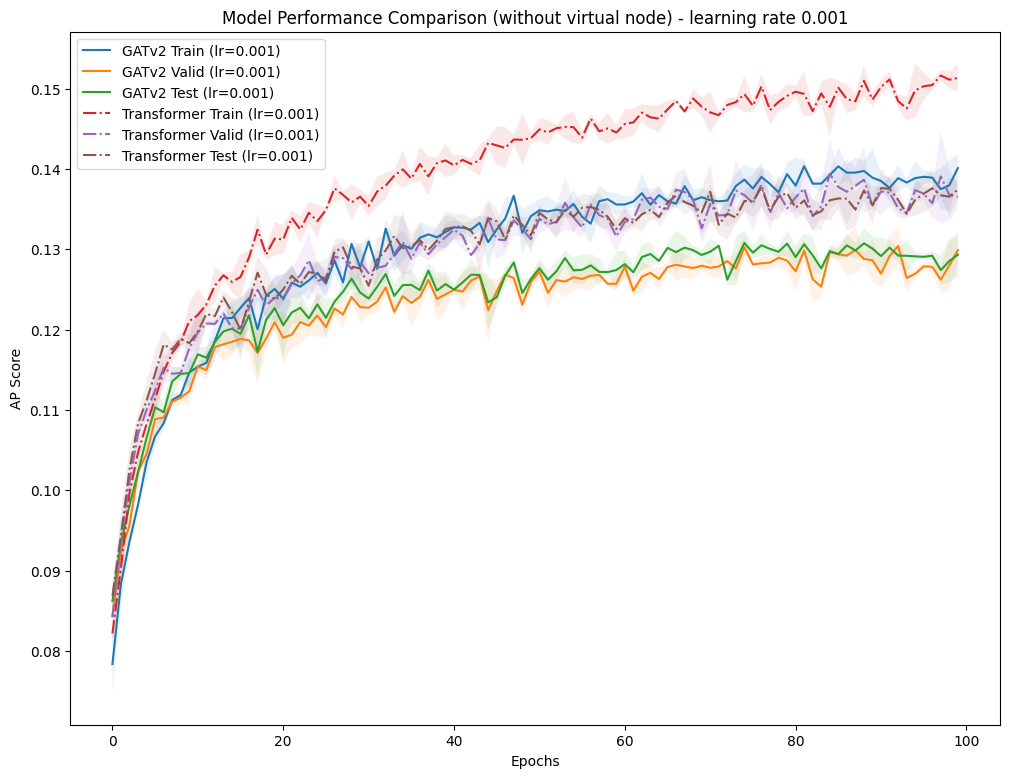

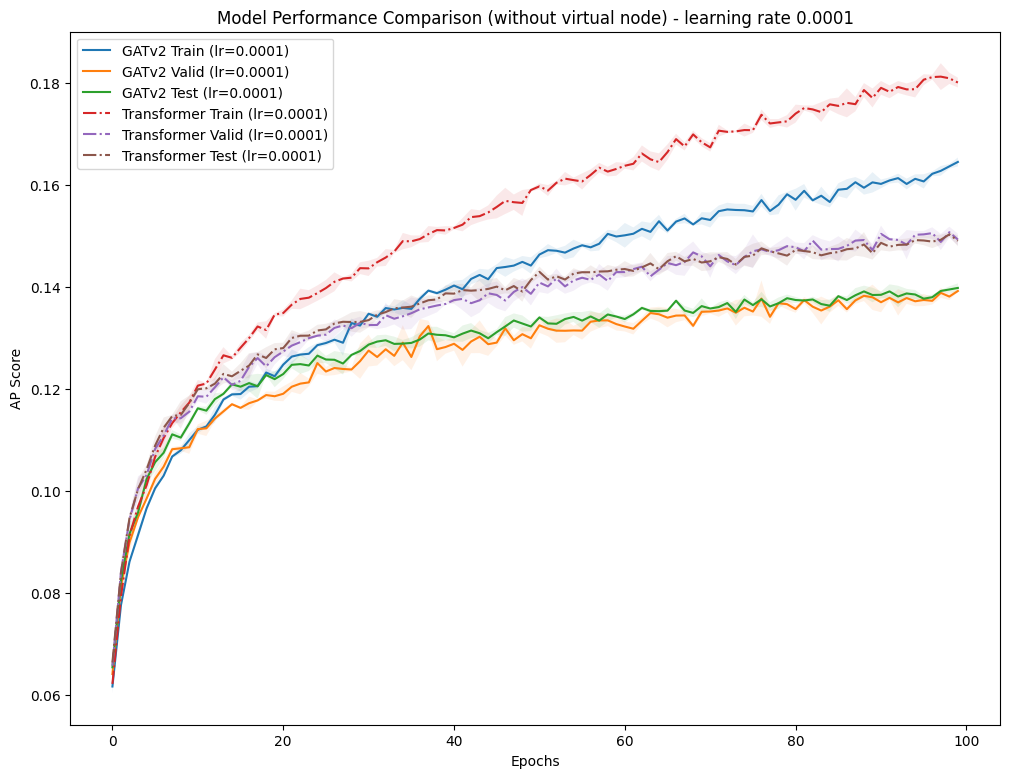

In [ ]:
def plot_models_performance(gat_data, trans_data, lr, epoch_count=100):
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(12, 9))

    # Assuming the first dimension of the data is the number of runs
    epochs = np.arange(epoch_count)

    # Plot GATv2 performance
    for metric in ['train', 'valid', 'test']:
        gat_means = np.mean(gat_data[metric], axis=0)
        gat_stds = np.std(gat_data[metric], axis=0)
        ax.plot(epochs, gat_means, label=f'GATv2 {metric.capitalize()} (lr={lr})', linestyle='solid')
        ax.fill_between(epochs, gat_means - gat_stds, gat_means + gat_stds, alpha=0.1)

    # Plot Transformer performance
    for metric in ['train', 'valid', 'test']:
        trans_means = np.mean(trans_data[metric], axis=0)
        trans_stds = np.std(trans_data[metric], axis=0)
        ax.plot(epochs, trans_means, label=f'Transformer {metric.capitalize()} (lr={lr})', linestyle='dashdot')
        ax.fill_between(epochs, trans_means - trans_stds, trans_means + trans_stds, alpha=0.1)

    # Add title and labels
    ax.set_title(f'Model Performance Comparison (without virtual node) - learning rate {lr}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('AP Score')

    # Add legend
    ax.legend()

    # Show plot
    plt.show()

plot_models_performance(gatv2_e3, trans_e3, 1e-3)
plot_models_performance(gatv2_e4, trans_e4, 1e-4)

In [ ]:
gatv2_v_e3 = read_json_to_dict("gatv2_record_new_1e-3_128.json")
trans_v_e3 = read_json_to_dict("trans_record_new_1e-3_128.json")
gin_v_e3_baseline = read_json_to_dict("gin_record_new_1e-3_128.json")

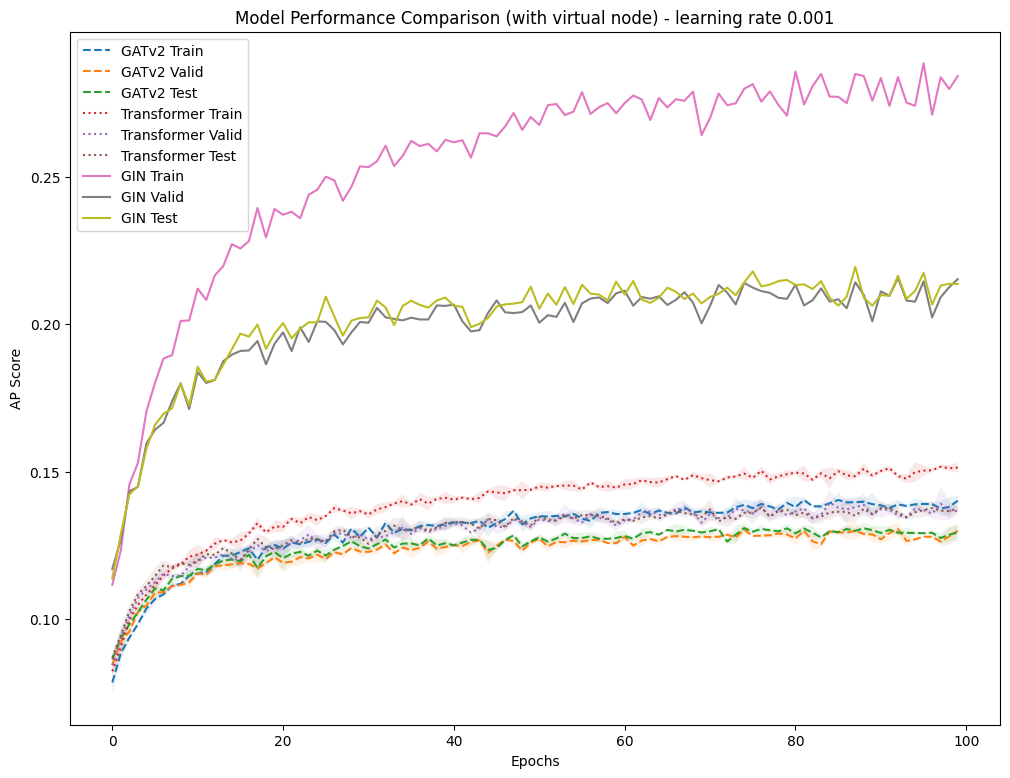

In [ ]:
def plot_models_performance2(gat_data, trans_data, gin_data, lr, epoch_count=100):
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(12, 9))

    # Assuming the first dimension of the data is the number of runs
    epochs = np.arange(epoch_count)

    # Plot GATv2 performance
    for metric in ['train', 'valid', 'test']:
    # for metric in ['test']:
        gat_means = np.mean(gat_data[metric], axis=0)
        gat_stds = np.std(gat_data[metric], axis=0)
        ax.plot(epochs, gat_means, label=f'GATv2 {metric.capitalize()}', linestyle='dashed')
        ax.fill_between(epochs, gat_means - gat_stds, gat_means + gat_stds, alpha=0.1)

    # Plot Transformer performance
    for metric in ['train', 'valid', 'test']:
    # for metric in ['test']:
        trans_means = np.mean(trans_data[metric], axis=0)
        trans_stds = np.std(trans_data[metric], axis=0)
        ax.plot(epochs, trans_means, label=f'Transformer {metric.capitalize()}', linestyle='dotted')
        ax.fill_between(epochs, trans_means - trans_stds, trans_means + trans_stds, alpha=0.1)

    # Plot Transformer performance
    for metric in ['train', 'valid', 'test']:
    # for metric in ['test']:
        gin_means = np.mean(gin_data[metric], axis=0)
        gin_stds = np.std(gin_data[metric], axis=0)
        ax.plot(epochs, gin_means, label=f'GIN {metric.capitalize()}', linestyle='solid')
        ax.fill_between(epochs, gin_means - gin_stds, gin_means + gin_stds, alpha=0.1)

    # Add title and labels
    ax.set_title(f'Model Performance Comparison (with virtual node) - learning rate {lr}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('AP Score')

    # Add legend
    ax.legend()

    # Show plot
    plt.show()

plot_models_performance2(gatv2_v_e3,trans_v_e3,gin_v_e3_baseline,1e-3)

In [ ]:
def summary(type, gat_data, lr, epoch_count=100):
    # Create a figure and a set of subplots
    # fig, ax = plt.subplots(figsize=(12, 9))

    # Assuming the first dimension of the data is the number of runs
    epochs = np.arange(epoch_count)

    # Plot GATv2 performance
    for metric in ['train', 'valid', 'test']:
    # for metric in ['test']:
        gat_means = np.mean(gat_data[metric], axis=0)
        gat_stds = np.std(gat_data[metric], axis=0)
        print(f"{type} {metric} at learning rate {lr}: {gat_means[-1]}, std: {gat_stds[-1]}")


summary("GATv2", gatv2_e3, 1e-3)
summary("GATv2", gatv2_e4, 1e-4)
print("------------------------------")
summary("Trans", trans_e3, 1e-3)
summary("Trans", trans_e4, 1e-4)
print("------------------------------")
summary("GATv2_virtual", gatv2_v_e3, 1e-3)
summary("trans_virtual", trans_v_e3, 1e-3)
summary("gin_virtual", gin_v_e3_baseline, 1e-3)

GATv2 train at learning rate 0.001: 0.14012039114035646, std: 0.001649460988809637
GATv2 valid at learning rate 0.001: 0.1298920508921779, std: 0.0016828180032604175
GATv2 test at learning rate 0.001: 0.12934652431048502, std: 0.002730894131942031
GATv2 train at learning rate 0.0001: 0.16446896710353912, std: 0.0008715224629778063
GATv2 valid at learning rate 0.0001: 0.13919160246998366, std: 0.00022003135254056492
GATv2 test at learning rate 0.0001: 0.13978911707133757, std: 0.0008968301916679525
------------------------------
Trans train at learning rate 0.001: 0.15135039097077427, std: 0.0016427886969880223
Trans valid at learning rate 0.001: 0.13655581289805632, std: 0.0014055586520777224
Trans test at learning rate 0.001: 0.13743412538276514, std: 0.0011217487240405214
Trans train at learning rate 0.0001: 0.1800231801933223, std: 0.0009635302001783697
Trans valid at learning rate 0.0001: 0.14927272057759375, std: 0.0011434889141361912
Trans test at learning rate 0.0001: 0.14901836

## Old Experiments (not used in report)

In [ ]:
model = GNN(gnn_type = 'gatv2', num_tasks = 128, num_layer = 5, input_dim = 300, emb_dim = 300, drop_ratio = 0.5).to(device)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

optimizer = optim.Adam(model.parameters(), lr=0.001)

valid_curve = []
test_curve = []
train_curve = []

epochs = 50

for epoch in range(1, epochs + 1):
    print("=====Epoch {}".format(epoch))
    print('Training...')
    train(model, device, train_loader, optimizer)

    print('Evaluating...')
    train_perf = eval(model, device, train_loader, evaluator)
    valid_perf = eval(model, device, valid_loader, evaluator)
    test_perf = eval(model, device, test_loader, evaluator)

    print({'Train': train_perf, 'Validation': valid_perf, 'Test': test_perf})

    # train_curve.append(train_perf[dataset.eval_metric])
    # valid_curve.append(valid_perf[dataset.eval_metric])
    # test_curve.append(test_perf[dataset.eval_metric])
    train_curve.append(train_perf['ap'])
    valid_curve.append(valid_perf['ap'])
    test_curve.append(test_perf['ap'])

    best_val_epoch = np.argmax(np.array(valid_curve))
    best_train = max(train_curve)

    print('Finished training!')
    print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
    print('Test score: {}'.format(test_curve[best_val_epoch]))


NameError: ignored

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")


Total number of trainable parameters: 70976


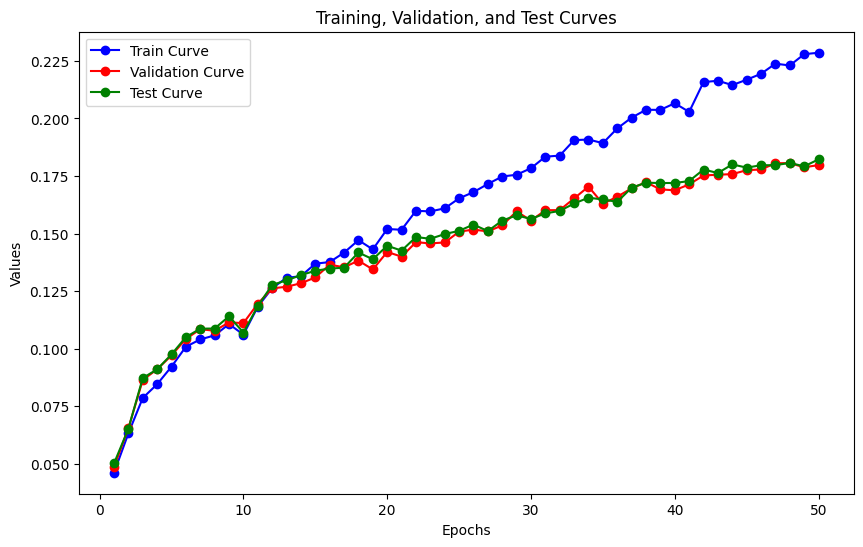

In [ ]:
import matplotlib.pyplot as plt
# Plotting the curves
epochs_range = range(1, len(valid_curve) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_curve, label='Train Curve', color='blue', marker='o')
plt.plot(epochs_range, valid_curve, label='Validation Curve', color='red', marker='o')
plt.plot(epochs_range, test_curve, label='Test Curve', color='green', marker='o')

# Adding titles and labels
plt.title('Training, Validation, and Test Curves')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

In [ ]:
gatv2_record = {'train': [train_curve], 'valid': [valid_curve], 'test': [test_curve]}

In [ ]:
import json
with open('gatv2_record.json', 'w') as f:
    json.dump(gatv2_record, f)

In [ ]:
model = GNN(gnn_type = 'transformer', num_tasks = 128, num_layer = 5, input_dim = 300, emb_dim = 300, drop_ratio = 0.5).to(device)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

optimizer = optim.Adam(model.parameters(), lr=0.001)

valid_curve = []
test_curve = []
train_curve = []

epochs = 50

for epoch in range(1, epochs + 1):
    print("=====Epoch {}".format(epoch))
    print('Training...')
    train(model, device, train_loader, optimizer)

    print('Evaluating...')
    train_perf = eval(model, device, train_loader, evaluator)
    valid_perf = eval(model, device, valid_loader, evaluator)
    test_perf = eval(model, device, test_loader, evaluator)

    print({'Train': train_perf, 'Validation': valid_perf, 'Test': test_perf})

    train_curve.append(train_perf['ap'])
    valid_curve.append(valid_perf['ap'])
    test_curve.append(test_perf['ap'])

    best_val_epoch = np.argmax(np.array(valid_curve))
    best_train = max(train_curve)

    print('Finished training!')
    print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
    print('Test score: {}'.format(test_curve[best_val_epoch]))


Total number of trainable parameters: 2353628
=====Epoch 1
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.79it/s]


{'Train': {'ap': 0.04885891912598549}, 'Validation': {'ap': 0.052785898074815686}, 'Test': {'ap': 0.0527263349406291}}
Finished training!
Best validation score: 0.052785898074815686
Test score: 0.0527263349406291
=====Epoch 2
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.81it/s]


{'Train': {'ap': 0.06606155044382564}, 'Validation': {'ap': 0.07036456692525427}, 'Test': {'ap': 0.07058161377563174}}
Finished training!
Best validation score: 0.07036456692525427
Test score: 0.07058161377563174
=====Epoch 3
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:06<00:00,  6.15it/s]


{'Train': {'ap': 0.0855645644660225}, 'Validation': {'ap': 0.08991956871247439}, 'Test': {'ap': 0.09056992556508346}}
Finished training!
Best validation score: 0.08991956871247439
Test score: 0.09056992556508346
=====Epoch 4
Training...


Iteration: 100%|██████████| 172/172 [01:40<00:00,  1.71it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:07<00:00,  6.14it/s]


{'Train': {'ap': 0.09352969925441977}, 'Validation': {'ap': 0.09634327031687809}, 'Test': {'ap': 0.09707434056357497}}
Finished training!
Best validation score: 0.09634327031687809
Test score: 0.09707434056357497
=====Epoch 5
Training...


Iteration: 100%|██████████| 172/172 [01:40<00:00,  1.71it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.90it/s]


{'Train': {'ap': 0.10049755665996961}, 'Validation': {'ap': 0.10365395464012865}, 'Test': {'ap': 0.104989795784576}}
Finished training!
Best validation score: 0.10365395464012865
Test score: 0.104989795784576
=====Epoch 6
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.86it/s]


{'Train': {'ap': 0.10732396905125714}, 'Validation': {'ap': 0.1090076900938425}, 'Test': {'ap': 0.11379380231863297}}
Finished training!
Best validation score: 0.1090076900938425
Test score: 0.11379380231863297
=====Epoch 7
Training...


Iteration: 100%|██████████| 172/172 [01:42<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.78it/s]


{'Train': {'ap': 0.10814453789270076}, 'Validation': {'ap': 0.10693988914050138}, 'Test': {'ap': 0.10922323988731858}}
Finished training!
Best validation score: 0.1090076900938425
Test score: 0.11379380231863297
=====Epoch 8
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.90it/s]


{'Train': {'ap': 0.1144191508295381}, 'Validation': {'ap': 0.11247922958859827}, 'Test': {'ap': 0.11785943064383081}}
Finished training!
Best validation score: 0.11247922958859827
Test score: 0.11785943064383081
=====Epoch 9
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.80it/s]


{'Train': {'ap': 0.11999269174479922}, 'Validation': {'ap': 0.1150548435892925}, 'Test': {'ap': 0.11992543259051898}}
Finished training!
Best validation score: 0.1150548435892925
Test score: 0.11992543259051898
=====Epoch 10
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.90it/s]


{'Train': {'ap': 0.12748109133788688}, 'Validation': {'ap': 0.12497428193361544}, 'Test': {'ap': 0.12635525292131602}}
Finished training!
Best validation score: 0.12497428193361544
Test score: 0.12635525292131602
=====Epoch 11
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.89it/s]


{'Train': {'ap': 0.12882835728694392}, 'Validation': {'ap': 0.1237124608443829}, 'Test': {'ap': 0.12603492845147643}}
Finished training!
Best validation score: 0.12497428193361544
Test score: 0.12635525292131602
=====Epoch 12
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:06<00:00,  6.15it/s]


{'Train': {'ap': 0.13406707579998262}, 'Validation': {'ap': 0.12535357084292137}, 'Test': {'ap': 0.1274133085894057}}
Finished training!
Best validation score: 0.12535357084292137
Test score: 0.1274133085894057
=====Epoch 13
Training...


Iteration: 100%|██████████| 172/172 [01:40<00:00,  1.71it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:06<00:00,  6.26it/s]


{'Train': {'ap': 0.13884158994707904}, 'Validation': {'ap': 0.12841665107406386}, 'Test': {'ap': 0.13171719997085893}}
Finished training!
Best validation score: 0.12841665107406386
Test score: 0.13171719997085893
=====Epoch 14
Training...


Iteration: 100%|██████████| 172/172 [01:40<00:00,  1.72it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.84it/s]


{'Train': {'ap': 0.14090460238587757}, 'Validation': {'ap': 0.12912346088960322}, 'Test': {'ap': 0.13306674420796286}}
Finished training!
Best validation score: 0.12912346088960322
Test score: 0.13306674420796286
=====Epoch 15
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:06<00:00,  6.20it/s]


{'Train': {'ap': 0.1434110022549598}, 'Validation': {'ap': 0.13315089654946702}, 'Test': {'ap': 0.13675056041427006}}
Finished training!
Best validation score: 0.13315089654946702
Test score: 0.13675056041427006
=====Epoch 16
Training...


Iteration: 100%|██████████| 172/172 [01:40<00:00,  1.71it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.91it/s]


{'Train': {'ap': 0.14864110963503724}, 'Validation': {'ap': 0.13685855857919668}, 'Test': {'ap': 0.13747233421313734}}
Finished training!
Best validation score: 0.13685855857919668
Test score: 0.13747233421313734
=====Epoch 17
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.89it/s]


{'Train': {'ap': 0.1488821867870922}, 'Validation': {'ap': 0.13611828239229215}, 'Test': {'ap': 0.13752233756791007}}
Finished training!
Best validation score: 0.13685855857919668
Test score: 0.13747233421313734
=====Epoch 18
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.90it/s]


{'Train': {'ap': 0.15229774413504393}, 'Validation': {'ap': 0.1376545498200362}, 'Test': {'ap': 0.13848158143404493}}
Finished training!
Best validation score: 0.1376545498200362
Test score: 0.13848158143404493
=====Epoch 19
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.90it/s]


{'Train': {'ap': 0.1559274561580473}, 'Validation': {'ap': 0.1383235910567353}, 'Test': {'ap': 0.14116229768430627}}
Finished training!
Best validation score: 0.1383235910567353
Test score: 0.14116229768430627
=====Epoch 20
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.95it/s]


{'Train': {'ap': 0.15694923375032682}, 'Validation': {'ap': 0.1441581768345141}, 'Test': {'ap': 0.14410886634962441}}
Finished training!
Best validation score: 0.1441581768345141
Test score: 0.14410886634962441
=====Epoch 21
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.81it/s]


{'Train': {'ap': 0.1622055132127726}, 'Validation': {'ap': 0.14385807242044507}, 'Test': {'ap': 0.14548163767123812}}
Finished training!
Best validation score: 0.1441581768345141
Test score: 0.14410886634962441
=====Epoch 22
Training...


Iteration: 100%|██████████| 172/172 [01:42<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:06<00:00,  6.20it/s]


{'Train': {'ap': 0.1660159925611634}, 'Validation': {'ap': 0.14837719855966405}, 'Test': {'ap': 0.14754979033167454}}
Finished training!
Best validation score: 0.14837719855966405
Test score: 0.14754979033167454
=====Epoch 23
Training...


Iteration: 100%|██████████| 172/172 [01:40<00:00,  1.71it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:06<00:00,  6.21it/s]


{'Train': {'ap': 0.16700297417959217}, 'Validation': {'ap': 0.14878468639598477}, 'Test': {'ap': 0.14880509277448462}}
Finished training!
Best validation score: 0.14878468639598477
Test score: 0.14880509277448462
=====Epoch 24
Training...


Iteration: 100%|██████████| 172/172 [01:40<00:00,  1.71it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:07<00:00,  6.03it/s]


{'Train': {'ap': 0.17009436718164694}, 'Validation': {'ap': 0.148767833738915}, 'Test': {'ap': 0.1497733083004697}}
Finished training!
Best validation score: 0.14878468639598477
Test score: 0.14880509277448462
=====Epoch 25
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.70it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:06<00:00,  6.19it/s]


{'Train': {'ap': 0.17352811513701916}, 'Validation': {'ap': 0.15256898167248958}, 'Test': {'ap': 0.15263501265279739}}
Finished training!
Best validation score: 0.15256898167248958
Test score: 0.15263501265279739
=====Epoch 26
Training...


Iteration: 100%|██████████| 172/172 [01:40<00:00,  1.71it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.88it/s]


{'Train': {'ap': 0.1734807584214886}, 'Validation': {'ap': 0.15381149066646205}, 'Test': {'ap': 0.15425591778993095}}
Finished training!
Best validation score: 0.15381149066646205
Test score: 0.15425591778993095
=====Epoch 27
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.87it/s]


{'Train': {'ap': 0.1777730576848015}, 'Validation': {'ap': 0.1571818518543045}, 'Test': {'ap': 0.15641724382690886}}
Finished training!
Best validation score: 0.1571818518543045
Test score: 0.15641724382690886
=====Epoch 28
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.93it/s]


{'Train': {'ap': 0.1809448948985527}, 'Validation': {'ap': 0.15738324982077415}, 'Test': {'ap': 0.1562380459423622}}
Finished training!
Best validation score: 0.15738324982077415
Test score: 0.1562380459423622
=====Epoch 29
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.88it/s]


{'Train': {'ap': 0.18451751273592445}, 'Validation': {'ap': 0.1593995295695677}, 'Test': {'ap': 0.1572165338206578}}
Finished training!
Best validation score: 0.1593995295695677
Test score: 0.1572165338206578
=====Epoch 30
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.88it/s]


{'Train': {'ap': 0.18431536091225126}, 'Validation': {'ap': 0.15754861194644315}, 'Test': {'ap': 0.155179191112859}}
Finished training!
Best validation score: 0.1593995295695677
Test score: 0.1572165338206578
=====Epoch 31
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.86it/s]


{'Train': {'ap': 0.18718480638573926}, 'Validation': {'ap': 0.16101025078770204}, 'Test': {'ap': 0.16078739720061974}}
Finished training!
Best validation score: 0.16101025078770204
Test score: 0.16078739720061974
=====Epoch 32
Training...


Iteration: 100%|██████████| 172/172 [01:42<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.80it/s]


{'Train': {'ap': 0.18777192612185004}, 'Validation': {'ap': 0.1625625062844581}, 'Test': {'ap': 0.16226128260079195}}
Finished training!
Best validation score: 0.1625625062844581
Test score: 0.16226128260079195
=====Epoch 33
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.80it/s]


{'Train': {'ap': 0.19246161158734426}, 'Validation': {'ap': 0.16642321247647066}, 'Test': {'ap': 0.16538981833803174}}
Finished training!
Best validation score: 0.16642321247647066
Test score: 0.16538981833803174
=====Epoch 34
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.85it/s]


{'Train': {'ap': 0.1902673921096495}, 'Validation': {'ap': 0.16349101338948183}, 'Test': {'ap': 0.16157647058128136}}
Finished training!
Best validation score: 0.16642321247647066
Test score: 0.16538981833803174
=====Epoch 35
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.95it/s]


{'Train': {'ap': 0.19701348315092912}, 'Validation': {'ap': 0.16728108131601102}, 'Test': {'ap': 0.16582340138776586}}
Finished training!
Best validation score: 0.16728108131601102
Test score: 0.16582340138776586
=====Epoch 36
Training...


Iteration: 100%|██████████| 172/172 [01:42<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.81it/s]


{'Train': {'ap': 0.19931667771457262}, 'Validation': {'ap': 0.16568438852078438}, 'Test': {'ap': 0.16574931552567054}}
Finished training!
Best validation score: 0.16728108131601102
Test score: 0.16582340138776586
=====Epoch 37
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.87it/s]


{'Train': {'ap': 0.20028545853468863}, 'Validation': {'ap': 0.17069453788230346}, 'Test': {'ap': 0.16805370907454206}}
Finished training!
Best validation score: 0.17069453788230346
Test score: 0.16805370907454206
=====Epoch 38
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.85it/s]


{'Train': {'ap': 0.2029691973963067}, 'Validation': {'ap': 0.1733423206721386}, 'Test': {'ap': 0.16877248281159482}}
Finished training!
Best validation score: 0.1733423206721386
Test score: 0.16877248281159482
=====Epoch 39
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.76it/s]


{'Train': {'ap': 0.20466261284381781}, 'Validation': {'ap': 0.17226067350264856}, 'Test': {'ap': 0.1695397458176706}}
Finished training!
Best validation score: 0.1733423206721386
Test score: 0.16877248281159482
=====Epoch 40
Training...


Iteration: 100%|██████████| 172/172 [01:42<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.82it/s]


{'Train': {'ap': 0.20723127951983317}, 'Validation': {'ap': 0.17199210176305427}, 'Test': {'ap': 0.1704332346158575}}
Finished training!
Best validation score: 0.1733423206721386
Test score: 0.16877248281159482
=====Epoch 41
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.85it/s]


{'Train': {'ap': 0.2075115323238524}, 'Validation': {'ap': 0.17309888234312926}, 'Test': {'ap': 0.17032689442944354}}
Finished training!
Best validation score: 0.1733423206721386
Test score: 0.16877248281159482
=====Epoch 42
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.76it/s]


{'Train': {'ap': 0.20813936305489641}, 'Validation': {'ap': 0.17422163399102786}, 'Test': {'ap': 0.17551261236996407}}
Finished training!
Best validation score: 0.17422163399102786
Test score: 0.17551261236996407
=====Epoch 43
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.79it/s]


{'Train': {'ap': 0.21140109445235805}, 'Validation': {'ap': 0.17815302051361537}, 'Test': {'ap': 0.1743136740226443}}
Finished training!
Best validation score: 0.17815302051361537
Test score: 0.1743136740226443
=====Epoch 44
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.72it/s]


{'Train': {'ap': 0.21152981139416235}, 'Validation': {'ap': 0.1753105815595418}, 'Test': {'ap': 0.17216396473916334}}
Finished training!
Best validation score: 0.17815302051361537
Test score: 0.1743136740226443
=====Epoch 45
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.93it/s]


{'Train': {'ap': 0.2150709941211385}, 'Validation': {'ap': 0.17910199601544538}, 'Test': {'ap': 0.1774809955854534}}
Finished training!
Best validation score: 0.17910199601544538
Test score: 0.1774809955854534
=====Epoch 46
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.83it/s]


{'Train': {'ap': 0.21506078254260164}, 'Validation': {'ap': 0.18049325575757097}, 'Test': {'ap': 0.17608661075337387}}
Finished training!
Best validation score: 0.18049325575757097
Test score: 0.17608661075337387
=====Epoch 47
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.76it/s]


{'Train': {'ap': 0.21572398781120541}, 'Validation': {'ap': 0.1786897546925739}, 'Test': {'ap': 0.17781885404694928}}
Finished training!
Best validation score: 0.18049325575757097
Test score: 0.17608661075337387
=====Epoch 48
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.80it/s]


{'Train': {'ap': 0.2192568142223444}, 'Validation': {'ap': 0.18335413962273647}, 'Test': {'ap': 0.17797102844615903}}
Finished training!
Best validation score: 0.18335413962273647
Test score: 0.17797102844615903
=====Epoch 49
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.88it/s]


{'Train': {'ap': 0.21792222044340034}, 'Validation': {'ap': 0.17975139360869036}, 'Test': {'ap': 0.17772005691738477}}
Finished training!
Best validation score: 0.18335413962273647
Test score: 0.17797102844615903
=====Epoch 50
Training...


Iteration: 100%|██████████| 172/172 [01:41<00:00,  1.69it/s]


Evaluating...


Iteration: 100%|██████████| 43/43 [00:05<00:00,  7.63it/s]


{'Train': {'ap': 0.22209836921452078}, 'Validation': {'ap': 0.18527897937216772}, 'Test': {'ap': 0.18206870939325528}}
Finished training!
Best validation score: 0.18527897937216772
Test score: 0.18206870939325528


In [ ]:
trans_record = {'train': [train_curve], 'valid': [valid_curve], 'test': [test_curve]}

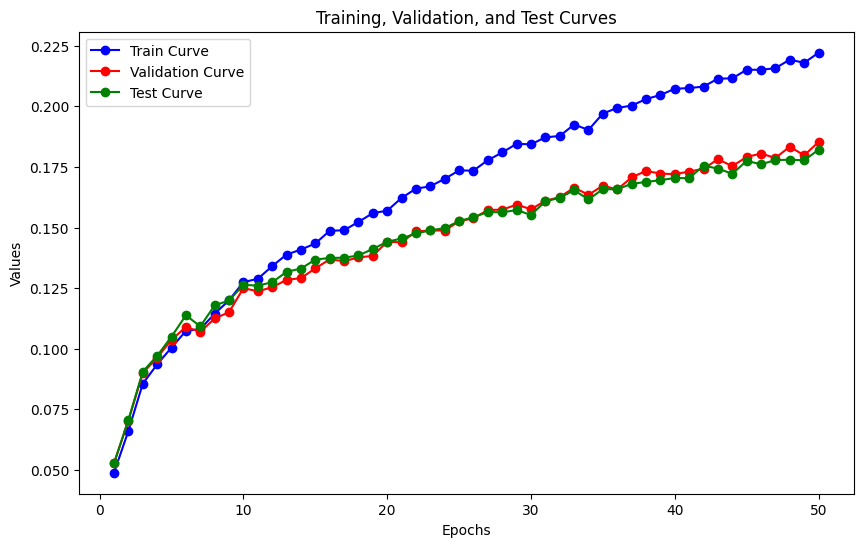

In [ ]:
import matplotlib.pyplot as plt
# Plotting the curves
epochs_range = range(1, len(valid_curve) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_curve, label='Train Curve', color='blue', marker='o')
plt.plot(epochs_range, valid_curve, label='Validation Curve', color='red', marker='o')
plt.plot(epochs_range, test_curve, label='Test Curve', color='green', marker='o')

# Adding titles and labels
plt.title('Training, Validation, and Test Curves')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

In [ ]:
import json
with open('trans_record.json', 'w') as f:
    json.dump(trans_record, f)